# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [23]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = 'C:/Users/rober/Desktop/'
VIDEO_DIR = 'C:/Users/rober/Desktop/rhAirpuff/videos/'
file_container_obj = FileContainer(ROOT_DIR, VIDEO_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Session folder not found.
  Select .h5 behavior file (i.e. None_None_choice.h5)
  Select directory containing White Matter video files (i.e. None_None)
  Select directory containing SpikeGLX files (i.e. None_None_g0)
Behavior file selected: C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf_UnityVR_resampled.h5
  MonkeyLogic Date: 231223
  MonkeyLogic Monkey: gandalf
Video files directory selected: C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf
  White Matter Video Date: 231223
  White Matter Video Monkey: gandalf
SpikeGLX files directory selected: C:/Users/rober/Desktop/gandalf_20231223/gandalf_20231223_g0
  SpikeGLX Date: 231223
  SpikeGLX Monkey: gandalf



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [26]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 366
Parsing session data...


  0%|          | 0/366 [00:00<?, ?it/s]

  joystick_y removed from session_dict
    0 trials in field != 365 trials in session
  Distractor removed from session_dict
    730 trials in field != 365 trials in session
  Target removed from session_dict
    730 trials in field != 365 trials in session
  Additional_Positions_x removed from session_dict
    133 trials in field != 365 trials in session
  Additional_Positions_y removed from session_dict
    133 trials in field != 365 trials in session
  Additional_Positions_z removed from session_dict
    133 trials in field != 365 trials in session
  Additional_Positions_1_x removed from session_dict
    112 trials in field != 365 trials in session
  Additional_Positions_1_y removed from session_dict
    112 trials in field != 365 trials in session
  Additional_Positions_1_z removed from session_dict
    112 trials in field != 365 trials in session
  Additional_Positions_2_x removed from session_dict
    112 trials in field != 365 trials in session
  Additional_Positions_2_y removed

In [27]:
session_obj.df.head(5)

date  session_num  subject  trial_num  block  condition  correct  error  \
0  231223            0  gandalf          1      1          1        0      1   
1  231223            0  gandalf          2      1          1        1      0   
2  231223            0  gandalf          3      1          1        1      0   
3  231223            0  gandalf          4      1          1        1      0   
4  231223            0  gandalf          5      1          1        1      0   

   error_type behavioral_code_markers  \
0           8             [9, 10, 18]   
1           0     [9, 10, 14, 50, 18]   
2           0         [9, 10, 50, 18]   
3           0         [9, 10, 50, 18]   
4           0         [9, 10, 50, 18]   

                               behavioral_code_times  \
0  [2.1411999769043177, 2869.1711999999825, 50927...   
1  [321.4086000225507, 393.3433000056539, 49357.0...   
2  [244.9037999904249, 312.6124999835156, 18548.3...   
3  [193.0677999916952, 249.82959998305887, 12814....   
4  [190.61379999038763, 265.7947999832686, 9763.4...   

   AutomaticRotation_1_start  AutomaticRotation_1_end  CuedNavigation_start  \
0                        NaN                      NaN                     0   
1                        0.0                  16925.0                 16926   
2                        0.0                   4524.0                  4525   
3                        0.0                   1647.0                  1648   
4                        0.0                   1648.0                  1649   

   CuedNavigation_end  PreRotationDelay_start  PreRotationDelay_end  \
0               47345                     NaN                   NaN   
1               18653                 18654.0               19547.0   
2               11558                 11559.0               12483.0   
3                5912                  5913.0                6702.0   
4                2585                  2586.0                3120.0   

   AutomaticRotation_2_start  AutomaticRotation_2_end  \
0                        NaN                      NaN   
1                    19548.0                  24074.0   
2                    12484.0                  14210.0   
3                     6703.0                   8276.0   
4                     3121.0                   5086.0   

   ChoiceLocationApproach_start  ChoiceLocationApproach_end  \
0                           NaN                         NaN   
1                       24075.0                     25412.0   
2                       14211.0                     15630.0   
3                        8277.0                      9651.0   
4                        5087.0                      6383.0   

   PreChoiceDelay_start  PreChoiceDelay_end  Choice_start  Choice_end  \
0                   NaN                 NaN           NaN         NaN   
1               25413.0             26202.0       26203.0     26659.0   
2               15631.0             16193.0       16194.0     16709.0   
3                9652.0             10262.0       10263.0     10931.0   
4                6384.0              7115.0        7116.0      7814.0   

   ObjectApproach_start  ObjectApproach_end  Reward_start  Reward_end  \
0                   NaN                 NaN           NaN         NaN   
1               26660.0             27546.0       27593.0     28094.0   
2               16710.0             17422.0       17465.0     17965.0   
3               10932.0             11615.0       11662.0     12162.0   
4                7815.0              8497.0        8560.0      9061.0   

   ITI_start  ITI_end                                              eye_x  \
0      47378    77991  [7.0642227726292575, 7.038963511766996, 7.0389...   
1      28095    29279  [18.66274639588813, 18.66274639588813, 18.6412...   
2      17966    19210  [-3.462277904521568, -3.462277904521568, -3.48...   
3      12163    13460  [7.348621677865265, 7.348621677865265, 7.37095...   
4       9062    10131  [nan, nan, nan, nan, nan, nan, nan,

In [36]:
session_obj.date

'231223'

In [38]:
import pickle
from config.h5_helper import pickler

dest_path = os.path.join(os.getcwd(), '_data', '_'.join([session_obj.monkey, session_obj.date]))
# dest_path = os.path.dirname(file_container_obj.ml_file_path)

pickler(True, 
        save_path=dest_path, 
        session_df=session_obj.df, 
        monkey_input='gandalf',
        experiment_name='VR',
        error_dict=error_dict, 
        behavioral_code_dict=behavioral_code_dict)

Saving .pickle files to: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\_data\gandalf_231223
  Pickling 231223_gandalf_VR_behave.pkl
  Total time to pickle: 3.0032 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [39]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start trial
  End trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\Desktop\gandalf_20231223\gandalf_20231223_g0\gandalf_20231223_g0_t0.nidq.bin
File Name: D://gandalf_20231223_g0/gandalf_20231223_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-23T17:36:59
  File Length: 6040.45037399812
nChan: 9, nFileSamp: 12080867
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  1999.994413
 Channel [0]: cam_sync
  Max Val: 3345.642
  Min Val: -6.104
 Channel [1]: cam_save
  Max Val: 3357.849
  Min Val: -20.142
 Channel [2]: lick
  Max Val: 152.283
  Min Val: -34.485
 Channel [3]: photodiode
  Max Val: 2217.712
  Min Val: 417.786
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


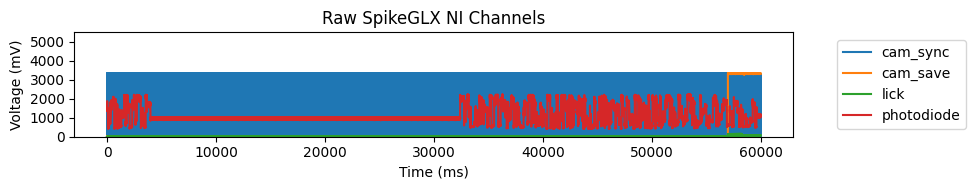

In [156]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=60)

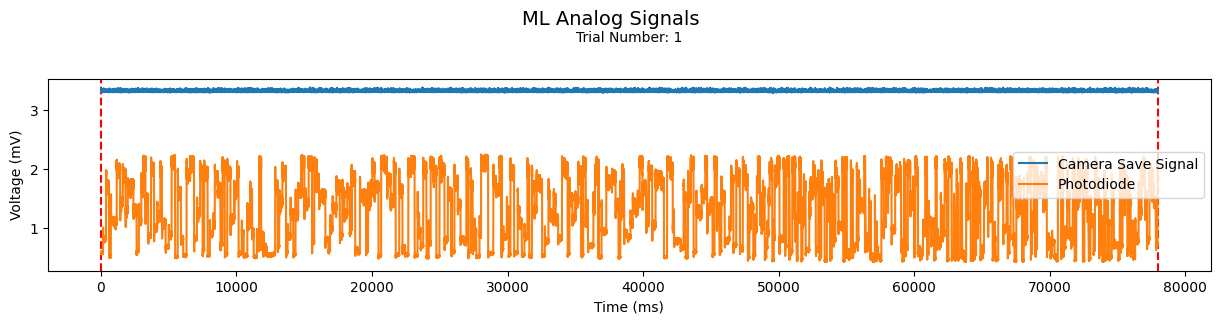

In [142]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

In [66]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

Found pickled spikeglx_obj: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\_data\gandalf_231223\spikeglx_obj_gandalf_231223.pkl
Updating spikeglx_obj paths...
  Updated sglx_dir_path to: C:/Users/rober/Desktop/gandalf_20231223
  Deleted old video_file_paths
  Deleted old video_info
  Updating video_file_paths and video_info...
Video Folders:
  231223_Gandalf_173755
  231223_Gandalf_174137
  231223_Gandalf_180501
Number of cameras: 5
  Camera: e3v831b | Number of videos: 5
  Camera: e3v8360 | Number of videos: 5
  Camera: e3v83ad | Number of videos: 5
  Camera: e3v83c5 | Number of videos: 5
  Camera: e3v83d6 | Number of videos: 5
Camera: e3v831b
  Video: e3v831b-20231223T173753-175754.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231223T175754-181754.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231223T181754-183755.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231223T18375

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

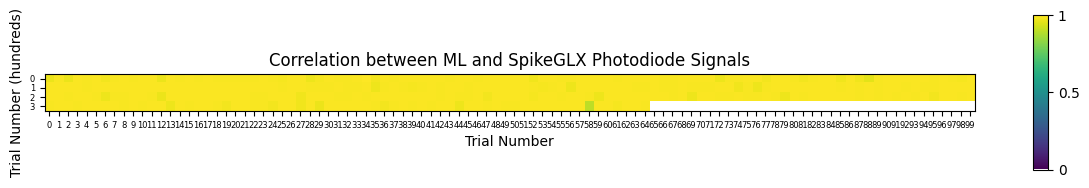

In [41]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

### Insert SpikeGLX Data Into Session DataFrame

In [101]:
# add spikeglx trial_start times to session_df
def add_sglx_trial_times(session_obj, spikeglx_obj):
  sglx_trial_sample_start = [spikeglx_obj.trial_times[trial]['start'] for trial in spikeglx_obj.trial_times.keys()]
  sglx_trial_sample_end = [spikeglx_obj.trial_times[trial]['end'] for trial in spikeglx_obj.trial_times.keys()]
  sglx_start_times = [int(spikeglx_obj.sample_rate*trial_sample/1000) for trial_sample in sglx_trial_sample_start]
  sglx_end_times = [int(spikeglx_obj.sample_rate*trial_sample/1000) for trial_sample in sglx_trial_sample_end]
  trial_times = [spikeglx_obj.sample_times[sglx_start_time:sglx_end_time] for sglx_start_time, sglx_end_time in zip(sglx_start_times, sglx_end_times)]
  session_obj.df['sglx_trial_times'] = trial_times
  return session_obj
session_obj = add_sglx_trial_times(session_obj, spikeglx_obj)

In [103]:
session_obj.df.head(5)

date  session_num  subject  trial_num  block  condition  correct  error  \
0  231223            0  gandalf          1      1          1        0      1   
1  231223            0  gandalf          2      1          1        1      0   
2  231223            0  gandalf          3      1          1        1      0   
3  231223            0  gandalf          4      1          1        1      0   
4  231223            0  gandalf          5      1          1        1      0   

   error_type behavioral_code_markers  \
0           8             [9, 10, 18]   
1           0     [9, 10, 14, 50, 18]   
2           0         [9, 10, 50, 18]   
3           0         [9, 10, 50, 18]   
4           0         [9, 10, 50, 18]   

                               behavioral_code_times  \
0  [2.1411999769043177, 2869.1711999999825, 50927...   
1  [321.4086000225507, 393.3433000056539, 49357.0...   
2  [244.9037999904249, 312.6124999835156, 18548.3...   
3  [193.0677999916952, 249.82959998305887, 12814....   
4  [190.61379999038763, 265.7947999832686, 9763.4...   

   AutomaticRotation_1_start  AutomaticRotation_1_end  CuedNavigation_start  \
0                        NaN                      NaN                     0   
1                        0.0                  16925.0                 16926   
2                        0.0                   4524.0                  4525   
3                        0.0                   1647.0                  1648   
4                        0.0                   1648.0                  1649   

   CuedNavigation_end  PreRotationDelay_start  PreRotationDelay_end  \
0               47345                     NaN                   NaN   
1               18653                 18654.0               19547.0   
2               11558                 11559.0               12483.0   
3                5912                  5913.0                6702.0   
4                2585                  2586.0                3120.0   

   AutomaticRotation_2_start  AutomaticRotation_2_end  \
0                        NaN                      NaN   
1                    19548.0                  24074.0   
2                    12484.0                  14210.0   
3                     6703.0                   8276.0   
4                     3121.0                   5086.0   

   ChoiceLocationApproach_start  ChoiceLocationApproach_end  \
0                           NaN                         NaN   
1                       24075.0                     25412.0   
2                       14211.0                     15630.0   
3                        8277.0                      9651.0   
4                        5087.0                      6383.0   

   PreChoiceDelay_start  PreChoiceDelay_end  Choice_start  Choice_end  \
0                   NaN                 NaN           NaN         NaN   
1               25413.0             26202.0       26203.0     26659.0   
2               15631.0             16193.0       16194.0     16709.0   
3                9652.0             10262.0       10263.0     10931.0   
4                6384.0              7115.0        7116.0      7814.0   

   ObjectApproach_start  ObjectApproach_end  Reward_start  Reward_end  \
0                   NaN                 NaN           NaN         NaN   
1               26660.0             27546.0       27593.0     28094.0   
2               16710.0             17422.0       17465.0     17965.0   
3               10932.0             11615.0       11662.0     12162.0   
4                7815.0              8497.0        8560.0      9061.0   

   ITI_start  ITI_end                                              eye_x  \
0      47378    77991  [7.0642227726292575, 7.038963511766996, 7.0389...   
1      28095    29279  [18.66274639588813, 18.66274639588813, 18.6412...   
2      17966    19210  [-3.462277904521568, -3.462277904521568, -3.48...   
3      12163    13460  [7.348621677865265, 7.348621677865265, 7.37095...   
4       9062    10131  [nan, nan, nan, nan, nan, nan, nan,

### Insert Neural Data

In [149]:
from classes.SpikeContainer import SpikeContainer

probe_assignment = {
  'imec0': 'PMd',
  'imec1': 'HPC',
  'imec2': 'DLPFCd',
  'imec3': 'DLPFCv'
}

# set the root directory for the data
root='c:/Users/rober/SynologyDrive/Rob'

# create a spike container object
spike_container = SpikeContainer(
  ROOT=root, 
  session_obj=session_obj,
  probes=[1,2,3], 
  probe_assignment=probe_assignment
)

Loading data from c:/Users/rober/SynologyDrive/Rob\gandalf_20231223
    Skipping gandalf_20231223_g0_imec0...
    Found gandalf_20231223_g0_imec1...
    Found gandalf_20231223_g0_imec2...
    Found gandalf_20231223_g0_imec3...
  Loading data from gandalf_20231223_g0_imec1...
    Found spike_times_adj.npy...
    Replacing spike_times with spike_times_adj...
    Number of clusters:            523                      
    Number of good clusters:       169                      
    Number of spikes:              3,628,706                
    Number of spikes/cluster:      6,938                    
    Creating spike dataframe...
  Loading data from gandalf_20231223_g0_imec2...
    Found spike_times_adj.npy...
    Replacing spike_times with spike_times_adj...
    Number of clusters:            384                      
    Number of good clusters:       206                      
    Number of spikes:              4,454,084                
    Number of spikes/cluster:      11,599         

In [166]:
spike_container.cluster_info[spike_container.cluster_info['good'] == True]

cluster      date   monkey   imec  region  Amplitude  ContamPct KSLabel  \
1          3  20231223  gandalf  imec1     HPC     1538.8      100.0     mua   
4          6  20231223  gandalf  imec1     HPC     2406.1      100.0    good   
5          7  20231223  gandalf  imec1     HPC     2803.1      100.0    good   
29        36  20231223  gandalf  imec1     HPC     1515.3      100.0     mua   
30        39  20231223  gandalf  imec1     HPC     2470.4      100.0     mua   
..       ...       ...      ...    ...     ...        ...        ...     ...   
313      387  20231223  gandalf  imec3  DLPFCv     1749.4      100.0    good   
314      388  20231223  gandalf  imec3  DLPFCv      779.9      100.0     mua   
315      390  20231223  gandalf  imec3  DLPFCv     2304.4      100.0    good   
316      393  20231223  gandalf  imec3  DLPFCv     1731.2      100.0    good   
317      394  20231223  gandalf  imec3  DLPFCv     2040.7      100.0    good   

            amp   ch   depth        fr group merge  n_spikes  sh  \
1     81.685486    3    20.0  0.180286  good     .      1089   0   
4    129.497711    9    80.0  8.245967  good     .     49809   0   
5    148.371109    6    60.0  0.196675  good   NaN      1188   0   
29    72.956573   19   180.0  0.809051  good   NaN      4887   0   
30   103.318535   22   220.0  4.947514  good   NaN     29885   0   
..          ...  ...     ...       ...   ...   ...       ...  ..   
313   78.204353  105  1040.0  1.545257  good     .      9334   0   
314   42.377701   18   180.0  1.397420  good   NaN      8441   0   
315   74.439713   81   800.0  1.424073  good     .      8602   0   
316   74.913841   95   940.0  1.667931  good     .     10075   0   
317  112.897484   16   160.0  0.254784  good   NaN      1539   0   

                                            spike_time  good  
1    [174920, 281406, 1724200, 2841686, 2853020, 28...  True  
4    [9326998, 10458095, 15594478, 16661584, 212328...  True  
5    [67129, 212875, 512949, 863168, 884720, 920058...  True  
29   [176753, 179371, 213144, 276601, 739922, 78389...  True  
30   [8119, 87064, 90589, 129790, 167279, 281235, 5...  True  
..                                                 ...   ...  
313  [49927, 69007, 79397, 125142, 126817, 129934, ...  True  
314  [687, 44920, 58226, 179241, 180944, 188432, 20...  True  
315  [71631, 83764, 84964, 99185, 152760, 153236, 1...  True  
316  [8950, 13135, 17079, 19825, 19996, 21250, 2461...  True  
317  [519640, 1341509, 2138439, 2682378, 2686627, 3...  True  

[539 rows x 18 columns]

In [168]:
good_neurons = spike_container.cluster_info[spike_container.cluster_info['good'] == True]
pickle.dump(good_neurons, open(os.path.join(ROOT_DIR,'good_neurons.pkl'), 'wb'))

In [171]:
behavior_df = session_obj.df
pickle.dump(behavior_df, open(os.path.join(ROOT_DIR,'behavior_df.pkl'), 'wb'))

In [172]:
pickle_load = pickle.load(open(os.path.join(ROOT_DIR,'behavior_df.pkl'), 'rb'))
pickle_load

date  session_num  subject  trial_num  block  condition  correct  \
0    231223            0  gandalf          1      1          1        0   
1    231223            0  gandalf          2      1          1        1   
2    231223            0  gandalf          3      1          1        1   
3    231223            0  gandalf          4      1          1        1   
4    231223            0  gandalf          5      1          1        1   
..      ...          ...      ...        ...    ...        ...      ...   
360  231223            0  gandalf        361      1          1        0   
361  231223            0  gandalf        362      1          1        1   
362  231223            0  gandalf        363      1          1        1   
363  231223            0  gandalf        364      1          1        1   
364  231223            0  gandalf        365      1          1        0   

     error  error_type      behavioral_code_markers  \
0        1           8                  [9, 10, 18]   
1        0           0          [9, 10, 14, 50, 18]   
2        0           0              [9, 10, 50, 18]   
3        0           0              [9, 10, 50, 18]   
4        0           0              [9, 10, 50, 18]   
..     ...         ...                          ...   
360      1           8  [9, 10, 14, 14, 14, 14, 18]   
361      0           0              [9, 10, 50, 18]   
362      0           0              [9, 10, 50, 18]   
363      0           0              [9, 10, 50, 18]   
364      1           8                  [9, 10, 18]   

                                 behavioral_code_times  \
0    [2.1411999769043177, 2869.1711999999825, 50927...   
1    [321.4086000225507, 393.3433000056539, 49357.0...   
2    [244.9037999904249, 312.6124999835156, 18548.3...   
3    [193.0677999916952, 249.82959998305887, 12814....   
4    [190.61379999038763, 265.7947999832686, 9763.4...   
..                                                 ...   
360  [193.5075999936089, 250.4546999989543, 54379.0...   
361  [216.7710000067018, 266.7092999909073, 22670.1...   
362  [176.03850000887178, 234.77460001595318, 12044...   
363  [164.04710002825595, 215.6029000179842, 17165....   
364  [175.7303000194952, 232.64870001003146, 51493....   

     AutomaticRotation_1_start  AutomaticRotation_1_end  CuedNavigation_start  \
0                          NaN                      NaN                     0   
1                          0.0                  16925.0                 16926   
2                          0.0                   4524.0                  4525   
3                          0.0                   1647.0                  1648   
4                          0.0                   1648.0                  1649   
..                         ...                      ...                   ...   
360                        0.0                   1640.0                  1641   
361                        0.0                   1661.0                  1662   
362                        0.0                   2936.0                  2937   
363                        0.0                   1918.0                  1919   
364                        0.0                   1956.0                  1957   

     CuedNavigation_end  PreRotationDelay_start  PreRotationDelay_end  \
0                 47345                     NaN                   NaN   
1                 18653                 18654.0               19547.0   
2                 11558                 11559.0               12483.0   
3                  5912                  5913.0                6702.0   
4                  2585                  2586.0                3120.0   
..                  ...                     ...                   ...   
360               49993                     NaN                   NaN   
361                8957                  8958.0                9757.0   
362                4413                  4414.0                5032.0   
363               10339                 10340

In [160]:
# LAST STEP IS TO PARSE cluster_info.spike_time by session_df.sglx_trial_times
good_spike_times = good_neurons['spike_time']
# pickle for saving dataframe
dest_path = os.path.join(os.getcwd(), '_data', '_'.join([session_obj.monkey, session_obj.date]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [157]:
session_obj.df['sglx_trial_start']

0      5.889500e+04
1      1.369399e+05
2      1.662369e+05
3      1.854550e+05
4      1.989161e+05
           ...     
360    5.738421e+06
361    5.795937e+06
362    5.814725e+06
363    5.828450e+06
364    5.848081e+06
Name: sglx_trial_start, Length: 365, dtype: float64

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [9]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 247,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

Included Cameras: dict_keys(['e3v831b', 'e3v8360', 'e3v83ad', 'e3v83c5', 'e3v83d6'])
  Excluded Camera(s): ['e3v83c5']
Parsing Trials for Videos: 247 - 366
  Epoch Start: start
  Epoch End: end
  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4


Cam: e3v831b | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v831b | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4


Cam: e3v8360 | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v8360 | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4


Cam: e3v83ad | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v83ad | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143970 | Frame End: 432164
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4


Cam: e3v83d6 | Trial: 247 | Frames: 143970-432164:   0%|          | 0/288194 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1627


Cam: e3v83d6 | Trial: 247 | Frames: 0-1627:   0%|          | 0/1627 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4


Cam: e3v831b | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v8360 | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v83ad | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1629 | Frame End: 3296


Cam: e3v83d6 | Trial: 248 | Frames: 1629-3296:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v831b | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v8360 | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v83ad | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3297 | Frame End: 4969


Cam: e3v83d6 | Trial: 249 | Frames: 3297-4969:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v831b | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v8360 | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v83ad | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4970 | Frame End: 6724


Cam: e3v83d6 | Trial: 250 | Frames: 4970-6724:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v831b | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v8360 | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v83ad | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6726 | Frame End: 8691


Cam: e3v83d6 | Trial: 251 | Frames: 6726-8691:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v831b | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v8360 | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v83ad | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8692 | Frame End: 10415


Cam: e3v83d6 | Trial: 252 | Frames: 8692-10415:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v831b | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v8360 | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v83ad | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10416 | Frame End: 12249


Cam: e3v83d6 | Trial: 253 | Frames: 10416-12249:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v831b | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v8360 | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v83ad | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12249 | Frame End: 13854


Cam: e3v83d6 | Trial: 254 | Frames: 12249-13854:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v831b | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v8360 | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v83ad | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13854 | Frame End: 15405


Cam: e3v83d6 | Trial: 255 | Frames: 13854-15405:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v831b | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v8360 | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v83ad | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15406 | Frame End: 17181


Cam: e3v83d6 | Trial: 256 | Frames: 15406-17181:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v831b | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v8360 | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v83ad | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17182 | Frame End: 18629


Cam: e3v83d6 | Trial: 257 | Frames: 17182-18629:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v831b | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v8360 | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v83ad | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18630 | Frame End: 20755


Cam: e3v83d6 | Trial: 258 | Frames: 18630-20755:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v831b | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v8360 | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v83ad | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20756 | Frame End: 22657


Cam: e3v83d6 | Trial: 259 | Frames: 20756-22657:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v831b | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v8360 | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v83ad | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22658 | Frame End: 24692


Cam: e3v83d6 | Trial: 260 | Frames: 22658-24692:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v831b | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v8360 | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v83ad | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24693 | Frame End: 26568


Cam: e3v83d6 | Trial: 261 | Frames: 24693-26568:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v831b | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v8360 | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v83ad | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26570 | Frame End: 28290


Cam: e3v83d6 | Trial: 262 | Frames: 26570-28290:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v831b | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v8360 | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v83ad | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28291 | Frame End: 30293


Cam: e3v83d6 | Trial: 263 | Frames: 28291-30293:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v831b | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v8360 | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v83ad | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30294 | Frame End: 32004


Cam: e3v83d6 | Trial: 264 | Frames: 30294-32004:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v831b | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v8360 | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v83ad | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 32006 | Frame End: 34055


Cam: e3v83d6 | Trial: 265 | Frames: 32006-34055:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v831b | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v8360 | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v83ad | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 34056 | Frame End: 36021


Cam: e3v83d6 | Trial: 266 | Frames: 34056-36021:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v831b | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v8360 | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v83ad | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 36022 | Frame End: 37683


Cam: e3v83d6 | Trial: 267 | Frames: 36022-37683:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v831b | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v8360 | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v83ad | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37683 | Frame End: 39026


Cam: e3v83d6 | Trial: 268 | Frames: 37683-39026:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 38940 | Frame End: 40794


Cam: e3v831b | Trial: 269 | Frames: 38940-40794:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 38940 | Frame End: 40794


Cam: e3v8360 | Trial: 269 | Frames: 38940-40794:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 38940 | Frame End: 40794


Cam: e3v83ad | Trial: 269 | Frames: 38940-40794:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 39027 | Frame End: 40881


Cam: e3v83d6 | Trial: 269 | Frames: 39027-40881:   0%|          | 0/1854 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40793 | Frame End: 42811


Cam: e3v831b | Trial: 270 | Frames: 40793-42811:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40793 | Frame End: 42811


Cam: e3v8360 | Trial: 270 | Frames: 40793-42811:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40793 | Frame End: 42811


Cam: e3v83ad | Trial: 270 | Frames: 40793-42811:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 40880 | Frame End: 42898


Cam: e3v83d6 | Trial: 270 | Frames: 40880-42898:   0%|          | 0/2018 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42811 | Frame End: 44872


Cam: e3v831b | Trial: 271 | Frames: 42811-44872:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42811 | Frame End: 44872


Cam: e3v8360 | Trial: 271 | Frames: 42811-44872:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42811 | Frame End: 44872


Cam: e3v83ad | Trial: 271 | Frames: 42811-44872:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 42898 | Frame End: 44959


Cam: e3v83d6 | Trial: 271 | Frames: 42898-44959:   0%|          | 0/2061 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44873 | Frame End: 46785


Cam: e3v831b | Trial: 272 | Frames: 44873-46785:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44873 | Frame End: 46785


Cam: e3v8360 | Trial: 272 | Frames: 44873-46785:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44873 | Frame End: 46785


Cam: e3v83ad | Trial: 272 | Frames: 44873-46785:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 44960 | Frame End: 46872


Cam: e3v83d6 | Trial: 272 | Frames: 44960-46872:   0%|          | 0/1912 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46787 | Frame End: 48231


Cam: e3v831b | Trial: 273 | Frames: 46787-48231:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46787 | Frame End: 48231


Cam: e3v8360 | Trial: 273 | Frames: 46787-48231:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46787 | Frame End: 48231


Cam: e3v83ad | Trial: 273 | Frames: 46787-48231:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 46874 | Frame End: 48318


Cam: e3v83d6 | Trial: 273 | Frames: 46874-48318:   0%|          | 0/1444 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48233 | Frame End: 50403


Cam: e3v831b | Trial: 274 | Frames: 48233-50403:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48233 | Frame End: 50403


Cam: e3v8360 | Trial: 274 | Frames: 48233-50403:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48233 | Frame End: 50403


Cam: e3v83ad | Trial: 274 | Frames: 48233-50403:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 48320 | Frame End: 50490


Cam: e3v83d6 | Trial: 274 | Frames: 48320-50490:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50404 | Frame End: 52151


Cam: e3v831b | Trial: 275 | Frames: 50404-52151:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50404 | Frame End: 52151


Cam: e3v8360 | Trial: 275 | Frames: 50404-52151:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50404 | Frame End: 52151


Cam: e3v83ad | Trial: 275 | Frames: 50404-52151:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 50491 | Frame End: 52238


Cam: e3v83d6 | Trial: 275 | Frames: 50491-52238:   0%|          | 0/1747 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52152 | Frame End: 53926


Cam: e3v831b | Trial: 276 | Frames: 52152-53926:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52152 | Frame End: 53926


Cam: e3v8360 | Trial: 276 | Frames: 52152-53926:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52152 | Frame End: 53926


Cam: e3v83ad | Trial: 276 | Frames: 52152-53926:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 52239 | Frame End: 54013


Cam: e3v83d6 | Trial: 276 | Frames: 52239-54013:   0%|          | 0/1774 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 53927 | Frame End: 56054


Cam: e3v831b | Trial: 277 | Frames: 53927-56054:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 53927 | Frame End: 56054


Cam: e3v8360 | Trial: 277 | Frames: 53927-56054:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 53927 | Frame End: 56054


Cam: e3v83ad | Trial: 277 | Frames: 53927-56054:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 54014 | Frame End: 56141


Cam: e3v83d6 | Trial: 277 | Frames: 54014-56141:   0%|          | 0/2127 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56056 | Frame End: 57494


Cam: e3v831b | Trial: 278 | Frames: 56056-57494:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56056 | Frame End: 57494


Cam: e3v8360 | Trial: 278 | Frames: 56056-57494:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56056 | Frame End: 57494


Cam: e3v83ad | Trial: 278 | Frames: 56056-57494:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 56143 | Frame End: 57581


Cam: e3v83d6 | Trial: 278 | Frames: 56143-57581:   0%|          | 0/1438 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57495 | Frame End: 59642


Cam: e3v831b | Trial: 279 | Frames: 57495-59642:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57495 | Frame End: 59642


Cam: e3v8360 | Trial: 279 | Frames: 57495-59642:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57495 | Frame End: 59642


Cam: e3v83ad | Trial: 279 | Frames: 57495-59642:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 57582 | Frame End: 59729


Cam: e3v83d6 | Trial: 279 | Frames: 57582-59729:   0%|          | 0/2147 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59644 | Frame End: 61092


Cam: e3v831b | Trial: 280 | Frames: 59644-61092:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59644 | Frame End: 61092


Cam: e3v8360 | Trial: 280 | Frames: 59644-61092:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59644 | Frame End: 61092


Cam: e3v83ad | Trial: 280 | Frames: 59644-61092:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 59731 | Frame End: 61179


Cam: e3v83d6 | Trial: 280 | Frames: 59731-61179:   0%|          | 0/1448 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61093 | Frame End: 62966


Cam: e3v831b | Trial: 281 | Frames: 61093-62966:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61093 | Frame End: 62966


Cam: e3v8360 | Trial: 281 | Frames: 61093-62966:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61093 | Frame End: 62966


Cam: e3v83ad | Trial: 281 | Frames: 61093-62966:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 61180 | Frame End: 63053


Cam: e3v83d6 | Trial: 281 | Frames: 61180-63053:   0%|          | 0/1873 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 62967 | Frame End: 64735


Cam: e3v831b | Trial: 282 | Frames: 62967-64735:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 62967 | Frame End: 64735


Cam: e3v8360 | Trial: 282 | Frames: 62967-64735:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 62967 | Frame End: 64735


Cam: e3v83ad | Trial: 282 | Frames: 62967-64735:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 63054 | Frame End: 64822


Cam: e3v83d6 | Trial: 282 | Frames: 63054-64822:   0%|          | 0/1768 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64735 | Frame End: 66760


Cam: e3v831b | Trial: 283 | Frames: 64735-66760:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64735 | Frame End: 66760


Cam: e3v8360 | Trial: 283 | Frames: 64735-66760:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64735 | Frame End: 66760


Cam: e3v83ad | Trial: 283 | Frames: 64735-66760:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 64822 | Frame End: 66847


Cam: e3v83d6 | Trial: 283 | Frames: 64822-66847:   0%|          | 0/2025 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66760 | Frame End: 68930


Cam: e3v831b | Trial: 284 | Frames: 66760-68930:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66760 | Frame End: 68930


Cam: e3v8360 | Trial: 284 | Frames: 66760-68930:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66760 | Frame End: 68930


Cam: e3v83ad | Trial: 284 | Frames: 66760-68930:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 66847 | Frame End: 69017


Cam: e3v83d6 | Trial: 284 | Frames: 66847-69017:   0%|          | 0/2170 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 68929 | Frame End: 70914


Cam: e3v831b | Trial: 285 | Frames: 68929-70914:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 68929 | Frame End: 70914


Cam: e3v8360 | Trial: 285 | Frames: 68929-70914:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 68929 | Frame End: 70914


Cam: e3v83ad | Trial: 285 | Frames: 68929-70914:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 69016 | Frame End: 71001


Cam: e3v83d6 | Trial: 285 | Frames: 69016-71001:   0%|          | 0/1985 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 70915 | Frame End: 73176


Cam: e3v831b | Trial: 286 | Frames: 70915-73176:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 70915 | Frame End: 73176


Cam: e3v8360 | Trial: 286 | Frames: 70915-73176:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 70915 | Frame End: 73176


Cam: e3v83ad | Trial: 286 | Frames: 70915-73176:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 71002 | Frame End: 73263


Cam: e3v83d6 | Trial: 286 | Frames: 71002-73263:   0%|          | 0/2261 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73176 | Frame End: 75544


Cam: e3v831b | Trial: 287 | Frames: 73176-75544:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73176 | Frame End: 75544


Cam: e3v8360 | Trial: 287 | Frames: 73176-75544:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73176 | Frame End: 75544


Cam: e3v83ad | Trial: 287 | Frames: 73176-75544:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 73263 | Frame End: 75631


Cam: e3v83d6 | Trial: 287 | Frames: 73263-75631:   0%|          | 0/2368 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75544 | Frame End: 77111


Cam: e3v831b | Trial: 288 | Frames: 75544-77111:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75544 | Frame End: 77111


Cam: e3v8360 | Trial: 288 | Frames: 75544-77111:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75544 | Frame End: 77111


Cam: e3v83ad | Trial: 288 | Frames: 75544-77111:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 75631 | Frame End: 77198


Cam: e3v83d6 | Trial: 288 | Frames: 75631-77198:   0%|          | 0/1567 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77112 | Frame End: 79178


Cam: e3v831b | Trial: 289 | Frames: 77112-79178:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77112 | Frame End: 79178


Cam: e3v8360 | Trial: 289 | Frames: 77112-79178:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77112 | Frame End: 79178


Cam: e3v83ad | Trial: 289 | Frames: 77112-79178:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 77199 | Frame End: 79265


Cam: e3v83d6 | Trial: 289 | Frames: 77199-79265:   0%|          | 0/2066 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79178 | Frame End: 80821


Cam: e3v831b | Trial: 290 | Frames: 79178-80821:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79178 | Frame End: 80821


Cam: e3v8360 | Trial: 290 | Frames: 79178-80821:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79178 | Frame End: 80821


Cam: e3v83ad | Trial: 290 | Frames: 79178-80821:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 79265 | Frame End: 80908


Cam: e3v83d6 | Trial: 290 | Frames: 79265-80908:   0%|          | 0/1643 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80822 | Frame End: 82948


Cam: e3v831b | Trial: 291 | Frames: 80822-82948:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80822 | Frame End: 82948


Cam: e3v8360 | Trial: 291 | Frames: 80822-82948:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80822 | Frame End: 82948


Cam: e3v83ad | Trial: 291 | Frames: 80822-82948:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 80909 | Frame End: 83035


Cam: e3v83d6 | Trial: 291 | Frames: 80909-83035:   0%|          | 0/2126 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 82949 | Frame End: 84762


Cam: e3v831b | Trial: 292 | Frames: 82949-84762:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 82949 | Frame End: 84762


Cam: e3v8360 | Trial: 292 | Frames: 82949-84762:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 82949 | Frame End: 84762


Cam: e3v83ad | Trial: 292 | Frames: 82949-84762:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 83036 | Frame End: 84849


Cam: e3v83d6 | Trial: 292 | Frames: 83036-84849:   0%|          | 0/1813 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84762 | Frame End: 86351


Cam: e3v831b | Trial: 293 | Frames: 84762-86351:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84762 | Frame End: 86351


Cam: e3v8360 | Trial: 293 | Frames: 84762-86351:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84762 | Frame End: 86351


Cam: e3v83ad | Trial: 293 | Frames: 84762-86351:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 84849 | Frame End: 86438


Cam: e3v83d6 | Trial: 293 | Frames: 84849-86438:   0%|          | 0/1589 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86351 | Frame End: 88230


Cam: e3v831b | Trial: 294 | Frames: 86351-88230:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86351 | Frame End: 88230


Cam: e3v8360 | Trial: 294 | Frames: 86351-88230:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86351 | Frame End: 88230


Cam: e3v83ad | Trial: 294 | Frames: 86351-88230:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 86438 | Frame End: 88317


Cam: e3v83d6 | Trial: 294 | Frames: 86438-88317:   0%|          | 0/1879 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88230 | Frame End: 89679


Cam: e3v831b | Trial: 295 | Frames: 88230-89679:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88230 | Frame End: 89679


Cam: e3v8360 | Trial: 295 | Frames: 88230-89679:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88230 | Frame End: 89679


Cam: e3v83ad | Trial: 295 | Frames: 88230-89679:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 88317 | Frame End: 89766


Cam: e3v83d6 | Trial: 295 | Frames: 88317-89766:   0%|          | 0/1449 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89680 | Frame End: 91511


Cam: e3v831b | Trial: 296 | Frames: 89680-91511:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89680 | Frame End: 91511


Cam: e3v8360 | Trial: 296 | Frames: 89680-91511:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89680 | Frame End: 91511


Cam: e3v83ad | Trial: 296 | Frames: 89680-91511:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 89767 | Frame End: 91598


Cam: e3v83d6 | Trial: 296 | Frames: 89767-91598:   0%|          | 0/1831 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91513 | Frame End: 93005


Cam: e3v831b | Trial: 297 | Frames: 91513-93005:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91513 | Frame End: 93005


Cam: e3v8360 | Trial: 297 | Frames: 91513-93005:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91513 | Frame End: 93005


Cam: e3v83ad | Trial: 297 | Frames: 91513-93005:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 91600 | Frame End: 93092


Cam: e3v83d6 | Trial: 297 | Frames: 91600-93092:   0%|          | 0/1492 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93006 | Frame End: 94716


Cam: e3v831b | Trial: 298 | Frames: 93006-94716:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93006 | Frame End: 94716


Cam: e3v8360 | Trial: 298 | Frames: 93006-94716:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93006 | Frame End: 94716


Cam: e3v83ad | Trial: 298 | Frames: 93006-94716:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 93093 | Frame End: 94803


Cam: e3v83d6 | Trial: 298 | Frames: 93093-94803:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94717 | Frame End: 96883


Cam: e3v831b | Trial: 299 | Frames: 94717-96883:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94717 | Frame End: 96883


Cam: e3v8360 | Trial: 299 | Frames: 94717-96883:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94717 | Frame End: 96883


Cam: e3v83ad | Trial: 299 | Frames: 94717-96883:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 94804 | Frame End: 96970


Cam: e3v83d6 | Trial: 299 | Frames: 94804-96970:   0%|          | 0/2166 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96884 | Frame End: 98440


Cam: e3v831b | Trial: 300 | Frames: 96884-98440:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96884 | Frame End: 98440


Cam: e3v8360 | Trial: 300 | Frames: 96884-98440:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96884 | Frame End: 98440


Cam: e3v83ad | Trial: 300 | Frames: 96884-98440:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 96971 | Frame End: 98527


Cam: e3v83d6 | Trial: 300 | Frames: 96971-98527:   0%|          | 0/1556 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98442 | Frame End: 100416


Cam: e3v831b | Trial: 301 | Frames: 98442-100416:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98442 | Frame End: 100416


Cam: e3v8360 | Trial: 301 | Frames: 98442-100416:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98442 | Frame End: 100416


Cam: e3v83ad | Trial: 301 | Frames: 98442-100416:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 98529 | Frame End: 100503


Cam: e3v83d6 | Trial: 301 | Frames: 98529-100503:   0%|          | 0/1974 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100418 | Frame End: 102562


Cam: e3v831b | Trial: 302 | Frames: 100418-102562:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100418 | Frame End: 102562


Cam: e3v8360 | Trial: 302 | Frames: 100418-102562:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100418 | Frame End: 102562


Cam: e3v83ad | Trial: 302 | Frames: 100418-102562:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 100505 | Frame End: 102649


Cam: e3v83d6 | Trial: 302 | Frames: 100505-102649:   0%|          | 0/2144 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102564 | Frame End: 103835


Cam: e3v831b | Trial: 303 | Frames: 102564-103835:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102564 | Frame End: 103835


Cam: e3v8360 | Trial: 303 | Frames: 102564-103835:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102564 | Frame End: 103835


Cam: e3v83ad | Trial: 303 | Frames: 102564-103835:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 102651 | Frame End: 103922


Cam: e3v83d6 | Trial: 303 | Frames: 102651-103922:   0%|          | 0/1271 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103838 | Frame End: 105696


Cam: e3v831b | Trial: 304 | Frames: 103838-105696:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103838 | Frame End: 105696


Cam: e3v8360 | Trial: 304 | Frames: 103838-105696:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103838 | Frame End: 105696


Cam: e3v83ad | Trial: 304 | Frames: 103838-105696:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 103925 | Frame End: 105783


Cam: e3v83d6 | Trial: 304 | Frames: 103925-105783:   0%|          | 0/1858 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105698 | Frame End: 108041


Cam: e3v831b | Trial: 305 | Frames: 105698-108041:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105698 | Frame End: 108041


Cam: e3v8360 | Trial: 305 | Frames: 105698-108041:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105698 | Frame End: 108041


Cam: e3v83ad | Trial: 305 | Frames: 105698-108041:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 105785 | Frame End: 108128


Cam: e3v83d6 | Trial: 305 | Frames: 105785-108128:   0%|          | 0/2343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108044 | Frame End: 109581


Cam: e3v831b | Trial: 306 | Frames: 108044-109581:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108044 | Frame End: 109581


Cam: e3v8360 | Trial: 306 | Frames: 108044-109581:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108044 | Frame End: 109581


Cam: e3v83ad | Trial: 306 | Frames: 108044-109581:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 108131 | Frame End: 109668


Cam: e3v83d6 | Trial: 306 | Frames: 108131-109668:   0%|          | 0/1537 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109581 | Frame End: 116284


Cam: e3v831b | Trial: 307 | Frames: 109581-116284:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109581 | Frame End: 116284


Cam: e3v8360 | Trial: 307 | Frames: 109581-116284:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109581 | Frame End: 116284


Cam: e3v83ad | Trial: 307 | Frames: 109581-116284:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 109668 | Frame End: 116371


Cam: e3v83d6 | Trial: 307 | Frames: 109668-116371:   0%|          | 0/6703 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116284 | Frame End: 120957


Cam: e3v831b | Trial: 308 | Frames: 116284-120957:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116284 | Frame End: 120957


Cam: e3v8360 | Trial: 308 | Frames: 116284-120957:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116284 | Frame End: 120957


Cam: e3v83ad | Trial: 308 | Frames: 116284-120957:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 116371 | Frame End: 121044


Cam: e3v83d6 | Trial: 308 | Frames: 116371-121044:   0%|          | 0/4673 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 120958 | Frame End: 122919


Cam: e3v831b | Trial: 309 | Frames: 120958-122919:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 120958 | Frame End: 122919


Cam: e3v8360 | Trial: 309 | Frames: 120958-122919:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 120958 | Frame End: 122919


Cam: e3v83ad | Trial: 309 | Frames: 120958-122919:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 121045 | Frame End: 123006


Cam: e3v83d6 | Trial: 309 | Frames: 121045-123006:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 122920 | Frame End: 124940


Cam: e3v831b | Trial: 310 | Frames: 122920-124940:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 122920 | Frame End: 124940


Cam: e3v8360 | Trial: 310 | Frames: 122920-124940:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 122920 | Frame End: 124940


Cam: e3v83ad | Trial: 310 | Frames: 122920-124940:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 123007 | Frame End: 125027


Cam: e3v83d6 | Trial: 310 | Frames: 123007-125027:   0%|          | 0/2020 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 124941 | Frame End: 126617


Cam: e3v831b | Trial: 311 | Frames: 124941-126617:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 124941 | Frame End: 126617


Cam: e3v8360 | Trial: 311 | Frames: 124941-126617:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 124941 | Frame End: 126617


Cam: e3v83ad | Trial: 311 | Frames: 124941-126617:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 125028 | Frame End: 126704


Cam: e3v83d6 | Trial: 311 | Frames: 125028-126704:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126619 | Frame End: 128338


Cam: e3v831b | Trial: 312 | Frames: 126619-128338:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126619 | Frame End: 128338


Cam: e3v8360 | Trial: 312 | Frames: 126619-128338:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126619 | Frame End: 128338


Cam: e3v83ad | Trial: 312 | Frames: 126619-128338:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 126706 | Frame End: 128425


Cam: e3v83d6 | Trial: 312 | Frames: 126706-128425:   0%|          | 0/1719 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128339 | Frame End: 130236


Cam: e3v831b | Trial: 313 | Frames: 128339-130236:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128339 | Frame End: 130236


Cam: e3v8360 | Trial: 313 | Frames: 128339-130236:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128339 | Frame End: 130236


Cam: e3v83ad | Trial: 313 | Frames: 128339-130236:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 128426 | Frame End: 130323


Cam: e3v83d6 | Trial: 313 | Frames: 128426-130323:   0%|          | 0/1897 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130237 | Frame End: 131913


Cam: e3v831b | Trial: 314 | Frames: 130237-131913:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130237 | Frame End: 131913


Cam: e3v8360 | Trial: 314 | Frames: 130237-131913:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130237 | Frame End: 131913


Cam: e3v83ad | Trial: 314 | Frames: 130237-131913:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 130324 | Frame End: 132000


Cam: e3v83d6 | Trial: 314 | Frames: 130324-132000:   0%|          | 0/1676 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 131914 | Frame End: 133708


Cam: e3v831b | Trial: 315 | Frames: 131914-133708:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 131914 | Frame End: 133708


Cam: e3v8360 | Trial: 315 | Frames: 131914-133708:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 131914 | Frame End: 133708


Cam: e3v83ad | Trial: 315 | Frames: 131914-133708:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 132001 | Frame End: 133795


Cam: e3v83d6 | Trial: 315 | Frames: 132001-133795:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133710 | Frame End: 135111


Cam: e3v831b | Trial: 316 | Frames: 133710-135111:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133710 | Frame End: 135111


Cam: e3v8360 | Trial: 316 | Frames: 133710-135111:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133710 | Frame End: 135111


Cam: e3v83ad | Trial: 316 | Frames: 133710-135111:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 133797 | Frame End: 135198


Cam: e3v83d6 | Trial: 316 | Frames: 133797-135198:   0%|          | 0/1401 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135112 | Frame End: 142139


Cam: e3v831b | Trial: 317 | Frames: 135112-142139:   0%|          | 0/7027 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135112 | Frame End: 142139


Cam: e3v8360 | Trial: 317 | Frames: 135112-142139:   0%|          | 0/7027 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135112 | Frame End: 142139


Cam: e3v83ad | Trial: 317 | Frames: 135112-142139:   0%|          | 0/7027 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 135199 | Frame End: 142226


Cam: e3v83d6 | Trial: 317 | Frames: 135199-142226:   0%|          | 0/7027 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142139 | Frame End: 576375


Cam: e3v831b | Trial: 318 | Frames: 142139-576375:   0%|          | 0/434236 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4690


Cam: e3v831b | Trial: 318 | Frames: 0-4690:   0%|          | 0/4690 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142139 | Frame End: 576375


Cam: e3v8360 | Trial: 318 | Frames: 142139-576375:   0%|          | 0/434236 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4690


Cam: e3v8360 | Trial: 318 | Frames: 0-4690:   0%|          | 0/4690 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142139 | Frame End: 576375


Cam: e3v83ad | Trial: 318 | Frames: 142139-576375:   0%|          | 0/434236 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4690


Cam: e3v83ad | Trial: 318 | Frames: 0-4690:   0%|          | 0/4690 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 142226 | Frame End: 576217


Cam: e3v83d6 | Trial: 318 | Frames: 142226-576217:   0%|          | 0/433991 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 4848


Cam: e3v83d6 | Trial: 318 | Frames: 0-4848:   0%|          | 0/4848 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4691 | Frame End: 11379


Cam: e3v831b | Trial: 319 | Frames: 4691-11379:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4691 | Frame End: 11379


Cam: e3v8360 | Trial: 319 | Frames: 4691-11379:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4691 | Frame End: 11379


Cam: e3v83ad | Trial: 319 | Frames: 4691-11379:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 4849 | Frame End: 11537


Cam: e3v83d6 | Trial: 319 | Frames: 4849-11537:   0%|          | 0/6688 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11381 | Frame End: 13362


Cam: e3v831b | Trial: 320 | Frames: 11381-13362:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11381 | Frame End: 13362


Cam: e3v8360 | Trial: 320 | Frames: 11381-13362:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11381 | Frame End: 13362


Cam: e3v83ad | Trial: 320 | Frames: 11381-13362:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 11539 | Frame End: 13520


Cam: e3v83d6 | Trial: 320 | Frames: 11539-13520:   0%|          | 0/1981 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13363 | Frame End: 15136


Cam: e3v831b | Trial: 321 | Frames: 13363-15136:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13363 | Frame End: 15136


Cam: e3v8360 | Trial: 321 | Frames: 13363-15136:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13363 | Frame End: 15136


Cam: e3v83ad | Trial: 321 | Frames: 13363-15136:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 13521 | Frame End: 15294


Cam: e3v83d6 | Trial: 321 | Frames: 13521-15294:   0%|          | 0/1773 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15137 | Frame End: 16747


Cam: e3v831b | Trial: 322 | Frames: 15137-16747:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15137 | Frame End: 16747


Cam: e3v8360 | Trial: 322 | Frames: 15137-16747:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15137 | Frame End: 16747


Cam: e3v83ad | Trial: 322 | Frames: 15137-16747:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 15295 | Frame End: 16905


Cam: e3v83d6 | Trial: 322 | Frames: 15295-16905:   0%|          | 0/1610 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16748 | Frame End: 19457


Cam: e3v831b | Trial: 323 | Frames: 16748-19457:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16748 | Frame End: 19457


Cam: e3v8360 | Trial: 323 | Frames: 16748-19457:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16748 | Frame End: 19457


Cam: e3v83ad | Trial: 323 | Frames: 16748-19457:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 16906 | Frame End: 19615


Cam: e3v83d6 | Trial: 323 | Frames: 16906-19615:   0%|          | 0/2709 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 21097


Cam: e3v831b | Trial: 324 | Frames: 19458-21097:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 21097


Cam: e3v8360 | Trial: 324 | Frames: 19458-21097:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 21097


Cam: e3v83ad | Trial: 324 | Frames: 19458-21097:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 19616 | Frame End: 21255


Cam: e3v83d6 | Trial: 324 | Frames: 19616-21255:   0%|          | 0/1639 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21099 | Frame End: 23224


Cam: e3v831b | Trial: 325 | Frames: 21099-23224:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21099 | Frame End: 23224


Cam: e3v8360 | Trial: 325 | Frames: 21099-23224:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21099 | Frame End: 23224


Cam: e3v83ad | Trial: 325 | Frames: 21099-23224:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 21257 | Frame End: 23382


Cam: e3v83d6 | Trial: 325 | Frames: 21257-23382:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23225 | Frame End: 25366


Cam: e3v831b | Trial: 326 | Frames: 23225-25366:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23225 | Frame End: 25366


Cam: e3v8360 | Trial: 326 | Frames: 23225-25366:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23225 | Frame End: 25366


Cam: e3v83ad | Trial: 326 | Frames: 23225-25366:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 23383 | Frame End: 25524


Cam: e3v83d6 | Trial: 326 | Frames: 23383-25524:   0%|          | 0/2141 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25367 | Frame End: 27320


Cam: e3v831b | Trial: 327 | Frames: 25367-27320:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25367 | Frame End: 27320


Cam: e3v8360 | Trial: 327 | Frames: 25367-27320:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25367 | Frame End: 27320


Cam: e3v83ad | Trial: 327 | Frames: 25367-27320:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 25525 | Frame End: 27478


Cam: e3v83d6 | Trial: 327 | Frames: 25525-27478:   0%|          | 0/1953 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27320 | Frame End: 29284


Cam: e3v831b | Trial: 328 | Frames: 27320-29284:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27320 | Frame End: 29284


Cam: e3v8360 | Trial: 328 | Frames: 27320-29284:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27320 | Frame End: 29284


Cam: e3v83ad | Trial: 328 | Frames: 27320-29284:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 27478 | Frame End: 29442


Cam: e3v83d6 | Trial: 328 | Frames: 27478-29442:   0%|          | 0/1964 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29287 | Frame End: 31173


Cam: e3v831b | Trial: 329 | Frames: 29287-31173:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29287 | Frame End: 31173


Cam: e3v8360 | Trial: 329 | Frames: 29287-31173:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29287 | Frame End: 31173


Cam: e3v83ad | Trial: 329 | Frames: 29287-31173:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 29445 | Frame End: 31331


Cam: e3v83d6 | Trial: 329 | Frames: 29445-31331:   0%|          | 0/1886 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31175 | Frame End: 33299


Cam: e3v831b | Trial: 330 | Frames: 31175-33299:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31175 | Frame End: 33299


Cam: e3v8360 | Trial: 330 | Frames: 31175-33299:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31175 | Frame End: 33299


Cam: e3v83ad | Trial: 330 | Frames: 31175-33299:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 31333 | Frame End: 33457


Cam: e3v83d6 | Trial: 330 | Frames: 31333-33457:   0%|          | 0/2124 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33301 | Frame End: 34855


Cam: e3v831b | Trial: 331 | Frames: 33301-34855:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33301 | Frame End: 34855


Cam: e3v8360 | Trial: 331 | Frames: 33301-34855:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33301 | Frame End: 34855


Cam: e3v83ad | Trial: 331 | Frames: 33301-34855:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 33459 | Frame End: 35013


Cam: e3v83d6 | Trial: 331 | Frames: 33459-35013:   0%|          | 0/1554 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 34856 | Frame End: 36967


Cam: e3v831b | Trial: 332 | Frames: 34856-36967:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 34856 | Frame End: 36967


Cam: e3v8360 | Trial: 332 | Frames: 34856-36967:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 34856 | Frame End: 36967


Cam: e3v83ad | Trial: 332 | Frames: 34856-36967:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 35014 | Frame End: 37125


Cam: e3v83d6 | Trial: 332 | Frames: 35014-37125:   0%|          | 0/2111 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 36968 | Frame End: 38424


Cam: e3v831b | Trial: 333 | Frames: 36968-38424:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 36968 | Frame End: 38424


Cam: e3v8360 | Trial: 333 | Frames: 36968-38424:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 36968 | Frame End: 38424


Cam: e3v83ad | Trial: 333 | Frames: 36968-38424:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 37126 | Frame End: 38582


Cam: e3v83d6 | Trial: 333 | Frames: 37126-38582:   0%|          | 0/1456 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38425 | Frame End: 40091


Cam: e3v831b | Trial: 334 | Frames: 38425-40091:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38425 | Frame End: 40091


Cam: e3v8360 | Trial: 334 | Frames: 38425-40091:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38425 | Frame End: 40091


Cam: e3v83ad | Trial: 334 | Frames: 38425-40091:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 38583 | Frame End: 40249


Cam: e3v83d6 | Trial: 334 | Frames: 38583-40249:   0%|          | 0/1666 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40091 | Frame End: 41993


Cam: e3v831b | Trial: 335 | Frames: 40091-41993:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40091 | Frame End: 41993


Cam: e3v8360 | Trial: 335 | Frames: 40091-41993:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40091 | Frame End: 41993


Cam: e3v83ad | Trial: 335 | Frames: 40091-41993:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 40249 | Frame End: 42151


Cam: e3v83d6 | Trial: 335 | Frames: 40249-42151:   0%|          | 0/1902 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 41995 | Frame End: 43697


Cam: e3v831b | Trial: 336 | Frames: 41995-43697:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 41995 | Frame End: 43697


Cam: e3v8360 | Trial: 336 | Frames: 41995-43697:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 41995 | Frame End: 43697


Cam: e3v83ad | Trial: 336 | Frames: 41995-43697:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 42153 | Frame End: 43855


Cam: e3v83d6 | Trial: 336 | Frames: 42153-43855:   0%|          | 0/1702 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43699 | Frame End: 45668


Cam: e3v831b | Trial: 337 | Frames: 43699-45668:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43699 | Frame End: 45668


Cam: e3v8360 | Trial: 337 | Frames: 43699-45668:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43699 | Frame End: 45668


Cam: e3v83ad | Trial: 337 | Frames: 43699-45668:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 43857 | Frame End: 45826


Cam: e3v83d6 | Trial: 337 | Frames: 43857-45826:   0%|          | 0/1969 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45669 | Frame End: 47362


Cam: e3v831b | Trial: 338 | Frames: 45669-47362:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45669 | Frame End: 47362


Cam: e3v8360 | Trial: 338 | Frames: 45669-47362:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45669 | Frame End: 47362


Cam: e3v83ad | Trial: 338 | Frames: 45669-47362:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 45827 | Frame End: 47520


Cam: e3v83d6 | Trial: 338 | Frames: 45827-47520:   0%|          | 0/1693 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47362 | Frame End: 49231


Cam: e3v831b | Trial: 339 | Frames: 47362-49231:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47362 | Frame End: 49231


Cam: e3v8360 | Trial: 339 | Frames: 47362-49231:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47362 | Frame End: 49231


Cam: e3v83ad | Trial: 339 | Frames: 47362-49231:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 47520 | Frame End: 49389


Cam: e3v83d6 | Trial: 339 | Frames: 47520-49389:   0%|          | 0/1869 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49233 | Frame End: 56317


Cam: e3v831b | Trial: 340 | Frames: 49233-56317:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49233 | Frame End: 56317


Cam: e3v8360 | Trial: 340 | Frames: 49233-56317:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49233 | Frame End: 56317


Cam: e3v83ad | Trial: 340 | Frames: 49233-56317:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 49391 | Frame End: 56475


Cam: e3v83d6 | Trial: 340 | Frames: 49391-56475:   0%|          | 0/7084 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56319 | Frame End: 60495


Cam: e3v831b | Trial: 341 | Frames: 56319-60495:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56319 | Frame End: 60495


Cam: e3v8360 | Trial: 341 | Frames: 56319-60495:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56319 | Frame End: 60495


Cam: e3v83ad | Trial: 341 | Frames: 56319-60495:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 56477 | Frame End: 60653


Cam: e3v83d6 | Trial: 341 | Frames: 56477-60653:   0%|          | 0/4176 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60498 | Frame End: 62459


Cam: e3v831b | Trial: 342 | Frames: 60498-62459:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60498 | Frame End: 62459


Cam: e3v8360 | Trial: 342 | Frames: 60498-62459:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60498 | Frame End: 62459


Cam: e3v83ad | Trial: 342 | Frames: 60498-62459:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 60656 | Frame End: 62617


Cam: e3v83d6 | Trial: 342 | Frames: 60656-62617:   0%|          | 0/1961 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62461 | Frame End: 64406


Cam: e3v831b | Trial: 343 | Frames: 62461-64406:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62461 | Frame End: 64406


Cam: e3v8360 | Trial: 343 | Frames: 62461-64406:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62461 | Frame End: 64406


Cam: e3v83ad | Trial: 343 | Frames: 62461-64406:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 62619 | Frame End: 64564


Cam: e3v83d6 | Trial: 343 | Frames: 62619-64564:   0%|          | 0/1945 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64408 | Frame End: 66185


Cam: e3v831b | Trial: 344 | Frames: 64408-66185:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64408 | Frame End: 66185


Cam: e3v8360 | Trial: 344 | Frames: 64408-66185:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64408 | Frame End: 66185


Cam: e3v83ad | Trial: 344 | Frames: 64408-66185:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 64566 | Frame End: 66343


Cam: e3v83d6 | Trial: 344 | Frames: 64566-66343:   0%|          | 0/1777 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66188 | Frame End: 68110


Cam: e3v831b | Trial: 345 | Frames: 66188-68110:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66188 | Frame End: 68110


Cam: e3v8360 | Trial: 345 | Frames: 66188-68110:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66188 | Frame End: 68110


Cam: e3v83ad | Trial: 345 | Frames: 66188-68110:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 66346 | Frame End: 68268


Cam: e3v83d6 | Trial: 345 | Frames: 66346-68268:   0%|          | 0/1922 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68112 | Frame End: 69496


Cam: e3v831b | Trial: 346 | Frames: 68112-69496:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68112 | Frame End: 69496


Cam: e3v8360 | Trial: 346 | Frames: 68112-69496:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68112 | Frame End: 69496


Cam: e3v83ad | Trial: 346 | Frames: 68112-69496:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 68270 | Frame End: 69654


Cam: e3v83d6 | Trial: 346 | Frames: 68270-69654:   0%|          | 0/1384 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69497 | Frame End: 71484


Cam: e3v831b | Trial: 347 | Frames: 69497-71484:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69497 | Frame End: 71484


Cam: e3v8360 | Trial: 347 | Frames: 69497-71484:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69497 | Frame End: 71484


Cam: e3v83ad | Trial: 347 | Frames: 69497-71484:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 69655 | Frame End: 71642


Cam: e3v83d6 | Trial: 347 | Frames: 69655-71642:   0%|          | 0/1987 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71485 | Frame End: 72787


Cam: e3v831b | Trial: 348 | Frames: 71485-72787:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71485 | Frame End: 72787


Cam: e3v8360 | Trial: 348 | Frames: 71485-72787:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71485 | Frame End: 72787


Cam: e3v83ad | Trial: 348 | Frames: 71485-72787:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 71643 | Frame End: 72945


Cam: e3v83d6 | Trial: 348 | Frames: 71643-72945:   0%|          | 0/1302 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72788 | Frame End: 74207


Cam: e3v831b | Trial: 349 | Frames: 72788-74207:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72788 | Frame End: 74207


Cam: e3v8360 | Trial: 349 | Frames: 72788-74207:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72788 | Frame End: 74207


Cam: e3v83ad | Trial: 349 | Frames: 72788-74207:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 72946 | Frame End: 74365


Cam: e3v83d6 | Trial: 349 | Frames: 72946-74365:   0%|          | 0/1419 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74208 | Frame End: 75715


Cam: e3v831b | Trial: 350 | Frames: 74208-75715:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74208 | Frame End: 75715


Cam: e3v8360 | Trial: 350 | Frames: 74208-75715:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74208 | Frame End: 75715


Cam: e3v83ad | Trial: 350 | Frames: 74208-75715:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 74366 | Frame End: 75873


Cam: e3v83d6 | Trial: 350 | Frames: 74366-75873:   0%|          | 0/1507 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75716 | Frame End: 76952


Cam: e3v831b | Trial: 351 | Frames: 75716-76952:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75716 | Frame End: 76952


Cam: e3v8360 | Trial: 351 | Frames: 75716-76952:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75716 | Frame End: 76952


Cam: e3v83ad | Trial: 351 | Frames: 75716-76952:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 75874 | Frame End: 77110


Cam: e3v83d6 | Trial: 351 | Frames: 75874-77110:   0%|          | 0/1236 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 76953 | Frame End: 79117


Cam: e3v831b | Trial: 352 | Frames: 76953-79117:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 76953 | Frame End: 79117


Cam: e3v8360 | Trial: 352 | Frames: 76953-79117:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 76953 | Frame End: 79117


Cam: e3v83ad | Trial: 352 | Frames: 76953-79117:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 77111 | Frame End: 79275


Cam: e3v83d6 | Trial: 352 | Frames: 77111-79275:   0%|          | 0/2164 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79117 | Frame End: 80499


Cam: e3v831b | Trial: 353 | Frames: 79117-80499:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79117 | Frame End: 80499


Cam: e3v8360 | Trial: 353 | Frames: 79117-80499:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79117 | Frame End: 80499


Cam: e3v83ad | Trial: 353 | Frames: 79117-80499:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 79275 | Frame End: 80657


Cam: e3v83d6 | Trial: 353 | Frames: 79275-80657:   0%|          | 0/1382 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80500 | Frame End: 82294


Cam: e3v831b | Trial: 354 | Frames: 80500-82294:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80500 | Frame End: 82294


Cam: e3v8360 | Trial: 354 | Frames: 80500-82294:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80500 | Frame End: 82294


Cam: e3v83ad | Trial: 354 | Frames: 80500-82294:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 80658 | Frame End: 82452


Cam: e3v83d6 | Trial: 354 | Frames: 80658-82452:   0%|          | 0/1794 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82295 | Frame End: 83564


Cam: e3v831b | Trial: 355 | Frames: 82295-83564:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82295 | Frame End: 83564


Cam: e3v8360 | Trial: 355 | Frames: 82295-83564:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82295 | Frame End: 83564


Cam: e3v83ad | Trial: 355 | Frames: 82295-83564:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 82453 | Frame End: 83722


Cam: e3v83d6 | Trial: 355 | Frames: 82453-83722:   0%|          | 0/1269 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83564 | Frame End: 85301


Cam: e3v831b | Trial: 356 | Frames: 83564-85301:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83564 | Frame End: 85301


Cam: e3v8360 | Trial: 356 | Frames: 83564-85301:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83564 | Frame End: 85301


Cam: e3v83ad | Trial: 356 | Frames: 83564-85301:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 83722 | Frame End: 85459


Cam: e3v83d6 | Trial: 356 | Frames: 83722-85459:   0%|          | 0/1737 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85301 | Frame End: 91992


Cam: e3v831b | Trial: 357 | Frames: 85301-91992:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85301 | Frame End: 91992


Cam: e3v8360 | Trial: 357 | Frames: 85301-91992:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85301 | Frame End: 91992


Cam: e3v83ad | Trial: 357 | Frames: 85301-91992:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 85459 | Frame End: 92150


Cam: e3v83d6 | Trial: 357 | Frames: 85459-92150:   0%|          | 0/6691 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 91994 | Frame End: 98694


Cam: e3v831b | Trial: 358 | Frames: 91994-98694:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 91994 | Frame End: 98694


Cam: e3v8360 | Trial: 358 | Frames: 91994-98694:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 91994 | Frame End: 98694


Cam: e3v83ad | Trial: 358 | Frames: 91994-98694:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 92152 | Frame End: 98852


Cam: e3v83d6 | Trial: 358 | Frames: 92152-98852:   0%|          | 0/6700 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98692 | Frame End: 105384


Cam: e3v831b | Trial: 359 | Frames: 98692-105384:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98692 | Frame End: 105384


Cam: e3v8360 | Trial: 359 | Frames: 98692-105384:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98692 | Frame End: 105384


Cam: e3v83ad | Trial: 359 | Frames: 98692-105384:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 98850 | Frame End: 105542


Cam: e3v83d6 | Trial: 359 | Frames: 98850-105542:   0%|          | 0/6692 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105386 | Frame End: 112285


Cam: e3v831b | Trial: 360 | Frames: 105386-112285:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105386 | Frame End: 112285


Cam: e3v8360 | Trial: 360 | Frames: 105386-112285:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105386 | Frame End: 112285


Cam: e3v83ad | Trial: 360 | Frames: 105386-112285:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 105544 | Frame End: 112443


Cam: e3v83d6 | Trial: 360 | Frames: 105544-112443:   0%|          | 0/6899 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112288 | Frame End: 114542


Cam: e3v831b | Trial: 361 | Frames: 112288-114542:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112288 | Frame End: 114542


Cam: e3v8360 | Trial: 361 | Frames: 112288-114542:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112288 | Frame End: 114542


Cam: e3v83ad | Trial: 361 | Frames: 112288-114542:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 112446 | Frame End: 114700


Cam: e3v83d6 | Trial: 361 | Frames: 112446-114700:   0%|          | 0/2254 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114542 | Frame End: 116191


Cam: e3v831b | Trial: 362 | Frames: 114542-116191:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114542 | Frame End: 116191


Cam: e3v8360 | Trial: 362 | Frames: 114542-116191:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114542 | Frame End: 116191


Cam: e3v83ad | Trial: 362 | Frames: 114542-116191:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 114700 | Frame End: 116349


Cam: e3v83d6 | Trial: 362 | Frames: 114700-116349:   0%|          | 0/1649 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116189 | Frame End: 118545


Cam: e3v831b | Trial: 363 | Frames: 116189-118545:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116189 | Frame End: 118545


Cam: e3v8360 | Trial: 363 | Frames: 116189-118545:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116189 | Frame End: 118545


Cam: e3v83ad | Trial: 363 | Frames: 116189-118545:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 116347 | Frame End: 118703


Cam: e3v83d6 | Trial: 363 | Frames: 116347-118703:   0%|          | 0/2356 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118545 | Frame End: 125630


Cam: e3v831b | Trial: 364 | Frames: 118545-125630:   0%|          | 0/7085 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118545 | Frame End: 125630


Cam: e3v8360 | Trial: 364 | Frames: 118545-125630:   0%|          | 0/7085 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118545 | Frame End: 125630


Cam: e3v83ad | Trial: 364 | Frames: 118545-125630:   0%|          | 0/7085 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T185756-191726.avi']
  Video Index 0 | Frame Start: 118703 | Frame End: 125788


Cam: e3v83d6 | Trial: 364 | Frames: 118703-125788:   0%|          | 0/7085 [00:00<?, ?it/s]

Video Parsing Complete.
  Missing Videos:


In [ ]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 247,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

Included Cameras: dict_keys(['e3v831b', 'e3v8360', 'e3v83ad', 'e3v83c5', 'e3v83d6'])
  Excluded Camera(s): ['e3v83c5']
Parsing Trials for Videos: 247 - 366
  Epoch Start: start
  Epoch End: end
  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4


Cam: e3v831b | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v831b | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4


Cam: e3v8360 | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v8360 | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143919 | Frame End: 432251
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4


Cam: e3v83ad | Trial: 247 | Frames: 143919-432251:   0%|          | 0/288332 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1540


Cam: e3v83ad | Trial: 247 | Frames: 0-1540:   0%|          | 0/1540 [00:00<?, ?it/s]

  Trial spans two videos. Concatenating frames...
  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T181754-183755.avi', 'C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 143970 | Frame End: 432164
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4


Cam: e3v83d6 | Trial: 247 | Frames: 143970-432164:   0%|          | 0/288194 [00:00<?, ?it/s]

  Video Index 1 | Frame Start: 0 | Frame End: 1627


Cam: e3v83d6 | Trial: 247 | Frames: 0-1627:   0%|          | 0/1627 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209
	Deleting existing video file: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4


Cam: e3v831b | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v8360 | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1542 | Frame End: 3209


Cam: e3v83ad | Trial: 248 | Frames: 1542-3209:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 1629 | Frame End: 3296


Cam: e3v83d6 | Trial: 248 | Frames: 1629-3296:   0%|          | 0/1667 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v831b | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v8360 | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3210 | Frame End: 4882


Cam: e3v83ad | Trial: 249 | Frames: 3210-4882:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 3297 | Frame End: 4969


Cam: e3v83d6 | Trial: 249 | Frames: 3297-4969:   0%|          | 0/1672 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v831b | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v8360 | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4883 | Frame End: 6637


Cam: e3v83ad | Trial: 250 | Frames: 4883-6637:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 4970 | Frame End: 6724


Cam: e3v83d6 | Trial: 250 | Frames: 4970-6724:   0%|          | 0/1754 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v831b | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v8360 | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6639 | Frame End: 8604


Cam: e3v83ad | Trial: 251 | Frames: 6639-8604:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 6726 | Frame End: 8691


Cam: e3v83d6 | Trial: 251 | Frames: 6726-8691:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v831b | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v8360 | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8605 | Frame End: 10328


Cam: e3v83ad | Trial: 252 | Frames: 8605-10328:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 8692 | Frame End: 10415


Cam: e3v83d6 | Trial: 252 | Frames: 8692-10415:   0%|          | 0/1723 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v831b | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v8360 | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10329 | Frame End: 12162


Cam: e3v83ad | Trial: 253 | Frames: 10329-12162:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 10416 | Frame End: 12249


Cam: e3v83d6 | Trial: 253 | Frames: 10416-12249:   0%|          | 0/1833 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v831b | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v8360 | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12162 | Frame End: 13767


Cam: e3v83ad | Trial: 254 | Frames: 12162-13767:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 12249 | Frame End: 13854


Cam: e3v83d6 | Trial: 254 | Frames: 12249-13854:   0%|          | 0/1605 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v831b | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v8360 | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13767 | Frame End: 15318


Cam: e3v83ad | Trial: 255 | Frames: 13767-15318:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 13854 | Frame End: 15405


Cam: e3v83d6 | Trial: 255 | Frames: 13854-15405:   0%|          | 0/1551 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v831b | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v8360 | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15319 | Frame End: 17094


Cam: e3v83ad | Trial: 256 | Frames: 15319-17094:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 15406 | Frame End: 17181


Cam: e3v83d6 | Trial: 256 | Frames: 15406-17181:   0%|          | 0/1775 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v831b | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v8360 | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17095 | Frame End: 18542


Cam: e3v83ad | Trial: 257 | Frames: 17095-18542:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 17182 | Frame End: 18629


Cam: e3v83d6 | Trial: 257 | Frames: 17182-18629:   0%|          | 0/1447 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v831b | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v8360 | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18543 | Frame End: 20668


Cam: e3v83ad | Trial: 258 | Frames: 18543-20668:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 18630 | Frame End: 20755


Cam: e3v83d6 | Trial: 258 | Frames: 18630-20755:   0%|          | 0/2125 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v831b | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v8360 | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20669 | Frame End: 22570


Cam: e3v83ad | Trial: 259 | Frames: 20669-22570:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 20756 | Frame End: 22657


Cam: e3v83d6 | Trial: 259 | Frames: 20756-22657:   0%|          | 0/1901 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v831b | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v8360 | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22571 | Frame End: 24605


Cam: e3v83ad | Trial: 260 | Frames: 22571-24605:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 22658 | Frame End: 24692


Cam: e3v83d6 | Trial: 260 | Frames: 22658-24692:   0%|          | 0/2034 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v831b | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v8360 | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24606 | Frame End: 26481


Cam: e3v83ad | Trial: 261 | Frames: 24606-26481:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 24693 | Frame End: 26568


Cam: e3v83d6 | Trial: 261 | Frames: 24693-26568:   0%|          | 0/1875 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v831b | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v8360 | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26483 | Frame End: 28203


Cam: e3v83ad | Trial: 262 | Frames: 26483-28203:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 26570 | Frame End: 28290


Cam: e3v83d6 | Trial: 262 | Frames: 26570-28290:   0%|          | 0/1720 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v831b | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v8360 | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28204 | Frame End: 30206


Cam: e3v83ad | Trial: 263 | Frames: 28204-30206:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 28291 | Frame End: 30293


Cam: e3v83d6 | Trial: 263 | Frames: 28291-30293:   0%|          | 0/2002 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v831b | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v8360 | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30207 | Frame End: 31917


Cam: e3v83ad | Trial: 264 | Frames: 30207-31917:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 30294 | Frame End: 32004


Cam: e3v83d6 | Trial: 264 | Frames: 30294-32004:   0%|          | 0/1710 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v831b | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v8360 | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 31919 | Frame End: 33968


Cam: e3v83ad | Trial: 265 | Frames: 31919-33968:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 32006 | Frame End: 34055


Cam: e3v83d6 | Trial: 265 | Frames: 32006-34055:   0%|          | 0/2049 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v831b | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v8360 | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 33969 | Frame End: 35934


Cam: e3v83ad | Trial: 266 | Frames: 33969-35934:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 34056 | Frame End: 36021


Cam: e3v83d6 | Trial: 266 | Frames: 34056-36021:   0%|          | 0/1965 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v831b | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v8360 | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 35935 | Frame End: 37596


Cam: e3v83ad | Trial: 267 | Frames: 35935-37596:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 36022 | Frame End: 37683


Cam: e3v83d6 | Trial: 267 | Frames: 36022-37683:   0%|          | 0/1661 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v831b-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v831b | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v8360-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v8360 | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83ad-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37596 | Frame End: 38939


Cam: e3v83ad | Trial: 268 | Frames: 37596-38939:   0%|          | 0/1343 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/gandalf_20231223/231223_Gandalf\\231223_Gandalf_180501\\e3v83d6-20231223T183755-185756.avi']
  Video Index 0 | Frame Start: 37683 | Frame End: 39026


Cam: e3v83d6 | Trial: 268 | Frames: 37683-39026:   0%|          | 0/1343 [00:00<?, ?it/s]

***
## DeepLabCut Pretrained Pose-Assignment

### Manually Assign Cameras

Based on your WhiteMatter camera setup, assign the identifying code of the camera (e3vXXXX) with what it is pointing to in this dictionary. Depending on whether you set the key have `face` or `body` will drive which DLC pretrained model you end up using (`primate_face` vs. `full_macaque`).

In [10]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [11]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223
  Number of videos found: 1460


  0%|          | 0/1460 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 365
  Camera: e3v8360 | Number of videos: 365
  Camera: e3v83ad | Number of videos: 365
  Camera: e3v83d6 | Number of videos: 365


In [12]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v831b.mp4']
Created "231223_gandalf\body_2-rh-2024-02-14\videos"
Created "231223_gandalf\body_2-rh-2024-02-14\labeled-data"
Created "231223_gandalf\body_2-rh-2024-02-14\training-datasets"
Created "231223_gandalf\body_2-rh-2024-02-14\dlc-models"
Copying the videos
231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4
Generated "231223_gandalf\body_2-rh-2024-02-14\config.yaml"

A new project with name body_2-rh-2024-02-14 is created at 231223_gandalf and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' t

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

231223_gandalf\body_2-rh-2024-02-14\dlc-models\iteration-0\body_2Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 231223_gandalf\body_2-rh-2024-02-14\dlc-models\iteration-0\body_2Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4
Loading  231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:20<00:00, 116.49it/s]


Saving results in 231223_gandalf\body_2-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\labeled-data"
Created "C:\Users\rober\Desktop\Analysis_Pipeline

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\dlc-models\iteration-0\face_1Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\dlc-models\iteration-0\face_1Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandalf_231223_0_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandalf_231223_0_e3v8360.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:24<00:00, 111.15it/s]


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\dlc-models\iteration-0\body_1Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\dlc-models\iteration-0\body_1Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandalf_231223_0_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandalf_231223_0_e3v83ad.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:14<00:00, 125.21it/s]


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\gandalf_231223\\gandalf_231223_0_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\labele

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\dlc-models\iteration-0\face_2Feb14-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\dlc-models\iteration-0\face_2Feb14-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandalf_231223_0_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandalf_231223_0_e3v83d6.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:20<00:00, 115.70it/s]


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [24]:
# # deeplabcut.refine_labels(config_path_dict['e3v8360'])
# deeplabcut.extract_frames(config_path_dict['e3v8360'], 'automatic')

Config file read successfully.
Do you want to extract (perhaps additional) frames for video: C:\Users\rober\Desktop\Monkey-Emotions\231212_aragorn\face_1-rh-2024-01-08\videos\aragorn_231212_0_e3v8360.mp4 ?
Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1.51  seconds.
Extracting and downsampling... 181  frames from the video.


181it [00:00, 350.18it/s]


Kmeans clustering ... (this might take a while)


### Evaluate Network

TRY THIS TODAY
https://github.com/DeepLabCut/DeepLabCut/blob/main/deeplabcut/generate_training_dataset/frame_extraction.py

In [ ]:
# deeplabcut.evaluate_network(config_path_dict['e3v8360'], 
#                      dlc_video_path_dict['video_path_dict'], 
#                      plotting=True)
# deeplabcut.extract_frames(
#           config_path_dict['e3v8360'],
#           'automatic',
#           'kmeans',
#           'GUI',
#         )

### Run Full Model

In [13]:
# Run DLC
dlc_config.dlc_run(config_path_dict, 
                   dlc_video_path_dict, 
                   start_video=0, 
                   end_video=None, 
                   videotype='mp4', 
                   create_labeled_video=True,
                   session_obj=session_obj)

Attempting to create a symbolic link of the video ...
Video 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_0_e3v831b.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4 copied to 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_1_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4 copied to 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_2_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4 copied to 231223_gandalf\body_2-rh-2024-02-14\videos\gandalf_231223_3_e3v831b.mp4
Symlink creation impossible (exFat arch

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v831b.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:14<00:00, 125.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Duration of video [s]:  29.27 , recorded with  120.0 fps!
Overall # of frames:  3512  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3512/3512 [00:28<00:00, 125.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Duration of video [s]:  19.21 , recorded with  120.0 fps!
Overall # of frames:  2305  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2305/2305 [00:18<00:00, 125.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4
Duration of video [s]:  13.45 , recorded with  120.0 fps!
Overall # of frames:  1614  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1614/1614 [00:12<00:00, 124.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:09<00:00, 122.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4
Duration of video [s]:  14.03 , recorded with  120.0 fps!
Overall # of frames:  1683  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1683/1683 [00:13<00:00, 122.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4
Duration of video [s]:  12.89 , recorded with  120.0 fps!
Overall # of frames:  1547  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1547/1547 [00:12<00:00, 122.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:11<00:00, 122.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4
Duration of video [s]:  14.7 , recorded with  120.0 fps!
Overall # of frames:  1764  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1764/1764 [00:14<00:00, 122.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4
Duration of video [s]:  16.07 , recorded with  120.0 fps!
Overall # of frames:  1928  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1928/1928 [00:15<00:00, 122.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4
Duration of video [s]:  9.82 , recorded with  120.0 fps!
Overall # of frames:  1179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1179/1179 [00:09<00:00, 121.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4
Duration of video [s]:  13.82 , recorded with  120.0 fps!
Overall # of frames:  1658  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1658/1658 [00:13<00:00, 122.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:09<00:00, 121.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4
Duration of video [s]:  9.81 , recorded with  120.0 fps!
Overall # of frames:  1177  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1177/1177 [00:09<00:00, 120.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1808  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1808/1808 [00:14<00:00, 122.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:14<00:00, 119.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4
Duration of video [s]:  16.81 , recorded with  120.0 fps!
Overall # of frames:  2017  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2017/2017 [00:16<00:00, 121.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4
Duration of video [s]:  12.02 , recorded with  120.0 fps!
Overall # of frames:  1442  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1442/1442 [00:11<00:00, 120.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:14<00:00, 122.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4
Duration of video [s]:  11.03 , recorded with  120.0 fps!
Overall # of frames:  1323  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1323/1323 [00:10<00:00, 121.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [00:14<00:00, 123.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4
Duration of video [s]:  11.35 , recorded with  120.0 fps!
Overall # of frames:  1362  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1362/1362 [00:11<00:00, 121.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [00:15<00:00, 123.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1947  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1947/1947 [00:16<00:00, 121.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:14<00:00, 120.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4
Duration of video [s]:  14.4 , recorded with  120.0 fps!
Overall # of frames:  1728  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1728/1728 [00:14<00:00, 120.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4
Duration of video [s]:  12.61 , recorded with  120.0 fps!
Overall # of frames:  1513  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1513/1513 [00:12<00:00, 121.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:15<00:00, 122.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 121.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4
Duration of video [s]:  12.47 , recorded with  120.0 fps!
Overall # of frames:  1496  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1496/1496 [00:12<00:00, 116.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:12<00:00, 112.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4
Duration of video [s]:  14.63 , recorded with  120.0 fps!
Overall # of frames:  1756  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1756/1756 [00:15<00:00, 114.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v831b.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:12<00:00, 112.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v831b.mp4
Duration of video [s]:  14.12 , recorded with  120.0 fps!
Overall # of frames:  1694  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1694/1694 [00:14<00:00, 114.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v831b.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:16<00:00, 114.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v831b.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:13<00:00, 112.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v831b.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [00:15<00:00, 117.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v831b.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:16<00:00, 120.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v831b.mp4
Duration of video [s]:  14.96 , recorded with  120.0 fps!
Overall # of frames:  1795  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1795/1795 [00:14<00:00, 120.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v831b.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1755  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1755/1755 [00:14<00:00, 120.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v831b.mp4
Duration of video [s]:  15.64 , recorded with  120.0 fps!
Overall # of frames:  1877  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1877/1877 [00:15<00:00, 121.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v831b.mp4
Duration of video [s]:  14.93 , recorded with  120.0 fps!
Overall # of frames:  1791  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1791/1791 [00:14<00:00, 121.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v831b.mp4
Duration of video [s]:  12.73 , recorded with  120.0 fps!
Overall # of frames:  1528  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1528/1528 [00:12<00:00, 120.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v831b.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:15<00:00, 117.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v831b.mp4
Duration of video [s]:  14.75 , recorded with  120.0 fps!
Overall # of frames:  1770  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1770/1770 [00:14<00:00, 121.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v831b.mp4
Duration of video [s]:  12.09 , recorded with  120.0 fps!
Overall # of frames:  1451  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1451/1451 [00:12<00:00, 118.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v831b.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1443  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1443/1443 [00:12<00:00, 118.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v831b.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1587  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1587/1587 [00:13<00:00, 119.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v831b.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:14<00:00, 121.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v831b.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:15<00:00, 120.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v831b.mp4
Duration of video [s]:  14.48 , recorded with  120.0 fps!
Overall # of frames:  1738  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1738/1738 [00:14<00:00, 119.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v831b.mp4
Duration of video [s]:  11.62 , recorded with  120.0 fps!
Overall # of frames:  1395  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1395/1395 [00:11<00:00, 119.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v831b.mp4
Duration of video [s]:  15.97 , recorded with  120.0 fps!
Overall # of frames:  1917  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1917/1917 [00:15<00:00, 121.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v831b.mp4
Duration of video [s]:  13.33 , recorded with  120.0 fps!
Overall # of frames:  1600  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1600/1600 [00:13<00:00, 120.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v831b.mp4
Duration of video [s]:  13.95 , recorded with  120.0 fps!
Overall # of frames:  1674  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1674/1674 [00:13<00:00, 120.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v831b.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [00:14<00:00, 120.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v831b.mp4
Duration of video [s]:  11.92 , recorded with  120.0 fps!
Overall # of frames:  1430  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1430/1430 [00:12<00:00, 117.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v831b.mp4
Duration of video [s]:  11.0 , recorded with  120.0 fps!
Overall # of frames:  1320  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1320/1320 [00:11<00:00, 119.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v831b.mp4
Duration of video [s]:  16.69 , recorded with  120.0 fps!
Overall # of frames:  2003  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2003/2003 [00:16<00:00, 120.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v831b.mp4
Duration of video [s]:  11.3 , recorded with  120.0 fps!
Overall # of frames:  1356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1356/1356 [00:11<00:00, 117.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v831b.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 119.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v831b.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:13<00:00, 120.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v831b.mp4
Duration of video [s]:  12.8 , recorded with  120.0 fps!
Overall # of frames:  1536  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1536/1536 [00:12<00:00, 118.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v831b.mp4
Duration of video [s]:  17.63 , recorded with  120.0 fps!
Overall # of frames:  2116  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2116/2116 [00:17<00:00, 119.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v831b.mp4
Duration of video [s]:  15.0 , recorded with  120.0 fps!
Overall # of frames:  1800  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1800/1800 [00:14<00:00, 120.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v831b.mp4
Duration of video [s]:  15.22 , recorded with  120.0 fps!
Overall # of frames:  1826  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1826/1826 [00:15<00:00, 118.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v831b.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:15<00:00, 119.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v831b.mp4
Duration of video [s]:  14.5 , recorded with  120.0 fps!
Overall # of frames:  1740  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1740/1740 [00:14<00:00, 119.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v831b.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [00:17<00:00, 119.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v831b.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:14<00:00, 118.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v831b.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v831b.mp4
Duration of video [s]:  9.69 , recorded with  120.0 fps!
Overall # of frames:  1163  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1163/1163 [00:09<00:00, 116.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v831b.mp4
Duration of video [s]:  13.94 , recorded with  120.0 fps!
Overall # of frames:  1673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1673/1673 [00:14<00:00, 118.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v831b.mp4
Duration of video [s]:  13.67 , recorded with  120.0 fps!
Overall # of frames:  1640  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1640/1640 [00:13<00:00, 119.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v831b.mp4
Duration of video [s]:  10.26 , recorded with  120.0 fps!
Overall # of frames:  1231  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1231/1231 [00:10<00:00, 119.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v831b.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:16<00:00, 121.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v831b.mp4
Duration of video [s]:  14.65 , recorded with  120.0 fps!
Overall # of frames:  1758  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1758/1758 [00:14<00:00, 119.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v831b.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:13<00:00, 118.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v831b.mp4
Duration of video [s]:  15.27 , recorded with  120.0 fps!
Overall # of frames:  1832  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1832/1832 [00:15<00:00, 118.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v831b.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:15<00:00, 119.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v831b.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:12<00:00, 117.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v831b.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:14<00:00, 120.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v831b.mp4
Duration of video [s]:  13.62 , recorded with  120.0 fps!
Overall # of frames:  1634  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1634/1634 [00:13<00:00, 119.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v831b.mp4
Duration of video [s]:  14.21 , recorded with  120.0 fps!
Overall # of frames:  1705  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1705/1705 [00:14<00:00, 118.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v831b.mp4
Duration of video [s]:  10.89 , recorded with  120.0 fps!
Overall # of frames:  1307  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1307/1307 [00:11<00:00, 118.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v831b.mp4
Duration of video [s]:  11.83 , recorded with  120.0 fps!
Overall # of frames:  1420  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1420/1420 [00:11<00:00, 118.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v831b.mp4
Duration of video [s]:  10.31 , recorded with  120.0 fps!
Overall # of frames:  1237  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1237/1237 [00:10<00:00, 117.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v831b.mp4
Duration of video [s]:  14.46 , recorded with  120.0 fps!
Overall # of frames:  1735  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1735/1735 [00:14<00:00, 120.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v831b.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 119.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v831b.mp4
Duration of video [s]:  16.55 , recorded with  120.0 fps!
Overall # of frames:  1986  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1986/1986 [00:16<00:00, 119.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v831b.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1874  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1874/1874 [00:15<00:00, 119.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v831b.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:16<00:00, 119.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v831b.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:14<00:00, 119.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v831b.mp4
Duration of video [s]:  14.37 , recorded with  120.0 fps!
Overall # of frames:  1724  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1724/1724 [00:14<00:00, 117.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v831b.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:13<00:00, 117.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v831b.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:15<00:00, 117.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v831b.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:13<00:00, 117.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v831b.mp4
Duration of video [s]:  14.51 , recorded with  120.0 fps!
Overall # of frames:  1741  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1741/1741 [00:14<00:00, 118.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v831b.mp4
Duration of video [s]:  20.18 , recorded with  120.0 fps!
Overall # of frames:  2422  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2422/2422 [00:20<00:00, 119.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v831b.mp4
Duration of video [s]:  10.27 , recorded with  120.0 fps!
Overall # of frames:  1232  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1232/1232 [00:10<00:00, 117.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:13<00:00, 117.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v831b.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 117.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v831b.mp4
Duration of video [s]:  15.89 , recorded with  120.0 fps!
Overall # of frames:  1907  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1907/1907 [00:16<00:00, 117.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v831b.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:12<00:00, 116.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v831b.mp4
Duration of video [s]:  12.74 , recorded with  120.0 fps!
Overall # of frames:  1529  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1529/1529 [00:12<00:00, 118.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v831b.mp4
Duration of video [s]:  16.49 , recorded with  120.0 fps!
Overall # of frames:  1979  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1979/1979 [00:16<00:00, 118.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v831b.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:15<00:00, 117.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v831b.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1701  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1701/1701 [00:14<00:00, 117.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:12<00:00, 116.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v831b.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:16<00:00, 117.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v831b.mp4
Duration of video [s]:  11.67 , recorded with  120.0 fps!
Overall # of frames:  1400  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1400/1400 [00:11<00:00, 117.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v831b.mp4
Duration of video [s]:  15.83 , recorded with  120.0 fps!
Overall # of frames:  1900  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1900/1900 [00:16<00:00, 118.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v831b.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:12<00:00, 117.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v831b.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:13<00:00, 117.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v831b.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:13<00:00, 117.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v831b.mp4
Duration of video [s]:  16.6 , recorded with  120.0 fps!
Overall # of frames:  1992  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1992/1992 [00:17<00:00, 115.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v831b.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:14<00:00, 120.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v831b.mp4
Duration of video [s]:  14.52 , recorded with  120.0 fps!
Overall # of frames:  1742  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1742/1742 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v831b.mp4
Duration of video [s]:  14.2 , recorded with  120.0 fps!
Overall # of frames:  1704  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1704/1704 [00:14<00:00, 118.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v831b.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1856  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1856/1856 [00:15<00:00, 119.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v831b.mp4
Duration of video [s]:  10.53 , recorded with  120.0 fps!
Overall # of frames:  1264  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1264/1264 [00:10<00:00, 117.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v831b.mp4
Duration of video [s]:  10.87 , recorded with  120.0 fps!
Overall # of frames:  1304  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1304/1304 [00:10<00:00, 120.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v831b.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:13<00:00, 121.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v831b.mp4
Duration of video [s]:  11.65 , recorded with  120.0 fps!
Overall # of frames:  1398  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1398/1398 [00:11<00:00, 117.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v831b.mp4
Duration of video [s]:  15.59 , recorded with  120.0 fps!
Overall # of frames:  1871  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1871/1871 [00:15<00:00, 118.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v831b.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1653  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1653/1653 [00:13<00:00, 118.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 118.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v831b.mp4
Duration of video [s]:  15.99 , recorded with  120.0 fps!
Overall # of frames:  1919  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1919/1919 [00:15<00:00, 120.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v831b.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:11<00:00, 120.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v831b.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [00:14<00:00, 121.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v831b.mp4
Duration of video [s]:  11.89 , recorded with  120.0 fps!
Overall # of frames:  1427  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1427/1427 [00:11<00:00, 121.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v831b.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:12<00:00, 120.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v831b.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:13<00:00, 120.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v831b.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1654  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1654/1654 [00:13<00:00, 120.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v831b.mp4
Duration of video [s]:  14.22 , recorded with  120.0 fps!
Overall # of frames:  1706  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1706/1706 [00:14<00:00, 120.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v831b.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:15<00:00, 119.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v831b.mp4
Duration of video [s]:  13.28 , recorded with  120.0 fps!
Overall # of frames:  1594  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1594/1594 [00:13<00:00, 118.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v831b.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:12<00:00, 121.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v831b.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:13<00:00, 120.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v831b.mp4
Duration of video [s]:  13.75 , recorded with  120.0 fps!
Overall # of frames:  1650  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1650/1650 [00:13<00:00, 119.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v831b.mp4
Duration of video [s]:  14.43 , recorded with  120.0 fps!
Overall # of frames:  1731  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1731/1731 [00:14<00:00, 120.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v831b.mp4
Duration of video [s]:  16.73 , recorded with  120.0 fps!
Overall # of frames:  2008  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2008/2008 [00:16<00:00, 121.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v831b.mp4
Duration of video [s]:  16.22 , recorded with  120.0 fps!
Overall # of frames:  1946  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1946/1946 [00:16<00:00, 121.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v831b.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:14<00:00, 120.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 121.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v831b.mp4
Duration of video [s]:  12.15 , recorded with  120.0 fps!
Overall # of frames:  1458  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1458/1458 [00:12<00:00, 119.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v831b.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:15<00:00, 123.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v831b.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2001  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2001/2001 [00:16<00:00, 122.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v831b.mp4
Duration of video [s]:  14.87 , recorded with  120.0 fps!
Overall # of frames:  1784  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1784/1784 [00:14<00:00, 122.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v831b.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:15<00:00, 122.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v831b.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:17<00:00, 122.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:12<00:00, 122.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v831b.mp4
Duration of video [s]:  13.54 , recorded with  120.0 fps!
Overall # of frames:  1625  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1625/1625 [00:13<00:00, 121.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v831b.mp4
Duration of video [s]:  17.2 , recorded with  120.0 fps!
Overall # of frames:  2064  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2064/2064 [00:17<00:00, 121.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v831b.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [00:11<00:00, 117.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v831b.mp4
Duration of video [s]:  13.13 , recorded with  120.0 fps!
Overall # of frames:  1576  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1576/1576 [00:13<00:00, 120.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v831b.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:13<00:00, 119.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v831b.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 119.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v831b.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 119.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v831b.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:14<00:00, 119.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v831b.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [00:15<00:00, 119.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v831b.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:16<00:00, 120.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v831b.mp4
Duration of video [s]:  15.33 , recorded with  120.0 fps!
Overall # of frames:  1840  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1840/1840 [00:15<00:00, 119.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v831b.mp4
Duration of video [s]:  15.02 , recorded with  120.0 fps!
Overall # of frames:  1802  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1802/1802 [00:15<00:00, 118.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v831b.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 118.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v831b.mp4
Duration of video [s]:  17.26 , recorded with  120.0 fps!
Overall # of frames:  2071  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2071/2071 [00:17<00:00, 119.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v831b.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:11<00:00, 118.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v831b.mp4
Duration of video [s]:  13.92 , recorded with  120.0 fps!
Overall # of frames:  1670  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1670/1670 [00:14<00:00, 118.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [00:12<00:00, 117.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v831b.mp4
Duration of video [s]:  13.32 , recorded with  120.0 fps!
Overall # of frames:  1599  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1599/1599 [00:13<00:00, 119.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v831b.mp4
Duration of video [s]:  11.44 , recorded with  120.0 fps!
Overall # of frames:  1373  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1373/1373 [00:11<00:00, 117.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v831b.mp4
Duration of video [s]:  11.59 , recorded with  120.0 fps!
Overall # of frames:  1391  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1391/1391 [00:11<00:00, 118.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v831b.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v831b.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:17<00:00, 120.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v831b.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:15<00:00, 119.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v831b.mp4
Duration of video [s]:  10.69 , recorded with  120.0 fps!
Overall # of frames:  1283  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1283/1283 [00:10<00:00, 117.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v831b.mp4
Duration of video [s]:  16.92 , recorded with  120.0 fps!
Overall # of frames:  2030  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2030/2030 [00:17<00:00, 118.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v831b.mp4
Duration of video [s]:  15.14 , recorded with  120.0 fps!
Overall # of frames:  1817  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1817/1817 [00:15<00:00, 117.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v831b.mp4
Duration of video [s]:  14.53 , recorded with  120.0 fps!
Overall # of frames:  1743  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1743/1743 [00:14<00:00, 119.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v831b.mp4
Duration of video [s]:  16.53 , recorded with  120.0 fps!
Overall # of frames:  1984  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1984/1984 [00:16<00:00, 118.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 117.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v831b.mp4
Duration of video [s]:  13.17 , recorded with  120.0 fps!
Overall # of frames:  1580  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1580/1580 [00:13<00:00, 116.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v831b.mp4
Duration of video [s]:  11.13 , recorded with  120.0 fps!
Overall # of frames:  1336  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1336/1336 [00:11<00:00, 115.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v831b.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:14<00:00, 117.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v831b.mp4
Duration of video [s]:  16.33 , recorded with  120.0 fps!
Overall # of frames:  1960  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1960/1960 [00:16<00:00, 119.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v831b.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1948  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1948/1948 [00:16<00:00, 119.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v831b.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [00:14<00:00, 119.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v831b.mp4
Duration of video [s]:  13.44 , recorded with  120.0 fps!
Overall # of frames:  1613  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1613/1613 [00:13<00:00, 119.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v831b.mp4
Duration of video [s]:  18.49 , recorded with  120.0 fps!
Overall # of frames:  2219  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2219/2219 [00:18<00:00, 120.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v831b.mp4
Duration of video [s]:  12.48 , recorded with  120.0 fps!
Overall # of frames:  1498  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1498/1498 [00:12<00:00, 119.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v831b.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:13<00:00, 119.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v831b.mp4
Duration of video [s]:  13.34 , recorded with  120.0 fps!
Overall # of frames:  1601  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1601/1601 [00:13<00:00, 121.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v831b.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:14<00:00, 120.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v831b.mp4
Duration of video [s]:  12.76 , recorded with  120.0 fps!
Overall # of frames:  1531  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1531/1531 [00:12<00:00, 119.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v831b.mp4
Duration of video [s]:  10.95 , recorded with  120.0 fps!
Overall # of frames:  1314  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1314/1314 [00:11<00:00, 119.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v831b.mp4
Duration of video [s]:  16.99 , recorded with  120.0 fps!
Overall # of frames:  2039  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2039/2039 [00:16<00:00, 120.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v831b.mp4
Duration of video [s]:  16.2 , recorded with  120.0 fps!
Overall # of frames:  1944  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1944/1944 [00:16<00:00, 121.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v831b.mp4
Duration of video [s]:  10.65 , recorded with  120.0 fps!
Overall # of frames:  1278  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1278/1278 [00:10<00:00, 118.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v831b.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:12<00:00, 120.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v831b.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:15<00:00, 121.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v831b.mp4
Duration of video [s]:  19.5 , recorded with  120.0 fps!
Overall # of frames:  2340  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2340/2340 [00:19<00:00, 121.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v831b.mp4
Duration of video [s]:  13.72 , recorded with  120.0 fps!
Overall # of frames:  1646  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1646/1646 [00:13<00:00, 120.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v831b.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:13<00:00, 121.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v831b.mp4
Duration of video [s]:  19.42 , recorded with  120.0 fps!
Overall # of frames:  2330  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2330/2330 [00:19<00:00, 120.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v831b.mp4
Duration of video [s]:  15.37 , recorded with  120.0 fps!
Overall # of frames:  1844  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1844/1844 [00:15<00:00, 120.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v831b.mp4
Duration of video [s]:  15.43 , recorded with  120.0 fps!
Overall # of frames:  1851  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1851/1851 [00:15<00:00, 119.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v831b.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 119.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v831b.mp4
Duration of video [s]:  11.55 , recorded with  120.0 fps!
Overall # of frames:  1386  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1386/1386 [00:11<00:00, 118.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v831b.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [00:15<00:00, 120.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v831b.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:17<00:00, 121.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v831b.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [00:10<00:00, 118.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v831b.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1821  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1821/1821 [00:15<00:00, 120.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v831b.mp4
Duration of video [s]:  17.52 , recorded with  120.0 fps!
Overall # of frames:  2103  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2103/2103 [00:17<00:00, 120.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v831b.mp4
Duration of video [s]:  13.05 , recorded with  120.0 fps!
Overall # of frames:  1566  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1566/1566 [00:13<00:00, 117.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v831b.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [00:15<00:00, 117.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v831b.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [00:12<00:00, 120.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v831b.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [00:14<00:00, 119.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v831b.mp4
Duration of video [s]:  10.61 , recorded with  120.0 fps!
Overall # of frames:  1273  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1273/1273 [00:10<00:00, 118.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v831b.mp4
Duration of video [s]:  15.25 , recorded with  120.0 fps!
Overall # of frames:  1830  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1830/1830 [00:15<00:00, 120.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v831b.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:13<00:00, 119.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v831b.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:12<00:00, 119.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v831b.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [00:14<00:00, 119.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v831b.mp4
Duration of video [s]:  18.41 , recorded with  120.0 fps!
Overall # of frames:  2209  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2209/2209 [00:18<00:00, 120.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v831b.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [00:14<00:00, 121.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 122.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v831b.mp4
Duration of video [s]:  13.79 , recorded with  120.0 fps!
Overall # of frames:  1655  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1655/1655 [00:13<00:00, 121.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v831b.mp4
Duration of video [s]:  16.58 , recorded with  120.0 fps!
Overall # of frames:  1990  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1990/1990 [00:16<00:00, 121.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v831b.mp4
Duration of video [s]:  15.96 , recorded with  120.0 fps!
Overall # of frames:  1915  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1915/1915 [00:15<00:00, 121.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v831b.mp4
Duration of video [s]:  15.75 , recorded with  120.0 fps!
Overall # of frames:  1890  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1890/1890 [00:15<00:00, 121.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v831b.mp4
Duration of video [s]:  12.82 , recorded with  120.0 fps!
Overall # of frames:  1538  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1538/1538 [00:12<00:00, 119.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v831b.mp4
Duration of video [s]:  12.36 , recorded with  120.0 fps!
Overall # of frames:  1483  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1483/1483 [00:12<00:00, 119.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v831b.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:15<00:00, 121.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v831b.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:12<00:00, 120.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v831b.mp4
Duration of video [s]:  14.39 , recorded with  120.0 fps!
Overall # of frames:  1727  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1727/1727 [00:14<00:00, 120.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v831b.mp4
Duration of video [s]:  16.14 , recorded with  120.0 fps!
Overall # of frames:  1937  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1937/1937 [00:15<00:00, 121.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v831b.mp4
Duration of video [s]:  18.23 , recorded with  120.0 fps!
Overall # of frames:  2187  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2187/2187 [00:18<00:00, 120.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v831b.mp4
Duration of video [s]:  10.62 , recorded with  120.0 fps!
Overall # of frames:  1274  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1274/1274 [00:10<00:00, 118.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v831b.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1977  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1977/1977 [00:16<00:00, 120.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v831b.mp4
Duration of video [s]:  17.15 , recorded with  120.0 fps!
Overall # of frames:  2058  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2058/2058 [00:17<00:00, 120.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v831b.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [00:11<00:00, 118.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v831b.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 120.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v831b.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 119.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v831b.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:12<00:00, 119.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v831b.mp4
Duration of video [s]:  13.19 , recorded with  120.0 fps!
Overall # of frames:  1583  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1583/1583 [00:13<00:00, 119.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v831b.mp4
Duration of video [s]:  16.28 , recorded with  120.0 fps!
Overall # of frames:  1954  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1954/1954 [00:16<00:00, 119.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v831b.mp4
Duration of video [s]:  13.49 , recorded with  120.0 fps!
Overall # of frames:  1619  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1619/1619 [00:13<00:00, 119.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v831b.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1978  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1978/1978 [00:16<00:00, 119.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4
Duration of video [s]:  14.54 , recorded with  120.0 fps!
Overall # of frames:  1745  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1745/1745 [00:14<00:00, 119.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:14<00:00, 118.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v831b.mp4
Duration of video [s]:  13.93 , recorded with  120.0 fps!
Overall # of frames:  1672  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1672/1672 [00:13<00:00, 119.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v831b.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1754  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1754/1754 [00:14<00:00, 118.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v831b.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 119.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v831b.mp4
Duration of video [s]:  14.36 , recorded with  120.0 fps!
Overall # of frames:  1723  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1723/1723 [00:14<00:00, 119.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v831b.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [00:15<00:00, 119.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v831b.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1605  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1605/1605 [00:13<00:00, 118.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v831b.mp4
Duration of video [s]:  12.93 , recorded with  120.0 fps!
Overall # of frames:  1551  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1551/1551 [00:13<00:00, 119.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v831b.mp4
Duration of video [s]:  14.79 , recorded with  120.0 fps!
Overall # of frames:  1775  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1775/1775 [00:14<00:00, 119.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v831b.mp4
Duration of video [s]:  12.06 , recorded with  120.0 fps!
Overall # of frames:  1447  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1447/1447 [00:12<00:00, 118.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v831b.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:17<00:00, 119.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v831b.mp4
Duration of video [s]:  15.84 , recorded with  120.0 fps!
Overall # of frames:  1901  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1901/1901 [00:15<00:00, 120.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v831b.mp4
Duration of video [s]:  16.95 , recorded with  120.0 fps!
Overall # of frames:  2034  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2034/2034 [00:17<00:00, 119.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v831b.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1875  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1875/1875 [00:15<00:00, 119.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v831b.mp4
Duration of video [s]:  14.33 , recorded with  120.0 fps!
Overall # of frames:  1720  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1720/1720 [00:14<00:00, 119.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v831b.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2002  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2002/2002 [00:16<00:00, 119.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v831b.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 119.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v831b.mp4
Duration of video [s]:  17.07 , recorded with  120.0 fps!
Overall # of frames:  2049  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2049/2049 [00:17<00:00, 118.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v831b.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 118.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v831b.mp4
Duration of video [s]:  13.84 , recorded with  120.0 fps!
Overall # of frames:  1661  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1661/1661 [00:13<00:00, 119.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v831b.mp4
Duration of video [s]:  11.19 , recorded with  120.0 fps!
Overall # of frames:  1343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1343/1343 [00:11<00:00, 119.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v831b.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:15<00:00, 119.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v831b.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:16<00:00, 120.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v831b.mp4
Duration of video [s]:  17.18 , recorded with  120.0 fps!
Overall # of frames:  2061  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2061/2061 [00:17<00:00, 120.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v831b.mp4
Duration of video [s]:  15.93 , recorded with  120.0 fps!
Overall # of frames:  1912  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1912/1912 [00:15<00:00, 120.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v831b.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1444  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1444/1444 [00:12<00:00, 118.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v831b.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:18<00:00, 119.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v831b.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:14<00:00, 119.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v831b.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1774  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1774/1774 [00:14<00:00, 120.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v831b.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [00:18<00:00, 116.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v831b.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [00:12<00:00, 118.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v831b.mp4
Duration of video [s]:  17.89 , recorded with  120.0 fps!
Overall # of frames:  2147  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2147/2147 [00:17<00:00, 121.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v831b.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1448  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1448/1448 [00:12<00:00, 119.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v831b.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [00:15<00:00, 119.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v831b.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:14<00:00, 121.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v831b.mp4
Duration of video [s]:  16.88 , recorded with  120.0 fps!
Overall # of frames:  2025  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2025/2025 [00:16<00:00, 119.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v831b.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:17<00:00, 122.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v831b.mp4
Duration of video [s]:  16.54 , recorded with  120.0 fps!
Overall # of frames:  1985  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1985/1985 [00:16<00:00, 122.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v831b.mp4
Duration of video [s]:  18.84 , recorded with  120.0 fps!
Overall # of frames:  2261  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2261/2261 [00:19<00:00, 118.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v831b.mp4
Duration of video [s]:  19.73 , recorded with  120.0 fps!
Overall # of frames:  2368  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2368/2368 [00:19<00:00, 119.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v831b.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:13<00:00, 120.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v831b.mp4
Duration of video [s]:  17.22 , recorded with  120.0 fps!
Overall # of frames:  2066  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2066/2066 [00:17<00:00, 119.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v831b.mp4
Duration of video [s]:  13.69 , recorded with  120.0 fps!
Overall # of frames:  1643  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1643/1643 [00:13<00:00, 118.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v831b.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:17<00:00, 118.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v831b.mp4
Duration of video [s]:  15.11 , recorded with  120.0 fps!
Overall # of frames:  1813  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1813/1813 [00:15<00:00, 118.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v831b.mp4
Duration of video [s]:  13.24 , recorded with  120.0 fps!
Overall # of frames:  1589  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1589/1589 [00:13<00:00, 117.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v831b.mp4
Duration of video [s]:  15.66 , recorded with  120.0 fps!
Overall # of frames:  1879  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1879/1879 [00:15<00:00, 120.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v831b.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1449  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1449/1449 [00:12<00:00, 119.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v831b.mp4
Duration of video [s]:  15.26 , recorded with  120.0 fps!
Overall # of frames:  1831  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1831/1831 [00:15<00:00, 121.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v831b.mp4
Duration of video [s]:  12.43 , recorded with  120.0 fps!
Overall # of frames:  1492  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1492/1492 [00:12<00:00, 120.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v831b.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 120.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v831b.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [00:17<00:00, 120.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v831b.mp4
Duration of video [s]:  12.97 , recorded with  120.0 fps!
Overall # of frames:  1556  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1556/1556 [00:12<00:00, 120.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 121.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v831b.mp4
Duration of video [s]:  17.87 , recorded with  120.0 fps!
Overall # of frames:  2144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2144/2144 [00:17<00:00, 123.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v831b.mp4
Duration of video [s]:  10.59 , recorded with  120.0 fps!
Overall # of frames:  1271  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1271/1271 [00:10<00:00, 120.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v831b.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:15<00:00, 121.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v831b.mp4
Duration of video [s]:  19.52 , recorded with  120.0 fps!
Overall # of frames:  2343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2343/2343 [00:19<00:00, 122.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v831b.mp4
Duration of video [s]:  12.81 , recorded with  120.0 fps!
Overall # of frames:  1537  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1537/1537 [00:12<00:00, 121.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v831b.mp4
Duration of video [s]:  55.86 , recorded with  120.0 fps!
Overall # of frames:  6703  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6703/6703 [00:53<00:00, 124.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v831b.mp4
Duration of video [s]:  38.94 , recorded with  120.0 fps!
Overall # of frames:  4673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4673/4673 [00:37<00:00, 123.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v831b.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:16<00:00, 121.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v831b.mp4
Duration of video [s]:  16.83 , recorded with  120.0 fps!
Overall # of frames:  2020  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2020/2020 [00:16<00:00, 122.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v831b.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:14<00:00, 118.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v831b.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1719  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1719/1719 [00:16<00:00, 104.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v831b.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:18<00:00, 100.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v831b.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:16<00:00, 99.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v831b.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:17<00:00, 101.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v831b.mp4
Duration of video [s]:  11.68 , recorded with  120.0 fps!
Overall # of frames:  1401  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1401/1401 [00:13<00:00, 100.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v831b.mp4
Duration of video [s]:  58.56 , recorded with  120.0 fps!
Overall # of frames:  7027  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7027/7027 [01:00<00:00, 116.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v831b.mp4
Duration of video [s]:  55.62 , recorded with  120.0 fps!
Overall # of frames:  6675  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6675/6675 [00:53<00:00, 125.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v831b.mp4
Duration of video [s]:  55.73 , recorded with  120.0 fps!
Overall # of frames:  6688  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6688/6688 [00:53<00:00, 125.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v831b.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:16<00:00, 122.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v831b.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1773  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1773/1773 [00:14<00:00, 121.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v831b.mp4
Duration of video [s]:  13.42 , recorded with  120.0 fps!
Overall # of frames:  1610  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1610/1610 [00:13<00:00, 121.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v831b.mp4
Duration of video [s]:  22.57 , recorded with  120.0 fps!
Overall # of frames:  2709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2709/2709 [00:21<00:00, 123.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v831b.mp4
Duration of video [s]:  13.66 , recorded with  120.0 fps!
Overall # of frames:  1639  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1639/1639 [00:14<00:00, 112.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v831b.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:20<00:00, 104.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v831b.mp4
Duration of video [s]:  17.84 , recorded with  120.0 fps!
Overall # of frames:  2141  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2141/2141 [00:20<00:00, 104.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v831b.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [00:19<00:00, 98.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v831b.mp4
Duration of video [s]:  16.37 , recorded with  120.0 fps!
Overall # of frames:  1964  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1964/1964 [00:19<00:00, 100.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v831b.mp4
Duration of video [s]:  15.72 , recorded with  120.0 fps!
Overall # of frames:  1886  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1886/1886 [00:17<00:00, 105.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v831b.mp4
Duration of video [s]:  17.7 , recorded with  120.0 fps!
Overall # of frames:  2124  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2124/2124 [00:20<00:00, 103.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v831b.mp4
Duration of video [s]:  12.95 , recorded with  120.0 fps!
Overall # of frames:  1554  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1554/1554 [00:15<00:00, 101.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v831b.mp4
Duration of video [s]:  17.59 , recorded with  120.0 fps!
Overall # of frames:  2111  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2111/2111 [00:20<00:00, 102.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v831b.mp4
Duration of video [s]:  12.13 , recorded with  120.0 fps!
Overall # of frames:  1456  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1456/1456 [00:14<00:00, 100.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v831b.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1666  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1666/1666 [00:16<00:00, 98.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v831b.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:19<00:00, 99.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v831b.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [00:16<00:00, 100.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v831b.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [00:19<00:00, 100.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v831b.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [00:16<00:00, 103.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v831b.mp4
Duration of video [s]:  15.57 , recorded with  120.0 fps!
Overall # of frames:  1869  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1869/1869 [00:17<00:00, 104.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v831b.mp4
Duration of video [s]:  59.03 , recorded with  120.0 fps!
Overall # of frames:  7084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7084/7084 [01:08<00:00, 104.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v831b.mp4
Duration of video [s]:  34.8 , recorded with  120.0 fps!
Overall # of frames:  4176  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4176/4176 [00:40<00:00, 103.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v831b.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:19<00:00, 102.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v831b.mp4
Duration of video [s]:  16.21 , recorded with  120.0 fps!
Overall # of frames:  1945  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1945/1945 [00:19<00:00, 99.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v831b.mp4
Duration of video [s]:  14.81 , recorded with  120.0 fps!
Overall # of frames:  1777  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1777/1777 [00:17<00:00, 99.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v831b.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:18<00:00, 101.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v831b.mp4
Duration of video [s]:  11.53 , recorded with  120.0 fps!
Overall # of frames:  1384  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1384/1384 [00:13<00:00, 99.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v831b.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [00:18<00:00, 105.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v831b.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [00:13<00:00, 98.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:14<00:00, 100.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v831b.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:14<00:00, 101.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v831b.mp4
Duration of video [s]:  10.3 , recorded with  120.0 fps!
Overall # of frames:  1236  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1236/1236 [00:12<00:00, 101.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v831b.mp4
Duration of video [s]:  18.03 , recorded with  120.0 fps!
Overall # of frames:  2164  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2164/2164 [00:21<00:00, 102.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v831b.mp4
Duration of video [s]:  11.52 , recorded with  120.0 fps!
Overall # of frames:  1382  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1382/1382 [00:13<00:00, 99.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v831b.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:17<00:00, 103.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v831b.mp4
Duration of video [s]:  10.57 , recorded with  120.0 fps!
Overall # of frames:  1269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1269/1269 [00:13<00:00, 97.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v831b.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:16<00:00, 102.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v831b.mp4
Duration of video [s]:  55.76 , recorded with  120.0 fps!
Overall # of frames:  6691  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6691/6691 [01:04<00:00, 104.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v831b.mp4
Duration of video [s]:  55.83 , recorded with  120.0 fps!
Overall # of frames:  6700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6700/6700 [01:04<00:00, 104.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v831b.mp4
Duration of video [s]:  55.77 , recorded with  120.0 fps!
Overall # of frames:  6692  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6692/6692 [01:04<00:00, 104.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v831b.mp4
Duration of video [s]:  57.49 , recorded with  120.0 fps!
Overall # of frames:  6899  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6899/6899 [01:06<00:00, 103.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v831b.mp4
Duration of video [s]:  18.78 , recorded with  120.0 fps!
Overall # of frames:  2254  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2254/2254 [00:22<00:00, 102.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v831b.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:16<00:00, 101.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v831b.mp4
Duration of video [s]:  19.63 , recorded with  120.0 fps!
Overall # of frames:  2356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2356/2356 [00:22<00:00, 102.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v831b.mp4
Duration of video [s]:  59.04 , recorded with  120.0 fps!
Overall # of frames:  7085  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7085/7085 [01:09<00:00, 102.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

100%|██████████| 9357/9357 [00:42<00:00, 222.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v831b.mp4 and data.
Duration of video [s]: 29.27, recorded with 120 fps!
Overall # of frames: 3512 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 3512/3512 [00:14<00:00, 246.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v831b.mp4 and data.
Duration of video [s]: 19.21, recorded with 120 fps!
Overall # of frames: 2305 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2305/2305 [00:08<00:00, 285.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v831b.mp4 and data.
Duration of video [s]: 13.45, recorded with 120 fps!
Overall # of frames: 1614 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1614/1614 [00:08<00:00, 192.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v831b.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:03<00:00, 304.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v831b.mp4 and data.
Duration of video [s]: 14.03, recorded with 120 fps!
Overall # of frames: 1683 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1683/1683 [00:08<00:00, 210.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v831b.mp4 and data.
Duration of video [s]: 12.89, recorded with 120 fps!
Overall # of frames: 1547 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1547/1547 [00:06<00:00, 245.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v831b.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:06<00:00, 244.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v831b.mp4 and data.
Duration of video [s]: 14.7, recorded with 120 fps!
Overall # of frames: 1764 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1764/1764 [00:07<00:00, 221.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v831b.mp4 and data.
Duration of video [s]: 16.07, recorded with 120 fps!
Overall # of frames: 1928 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1928/1928 [00:07<00:00, 257.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v831b.mp4 and data.
Duration of video [s]: 9.82, recorded with 120 fps!
Overall # of frames: 1179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1179/1179 [00:05<00:00, 199.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v831b.mp4 and data.
Duration of video [s]: 13.82, recorded with 120 fps!
Overall # of frames: 1658 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1658/1658 [00:05<00:00, 305.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v831b.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:06<00:00, 195.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v831b.mp4 and data.
Duration of video [s]: 9.81, recorded with 120 fps!
Overall # of frames: 1177 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1177/1177 [00:04<00:00, 238.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v831b.mp4 and data.
Duration of video [s]: 15.07, recorded with 120 fps!
Overall # of frames: 1808 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1808/1808 [00:06<00:00, 267.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v831b.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:08<00:00, 212.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v831b.mp4 and data.
Duration of video [s]: 16.81, recorded with 120 fps!
Overall # of frames: 2017 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2017/2017 [00:07<00:00, 260.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v831b.mp4 and data.
Duration of video [s]: 12.02, recorded with 120 fps!
Overall # of frames: 1442 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1442/1442 [00:07<00:00, 203.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v831b.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:06<00:00, 294.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v831b.mp4 and data.
Duration of video [s]: 11.03, recorded with 120 fps!
Overall # of frames: 1323 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1323/1323 [00:07<00:00, 187.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v831b.mp4 and data.
Duration of video [s]: 14.92, recorded with 120 fps!
Overall # of frames: 1790 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1790/1790 [00:06<00:00, 295.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v831b.mp4 and data.
Duration of video [s]: 11.35, recorded with 120 fps!
Overall # of frames: 1362 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1362/1362 [00:06<00:00, 208.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v831b.mp4 and data.
Duration of video [s]: 15.6, recorded with 120 fps!
Overall # of frames: 1872 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1872/1872 [00:07<00:00, 252.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v831b.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1947 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1947/1947 [00:08<00:00, 219.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v831b.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:06<00:00, 256.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v831b.mp4 and data.
Duration of video [s]: 14.4, recorded with 120 fps!
Overall # of frames: 1728 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1728/1728 [00:07<00:00, 222.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v831b.mp4 and data.
Duration of video [s]: 12.61, recorded with 120 fps!
Overall # of frames: 1513 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1513/1513 [00:06<00:00, 247.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v831b.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:08<00:00, 235.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v831b.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:07<00:00, 257.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v831b.mp4 and data.
Duration of video [s]: 12.47, recorded with 120 fps!
Overall # of frames: 1496 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1496/1496 [00:06<00:00, 227.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v831b.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:06<00:00, 229.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v831b.mp4 and data.
Duration of video [s]: 14.63, recorded with 120 fps!
Overall # of frames: 1756 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1756/1756 [00:07<00:00, 228.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v831b.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:06<00:00, 231.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v831b.mp4 and data.
Duration of video [s]: 14.12, recorded with 120 fps!
Overall # of frames: 1694 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1694/1694 [00:07<00:00, 230.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v831b.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:09<00:00, 197.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v831b.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:05<00:00, 265.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v831b.mp4 and data.
Duration of video [s]: 15.16, recorded with 120 fps!
Overall # of frames: 1819 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1819/1819 [00:08<00:00, 219.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v831b.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:07<00:00, 262.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v831b.mp4 and data.
Duration of video [s]: 14.96, recorded with 120 fps!
Overall # of frames: 1795 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1795/1795 [00:08<00:00, 207.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v831b.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1755 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1755/1755 [00:06<00:00, 268.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v831b.mp4 and data.
Duration of video [s]: 15.64, recorded with 120 fps!
Overall # of frames: 1877 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1877/1877 [00:08<00:00, 214.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v831b.mp4 and data.
Duration of video [s]: 14.93, recorded with 120 fps!
Overall # of frames: 1791 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1791/1791 [00:06<00:00, 260.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v831b.mp4 and data.
Duration of video [s]: 12.73, recorded with 120 fps!
Overall # of frames: 1528 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1528/1528 [00:07<00:00, 215.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v831b.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:07<00:00, 251.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v831b.mp4 and data.
Duration of video [s]: 14.75, recorded with 120 fps!
Overall # of frames: 1770 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1770/1770 [00:07<00:00, 224.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v831b.mp4 and data.
Duration of video [s]: 12.09, recorded with 120 fps!
Overall # of frames: 1451 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1451/1451 [00:06<00:00, 241.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v831b.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1443 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1443/1443 [00:05<00:00, 276.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v831b.mp4 and data.
Duration of video [s]: 13.22, recorded with 120 fps!
Overall # of frames: 1587 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1587/1587 [00:08<00:00, 192.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v831b.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:05<00:00, 319.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v831b.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:09<00:00, 192.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v831b.mp4 and data.
Duration of video [s]: 14.48, recorded with 120 fps!
Overall # of frames: 1738 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1738/1738 [00:05<00:00, 311.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v831b.mp4 and data.
Duration of video [s]: 11.62, recorded with 120 fps!
Overall # of frames: 1395 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1395/1395 [00:07<00:00, 195.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v831b.mp4 and data.
Duration of video [s]: 15.97, recorded with 120 fps!
Overall # of frames: 1917 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1917/1917 [00:06<00:00, 277.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v831b.mp4 and data.
Duration of video [s]: 13.33, recorded with 120 fps!
Overall # of frames: 1600 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1600/1600 [00:07<00:00, 203.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v831b.mp4 and data.
Duration of video [s]: 13.95, recorded with 120 fps!
Overall # of frames: 1674 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1674/1674 [00:06<00:00, 269.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v831b.mp4 and data.
Duration of video [s]: 14.64, recorded with 120 fps!
Overall # of frames: 1757 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1757/1757 [00:08<00:00, 213.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v831b.mp4 and data.
Duration of video [s]: 11.92, recorded with 120 fps!
Overall # of frames: 1430 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1430/1430 [00:05<00:00, 240.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v831b.mp4 and data.
Duration of video [s]: 11.0, recorded with 120 fps!
Overall # of frames: 1320 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1320/1320 [00:05<00:00, 239.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v831b.mp4 and data.
Duration of video [s]: 16.69, recorded with 120 fps!
Overall # of frames: 2003 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2003/2003 [00:08<00:00, 227.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v831b.mp4 and data.
Duration of video [s]: 11.3, recorded with 120 fps!
Overall # of frames: 1356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1356/1356 [00:04<00:00, 271.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v831b.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:08<00:00, 207.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v831b.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:05<00:00, 285.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v831b.mp4 and data.
Duration of video [s]: 12.8, recorded with 120 fps!
Overall # of frames: 1536 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1536/1536 [00:07<00:00, 195.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v831b.mp4 and data.
Duration of video [s]: 17.63, recorded with 120 fps!
Overall # of frames: 2116 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2116/2116 [00:07<00:00, 274.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v831b.mp4 and data.
Duration of video [s]: 15.0, recorded with 120 fps!
Overall # of frames: 1800 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1800/1800 [00:08<00:00, 204.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v831b.mp4 and data.
Duration of video [s]: 15.22, recorded with 120 fps!
Overall # of frames: 1826 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1826/1826 [00:06<00:00, 271.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v831b.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:08<00:00, 213.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v831b.mp4 and data.
Duration of video [s]: 14.5, recorded with 120 fps!
Overall # of frames: 1740 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1740/1740 [00:06<00:00, 260.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v831b.mp4 and data.
Duration of video [s]: 17.49, recorded with 120 fps!
Overall # of frames: 2099 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2099/2099 [00:09<00:00, 228.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v831b.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:07<00:00, 236.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v831b.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:07<00:00, 234.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v831b.mp4 and data.
Duration of video [s]: 9.69, recorded with 120 fps!
Overall # of frames: 1163 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1163/1163 [00:03<00:00, 307.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v831b.mp4 and data.
Duration of video [s]: 13.94, recorded with 120 fps!
Overall # of frames: 1673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1673/1673 [00:08<00:00, 190.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v831b.mp4 and data.
Duration of video [s]: 13.67, recorded with 120 fps!
Overall # of frames: 1640 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1640/1640 [00:05<00:00, 303.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v831b.mp4 and data.
Duration of video [s]: 10.26, recorded with 120 fps!
Overall # of frames: 1231 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1231/1231 [00:06<00:00, 197.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v831b.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [00:08<00:00, 247.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v831b.mp4 and data.
Duration of video [s]: 14.65, recorded with 120 fps!
Overall # of frames: 1758 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1758/1758 [00:07<00:00, 228.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v831b.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:07<00:00, 223.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v831b.mp4 and data.
Duration of video [s]: 15.27, recorded with 120 fps!
Overall # of frames: 1832 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1832/1832 [00:08<00:00, 224.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v831b.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:08<00:00, 237.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v831b.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:06<00:00, 233.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v831b.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:07<00:00, 231.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v831b.mp4 and data.
Duration of video [s]: 13.62, recorded with 120 fps!
Overall # of frames: 1634 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1634/1634 [00:06<00:00, 250.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v831b.mp4 and data.
Duration of video [s]: 14.21, recorded with 120 fps!
Overall # of frames: 1705 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1705/1705 [00:07<00:00, 235.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v831b.mp4 and data.
Duration of video [s]: 10.89, recorded with 120 fps!
Overall # of frames: 1307 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1307/1307 [00:06<00:00, 207.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v831b.mp4 and data.
Duration of video [s]: 11.83, recorded with 120 fps!
Overall # of frames: 1420 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1420/1420 [00:05<00:00, 282.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v831b.mp4 and data.
Duration of video [s]: 10.31, recorded with 120 fps!
Overall # of frames: 1237 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1237/1237 [00:06<00:00, 190.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v831b.mp4 and data.
Duration of video [s]: 14.46, recorded with 120 fps!
Overall # of frames: 1735 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1735/1735 [00:06<00:00, 269.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v831b.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:08<00:00, 212.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v831b.mp4 and data.
Duration of video [s]: 16.55, recorded with 120 fps!
Overall # of frames: 1986 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1986/1986 [00:07<00:00, 269.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v831b.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1874 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1874/1874 [00:09<00:00, 202.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v831b.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:06<00:00, 289.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v831b.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:08<00:00, 192.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v831b.mp4 and data.
Duration of video [s]: 14.37, recorded with 120 fps!
Overall # of frames: 1724 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1724/1724 [00:05<00:00, 298.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v831b.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:07<00:00, 196.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v831b.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:06<00:00, 284.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v831b.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:07<00:00, 209.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v831b.mp4 and data.
Duration of video [s]: 14.51, recorded with 120 fps!
Overall # of frames: 1741 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1741/1741 [00:06<00:00, 266.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v831b.mp4 and data.
Duration of video [s]: 20.18, recorded with 120 fps!
Overall # of frames: 2422 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2422/2422 [00:11<00:00, 210.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v831b.mp4 and data.
Duration of video [s]: 10.27, recorded with 120 fps!
Overall # of frames: 1232 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1232/1232 [00:04<00:00, 302.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v831b.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:07<00:00, 209.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v831b.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:06<00:00, 251.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v831b.mp4 and data.
Duration of video [s]: 15.89, recorded with 120 fps!
Overall # of frames: 1907 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1907/1907 [00:08<00:00, 224.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v831b.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:05<00:00, 246.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v831b.mp4 and data.
Duration of video [s]: 12.74, recorded with 120 fps!
Overall # of frames: 1529 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1529/1529 [00:05<00:00, 256.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v831b.mp4 and data.
Duration of video [s]: 16.49, recorded with 120 fps!
Overall # of frames: 1979 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1979/1979 [00:09<00:00, 219.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v831b.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:08<00:00, 231.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v831b.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1701 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1701/1701 [00:07<00:00, 239.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v831b.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:04<00:00, 289.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v831b.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [00:09<00:00, 205.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v831b.mp4 and data.
Duration of video [s]: 11.67, recorded with 120 fps!
Overall # of frames: 1400 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1400/1400 [00:04<00:00, 317.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v831b.mp4 and data.
Duration of video [s]: 15.83, recorded with 120 fps!
Overall # of frames: 1900 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1900/1900 [00:09<00:00, 191.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v831b.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:04<00:00, 326.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v831b.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:07<00:00, 196.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v831b.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:05<00:00, 265.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v831b.mp4 and data.
Duration of video [s]: 16.6, recorded with 120 fps!
Overall # of frames: 1992 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1992/1992 [00:09<00:00, 212.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v831b.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:06<00:00, 277.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v831b.mp4 and data.
Duration of video [s]: 14.52, recorded with 120 fps!
Overall # of frames: 1742 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1742/1742 [00:08<00:00, 210.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v831b.mp4 and data.
Duration of video [s]: 14.2, recorded with 120 fps!
Overall # of frames: 1704 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1704/1704 [00:06<00:00, 271.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v831b.mp4 and data.
Duration of video [s]: 15.47, recorded with 120 fps!
Overall # of frames: 1856 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1856/1856 [00:08<00:00, 223.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v831b.mp4 and data.
Duration of video [s]: 10.53, recorded with 120 fps!
Overall # of frames: 1264 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1264/1264 [00:06<00:00, 201.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v831b.mp4 and data.
Duration of video [s]: 10.87, recorded with 120 fps!
Overall # of frames: 1304 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1304/1304 [00:05<00:00, 242.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v831b.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:07<00:00, 230.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v831b.mp4 and data.
Duration of video [s]: 11.65, recorded with 120 fps!
Overall # of frames: 1398 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1398/1398 [00:05<00:00, 242.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v831b.mp4 and data.
Duration of video [s]: 15.59, recorded with 120 fps!
Overall # of frames: 1871 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1871/1871 [00:08<00:00, 221.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v831b.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1653 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1653/1653 [00:06<00:00, 253.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v831b.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:08<00:00, 222.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v831b.mp4 and data.
Duration of video [s]: 15.99, recorded with 120 fps!
Overall # of frames: 1919 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1919/1919 [00:07<00:00, 253.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v831b.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:06<00:00, 221.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v831b.mp4 and data.
Duration of video [s]: 14.29, recorded with 120 fps!
Overall # of frames: 1715 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1715/1715 [00:07<00:00, 242.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v831b.mp4 and data.
Duration of video [s]: 11.89, recorded with 120 fps!
Overall # of frames: 1427 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1427/1427 [00:05<00:00, 280.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v831b.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:07<00:00, 188.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v831b.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:05<00:00, 308.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v831b.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1654 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1654/1654 [00:08<00:00, 187.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v831b.mp4 and data.
Duration of video [s]: 14.22, recorded with 120 fps!
Overall # of frames: 1706 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1706/1706 [00:05<00:00, 299.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v831b.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:08<00:00, 206.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v831b.mp4 and data.
Duration of video [s]: 13.28, recorded with 120 fps!
Overall # of frames: 1594 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1594/1594 [00:05<00:00, 281.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v831b.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:07<00:00, 218.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v831b.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:06<00:00, 248.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v831b.mp4 and data.
Duration of video [s]: 13.75, recorded with 120 fps!
Overall # of frames: 1650 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1650/1650 [00:07<00:00, 235.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v831b.mp4 and data.
Duration of video [s]: 14.43, recorded with 120 fps!
Overall # of frames: 1731 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1731/1731 [00:07<00:00, 237.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v831b.mp4 and data.
Duration of video [s]: 16.73, recorded with 120 fps!
Overall # of frames: 2008 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2008/2008 [00:08<00:00, 238.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v831b.mp4 and data.
Duration of video [s]: 16.22, recorded with 120 fps!
Overall # of frames: 1946 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1946/1946 [00:07<00:00, 248.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v831b.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:07<00:00, 225.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v831b.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:07<00:00, 247.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v831b.mp4 and data.
Duration of video [s]: 12.15, recorded with 120 fps!
Overall # of frames: 1458 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1458/1458 [00:06<00:00, 239.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v831b.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:08<00:00, 233.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v831b.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2001 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2001/2001 [00:08<00:00, 234.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v831b.mp4 and data.
Duration of video [s]: 14.87, recorded with 120 fps!
Overall # of frames: 1784 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1784/1784 [00:07<00:00, 245.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v831b.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:08<00:00, 233.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v831b.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:09<00:00, 232.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v831b.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:07<00:00, 218.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v831b.mp4 and data.
Duration of video [s]: 13.54, recorded with 120 fps!
Overall # of frames: 1625 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1625/1625 [00:07<00:00, 223.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v831b.mp4 and data.
Duration of video [s]: 17.2, recorded with 120 fps!
Overall # of frames: 2064 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2064/2064 [00:08<00:00, 255.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v831b.mp4 and data.
Duration of video [s]: 10.97, recorded with 120 fps!
Overall # of frames: 1316 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1316/1316 [00:06<00:00, 193.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v831b.mp4 and data.
Duration of video [s]: 13.13, recorded with 120 fps!
Overall # of frames: 1576 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1576/1576 [00:05<00:00, 314.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v831b.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:08<00:00, 196.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v831b.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:07<00:00, 280.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v831b.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:09<00:00, 193.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v831b.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:05<00:00, 300.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v831b.mp4 and data.
Duration of video [s]: 15.78, recorded with 120 fps!
Overall # of frames: 1893 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1893/1893 [00:09<00:00, 193.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v831b.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:07<00:00, 249.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v831b.mp4 and data.
Duration of video [s]: 15.33, recorded with 120 fps!
Overall # of frames: 1840 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1840/1840 [00:07<00:00, 235.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v831b.mp4 and data.
Duration of video [s]: 15.02, recorded with 120 fps!
Overall # of frames: 1802 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1802/1802 [00:07<00:00, 228.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v831b.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:07<00:00, 240.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v831b.mp4 and data.
Duration of video [s]: 17.26, recorded with 120 fps!
Overall # of frames: 2071 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2071/2071 [00:07<00:00, 262.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v831b.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:07<00:00, 192.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v831b.mp4 and data.
Duration of video [s]: 13.92, recorded with 120 fps!
Overall # of frames: 1670 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1670/1670 [00:06<00:00, 256.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v831b.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1418 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1418/1418 [00:06<00:00, 209.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v831b.mp4 and data.
Duration of video [s]: 13.32, recorded with 120 fps!
Overall # of frames: 1599 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1599/1599 [00:06<00:00, 236.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v831b.mp4 and data.
Duration of video [s]: 11.44, recorded with 120 fps!
Overall # of frames: 1373 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1373/1373 [00:04<00:00, 278.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v831b.mp4 and data.
Duration of video [s]: 11.59, recorded with 120 fps!
Overall # of frames: 1391 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1391/1391 [00:07<00:00, 197.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v831b.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:06<00:00, 282.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v831b.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:10<00:00, 208.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v831b.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:06<00:00, 307.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v831b.mp4 and data.
Duration of video [s]: 10.69, recorded with 120 fps!
Overall # of frames: 1283 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1283/1283 [00:06<00:00, 189.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v831b.mp4 and data.
Duration of video [s]: 16.92, recorded with 120 fps!
Overall # of frames: 2030 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2030/2030 [00:07<00:00, 266.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v831b.mp4 and data.
Duration of video [s]: 15.14, recorded with 120 fps!
Overall # of frames: 1817 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1817/1817 [00:09<00:00, 201.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v831b.mp4 and data.
Duration of video [s]: 14.53, recorded with 120 fps!
Overall # of frames: 1743 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1743/1743 [00:06<00:00, 282.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v831b.mp4 and data.
Duration of video [s]: 16.53, recorded with 120 fps!
Overall # of frames: 1984 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1984/1984 [00:09<00:00, 203.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v831b.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:06<00:00, 294.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v831b.mp4 and data.
Duration of video [s]: 13.17, recorded with 120 fps!
Overall # of frames: 1580 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1580/1580 [00:08<00:00, 192.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v831b.mp4 and data.
Duration of video [s]: 11.13, recorded with 120 fps!
Overall # of frames: 1336 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1336/1336 [00:04<00:00, 273.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v831b.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:07<00:00, 217.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v831b.mp4 and data.
Duration of video [s]: 16.33, recorded with 120 fps!
Overall # of frames: 1960 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1960/1960 [00:07<00:00, 251.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v831b.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1948 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1948/1948 [00:08<00:00, 219.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v831b.mp4 and data.
Duration of video [s]: 14.89, recorded with 120 fps!
Overall # of frames: 1787 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1787/1787 [00:06<00:00, 261.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v831b.mp4 and data.
Duration of video [s]: 13.44, recorded with 120 fps!
Overall # of frames: 1613 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1613/1613 [00:07<00:00, 212.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v831b.mp4 and data.
Duration of video [s]: 18.49, recorded with 120 fps!
Overall # of frames: 2219 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2219/2219 [00:08<00:00, 259.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v831b.mp4 and data.
Duration of video [s]: 12.48, recorded with 120 fps!
Overall # of frames: 1498 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1498/1498 [00:07<00:00, 202.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v831b.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:06<00:00, 246.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v831b.mp4 and data.
Duration of video [s]: 13.34, recorded with 120 fps!
Overall # of frames: 1601 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1601/1601 [00:07<00:00, 212.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v831b.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:06<00:00, 245.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v831b.mp4 and data.
Duration of video [s]: 12.76, recorded with 120 fps!
Overall # of frames: 1531 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1531/1531 [00:06<00:00, 242.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v831b.mp4 and data.
Duration of video [s]: 10.95, recorded with 120 fps!
Overall # of frames: 1314 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1314/1314 [00:06<00:00, 203.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v831b.mp4 and data.
Duration of video [s]: 16.99, recorded with 120 fps!
Overall # of frames: 2039 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2039/2039 [00:07<00:00, 272.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v831b.mp4 and data.
Duration of video [s]: 16.2, recorded with 120 fps!
Overall # of frames: 1944 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1944/1944 [00:08<00:00, 217.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v831b.mp4 and data.
Duration of video [s]: 10.65, recorded with 120 fps!
Overall # of frames: 1278 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1278/1278 [00:04<00:00, 305.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v831b.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:07<00:00, 193.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v831b.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:07<00:00, 254.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v831b.mp4 and data.
Duration of video [s]: 19.5, recorded with 120 fps!
Overall # of frames: 2340 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2340/2340 [00:10<00:00, 228.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v831b.mp4 and data.
Duration of video [s]: 13.72, recorded with 120 fps!
Overall # of frames: 1646 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1646/1646 [00:07<00:00, 225.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v831b.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:06<00:00, 251.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v831b.mp4 and data.
Duration of video [s]: 19.42, recorded with 120 fps!
Overall # of frames: 2330 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2330/2330 [00:09<00:00, 240.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v831b.mp4 and data.
Duration of video [s]: 15.37, recorded with 120 fps!
Overall # of frames: 1844 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1844/1844 [00:09<00:00, 194.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v831b.mp4 and data.
Duration of video [s]: 15.43, recorded with 120 fps!
Overall # of frames: 1851 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1851/1851 [00:06<00:00, 301.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v831b.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:08<00:00, 192.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v831b.mp4 and data.
Duration of video [s]: 11.55, recorded with 120 fps!
Overall # of frames: 1386 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1386/1386 [00:04<00:00, 297.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v831b.mp4 and data.
Duration of video [s]: 15.69, recorded with 120 fps!
Overall # of frames: 1883 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1883/1883 [00:08<00:00, 213.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v831b.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:07<00:00, 272.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v831b.mp4 and data.
Duration of video [s]: 10.82, recorded with 120 fps!
Overall # of frames: 1298 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1298/1298 [00:06<00:00, 198.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v831b.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1821 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1821/1821 [00:06<00:00, 260.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v831b.mp4 and data.
Duration of video [s]: 17.52, recorded with 120 fps!
Overall # of frames: 2103 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2103/2103 [00:09<00:00, 218.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v831b.mp4 and data.
Duration of video [s]: 13.05, recorded with 120 fps!
Overall # of frames: 1566 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1566/1566 [00:05<00:00, 263.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v831b.mp4 and data.
Duration of video [s]: 15.23, recorded with 120 fps!
Overall # of frames: 1828 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1828/1828 [00:08<00:00, 218.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v831b.mp4 and data.
Duration of video [s]: 12.39, recorded with 120 fps!
Overall # of frames: 1487 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1487/1487 [00:06<00:00, 242.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v831b.mp4 and data.
Duration of video [s]: 14.14, recorded with 120 fps!
Overall # of frames: 1697 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1697/1697 [00:07<00:00, 230.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v831b.mp4 and data.
Duration of video [s]: 10.61, recorded with 120 fps!
Overall # of frames: 1273 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1273/1273 [00:06<00:00, 211.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v831b.mp4 and data.
Duration of video [s]: 15.25, recorded with 120 fps!
Overall # of frames: 1830 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1830/1830 [00:06<00:00, 293.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v831b.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:08<00:00, 192.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v831b.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:04<00:00, 307.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v831b.mp4 and data.
Duration of video [s]: 14.91, recorded with 120 fps!
Overall # of frames: 1789 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1789/1789 [00:08<00:00, 203.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v831b.mp4 and data.
Duration of video [s]: 18.41, recorded with 120 fps!
Overall # of frames: 2209 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2209/2209 [00:08<00:00, 270.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v831b.mp4 and data.
Duration of video [s]: 14.82, recorded with 120 fps!
Overall # of frames: 1778 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1778/1778 [00:09<00:00, 193.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v831b.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:07<00:00, 274.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v831b.mp4 and data.
Duration of video [s]: 13.79, recorded with 120 fps!
Overall # of frames: 1655 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1655/1655 [00:07<00:00, 207.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v831b.mp4 and data.
Duration of video [s]: 16.58, recorded with 120 fps!
Overall # of frames: 1990 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1990/1990 [00:07<00:00, 274.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v831b.mp4 and data.
Duration of video [s]: 15.96, recorded with 120 fps!
Overall # of frames: 1915 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1915/1915 [00:08<00:00, 219.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v831b.mp4 and data.
Duration of video [s]: 15.75, recorded with 120 fps!
Overall # of frames: 1890 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1890/1890 [00:07<00:00, 260.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v831b.mp4 and data.
Duration of video [s]: 12.82, recorded with 120 fps!
Overall # of frames: 1538 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1538/1538 [00:07<00:00, 213.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v831b.mp4 and data.
Duration of video [s]: 12.36, recorded with 120 fps!
Overall # of frames: 1483 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1483/1483 [00:04<00:00, 311.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v831b.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:09<00:00, 192.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v831b.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:04<00:00, 319.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v831b.mp4 and data.
Duration of video [s]: 14.39, recorded with 120 fps!
Overall # of frames: 1727 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1727/1727 [00:08<00:00, 198.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v831b.mp4 and data.
Duration of video [s]: 16.14, recorded with 120 fps!
Overall # of frames: 1937 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1937/1937 [00:06<00:00, 284.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v831b.mp4 and data.
Duration of video [s]: 18.23, recorded with 120 fps!
Overall # of frames: 2187 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2187/2187 [00:10<00:00, 202.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v831b.mp4 and data.
Duration of video [s]: 10.62, recorded with 120 fps!
Overall # of frames: 1274 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1274/1274 [00:04<00:00, 310.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v831b.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1977 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1977/1977 [00:09<00:00, 202.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v831b.mp4 and data.
Duration of video [s]: 17.15, recorded with 120 fps!
Overall # of frames: 2058 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2058/2058 [00:06<00:00, 301.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v831b.mp4 and data.
Duration of video [s]: 11.47, recorded with 120 fps!
Overall # of frames: 1376 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1376/1376 [00:07<00:00, 188.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v831b.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:06<00:00, 282.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v831b.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:08<00:00, 197.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v831b.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:05<00:00, 272.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v831b.mp4 and data.
Duration of video [s]: 13.19, recorded with 120 fps!
Overall # of frames: 1583 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1583/1583 [00:07<00:00, 211.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v831b.mp4 and data.
Duration of video [s]: 16.28, recorded with 120 fps!
Overall # of frames: 1954 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1954/1954 [00:07<00:00, 258.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v831b.mp4 and data.
Duration of video [s]: 13.49, recorded with 120 fps!
Overall # of frames: 1619 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1619/1619 [00:07<00:00, 206.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v831b.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1978 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1978/1978 [00:07<00:00, 260.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v831b.mp4 and data.
Duration of video [s]: 14.54, recorded with 120 fps!
Overall # of frames: 1745 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1745/1745 [00:08<00:00, 218.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v831b.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:06<00:00, 263.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v831b.mp4 and data.
Duration of video [s]: 13.93, recorded with 120 fps!
Overall # of frames: 1672 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1672/1672 [00:07<00:00, 218.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v831b.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1754 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1754/1754 [00:07<00:00, 239.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v831b.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:08<00:00, 225.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v831b.mp4 and data.
Duration of video [s]: 14.36, recorded with 120 fps!
Overall # of frames: 1723 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1723/1723 [00:06<00:00, 259.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v831b.mp4 and data.
Duration of video [s]: 15.28, recorded with 120 fps!
Overall # of frames: 1833 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1833/1833 [00:08<00:00, 228.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v831b.mp4 and data.
Duration of video [s]: 13.38, recorded with 120 fps!
Overall # of frames: 1605 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1605/1605 [00:07<00:00, 217.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v831b.mp4 and data.
Duration of video [s]: 12.93, recorded with 120 fps!
Overall # of frames: 1551 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1551/1551 [00:06<00:00, 228.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v831b.mp4 and data.
Duration of video [s]: 14.79, recorded with 120 fps!
Overall # of frames: 1775 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1775/1775 [00:07<00:00, 239.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v831b.mp4 and data.
Duration of video [s]: 12.06, recorded with 120 fps!
Overall # of frames: 1447 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1447/1447 [00:05<00:00, 274.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v831b.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:10<00:00, 200.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v831b.mp4 and data.
Duration of video [s]: 15.84, recorded with 120 fps!
Overall # of frames: 1901 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1901/1901 [00:06<00:00, 290.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v831b.mp4 and data.
Duration of video [s]: 16.95, recorded with 120 fps!
Overall # of frames: 2034 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2034/2034 [00:09<00:00, 210.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v831b.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1875 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1875/1875 [00:07<00:00, 254.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v831b.mp4 and data.
Duration of video [s]: 14.33, recorded with 120 fps!
Overall # of frames: 1720 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1720/1720 [00:07<00:00, 224.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v831b.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2002 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2002/2002 [00:08<00:00, 249.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v831b.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:07<00:00, 228.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v831b.mp4 and data.
Duration of video [s]: 17.07, recorded with 120 fps!
Overall # of frames: 2049 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2049/2049 [00:08<00:00, 237.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v831b.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:08<00:00, 243.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v831b.mp4 and data.
Duration of video [s]: 13.84, recorded with 120 fps!
Overall # of frames: 1661 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1661/1661 [00:07<00:00, 230.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v831b.mp4 and data.
Duration of video [s]: 11.19, recorded with 120 fps!
Overall # of frames: 1343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1343/1343 [00:06<00:00, 216.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v831b.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:06<00:00, 283.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v831b.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:09<00:00, 208.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v831b.mp4 and data.
Duration of video [s]: 17.18, recorded with 120 fps!
Overall # of frames: 2061 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2061/2061 [00:08<00:00, 247.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v831b.mp4 and data.
Duration of video [s]: 15.93, recorded with 120 fps!
Overall # of frames: 1912 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1912/1912 [00:08<00:00, 229.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v831b.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1444 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1444/1444 [00:05<00:00, 284.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v831b.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:10<00:00, 216.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v831b.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:06<00:00, 255.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v831b.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1774 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1774/1774 [00:08<00:00, 214.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v831b.mp4 and data.
Duration of video [s]: 17.73, recorded with 120 fps!
Overall # of frames: 2127 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2127/2127 [00:08<00:00, 241.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v831b.mp4 and data.
Duration of video [s]: 11.98, recorded with 120 fps!
Overall # of frames: 1438 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1438/1438 [00:06<00:00, 226.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v831b.mp4 and data.
Duration of video [s]: 17.89, recorded with 120 fps!
Overall # of frames: 2147 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2147/2147 [00:08<00:00, 249.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v831b.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1448 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1448/1448 [00:06<00:00, 221.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v831b.mp4 and data.
Duration of video [s]: 15.61, recorded with 120 fps!
Overall # of frames: 1873 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1873/1873 [00:06<00:00, 274.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v831b.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:08<00:00, 210.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v831b.mp4 and data.
Duration of video [s]: 16.88, recorded with 120 fps!
Overall # of frames: 2025 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2025/2025 [00:07<00:00, 255.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v831b.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:09<00:00, 234.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v831b.mp4 and data.
Duration of video [s]: 16.54, recorded with 120 fps!
Overall # of frames: 1985 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1985/1985 [00:08<00:00, 224.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v831b.mp4 and data.
Duration of video [s]: 18.84, recorded with 120 fps!
Overall # of frames: 2261 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2261/2261 [00:08<00:00, 264.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v831b.mp4 and data.
Duration of video [s]: 19.73, recorded with 120 fps!
Overall # of frames: 2368 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2368/2368 [00:11<00:00, 213.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v831b.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:06<00:00, 241.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v831b.mp4 and data.
Duration of video [s]: 17.22, recorded with 120 fps!
Overall # of frames: 2066 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2066/2066 [00:08<00:00, 232.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v831b.mp4 and data.
Duration of video [s]: 13.69, recorded with 120 fps!
Overall # of frames: 1643 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1643/1643 [00:06<00:00, 236.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v831b.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:08<00:00, 239.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v831b.mp4 and data.
Duration of video [s]: 15.11, recorded with 120 fps!
Overall # of frames: 1813 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1813/1813 [00:07<00:00, 230.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v831b.mp4 and data.
Duration of video [s]: 13.24, recorded with 120 fps!
Overall # of frames: 1589 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1589/1589 [00:06<00:00, 262.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v831b.mp4 and data.
Duration of video [s]: 15.66, recorded with 120 fps!
Overall # of frames: 1879 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1879/1879 [00:07<00:00, 240.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v831b.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1449 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1449/1449 [00:06<00:00, 212.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v831b.mp4 and data.
Duration of video [s]: 15.26, recorded with 120 fps!
Overall # of frames: 1831 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1831/1831 [00:07<00:00, 229.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v831b.mp4 and data.
Duration of video [s]: 12.43, recorded with 120 fps!
Overall # of frames: 1492 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1492/1492 [00:06<00:00, 243.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v831b.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:07<00:00, 235.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v831b.mp4 and data.
Duration of video [s]: 18.05, recorded with 120 fps!
Overall # of frames: 2166 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2166/2166 [00:09<00:00, 240.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v831b.mp4 and data.
Duration of video [s]: 12.97, recorded with 120 fps!
Overall # of frames: 1556 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1556/1556 [00:06<00:00, 247.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v831b.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:07<00:00, 259.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v831b.mp4 and data.
Duration of video [s]: 17.87, recorded with 120 fps!
Overall # of frames: 2144 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2144/2144 [00:10<00:00, 200.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v831b.mp4 and data.
Duration of video [s]: 10.59, recorded with 120 fps!
Overall # of frames: 1271 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1271/1271 [00:04<00:00, 315.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v831b.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:08<00:00, 217.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v831b.mp4 and data.
Duration of video [s]: 19.52, recorded with 120 fps!
Overall # of frames: 2343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2343/2343 [00:08<00:00, 274.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v831b.mp4 and data.
Duration of video [s]: 12.81, recorded with 120 fps!
Overall # of frames: 1537 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1537/1537 [00:08<00:00, 188.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v831b.mp4 and data.
Duration of video [s]: 55.86, recorded with 120 fps!
Overall # of frames: 6703 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6703/6703 [00:26<00:00, 249.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v831b.mp4 and data.
Duration of video [s]: 38.94, recorded with 120 fps!
Overall # of frames: 4673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4673/4673 [00:19<00:00, 236.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v831b.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:06<00:00, 285.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v831b.mp4 and data.
Duration of video [s]: 16.83, recorded with 120 fps!
Overall # of frames: 2020 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2020/2020 [00:09<00:00, 207.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v831b.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:05<00:00, 296.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v831b.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1719 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1719/1719 [00:08<00:00, 207.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v831b.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:07<00:00, 251.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v831b.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:06<00:00, 252.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v831b.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:07<00:00, 228.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v831b.mp4 and data.
Duration of video [s]: 11.68, recorded with 120 fps!
Overall # of frames: 1401 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1401/1401 [00:06<00:00, 217.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v831b.mp4 and data.
Duration of video [s]: 58.56, recorded with 120 fps!
Overall # of frames: 7027 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7027/7027 [00:28<00:00, 250.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v831b.mp4 and data.
Duration of video [s]: 55.62, recorded with 120 fps!
Overall # of frames: 6675 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6675/6675 [00:28<00:00, 236.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v831b.mp4 and data.
Duration of video [s]: 55.73, recorded with 120 fps!
Overall # of frames: 6688 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6688/6688 [00:26<00:00, 248.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v831b.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:08<00:00, 242.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v831b.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1773 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1773/1773 [00:07<00:00, 248.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v831b.mp4 and data.
Duration of video [s]: 13.42, recorded with 120 fps!
Overall # of frames: 1610 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1610/1610 [00:07<00:00, 220.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v831b.mp4 and data.
Duration of video [s]: 22.57, recorded with 120 fps!
Overall # of frames: 2709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2709/2709 [00:11<00:00, 232.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v831b.mp4 and data.
Duration of video [s]: 13.66, recorded with 120 fps!
Overall # of frames: 1639 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1639/1639 [00:05<00:00, 288.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v831b.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:10<00:00, 211.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v831b.mp4 and data.
Duration of video [s]: 17.84, recorded with 120 fps!
Overall # of frames: 2141 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2141/2141 [00:07<00:00, 298.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v831b.mp4 and data.
Duration of video [s]: 16.27, recorded with 120 fps!
Overall # of frames: 1953 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1953/1953 [00:09<00:00, 201.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v831b.mp4 and data.
Duration of video [s]: 16.37, recorded with 120 fps!
Overall # of frames: 1964 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1964/1964 [00:06<00:00, 297.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v831b.mp4 and data.
Duration of video [s]: 15.72, recorded with 120 fps!
Overall # of frames: 1886 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1886/1886 [00:09<00:00, 205.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v831b.mp4 and data.
Duration of video [s]: 17.7, recorded with 120 fps!
Overall # of frames: 2124 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2124/2124 [00:08<00:00, 260.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v831b.mp4 and data.
Duration of video [s]: 12.95, recorded with 120 fps!
Overall # of frames: 1554 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1554/1554 [00:07<00:00, 212.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v831b.mp4 and data.
Duration of video [s]: 17.59, recorded with 120 fps!
Overall # of frames: 2111 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2111/2111 [00:08<00:00, 261.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v831b.mp4 and data.
Duration of video [s]: 12.13, recorded with 120 fps!
Overall # of frames: 1456 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1456/1456 [00:06<00:00, 216.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v831b.mp4 and data.
Duration of video [s]: 13.88, recorded with 120 fps!
Overall # of frames: 1666 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1666/1666 [00:05<00:00, 306.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v831b.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:09<00:00, 203.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v831b.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1702 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1702/1702 [00:05<00:00, 311.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v831b.mp4 and data.
Duration of video [s]: 16.41, recorded with 120 fps!
Overall # of frames: 1969 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1969/1969 [00:09<00:00, 202.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v831b.mp4 and data.
Duration of video [s]: 14.11, recorded with 120 fps!
Overall # of frames: 1693 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1693/1693 [00:05<00:00, 297.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v831b.mp4 and data.
Duration of video [s]: 15.57, recorded with 120 fps!
Overall # of frames: 1869 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1869/1869 [00:09<00:00, 192.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v831b.mp4 and data.
Duration of video [s]: 59.03, recorded with 120 fps!
Overall # of frames: 7084 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7084/7084 [00:29<00:00, 240.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v831b.mp4 and data.
Duration of video [s]: 34.8, recorded with 120 fps!
Overall # of frames: 4176 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4176/4176 [00:17<00:00, 245.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v831b.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:07<00:00, 263.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v831b.mp4 and data.
Duration of video [s]: 16.21, recorded with 120 fps!
Overall # of frames: 1945 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1945/1945 [00:08<00:00, 229.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v831b.mp4 and data.
Duration of video [s]: 14.81, recorded with 120 fps!
Overall # of frames: 1777 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1777/1777 [00:06<00:00, 258.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v831b.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:08<00:00, 224.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v831b.mp4 and data.
Duration of video [s]: 11.53, recorded with 120 fps!
Overall # of frames: 1384 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1384/1384 [00:04<00:00, 285.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v831b.mp4 and data.
Duration of video [s]: 16.56, recorded with 120 fps!
Overall # of frames: 1987 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1987/1987 [00:09<00:00, 209.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v831b.mp4 and data.
Duration of video [s]: 10.85, recorded with 120 fps!
Overall # of frames: 1302 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1302/1302 [00:04<00:00, 303.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v831b.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:06<00:00, 208.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v831b.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:06<00:00, 248.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v831b.mp4 and data.
Duration of video [s]: 10.3, recorded with 120 fps!
Overall # of frames: 1236 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1236/1236 [00:05<00:00, 226.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v831b.mp4 and data.
Duration of video [s]: 18.03, recorded with 120 fps!
Overall # of frames: 2164 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2164/2164 [00:09<00:00, 234.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v831b.mp4 and data.
Duration of video [s]: 11.52, recorded with 120 fps!
Overall # of frames: 1382 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1382/1382 [00:05<00:00, 245.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v831b.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:07<00:00, 254.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v831b.mp4 and data.
Duration of video [s]: 10.57, recorded with 120 fps!
Overall # of frames: 1269 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1269/1269 [00:05<00:00, 223.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v831b.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:06<00:00, 252.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v831b.mp4 and data.
Duration of video [s]: 55.76, recorded with 120 fps!
Overall # of frames: 6691 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6691/6691 [00:26<00:00, 249.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v831b.mp4 and data.
Duration of video [s]: 55.83, recorded with 120 fps!
Overall # of frames: 6700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6700/6700 [00:27<00:00, 239.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v831b.mp4 and data.
Duration of video [s]: 55.77, recorded with 120 fps!
Overall # of frames: 6692 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6692/6692 [00:28<00:00, 238.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v831b.mp4 and data.
Duration of video [s]: 57.49, recorded with 120 fps!
Overall # of frames: 6899 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6899/6899 [00:27<00:00, 254.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v831b.mp4 and data.
Duration of video [s]: 18.78, recorded with 120 fps!
Overall # of frames: 2254 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2254/2254 [00:08<00:00, 253.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v831b.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:06<00:00, 253.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v831b.mp4 and data.
Duration of video [s]: 19.63, recorded with 120 fps!
Overall # of frames: 2356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2356/2356 [00:10<00:00, 219.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v831b.mp4 and data.
Duration of video [s]: 59.04, recorded with 120 fps!
Overall # of frames: 7085 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7085/7085 [00:28<00:00, 246.20it/s]


Number of videos in output directory:
  e3v831b: 365
  e3v8360: 365
  e3v83ad: 365
  e3v83d6: 365
Number of trials:
 Total trials:   366
 Correct trials: 273
Attempting to create a symbolic link of the video ...
Video C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandalf_231223_0_e3v8360.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v8360.mp4 copied to C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandalf_231223_1_e3v8360.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v8360.mp4 copied to C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_1-rh-2024-02-14\videos\gandal

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v8360.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:36<00:00, 96.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v8360.mp4
Duration of video [s]:  29.27 , recorded with  120.0 fps!
Overall # of frames:  3512  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3512/3512 [00:37<00:00, 94.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v8360.mp4
Duration of video [s]:  19.21 , recorded with  120.0 fps!
Overall # of frames:  2305  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2305/2305 [00:24<00:00, 95.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v8360.mp4
Duration of video [s]:  13.45 , recorded with  120.0 fps!
Overall # of frames:  1614  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1614/1614 [00:17<00:00, 94.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v8360.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:13<00:00, 92.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v8360.mp4
Duration of video [s]:  14.03 , recorded with  120.0 fps!
Overall # of frames:  1683  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1683/1683 [00:18<00:00, 93.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v8360.mp4
Duration of video [s]:  12.89 , recorded with  120.0 fps!
Overall # of frames:  1547  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1547/1547 [00:16<00:00, 91.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v8360.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:15<00:00, 91.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v8360.mp4
Duration of video [s]:  14.7 , recorded with  120.0 fps!
Overall # of frames:  1764  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1764/1764 [00:18<00:00, 93.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v8360.mp4
Duration of video [s]:  16.07 , recorded with  120.0 fps!
Overall # of frames:  1928  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1928/1928 [00:20<00:00, 95.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v8360.mp4
Duration of video [s]:  9.82 , recorded with  120.0 fps!
Overall # of frames:  1179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1179/1179 [00:13<00:00, 89.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v8360.mp4
Duration of video [s]:  13.82 , recorded with  120.0 fps!
Overall # of frames:  1658  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1658/1658 [00:17<00:00, 95.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v8360.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:12<00:00, 94.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v8360.mp4
Duration of video [s]:  9.81 , recorded with  120.0 fps!
Overall # of frames:  1177  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1177/1177 [00:12<00:00, 92.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v8360.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1808  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1808/1808 [00:19<00:00, 92.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v8360.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:18<00:00, 95.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v8360.mp4
Duration of video [s]:  16.81 , recorded with  120.0 fps!
Overall # of frames:  2017  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2017/2017 [00:21<00:00, 95.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v8360.mp4
Duration of video [s]:  12.02 , recorded with  120.0 fps!
Overall # of frames:  1442  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1442/1442 [00:15<00:00, 92.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v8360.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:19<00:00, 93.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v8360.mp4
Duration of video [s]:  11.03 , recorded with  120.0 fps!
Overall # of frames:  1323  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1323/1323 [00:14<00:00, 93.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v8360.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [00:18<00:00, 94.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v8360.mp4
Duration of video [s]:  11.35 , recorded with  120.0 fps!
Overall # of frames:  1362  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1362/1362 [00:14<00:00, 93.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v8360.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [00:19<00:00, 97.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v8360.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1947  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1947/1947 [00:21<00:00, 91.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v8360.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:18<00:00, 93.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v8360.mp4
Duration of video [s]:  14.4 , recorded with  120.0 fps!
Overall # of frames:  1728  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1728/1728 [00:17<00:00, 96.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v8360.mp4
Duration of video [s]:  12.61 , recorded with  120.0 fps!
Overall # of frames:  1513  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1513/1513 [00:16<00:00, 94.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v8360.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:20<00:00, 93.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v8360.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:21<00:00, 93.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v8360.mp4
Duration of video [s]:  12.47 , recorded with  120.0 fps!
Overall # of frames:  1496  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1496/1496 [00:15<00:00, 94.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v8360.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:15<00:00, 94.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v8360.mp4
Duration of video [s]:  14.63 , recorded with  120.0 fps!
Overall # of frames:  1756  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1756/1756 [00:18<00:00, 96.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v8360.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:15<00:00, 96.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v8360.mp4
Duration of video [s]:  14.12 , recorded with  120.0 fps!
Overall # of frames:  1694  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1694/1694 [00:18<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v8360.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:20<00:00, 92.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v8360.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:16<00:00, 93.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v8360.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [00:18<00:00, 96.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v8360.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:21<00:00, 94.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v8360.mp4
Duration of video [s]:  14.96 , recorded with  120.0 fps!
Overall # of frames:  1795  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1795/1795 [00:19<00:00, 92.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v8360.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1755  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1755/1755 [00:18<00:00, 94.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v8360.mp4
Duration of video [s]:  15.64 , recorded with  120.0 fps!
Overall # of frames:  1877  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1877/1877 [00:19<00:00, 97.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v8360.mp4
Duration of video [s]:  14.93 , recorded with  120.0 fps!
Overall # of frames:  1791  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1791/1791 [00:19<00:00, 91.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v8360.mp4
Duration of video [s]:  12.73 , recorded with  120.0 fps!
Overall # of frames:  1528  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1528/1528 [00:16<00:00, 93.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v8360.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:19<00:00, 93.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v8360.mp4
Duration of video [s]:  14.75 , recorded with  120.0 fps!
Overall # of frames:  1770  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1770/1770 [00:18<00:00, 96.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v8360.mp4
Duration of video [s]:  12.09 , recorded with  120.0 fps!
Overall # of frames:  1451  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1451/1451 [00:15<00:00, 94.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v8360.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1443  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1443/1443 [00:15<00:00, 93.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v8360.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1587  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1587/1587 [00:16<00:00, 95.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v8360.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:18<00:00, 92.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v8360.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:20<00:00, 93.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v8360.mp4
Duration of video [s]:  14.48 , recorded with  120.0 fps!
Overall # of frames:  1738  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1738/1738 [00:18<00:00, 95.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v8360.mp4
Duration of video [s]:  11.62 , recorded with  120.0 fps!
Overall # of frames:  1395  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1395/1395 [00:14<00:00, 93.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v8360.mp4
Duration of video [s]:  15.97 , recorded with  120.0 fps!
Overall # of frames:  1917  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1917/1917 [00:19<00:00, 97.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v8360.mp4
Duration of video [s]:  13.33 , recorded with  120.0 fps!
Overall # of frames:  1600  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1600/1600 [00:17<00:00, 92.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v8360.mp4
Duration of video [s]:  13.95 , recorded with  120.0 fps!
Overall # of frames:  1674  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1674/1674 [00:18<00:00, 92.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v8360.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [00:18<00:00, 93.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v8360.mp4
Duration of video [s]:  11.92 , recorded with  120.0 fps!
Overall # of frames:  1430  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1430/1430 [00:15<00:00, 94.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v8360.mp4
Duration of video [s]:  11.0 , recorded with  120.0 fps!
Overall # of frames:  1320  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1320/1320 [00:14<00:00, 94.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v8360.mp4
Duration of video [s]:  16.69 , recorded with  120.0 fps!
Overall # of frames:  2003  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2003/2003 [00:20<00:00, 98.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v8360.mp4
Duration of video [s]:  11.3 , recorded with  120.0 fps!
Overall # of frames:  1356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1356/1356 [00:14<00:00, 92.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v8360.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:19<00:00, 93.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v8360.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:17<00:00, 92.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v8360.mp4
Duration of video [s]:  12.8 , recorded with  120.0 fps!
Overall # of frames:  1536  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1536/1536 [00:16<00:00, 93.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v8360.mp4
Duration of video [s]:  17.63 , recorded with  120.0 fps!
Overall # of frames:  2116  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2116/2116 [00:21<00:00, 96.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v8360.mp4
Duration of video [s]:  15.0 , recorded with  120.0 fps!
Overall # of frames:  1800  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1800/1800 [00:18<00:00, 96.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v8360.mp4
Duration of video [s]:  15.22 , recorded with  120.0 fps!
Overall # of frames:  1826  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1826/1826 [00:19<00:00, 94.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v8360.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:20<00:00, 94.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v8360.mp4
Duration of video [s]:  14.5 , recorded with  120.0 fps!
Overall # of frames:  1740  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1740/1740 [00:18<00:00, 96.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v8360.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [00:22<00:00, 94.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v8360.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:17<00:00, 96.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v8360.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:19<00:00, 92.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v8360.mp4
Duration of video [s]:  9.69 , recorded with  120.0 fps!
Overall # of frames:  1163  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1163/1163 [00:12<00:00, 92.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v8360.mp4
Duration of video [s]:  13.94 , recorded with  120.0 fps!
Overall # of frames:  1673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1673/1673 [00:18<00:00, 92.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v8360.mp4
Duration of video [s]:  13.67 , recorded with  120.0 fps!
Overall # of frames:  1640  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1640/1640 [00:17<00:00, 96.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v8360.mp4
Duration of video [s]:  10.26 , recorded with  120.0 fps!
Overall # of frames:  1231  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1231/1231 [00:13<00:00, 91.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v8360.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:20<00:00, 97.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v8360.mp4
Duration of video [s]:  14.65 , recorded with  120.0 fps!
Overall # of frames:  1758  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1758/1758 [00:18<00:00, 95.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v8360.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:17<00:00, 92.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v8360.mp4
Duration of video [s]:  15.27 , recorded with  120.0 fps!
Overall # of frames:  1832  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1832/1832 [00:19<00:00, 93.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v8360.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:19<00:00, 96.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v8360.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:15<00:00, 95.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v8360.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:18<00:00, 95.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v8360.mp4
Duration of video [s]:  13.62 , recorded with  120.0 fps!
Overall # of frames:  1634  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1634/1634 [00:16<00:00, 96.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v8360.mp4
Duration of video [s]:  14.21 , recorded with  120.0 fps!
Overall # of frames:  1705  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1705/1705 [00:18<00:00, 92.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v8360.mp4
Duration of video [s]:  10.89 , recorded with  120.0 fps!
Overall # of frames:  1307  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1307/1307 [00:13<00:00, 93.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v8360.mp4
Duration of video [s]:  11.83 , recorded with  120.0 fps!
Overall # of frames:  1420  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1420/1420 [00:15<00:00, 92.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v8360.mp4
Duration of video [s]:  10.31 , recorded with  120.0 fps!
Overall # of frames:  1237  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1237/1237 [00:13<00:00, 94.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v8360.mp4
Duration of video [s]:  14.46 , recorded with  120.0 fps!
Overall # of frames:  1735  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1735/1735 [00:18<00:00, 92.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v8360.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:18<00:00, 93.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v8360.mp4
Duration of video [s]:  16.55 , recorded with  120.0 fps!
Overall # of frames:  1986  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1986/1986 [00:20<00:00, 96.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v8360.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1874  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1874/1874 [00:19<00:00, 96.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v8360.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:20<00:00, 92.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v8360.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:18<00:00, 94.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v8360.mp4
Duration of video [s]:  14.37 , recorded with  120.0 fps!
Overall # of frames:  1724  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1724/1724 [00:17<00:00, 96.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v8360.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:16<00:00, 95.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v8360.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:19<00:00, 93.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v8360.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:17<00:00, 93.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v8360.mp4
Duration of video [s]:  14.51 , recorded with  120.0 fps!
Overall # of frames:  1741  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1741/1741 [00:18<00:00, 93.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v8360.mp4
Duration of video [s]:  20.18 , recorded with  120.0 fps!
Overall # of frames:  2422  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2422/2422 [00:25<00:00, 96.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v8360.mp4
Duration of video [s]:  10.27 , recorded with  120.0 fps!
Overall # of frames:  1232  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1232/1232 [00:12<00:00, 97.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v8360.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:16<00:00, 95.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v8360.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:18<00:00, 92.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v8360.mp4
Duration of video [s]:  15.89 , recorded with  120.0 fps!
Overall # of frames:  1907  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1907/1907 [00:20<00:00, 93.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v8360.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:15<00:00, 95.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v8360.mp4
Duration of video [s]:  12.74 , recorded with  120.0 fps!
Overall # of frames:  1529  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1529/1529 [00:16<00:00, 94.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v8360.mp4
Duration of video [s]:  16.49 , recorded with  120.0 fps!
Overall # of frames:  1979  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1979/1979 [00:19<00:00, 99.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v8360.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:20<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v8360.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1701  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1701/1701 [00:18<00:00, 94.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v8360.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:15<00:00, 93.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v8360.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:20<00:00, 96.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v8360.mp4
Duration of video [s]:  11.67 , recorded with  120.0 fps!
Overall # of frames:  1400  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1400/1400 [00:14<00:00, 94.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v8360.mp4
Duration of video [s]:  15.83 , recorded with  120.0 fps!
Overall # of frames:  1900  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1900/1900 [00:20<00:00, 94.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v8360.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:15<00:00, 92.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v8360.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:16<00:00, 93.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v8360.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:16<00:00, 92.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v8360.mp4
Duration of video [s]:  16.6 , recorded with  120.0 fps!
Overall # of frames:  1992  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1992/1992 [00:21<00:00, 93.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v8360.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:18<00:00, 95.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v8360.mp4
Duration of video [s]:  14.52 , recorded with  120.0 fps!
Overall # of frames:  1742  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1742/1742 [00:19<00:00, 91.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v8360.mp4
Duration of video [s]:  14.2 , recorded with  120.0 fps!
Overall # of frames:  1704  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1704/1704 [00:18<00:00, 92.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v8360.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1856  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1856/1856 [00:19<00:00, 94.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v8360.mp4
Duration of video [s]:  10.53 , recorded with  120.0 fps!
Overall # of frames:  1264  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1264/1264 [00:13<00:00, 92.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v8360.mp4
Duration of video [s]:  10.87 , recorded with  120.0 fps!
Overall # of frames:  1304  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1304/1304 [00:13<00:00, 93.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v8360.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:18<00:00, 92.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v8360.mp4
Duration of video [s]:  11.65 , recorded with  120.0 fps!
Overall # of frames:  1398  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1398/1398 [00:14<00:00, 94.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v8360.mp4
Duration of video [s]:  15.59 , recorded with  120.0 fps!
Overall # of frames:  1871  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1871/1871 [00:19<00:00, 96.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v8360.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1653  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1653/1653 [00:17<00:00, 95.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v8360.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:19<00:00, 92.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v8360.mp4
Duration of video [s]:  15.99 , recorded with  120.0 fps!
Overall # of frames:  1919  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1919/1919 [00:20<00:00, 94.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v8360.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:14<00:00, 96.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v8360.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [00:18<00:00, 91.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v8360.mp4
Duration of video [s]:  11.89 , recorded with  120.0 fps!
Overall # of frames:  1427  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1427/1427 [00:15<00:00, 92.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v8360.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:15<00:00, 93.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v8360.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:17<00:00, 94.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v8360.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1654  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1654/1654 [00:17<00:00, 95.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v8360.mp4
Duration of video [s]:  14.22 , recorded with  120.0 fps!
Overall # of frames:  1706  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1706/1706 [00:17<00:00, 97.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v8360.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:19<00:00, 92.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v8360.mp4
Duration of video [s]:  13.28 , recorded with  120.0 fps!
Overall # of frames:  1594  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1594/1594 [00:16<00:00, 94.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v8360.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:16<00:00, 94.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v8360.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:18<00:00, 91.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v8360.mp4
Duration of video [s]:  13.75 , recorded with  120.0 fps!
Overall # of frames:  1650  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1650/1650 [00:17<00:00, 92.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v8360.mp4
Duration of video [s]:  14.43 , recorded with  120.0 fps!
Overall # of frames:  1731  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1731/1731 [00:18<00:00, 94.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v8360.mp4
Duration of video [s]:  16.73 , recorded with  120.0 fps!
Overall # of frames:  2008  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2008/2008 [00:20<00:00, 97.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v8360.mp4
Duration of video [s]:  16.22 , recorded with  120.0 fps!
Overall # of frames:  1946  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1946/1946 [00:21<00:00, 92.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v8360.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:18<00:00, 92.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v8360.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:18<00:00, 96.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v8360.mp4
Duration of video [s]:  12.15 , recorded with  120.0 fps!
Overall # of frames:  1458  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1458/1458 [00:15<00:00, 94.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v8360.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:20<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v8360.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2001  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2001/2001 [00:21<00:00, 92.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v8360.mp4
Duration of video [s]:  14.87 , recorded with  120.0 fps!
Overall # of frames:  1784  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1784/1784 [00:18<00:00, 96.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v8360.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:19<00:00, 95.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v8360.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:23<00:00, 92.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v8360.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:16<00:00, 94.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v8360.mp4
Duration of video [s]:  13.54 , recorded with  120.0 fps!
Overall # of frames:  1625  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1625/1625 [00:17<00:00, 95.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v8360.mp4
Duration of video [s]:  17.2 , recorded with  120.0 fps!
Overall # of frames:  2064  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2064/2064 [00:21<00:00, 94.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v8360.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [00:14<00:00, 93.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v8360.mp4
Duration of video [s]:  13.13 , recorded with  120.0 fps!
Overall # of frames:  1576  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1576/1576 [00:17<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v8360.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:17<00:00, 94.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v8360.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:20<00:00, 94.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v8360.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:19<00:00, 96.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v8360.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:19<00:00, 90.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v8360.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [00:20<00:00, 93.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v8360.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:20<00:00, 97.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v8360.mp4
Duration of video [s]:  15.33 , recorded with  120.0 fps!
Overall # of frames:  1840  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1840/1840 [00:20<00:00, 91.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v8360.mp4
Duration of video [s]:  15.02 , recorded with  120.0 fps!
Overall # of frames:  1802  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1802/1802 [00:19<00:00, 94.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v8360.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:18<00:00, 96.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v8360.mp4
Duration of video [s]:  17.26 , recorded with  120.0 fps!
Overall # of frames:  2071  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2071/2071 [00:21<00:00, 96.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v8360.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:15<00:00, 91.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v8360.mp4
Duration of video [s]:  13.92 , recorded with  120.0 fps!
Overall # of frames:  1670  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1670/1670 [00:17<00:00, 96.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v8360.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [00:14<00:00, 94.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v8360.mp4
Duration of video [s]:  13.32 , recorded with  120.0 fps!
Overall # of frames:  1599  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1599/1599 [00:17<00:00, 92.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v8360.mp4
Duration of video [s]:  11.44 , recorded with  120.0 fps!
Overall # of frames:  1373  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1373/1373 [00:14<00:00, 92.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v8360.mp4
Duration of video [s]:  11.59 , recorded with  120.0 fps!
Overall # of frames:  1391  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1391/1391 [00:15<00:00, 92.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v8360.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:18<00:00, 92.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v8360.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:22<00:00, 95.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v8360.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:19<00:00, 94.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v8360.mp4
Duration of video [s]:  10.69 , recorded with  120.0 fps!
Overall # of frames:  1283  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1283/1283 [00:13<00:00, 92.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v8360.mp4
Duration of video [s]:  16.92 , recorded with  120.0 fps!
Overall # of frames:  2030  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2030/2030 [00:22<00:00, 91.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v8360.mp4
Duration of video [s]:  15.14 , recorded with  120.0 fps!
Overall # of frames:  1817  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1817/1817 [00:19<00:00, 95.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v8360.mp4
Duration of video [s]:  14.53 , recorded with  120.0 fps!
Overall # of frames:  1743  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1743/1743 [00:18<00:00, 93.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v8360.mp4
Duration of video [s]:  16.53 , recorded with  120.0 fps!
Overall # of frames:  1984  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1984/1984 [00:20<00:00, 96.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v8360.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:19<00:00, 94.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v8360.mp4
Duration of video [s]:  13.17 , recorded with  120.0 fps!
Overall # of frames:  1580  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1580/1580 [00:16<00:00, 93.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v8360.mp4
Duration of video [s]:  11.13 , recorded with  120.0 fps!
Overall # of frames:  1336  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1336/1336 [00:14<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v8360.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:17<00:00, 94.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v8360.mp4
Duration of video [s]:  16.33 , recorded with  120.0 fps!
Overall # of frames:  1960  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1960/1960 [00:20<00:00, 96.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v8360.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1948  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1948/1948 [00:21<00:00, 91.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v8360.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [00:18<00:00, 94.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v8360.mp4
Duration of video [s]:  13.44 , recorded with  120.0 fps!
Overall # of frames:  1613  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1613/1613 [00:16<00:00, 96.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v8360.mp4
Duration of video [s]:  18.49 , recorded with  120.0 fps!
Overall # of frames:  2219  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2219/2219 [00:23<00:00, 95.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v8360.mp4
Duration of video [s]:  12.48 , recorded with  120.0 fps!
Overall # of frames:  1498  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1498/1498 [00:16<00:00, 89.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v8360.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:17<00:00, 91.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v8360.mp4
Duration of video [s]:  13.34 , recorded with  120.0 fps!
Overall # of frames:  1601  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1601/1601 [00:17<00:00, 93.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v8360.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:18<00:00, 93.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v8360.mp4
Duration of video [s]:  12.76 , recorded with  120.0 fps!
Overall # of frames:  1531  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1531/1531 [00:16<00:00, 94.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v8360.mp4
Duration of video [s]:  10.95 , recorded with  120.0 fps!
Overall # of frames:  1314  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1314/1314 [00:14<00:00, 92.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v8360.mp4
Duration of video [s]:  16.99 , recorded with  120.0 fps!
Overall # of frames:  2039  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2039/2039 [00:20<00:00, 97.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v8360.mp4
Duration of video [s]:  16.2 , recorded with  120.0 fps!
Overall # of frames:  1944  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1944/1944 [00:21<00:00, 89.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v8360.mp4
Duration of video [s]:  10.65 , recorded with  120.0 fps!
Overall # of frames:  1278  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1278/1278 [00:13<00:00, 91.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v8360.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:15<00:00, 92.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v8360.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:20<00:00, 93.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v8360.mp4
Duration of video [s]:  19.5 , recorded with  120.0 fps!
Overall # of frames:  2340  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2340/2340 [00:25<00:00, 93.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v8360.mp4
Duration of video [s]:  13.72 , recorded with  120.0 fps!
Overall # of frames:  1646  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1646/1646 [00:17<00:00, 92.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v8360.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:17<00:00, 92.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v8360.mp4
Duration of video [s]:  19.42 , recorded with  120.0 fps!
Overall # of frames:  2330  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2330/2330 [00:24<00:00, 95.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v8360.mp4
Duration of video [s]:  15.37 , recorded with  120.0 fps!
Overall # of frames:  1844  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1844/1844 [00:20<00:00, 90.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v8360.mp4
Duration of video [s]:  15.43 , recorded with  120.0 fps!
Overall # of frames:  1851  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1851/1851 [00:19<00:00, 94.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v8360.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:17<00:00, 96.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v8360.mp4
Duration of video [s]:  11.55 , recorded with  120.0 fps!
Overall # of frames:  1386  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1386/1386 [00:15<00:00, 91.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v8360.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [00:20<00:00, 90.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v8360.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:22<00:00, 95.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v8360.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [00:14<00:00, 91.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v8360.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1821  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1821/1821 [00:19<00:00, 94.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v8360.mp4
Duration of video [s]:  17.52 , recorded with  120.0 fps!
Overall # of frames:  2103  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2103/2103 [00:21<00:00, 96.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v8360.mp4
Duration of video [s]:  13.05 , recorded with  120.0 fps!
Overall # of frames:  1566  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1566/1566 [00:17<00:00, 91.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v8360.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [00:19<00:00, 94.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v8360.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [00:15<00:00, 93.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v8360.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [00:17<00:00, 95.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v8360.mp4
Duration of video [s]:  10.61 , recorded with  120.0 fps!
Overall # of frames:  1273  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1273/1273 [00:13<00:00, 91.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v8360.mp4
Duration of video [s]:  15.25 , recorded with  120.0 fps!
Overall # of frames:  1830  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1830/1830 [00:18<00:00, 97.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v8360.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:17<00:00, 94.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v8360.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:15<00:00, 92.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v8360.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [00:19<00:00, 91.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v8360.mp4
Duration of video [s]:  18.41 , recorded with  120.0 fps!
Overall # of frames:  2209  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2209/2209 [00:23<00:00, 95.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v8360.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [00:18<00:00, 93.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v8360.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:21<00:00, 91.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v8360.mp4
Duration of video [s]:  13.79 , recorded with  120.0 fps!
Overall # of frames:  1655  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1655/1655 [00:17<00:00, 93.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v8360.mp4
Duration of video [s]:  16.58 , recorded with  120.0 fps!
Overall # of frames:  1990  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1990/1990 [00:20<00:00, 96.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v8360.mp4
Duration of video [s]:  15.96 , recorded with  120.0 fps!
Overall # of frames:  1915  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1915/1915 [00:21<00:00, 91.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v8360.mp4
Duration of video [s]:  15.75 , recorded with  120.0 fps!
Overall # of frames:  1890  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1890/1890 [00:20<00:00, 93.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v8360.mp4
Duration of video [s]:  12.82 , recorded with  120.0 fps!
Overall # of frames:  1538  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1538/1538 [00:16<00:00, 94.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v8360.mp4
Duration of video [s]:  12.36 , recorded with  120.0 fps!
Overall # of frames:  1483  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1483/1483 [00:15<00:00, 94.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v8360.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:20<00:00, 92.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v8360.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:15<00:00, 91.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v8360.mp4
Duration of video [s]:  14.39 , recorded with  120.0 fps!
Overall # of frames:  1727  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1727/1727 [00:18<00:00, 93.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v8360.mp4
Duration of video [s]:  16.14 , recorded with  120.0 fps!
Overall # of frames:  1937  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1937/1937 [00:20<00:00, 95.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v8360.mp4
Duration of video [s]:  18.23 , recorded with  120.0 fps!
Overall # of frames:  2187  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2187/2187 [00:23<00:00, 93.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v8360.mp4
Duration of video [s]:  10.62 , recorded with  120.0 fps!
Overall # of frames:  1274  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1274/1274 [00:13<00:00, 92.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v8360.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1977  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1977/1977 [00:20<00:00, 95.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v8360.mp4
Duration of video [s]:  17.15 , recorded with  120.0 fps!
Overall # of frames:  2058  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2058/2058 [00:21<00:00, 95.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v8360.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [00:14<00:00, 91.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v8360.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:20<00:00, 91.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v8360.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:18<00:00, 94.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v8360.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:16<00:00, 94.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v8360.mp4
Duration of video [s]:  13.19 , recorded with  120.0 fps!
Overall # of frames:  1583  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1583/1583 [00:16<00:00, 94.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v8360.mp4
Duration of video [s]:  16.28 , recorded with  120.0 fps!
Overall # of frames:  1954  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1954/1954 [00:20<00:00, 94.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v8360.mp4
Duration of video [s]:  13.49 , recorded with  120.0 fps!
Overall # of frames:  1619  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1619/1619 [00:18<00:00, 89.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v8360.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1978  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1978/1978 [00:21<00:00, 93.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4
Duration of video [s]:  14.54 , recorded with  120.0 fps!
Overall # of frames:  1745  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1745/1745 [00:18<00:00, 95.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v8360.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:17<00:00, 94.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v8360.mp4
Duration of video [s]:  13.93 , recorded with  120.0 fps!
Overall # of frames:  1672  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1672/1672 [00:18<00:00, 90.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v8360.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1754  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1754/1754 [00:19<00:00, 91.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v8360.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:20<00:00, 94.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v8360.mp4
Duration of video [s]:  14.36 , recorded with  120.0 fps!
Overall # of frames:  1723  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1723/1723 [00:18<00:00, 94.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v8360.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [00:20<00:00, 90.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v8360.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1605  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1605/1605 [00:17<00:00, 92.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v8360.mp4
Duration of video [s]:  12.93 , recorded with  120.0 fps!
Overall # of frames:  1551  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1551/1551 [00:16<00:00, 93.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v8360.mp4
Duration of video [s]:  14.79 , recorded with  120.0 fps!
Overall # of frames:  1775  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1775/1775 [00:18<00:00, 96.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v8360.mp4
Duration of video [s]:  12.06 , recorded with  120.0 fps!
Overall # of frames:  1447  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1447/1447 [00:15<00:00, 93.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v8360.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:22<00:00, 93.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v8360.mp4
Duration of video [s]:  15.84 , recorded with  120.0 fps!
Overall # of frames:  1901  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1901/1901 [00:20<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v8360.mp4
Duration of video [s]:  16.95 , recorded with  120.0 fps!
Overall # of frames:  2034  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2034/2034 [00:21<00:00, 94.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v8360.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1875  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1875/1875 [00:20<00:00, 92.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v8360.mp4
Duration of video [s]:  14.33 , recorded with  120.0 fps!
Overall # of frames:  1720  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1720/1720 [00:18<00:00, 95.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v8360.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2002  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2002/2002 [00:20<00:00, 96.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v8360.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:18<00:00, 93.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v8360.mp4
Duration of video [s]:  17.07 , recorded with  120.0 fps!
Overall # of frames:  2049  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2049/2049 [00:22<00:00, 92.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v8360.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:20<00:00, 95.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v8360.mp4
Duration of video [s]:  13.84 , recorded with  120.0 fps!
Overall # of frames:  1661  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1661/1661 [00:17<00:00, 93.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v8360.mp4
Duration of video [s]:  11.19 , recorded with  120.0 fps!
Overall # of frames:  1343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1343/1343 [00:14<00:00, 92.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v8360.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:20<00:00, 90.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v8360.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:21<00:00, 94.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v8360.mp4
Duration of video [s]:  17.18 , recorded with  120.0 fps!
Overall # of frames:  2061  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2061/2061 [00:22<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v8360.mp4
Duration of video [s]:  15.93 , recorded with  120.0 fps!
Overall # of frames:  1912  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1912/1912 [00:20<00:00, 93.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v8360.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1444  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1444/1444 [00:15<00:00, 93.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v8360.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:22<00:00, 95.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v8360.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:19<00:00, 90.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v8360.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1774  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1774/1774 [00:19<00:00, 92.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v8360.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [00:22<00:00, 95.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v8360.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [00:15<00:00, 91.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v8360.mp4
Duration of video [s]:  17.89 , recorded with  120.0 fps!
Overall # of frames:  2147  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2147/2147 [00:23<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v8360.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1448  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1448/1448 [00:15<00:00, 93.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v8360.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [00:19<00:00, 95.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v8360.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:19<00:00, 89.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v8360.mp4
Duration of video [s]:  16.88 , recorded with  120.0 fps!
Overall # of frames:  2025  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2025/2025 [00:21<00:00, 92.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v8360.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:22<00:00, 95.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v8360.mp4
Duration of video [s]:  16.54 , recorded with  120.0 fps!
Overall # of frames:  1985  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1985/1985 [00:22<00:00, 89.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v8360.mp4
Duration of video [s]:  18.84 , recorded with  120.0 fps!
Overall # of frames:  2261  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2261/2261 [00:23<00:00, 95.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v8360.mp4
Duration of video [s]:  19.73 , recorded with  120.0 fps!
Overall # of frames:  2368  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2368/2368 [00:25<00:00, 94.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v8360.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:16<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v8360.mp4
Duration of video [s]:  17.22 , recorded with  120.0 fps!
Overall # of frames:  2066  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2066/2066 [00:22<00:00, 90.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v8360.mp4
Duration of video [s]:  13.69 , recorded with  120.0 fps!
Overall # of frames:  1643  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1643/1643 [00:17<00:00, 92.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v8360.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:22<00:00, 94.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v8360.mp4
Duration of video [s]:  15.11 , recorded with  120.0 fps!
Overall # of frames:  1813  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1813/1813 [00:19<00:00, 91.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v8360.mp4
Duration of video [s]:  13.24 , recorded with  120.0 fps!
Overall # of frames:  1589  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1589/1589 [00:17<00:00, 92.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v8360.mp4
Duration of video [s]:  15.66 , recorded with  120.0 fps!
Overall # of frames:  1879  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1879/1879 [00:19<00:00, 97.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v8360.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1449  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1449/1449 [00:15<00:00, 93.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v8360.mp4
Duration of video [s]:  15.26 , recorded with  120.0 fps!
Overall # of frames:  1831  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1831/1831 [00:20<00:00, 90.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v8360.mp4
Duration of video [s]:  12.43 , recorded with  120.0 fps!
Overall # of frames:  1492  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1492/1492 [00:16<00:00, 92.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v8360.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:18<00:00, 92.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v8360.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [00:22<00:00, 96.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v8360.mp4
Duration of video [s]:  12.97 , recorded with  120.0 fps!
Overall # of frames:  1556  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1556/1556 [00:17<00:00, 91.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v8360.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:21<00:00, 92.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v8360.mp4
Duration of video [s]:  17.87 , recorded with  120.0 fps!
Overall # of frames:  2144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2144/2144 [00:22<00:00, 96.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v8360.mp4
Duration of video [s]:  10.59 , recorded with  120.0 fps!
Overall # of frames:  1271  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1271/1271 [00:13<00:00, 93.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v8360.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:20<00:00, 88.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v8360.mp4
Duration of video [s]:  19.52 , recorded with  120.0 fps!
Overall # of frames:  2343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2343/2343 [00:24<00:00, 95.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v8360.mp4
Duration of video [s]:  12.81 , recorded with  120.0 fps!
Overall # of frames:  1537  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1537/1537 [00:17<00:00, 89.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v8360.mp4
Duration of video [s]:  55.86 , recorded with  120.0 fps!
Overall # of frames:  6703  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6703/6703 [01:10<00:00, 94.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v8360.mp4
Duration of video [s]:  38.94 , recorded with  120.0 fps!
Overall # of frames:  4673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4673/4673 [00:48<00:00, 95.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v8360.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:20<00:00, 93.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v8360.mp4
Duration of video [s]:  16.83 , recorded with  120.0 fps!
Overall # of frames:  2020  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2020/2020 [00:22<00:00, 90.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v8360.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:17<00:00, 95.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v8360.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1719  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1719/1719 [00:18<00:00, 93.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v8360.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:20<00:00, 94.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v8360.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:17<00:00, 93.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v8360.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:19<00:00, 92.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v8360.mp4
Duration of video [s]:  11.68 , recorded with  120.0 fps!
Overall # of frames:  1401  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1401/1401 [00:15<00:00, 90.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v8360.mp4
Duration of video [s]:  58.56 , recorded with  120.0 fps!
Overall # of frames:  7027  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7027/7027 [01:13<00:00, 95.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v8360.mp4
Duration of video [s]:  55.62 , recorded with  120.0 fps!
Overall # of frames:  6675  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6675/6675 [01:09<00:00, 95.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v8360.mp4
Duration of video [s]:  55.73 , recorded with  120.0 fps!
Overall # of frames:  6688  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6688/6688 [01:11<00:00, 94.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v8360.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:20<00:00, 95.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v8360.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1773  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1773/1773 [00:18<00:00, 93.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v8360.mp4
Duration of video [s]:  13.42 , recorded with  120.0 fps!
Overall # of frames:  1610  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1610/1610 [00:17<00:00, 90.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v8360.mp4
Duration of video [s]:  22.57 , recorded with  120.0 fps!
Overall # of frames:  2709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2709/2709 [00:28<00:00, 95.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v8360.mp4
Duration of video [s]:  13.66 , recorded with  120.0 fps!
Overall # of frames:  1639  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1639/1639 [00:17<00:00, 92.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v8360.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:22<00:00, 94.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v8360.mp4
Duration of video [s]:  17.84 , recorded with  120.0 fps!
Overall # of frames:  2141  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2141/2141 [00:22<00:00, 95.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v8360.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [00:21<00:00, 90.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v8360.mp4
Duration of video [s]:  16.37 , recorded with  120.0 fps!
Overall # of frames:  1964  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1964/1964 [00:20<00:00, 96.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v8360.mp4
Duration of video [s]:  15.72 , recorded with  120.0 fps!
Overall # of frames:  1886  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1886/1886 [00:20<00:00, 90.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v8360.mp4
Duration of video [s]:  17.7 , recorded with  120.0 fps!
Overall # of frames:  2124  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2124/2124 [00:22<00:00, 95.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v8360.mp4
Duration of video [s]:  12.95 , recorded with  120.0 fps!
Overall # of frames:  1554  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1554/1554 [00:16<00:00, 93.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v8360.mp4
Duration of video [s]:  17.59 , recorded with  120.0 fps!
Overall # of frames:  2111  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2111/2111 [00:23<00:00, 90.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v8360.mp4
Duration of video [s]:  12.13 , recorded with  120.0 fps!
Overall # of frames:  1456  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1456/1456 [00:15<00:00, 92.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v8360.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1666  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1666/1666 [00:17<00:00, 94.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v8360.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:20<00:00, 94.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v8360.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [00:19<00:00, 89.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v8360.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [00:21<00:00, 93.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v8360.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [00:17<00:00, 94.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v8360.mp4
Duration of video [s]:  15.57 , recorded with  120.0 fps!
Overall # of frames:  1869  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1869/1869 [00:20<00:00, 92.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v8360.mp4
Duration of video [s]:  59.03 , recorded with  120.0 fps!
Overall # of frames:  7084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7084/7084 [01:13<00:00, 96.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v8360.mp4
Duration of video [s]:  34.8 , recorded with  120.0 fps!
Overall # of frames:  4176  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4176/4176 [00:44<00:00, 94.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v8360.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:20<00:00, 93.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v8360.mp4
Duration of video [s]:  16.21 , recorded with  120.0 fps!
Overall # of frames:  1945  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1945/1945 [00:21<00:00, 90.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v8360.mp4
Duration of video [s]:  14.81 , recorded with  120.0 fps!
Overall # of frames:  1777  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1777/1777 [00:18<00:00, 95.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v8360.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:20<00:00, 92.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v8360.mp4
Duration of video [s]:  11.53 , recorded with  120.0 fps!
Overall # of frames:  1384  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1384/1384 [00:15<00:00, 90.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v8360.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [00:21<00:00, 93.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v8360.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [00:14<00:00, 92.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v8360.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:15<00:00, 92.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v8360.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:16<00:00, 93.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v8360.mp4
Duration of video [s]:  10.3 , recorded with  120.0 fps!
Overall # of frames:  1236  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1236/1236 [00:13<00:00, 90.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v8360.mp4
Duration of video [s]:  18.03 , recorded with  120.0 fps!
Overall # of frames:  2164  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2164/2164 [00:22<00:00, 96.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v8360.mp4
Duration of video [s]:  11.52 , recorded with  120.0 fps!
Overall # of frames:  1382  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1382/1382 [00:15<00:00, 89.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v8360.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:19<00:00, 91.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v8360.mp4
Duration of video [s]:  10.57 , recorded with  120.0 fps!
Overall # of frames:  1269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1269/1269 [00:14<00:00, 90.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v8360.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:19<00:00, 88.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v8360.mp4
Duration of video [s]:  55.76 , recorded with  120.0 fps!
Overall # of frames:  6691  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6691/6691 [01:09<00:00, 96.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v8360.mp4
Duration of video [s]:  55.83 , recorded with  120.0 fps!
Overall # of frames:  6700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6700/6700 [01:11<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v8360.mp4
Duration of video [s]:  55.77 , recorded with  120.0 fps!
Overall # of frames:  6692  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6692/6692 [01:10<00:00, 95.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v8360.mp4
Duration of video [s]:  57.49 , recorded with  120.0 fps!
Overall # of frames:  6899  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6899/6899 [01:12<00:00, 94.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v8360.mp4
Duration of video [s]:  18.78 , recorded with  120.0 fps!
Overall # of frames:  2254  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2254/2254 [00:24<00:00, 93.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v8360.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:17<00:00, 92.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v8360.mp4
Duration of video [s]:  19.63 , recorded with  120.0 fps!
Overall # of frames:  2356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2356/2356 [00:25<00:00, 93.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v8360.mp4
Duration of video [s]:  59.04 , recorded with  120.0 fps!
Overall # of frames:  7085  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7085/7085 [01:14<00:00, 95.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

100%|██████████| 9357/9357 [04:40<00:00, 33.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v8360.mp4 and data.
Duration of video [s]: 29.27, recorded with 120 fps!
Overall # of frames: 3512 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 3512/3512 [01:44<00:00, 33.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v8360.mp4 and data.
Duration of video [s]: 19.21, recorded with 120 fps!
Overall # of frames: 2305 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2305/2305 [01:09<00:00, 32.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v8360.mp4 and data.
Duration of video [s]: 13.45, recorded with 120 fps!
Overall # of frames: 1614 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1614/1614 [00:49<00:00, 32.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v8360.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:36<00:00, 33.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v8360.mp4 and data.
Duration of video [s]: 14.03, recorded with 120 fps!
Overall # of frames: 1683 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1683/1683 [00:51<00:00, 32.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v8360.mp4 and data.
Duration of video [s]: 12.89, recorded with 120 fps!
Overall # of frames: 1547 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1547/1547 [00:46<00:00, 33.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v8360.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:43<00:00, 33.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v8360.mp4 and data.
Duration of video [s]: 14.7, recorded with 120 fps!
Overall # of frames: 1764 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1764/1764 [00:54<00:00, 32.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v8360.mp4 and data.
Duration of video [s]: 16.07, recorded with 120 fps!
Overall # of frames: 1928 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1928/1928 [00:58<00:00, 33.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v8360.mp4 and data.
Duration of video [s]: 9.82, recorded with 120 fps!
Overall # of frames: 1179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1179/1179 [00:34<00:00, 34.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v8360.mp4 and data.
Duration of video [s]: 13.82, recorded with 120 fps!
Overall # of frames: 1658 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1658/1658 [00:49<00:00, 33.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v8360.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:36<00:00, 32.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v8360.mp4 and data.
Duration of video [s]: 9.81, recorded with 120 fps!
Overall # of frames: 1177 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1177/1177 [00:34<00:00, 33.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v8360.mp4 and data.
Duration of video [s]: 15.07, recorded with 120 fps!
Overall # of frames: 1808 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1808/1808 [00:55<00:00, 32.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v8360.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:53<00:00, 32.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v8360.mp4 and data.
Duration of video [s]: 16.81, recorded with 120 fps!
Overall # of frames: 2017 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2017/2017 [01:01<00:00, 32.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v8360.mp4 and data.
Duration of video [s]: 12.02, recorded with 120 fps!
Overall # of frames: 1442 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1442/1442 [00:43<00:00, 32.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v8360.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:55<00:00, 32.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v8360.mp4 and data.
Duration of video [s]: 11.03, recorded with 120 fps!
Overall # of frames: 1323 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1323/1323 [00:40<00:00, 33.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v8360.mp4 and data.
Duration of video [s]: 14.92, recorded with 120 fps!
Overall # of frames: 1790 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1790/1790 [00:54<00:00, 32.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v8360.mp4 and data.
Duration of video [s]: 11.35, recorded with 120 fps!
Overall # of frames: 1362 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1362/1362 [00:42<00:00, 31.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v8360.mp4 and data.
Duration of video [s]: 15.6, recorded with 120 fps!
Overall # of frames: 1872 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1872/1872 [00:56<00:00, 33.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v8360.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1947 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1947/1947 [00:59<00:00, 32.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v8360.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:51<00:00, 33.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v8360.mp4 and data.
Duration of video [s]: 14.4, recorded with 120 fps!
Overall # of frames: 1728 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1728/1728 [00:53<00:00, 32.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v8360.mp4 and data.
Duration of video [s]: 12.61, recorded with 120 fps!
Overall # of frames: 1513 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1513/1513 [00:45<00:00, 33.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v8360.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:57<00:00, 32.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v8360.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [01:00<00:00, 32.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v8360.mp4 and data.
Duration of video [s]: 12.47, recorded with 120 fps!
Overall # of frames: 1496 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1496/1496 [00:45<00:00, 32.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v8360.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:44<00:00, 32.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v8360.mp4 and data.
Duration of video [s]: 14.63, recorded with 120 fps!
Overall # of frames: 1756 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1756/1756 [00:53<00:00, 33.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v8360.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:42<00:00, 33.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v8360.mp4 and data.
Duration of video [s]: 14.12, recorded with 120 fps!
Overall # of frames: 1694 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1694/1694 [00:52<00:00, 31.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v8360.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:56<00:00, 33.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v8360.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:47<00:00, 32.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v8360.mp4 and data.
Duration of video [s]: 15.16, recorded with 120 fps!
Overall # of frames: 1819 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1819/1819 [00:55<00:00, 33.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v8360.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [01:01<00:00, 32.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v8360.mp4 and data.
Duration of video [s]: 14.96, recorded with 120 fps!
Overall # of frames: 1795 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1795/1795 [00:54<00:00, 33.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v8360.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1755 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1755/1755 [00:54<00:00, 32.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v8360.mp4 and data.
Duration of video [s]: 15.64, recorded with 120 fps!
Overall # of frames: 1877 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1877/1877 [00:56<00:00, 33.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v8360.mp4 and data.
Duration of video [s]: 14.93, recorded with 120 fps!
Overall # of frames: 1791 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1791/1791 [00:53<00:00, 33.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v8360.mp4 and data.
Duration of video [s]: 12.73, recorded with 120 fps!
Overall # of frames: 1528 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1528/1528 [00:46<00:00, 32.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v8360.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:56<00:00, 32.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v8360.mp4 and data.
Duration of video [s]: 14.75, recorded with 120 fps!
Overall # of frames: 1770 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1770/1770 [00:54<00:00, 32.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v8360.mp4 and data.
Duration of video [s]: 12.09, recorded with 120 fps!
Overall # of frames: 1451 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1451/1451 [00:44<00:00, 32.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v8360.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1443 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1443/1443 [00:44<00:00, 32.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v8360.mp4 and data.
Duration of video [s]: 13.22, recorded with 120 fps!
Overall # of frames: 1587 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1587/1587 [00:47<00:00, 33.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v8360.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:51<00:00, 33.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v8360.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:57<00:00, 33.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v8360.mp4 and data.
Duration of video [s]: 14.48, recorded with 120 fps!
Overall # of frames: 1738 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1738/1738 [00:52<00:00, 33.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v8360.mp4 and data.
Duration of video [s]: 11.62, recorded with 120 fps!
Overall # of frames: 1395 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1395/1395 [00:44<00:00, 31.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v8360.mp4 and data.
Duration of video [s]: 15.97, recorded with 120 fps!
Overall # of frames: 1917 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1917/1917 [00:57<00:00, 33.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v8360.mp4 and data.
Duration of video [s]: 13.33, recorded with 120 fps!
Overall # of frames: 1600 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1600/1600 [00:49<00:00, 32.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v8360.mp4 and data.
Duration of video [s]: 13.95, recorded with 120 fps!
Overall # of frames: 1674 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1674/1674 [00:51<00:00, 32.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v8360.mp4 and data.
Duration of video [s]: 14.64, recorded with 120 fps!
Overall # of frames: 1757 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1757/1757 [00:52<00:00, 33.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v8360.mp4 and data.
Duration of video [s]: 11.92, recorded with 120 fps!
Overall # of frames: 1430 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1430/1430 [00:43<00:00, 32.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v8360.mp4 and data.
Duration of video [s]: 11.0, recorded with 120 fps!
Overall # of frames: 1320 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1320/1320 [00:41<00:00, 32.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v8360.mp4 and data.
Duration of video [s]: 16.69, recorded with 120 fps!
Overall # of frames: 2003 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2003/2003 [01:00<00:00, 33.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v8360.mp4 and data.
Duration of video [s]: 11.3, recorded with 120 fps!
Overall # of frames: 1356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1356/1356 [00:42<00:00, 32.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v8360.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:54<00:00, 33.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v8360.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:49<00:00, 33.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v8360.mp4 and data.
Duration of video [s]: 12.8, recorded with 120 fps!
Overall # of frames: 1536 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1536/1536 [00:47<00:00, 32.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v8360.mp4 and data.
Duration of video [s]: 17.63, recorded with 120 fps!
Overall # of frames: 2116 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2116/2116 [01:04<00:00, 32.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v8360.mp4 and data.
Duration of video [s]: 15.0, recorded with 120 fps!
Overall # of frames: 1800 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1800/1800 [00:55<00:00, 32.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v8360.mp4 and data.
Duration of video [s]: 15.22, recorded with 120 fps!
Overall # of frames: 1826 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1826/1826 [00:54<00:00, 33.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v8360.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:57<00:00, 33.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v8360.mp4 and data.
Duration of video [s]: 14.5, recorded with 120 fps!
Overall # of frames: 1740 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1740/1740 [00:53<00:00, 32.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v8360.mp4 and data.
Duration of video [s]: 17.49, recorded with 120 fps!
Overall # of frames: 2099 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2099/2099 [01:03<00:00, 32.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v8360.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:51<00:00, 32.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v8360.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:54<00:00, 32.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v8360.mp4 and data.
Duration of video [s]: 9.69, recorded with 120 fps!
Overall # of frames: 1163 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1163/1163 [00:35<00:00, 32.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v8360.mp4 and data.
Duration of video [s]: 13.94, recorded with 120 fps!
Overall # of frames: 1673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1673/1673 [00:50<00:00, 33.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v8360.mp4 and data.
Duration of video [s]: 13.67, recorded with 120 fps!
Overall # of frames: 1640 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1640/1640 [00:50<00:00, 32.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v8360.mp4 and data.
Duration of video [s]: 10.26, recorded with 120 fps!
Overall # of frames: 1231 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1231/1231 [00:37<00:00, 32.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v8360.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [01:00<00:00, 32.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v8360.mp4 and data.
Duration of video [s]: 14.65, recorded with 120 fps!
Overall # of frames: 1758 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1758/1758 [00:55<00:00, 31.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v8360.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:47<00:00, 33.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v8360.mp4 and data.
Duration of video [s]: 15.27, recorded with 120 fps!
Overall # of frames: 1832 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1832/1832 [00:55<00:00, 32.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v8360.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:58<00:00, 32.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v8360.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:44<00:00, 33.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v8360.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:54<00:00, 32.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v8360.mp4 and data.
Duration of video [s]: 13.62, recorded with 120 fps!
Overall # of frames: 1634 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1634/1634 [00:49<00:00, 32.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v8360.mp4 and data.
Duration of video [s]: 14.21, recorded with 120 fps!
Overall # of frames: 1705 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1705/1705 [00:52<00:00, 32.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v8360.mp4 and data.
Duration of video [s]: 10.89, recorded with 120 fps!
Overall # of frames: 1307 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1307/1307 [00:39<00:00, 32.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v8360.mp4 and data.
Duration of video [s]: 11.83, recorded with 120 fps!
Overall # of frames: 1420 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1420/1420 [00:42<00:00, 33.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v8360.mp4 and data.
Duration of video [s]: 10.31, recorded with 120 fps!
Overall # of frames: 1237 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1237/1237 [00:38<00:00, 32.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v8360.mp4 and data.
Duration of video [s]: 14.46, recorded with 120 fps!
Overall # of frames: 1735 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1735/1735 [00:52<00:00, 33.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v8360.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:52<00:00, 32.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v8360.mp4 and data.
Duration of video [s]: 16.55, recorded with 120 fps!
Overall # of frames: 1986 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1986/1986 [00:59<00:00, 33.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v8360.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1874 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1874/1874 [00:57<00:00, 32.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v8360.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:59<00:00, 32.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v8360.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:51<00:00, 33.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v8360.mp4 and data.
Duration of video [s]: 14.37, recorded with 120 fps!
Overall # of frames: 1724 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1724/1724 [00:53<00:00, 32.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v8360.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:47<00:00, 32.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v8360.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:56<00:00, 32.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v8360.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:50<00:00, 32.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v8360.mp4 and data.
Duration of video [s]: 14.51, recorded with 120 fps!
Overall # of frames: 1741 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1741/1741 [00:52<00:00, 33.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v8360.mp4 and data.
Duration of video [s]: 20.18, recorded with 120 fps!
Overall # of frames: 2422 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2422/2422 [01:13<00:00, 32.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v8360.mp4 and data.
Duration of video [s]: 10.27, recorded with 120 fps!
Overall # of frames: 1232 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1232/1232 [00:36<00:00, 33.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v8360.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:47<00:00, 32.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v8360.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:52<00:00, 32.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v8360.mp4 and data.
Duration of video [s]: 15.89, recorded with 120 fps!
Overall # of frames: 1907 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1907/1907 [00:59<00:00, 32.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v8360.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:45<00:00, 32.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v8360.mp4 and data.
Duration of video [s]: 12.74, recorded with 120 fps!
Overall # of frames: 1529 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1529/1529 [00:46<00:00, 32.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v8360.mp4 and data.
Duration of video [s]: 16.49, recorded with 120 fps!
Overall # of frames: 1979 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1979/1979 [00:59<00:00, 33.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v8360.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:56<00:00, 33.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v8360.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1701 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1701/1701 [00:51<00:00, 32.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v8360.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:42<00:00, 33.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v8360.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [01:00<00:00, 32.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v8360.mp4 and data.
Duration of video [s]: 11.67, recorded with 120 fps!
Overall # of frames: 1400 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1400/1400 [00:42<00:00, 33.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v8360.mp4 and data.
Duration of video [s]: 15.83, recorded with 120 fps!
Overall # of frames: 1900 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1900/1900 [00:58<00:00, 32.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v8360.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:43<00:00, 32.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v8360.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:47<00:00, 33.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v8360.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:48<00:00, 32.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v8360.mp4 and data.
Duration of video [s]: 16.6, recorded with 120 fps!
Overall # of frames: 1992 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1992/1992 [00:59<00:00, 33.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v8360.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:53<00:00, 32.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v8360.mp4 and data.
Duration of video [s]: 14.52, recorded with 120 fps!
Overall # of frames: 1742 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1742/1742 [00:52<00:00, 33.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v8360.mp4 and data.
Duration of video [s]: 14.2, recorded with 120 fps!
Overall # of frames: 1704 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1704/1704 [00:52<00:00, 32.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v8360.mp4 and data.
Duration of video [s]: 15.47, recorded with 120 fps!
Overall # of frames: 1856 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1856/1856 [00:56<00:00, 32.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v8360.mp4 and data.
Duration of video [s]: 10.53, recorded with 120 fps!
Overall # of frames: 1264 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1264/1264 [00:38<00:00, 32.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v8360.mp4 and data.
Duration of video [s]: 10.87, recorded with 120 fps!
Overall # of frames: 1304 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1304/1304 [00:41<00:00, 31.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v8360.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:52<00:00, 32.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v8360.mp4 and data.
Duration of video [s]: 11.65, recorded with 120 fps!
Overall # of frames: 1398 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1398/1398 [00:42<00:00, 33.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v8360.mp4 and data.
Duration of video [s]: 15.59, recorded with 120 fps!
Overall # of frames: 1871 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1871/1871 [00:59<00:00, 31.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v8360.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1653 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1653/1653 [00:50<00:00, 32.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v8360.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:55<00:00, 32.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v8360.mp4 and data.
Duration of video [s]: 15.99, recorded with 120 fps!
Overall # of frames: 1919 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1919/1919 [00:58<00:00, 32.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v8360.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:42<00:00, 32.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v8360.mp4 and data.
Duration of video [s]: 14.29, recorded with 120 fps!
Overall # of frames: 1715 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1715/1715 [00:52<00:00, 32.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v8360.mp4 and data.
Duration of video [s]: 11.89, recorded with 120 fps!
Overall # of frames: 1427 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1427/1427 [00:42<00:00, 33.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v8360.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:44<00:00, 32.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v8360.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:50<00:00, 32.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v8360.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1654 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1654/1654 [00:50<00:00, 32.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v8360.mp4 and data.
Duration of video [s]: 14.22, recorded with 120 fps!
Overall # of frames: 1706 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1706/1706 [00:52<00:00, 32.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v8360.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:55<00:00, 33.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v8360.mp4 and data.
Duration of video [s]: 13.28, recorded with 120 fps!
Overall # of frames: 1594 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1594/1594 [00:49<00:00, 32.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v8360.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:47<00:00, 32.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v8360.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:50<00:00, 33.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v8360.mp4 and data.
Duration of video [s]: 13.75, recorded with 120 fps!
Overall # of frames: 1650 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1650/1650 [00:51<00:00, 32.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v8360.mp4 and data.
Duration of video [s]: 14.43, recorded with 120 fps!
Overall # of frames: 1731 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1731/1731 [00:52<00:00, 33.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v8360.mp4 and data.
Duration of video [s]: 16.73, recorded with 120 fps!
Overall # of frames: 2008 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2008/2008 [01:01<00:00, 32.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v8360.mp4 and data.
Duration of video [s]: 16.22, recorded with 120 fps!
Overall # of frames: 1946 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1946/1946 [00:59<00:00, 32.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v8360.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:54<00:00, 32.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v8360.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:55<00:00, 32.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v8360.mp4 and data.
Duration of video [s]: 12.15, recorded with 120 fps!
Overall # of frames: 1458 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1458/1458 [00:44<00:00, 32.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v8360.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:57<00:00, 32.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v8360.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2001 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2001/2001 [01:00<00:00, 33.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v8360.mp4 and data.
Duration of video [s]: 14.87, recorded with 120 fps!
Overall # of frames: 1784 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1784/1784 [00:54<00:00, 32.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v8360.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:58<00:00, 32.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v8360.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [01:05<00:00, 32.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v8360.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:46<00:00, 33.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v8360.mp4 and data.
Duration of video [s]: 13.54, recorded with 120 fps!
Overall # of frames: 1625 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1625/1625 [00:48<00:00, 33.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v8360.mp4 and data.
Duration of video [s]: 17.2, recorded with 120 fps!
Overall # of frames: 2064 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2064/2064 [01:03<00:00, 32.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v8360.mp4 and data.
Duration of video [s]: 10.97, recorded with 120 fps!
Overall # of frames: 1316 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1316/1316 [00:40<00:00, 32.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v8360.mp4 and data.
Duration of video [s]: 13.13, recorded with 120 fps!
Overall # of frames: 1576 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1576/1576 [00:48<00:00, 32.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v8360.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:51<00:00, 32.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v8360.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:59<00:00, 32.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v8360.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:57<00:00, 32.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v8360.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:54<00:00, 32.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v8360.mp4 and data.
Duration of video [s]: 15.78, recorded with 120 fps!
Overall # of frames: 1893 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1893/1893 [00:57<00:00, 33.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v8360.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [01:00<00:00, 32.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v8360.mp4 and data.
Duration of video [s]: 15.33, recorded with 120 fps!
Overall # of frames: 1840 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1840/1840 [00:55<00:00, 32.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v8360.mp4 and data.
Duration of video [s]: 15.02, recorded with 120 fps!
Overall # of frames: 1802 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1802/1802 [00:54<00:00, 33.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v8360.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:53<00:00, 32.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v8360.mp4 and data.
Duration of video [s]: 17.26, recorded with 120 fps!
Overall # of frames: 2071 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2071/2071 [01:03<00:00, 32.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v8360.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:41<00:00, 33.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v8360.mp4 and data.
Duration of video [s]: 13.92, recorded with 120 fps!
Overall # of frames: 1670 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1670/1670 [00:51<00:00, 32.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v8360.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1418 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1418/1418 [00:42<00:00, 33.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v8360.mp4 and data.
Duration of video [s]: 13.32, recorded with 120 fps!
Overall # of frames: 1599 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1599/1599 [00:48<00:00, 32.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v8360.mp4 and data.
Duration of video [s]: 11.44, recorded with 120 fps!
Overall # of frames: 1373 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1373/1373 [00:42<00:00, 32.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v8360.mp4 and data.
Duration of video [s]: 11.59, recorded with 120 fps!
Overall # of frames: 1391 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1391/1391 [00:43<00:00, 32.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v8360.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:51<00:00, 32.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v8360.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [01:05<00:00, 32.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v8360.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:54<00:00, 33.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v8360.mp4 and data.
Duration of video [s]: 10.69, recorded with 120 fps!
Overall # of frames: 1283 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1283/1283 [00:34<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v8360.mp4 and data.
Duration of video [s]: 16.92, recorded with 120 fps!
Overall # of frames: 2030 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2030/2030 [00:53<00:00, 38.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v8360.mp4 and data.
Duration of video [s]: 15.14, recorded with 120 fps!
Overall # of frames: 1817 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1817/1817 [00:47<00:00, 37.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v8360.mp4 and data.
Duration of video [s]: 14.53, recorded with 120 fps!
Overall # of frames: 1743 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1743/1743 [00:46<00:00, 37.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v8360.mp4 and data.
Duration of video [s]: 16.53, recorded with 120 fps!
Overall # of frames: 1984 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1984/1984 [00:52<00:00, 37.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v8360.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:49<00:00, 36.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v8360.mp4 and data.
Duration of video [s]: 13.17, recorded with 120 fps!
Overall # of frames: 1580 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1580/1580 [00:42<00:00, 37.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v8360.mp4 and data.
Duration of video [s]: 11.13, recorded with 120 fps!
Overall # of frames: 1336 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1336/1336 [00:35<00:00, 37.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v8360.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:44<00:00, 37.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v8360.mp4 and data.
Duration of video [s]: 16.33, recorded with 120 fps!
Overall # of frames: 1960 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1960/1960 [00:51<00:00, 37.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v8360.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1948 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1948/1948 [00:51<00:00, 37.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v8360.mp4 and data.
Duration of video [s]: 14.89, recorded with 120 fps!
Overall # of frames: 1787 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1787/1787 [00:47<00:00, 37.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v8360.mp4 and data.
Duration of video [s]: 13.44, recorded with 120 fps!
Overall # of frames: 1613 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1613/1613 [00:43<00:00, 37.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v8360.mp4 and data.
Duration of video [s]: 18.49, recorded with 120 fps!
Overall # of frames: 2219 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2219/2219 [00:58<00:00, 37.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v8360.mp4 and data.
Duration of video [s]: 12.48, recorded with 120 fps!
Overall # of frames: 1498 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1498/1498 [00:39<00:00, 37.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v8360.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:41<00:00, 38.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v8360.mp4 and data.
Duration of video [s]: 13.34, recorded with 120 fps!
Overall # of frames: 1601 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1601/1601 [00:44<00:00, 35.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v8360.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:44<00:00, 38.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v8360.mp4 and data.
Duration of video [s]: 12.76, recorded with 120 fps!
Overall # of frames: 1531 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1531/1531 [00:40<00:00, 37.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v8360.mp4 and data.
Duration of video [s]: 10.95, recorded with 120 fps!
Overall # of frames: 1314 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1314/1314 [00:34<00:00, 37.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v8360.mp4 and data.
Duration of video [s]: 16.99, recorded with 120 fps!
Overall # of frames: 2039 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2039/2039 [00:54<00:00, 37.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v8360.mp4 and data.
Duration of video [s]: 16.2, recorded with 120 fps!
Overall # of frames: 1944 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1944/1944 [00:51<00:00, 37.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v8360.mp4 and data.
Duration of video [s]: 10.65, recorded with 120 fps!
Overall # of frames: 1278 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1278/1278 [00:34<00:00, 37.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v8360.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:39<00:00, 37.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v8360.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:50<00:00, 37.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v8360.mp4 and data.
Duration of video [s]: 19.5, recorded with 120 fps!
Overall # of frames: 2340 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2340/2340 [01:02<00:00, 37.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v8360.mp4 and data.
Duration of video [s]: 13.72, recorded with 120 fps!
Overall # of frames: 1646 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1646/1646 [00:44<00:00, 37.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v8360.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:43<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v8360.mp4 and data.
Duration of video [s]: 19.42, recorded with 120 fps!
Overall # of frames: 2330 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2330/2330 [01:02<00:00, 37.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v8360.mp4 and data.
Duration of video [s]: 15.37, recorded with 120 fps!
Overall # of frames: 1844 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1844/1844 [00:49<00:00, 37.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v8360.mp4 and data.
Duration of video [s]: 15.43, recorded with 120 fps!
Overall # of frames: 1851 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1851/1851 [00:48<00:00, 38.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v8360.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:45<00:00, 37.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v8360.mp4 and data.
Duration of video [s]: 11.55, recorded with 120 fps!
Overall # of frames: 1386 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1386/1386 [00:37<00:00, 37.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v8360.mp4 and data.
Duration of video [s]: 15.69, recorded with 120 fps!
Overall # of frames: 1883 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1883/1883 [00:50<00:00, 37.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v8360.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:57<00:00, 37.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v8360.mp4 and data.
Duration of video [s]: 10.82, recorded with 120 fps!
Overall # of frames: 1298 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1298/1298 [00:34<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v8360.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1821 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1821/1821 [00:48<00:00, 37.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v8360.mp4 and data.
Duration of video [s]: 17.52, recorded with 120 fps!
Overall # of frames: 2103 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2103/2103 [00:56<00:00, 37.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v8360.mp4 and data.
Duration of video [s]: 13.05, recorded with 120 fps!
Overall # of frames: 1566 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1566/1566 [00:41<00:00, 37.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v8360.mp4 and data.
Duration of video [s]: 15.23, recorded with 120 fps!
Overall # of frames: 1828 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1828/1828 [00:45<00:00, 40.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v8360.mp4 and data.
Duration of video [s]: 12.39, recorded with 120 fps!
Overall # of frames: 1487 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1487/1487 [00:34<00:00, 43.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v8360.mp4 and data.
Duration of video [s]: 14.14, recorded with 120 fps!
Overall # of frames: 1697 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1697/1697 [00:38<00:00, 43.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v8360.mp4 and data.
Duration of video [s]: 10.61, recorded with 120 fps!
Overall # of frames: 1273 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1273/1273 [00:31<00:00, 40.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v8360.mp4 and data.
Duration of video [s]: 15.25, recorded with 120 fps!
Overall # of frames: 1830 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1830/1830 [00:43<00:00, 41.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v8360.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:38<00:00, 43.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v8360.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:33<00:00, 43.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v8360.mp4 and data.
Duration of video [s]: 14.91, recorded with 120 fps!
Overall # of frames: 1789 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1789/1789 [00:40<00:00, 44.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v8360.mp4 and data.
Duration of video [s]: 18.41, recorded with 120 fps!
Overall # of frames: 2209 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2209/2209 [00:49<00:00, 44.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v8360.mp4 and data.
Duration of video [s]: 14.82, recorded with 120 fps!
Overall # of frames: 1778 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1778/1778 [00:40<00:00, 44.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v8360.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:44<00:00, 44.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v8360.mp4 and data.
Duration of video [s]: 13.79, recorded with 120 fps!
Overall # of frames: 1655 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1655/1655 [00:37<00:00, 44.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v8360.mp4 and data.
Duration of video [s]: 16.58, recorded with 120 fps!
Overall # of frames: 1990 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1990/1990 [00:44<00:00, 44.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v8360.mp4 and data.
Duration of video [s]: 15.96, recorded with 120 fps!
Overall # of frames: 1915 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1915/1915 [00:43<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v8360.mp4 and data.
Duration of video [s]: 15.75, recorded with 120 fps!
Overall # of frames: 1890 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1890/1890 [00:42<00:00, 44.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v8360.mp4 and data.
Duration of video [s]: 12.82, recorded with 120 fps!
Overall # of frames: 1538 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1538/1538 [00:34<00:00, 44.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v8360.mp4 and data.
Duration of video [s]: 12.36, recorded with 120 fps!
Overall # of frames: 1483 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1483/1483 [00:33<00:00, 44.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v8360.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:42<00:00, 44.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v8360.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:32<00:00, 44.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v8360.mp4 and data.
Duration of video [s]: 14.39, recorded with 120 fps!
Overall # of frames: 1727 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1727/1727 [00:39<00:00, 44.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v8360.mp4 and data.
Duration of video [s]: 16.14, recorded with 120 fps!
Overall # of frames: 1937 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1937/1937 [00:43<00:00, 44.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v8360.mp4 and data.
Duration of video [s]: 18.23, recorded with 120 fps!
Overall # of frames: 2187 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2187/2187 [00:49<00:00, 44.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v8360.mp4 and data.
Duration of video [s]: 10.62, recorded with 120 fps!
Overall # of frames: 1274 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1274/1274 [00:28<00:00, 44.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v8360.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1977 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1977/1977 [00:44<00:00, 44.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v8360.mp4 and data.
Duration of video [s]: 17.15, recorded with 120 fps!
Overall # of frames: 2058 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2058/2058 [00:46<00:00, 44.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v8360.mp4 and data.
Duration of video [s]: 11.47, recorded with 120 fps!
Overall # of frames: 1376 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1376/1376 [00:30<00:00, 44.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v8360.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:41<00:00, 44.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v8360.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:39<00:00, 44.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v8360.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:33<00:00, 44.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v8360.mp4 and data.
Duration of video [s]: 13.19, recorded with 120 fps!
Overall # of frames: 1583 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1583/1583 [00:35<00:00, 44.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v8360.mp4 and data.
Duration of video [s]: 16.28, recorded with 120 fps!
Overall # of frames: 1954 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1954/1954 [00:44<00:00, 43.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v8360.mp4 and data.
Duration of video [s]: 13.49, recorded with 120 fps!
Overall # of frames: 1619 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1619/1619 [00:36<00:00, 43.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v8360.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1978 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1978/1978 [00:45<00:00, 43.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v8360.mp4 and data.
Duration of video [s]: 14.54, recorded with 120 fps!
Overall # of frames: 1745 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1745/1745 [00:39<00:00, 44.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v8360.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:37<00:00, 44.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v8360.mp4 and data.
Duration of video [s]: 13.93, recorded with 120 fps!
Overall # of frames: 1672 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1672/1672 [00:37<00:00, 44.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v8360.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1754 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1754/1754 [00:39<00:00, 44.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v8360.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:44<00:00, 44.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v8360.mp4 and data.
Duration of video [s]: 14.36, recorded with 120 fps!
Overall # of frames: 1723 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1723/1723 [00:39<00:00, 43.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v8360.mp4 and data.
Duration of video [s]: 15.28, recorded with 120 fps!
Overall # of frames: 1833 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1833/1833 [00:41<00:00, 44.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v8360.mp4 and data.
Duration of video [s]: 13.38, recorded with 120 fps!
Overall # of frames: 1605 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1605/1605 [00:36<00:00, 43.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v8360.mp4 and data.
Duration of video [s]: 12.93, recorded with 120 fps!
Overall # of frames: 1551 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1551/1551 [00:34<00:00, 44.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v8360.mp4 and data.
Duration of video [s]: 14.79, recorded with 120 fps!
Overall # of frames: 1775 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1775/1775 [00:40<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v8360.mp4 and data.
Duration of video [s]: 12.06, recorded with 120 fps!
Overall # of frames: 1447 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1447/1447 [00:32<00:00, 45.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v8360.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:48<00:00, 44.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v8360.mp4 and data.
Duration of video [s]: 15.84, recorded with 120 fps!
Overall # of frames: 1901 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1901/1901 [00:43<00:00, 44.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v8360.mp4 and data.
Duration of video [s]: 16.95, recorded with 120 fps!
Overall # of frames: 2034 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2034/2034 [00:46<00:00, 43.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v8360.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1875 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1875/1875 [00:42<00:00, 44.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v8360.mp4 and data.
Duration of video [s]: 14.33, recorded with 120 fps!
Overall # of frames: 1720 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1720/1720 [00:38<00:00, 44.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v8360.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2002 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2002/2002 [00:44<00:00, 44.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v8360.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:38<00:00, 44.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v8360.mp4 and data.
Duration of video [s]: 17.07, recorded with 120 fps!
Overall # of frames: 2049 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2049/2049 [00:46<00:00, 44.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v8360.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:44<00:00, 44.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v8360.mp4 and data.
Duration of video [s]: 13.84, recorded with 120 fps!
Overall # of frames: 1661 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1661/1661 [00:37<00:00, 44.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v8360.mp4 and data.
Duration of video [s]: 11.19, recorded with 120 fps!
Overall # of frames: 1343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1343/1343 [00:29<00:00, 44.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v8360.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:41<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v8360.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:45<00:00, 44.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v8360.mp4 and data.
Duration of video [s]: 17.18, recorded with 120 fps!
Overall # of frames: 2061 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2061/2061 [00:48<00:00, 42.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v8360.mp4 and data.
Duration of video [s]: 15.93, recorded with 120 fps!
Overall # of frames: 1912 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1912/1912 [00:43<00:00, 44.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v8360.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1444 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1444/1444 [00:32<00:00, 44.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v8360.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:48<00:00, 44.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v8360.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:39<00:00, 44.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v8360.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1774 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1774/1774 [00:40<00:00, 44.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v8360.mp4 and data.
Duration of video [s]: 17.73, recorded with 120 fps!
Overall # of frames: 2127 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2127/2127 [00:47<00:00, 44.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v8360.mp4 and data.
Duration of video [s]: 11.98, recorded with 120 fps!
Overall # of frames: 1438 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1438/1438 [00:32<00:00, 44.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v8360.mp4 and data.
Duration of video [s]: 17.89, recorded with 120 fps!
Overall # of frames: 2147 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2147/2147 [00:48<00:00, 44.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v8360.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1448 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1448/1448 [00:33<00:00, 43.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v8360.mp4 and data.
Duration of video [s]: 15.61, recorded with 120 fps!
Overall # of frames: 1873 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1873/1873 [00:42<00:00, 44.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v8360.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:39<00:00, 44.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v8360.mp4 and data.
Duration of video [s]: 16.88, recorded with 120 fps!
Overall # of frames: 2025 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2025/2025 [00:45<00:00, 44.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v8360.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:48<00:00, 44.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v8360.mp4 and data.
Duration of video [s]: 16.54, recorded with 120 fps!
Overall # of frames: 1985 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1985/1985 [00:44<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v8360.mp4 and data.
Duration of video [s]: 18.84, recorded with 120 fps!
Overall # of frames: 2261 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2261/2261 [00:51<00:00, 44.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v8360.mp4 and data.
Duration of video [s]: 19.73, recorded with 120 fps!
Overall # of frames: 2368 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2368/2368 [00:53<00:00, 44.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v8360.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:35<00:00, 44.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v8360.mp4 and data.
Duration of video [s]: 17.22, recorded with 120 fps!
Overall # of frames: 2066 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2066/2066 [00:46<00:00, 44.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v8360.mp4 and data.
Duration of video [s]: 13.69, recorded with 120 fps!
Overall # of frames: 1643 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1643/1643 [00:37<00:00, 44.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v8360.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:47<00:00, 44.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v8360.mp4 and data.
Duration of video [s]: 15.11, recorded with 120 fps!
Overall # of frames: 1813 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1813/1813 [00:40<00:00, 44.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v8360.mp4 and data.
Duration of video [s]: 13.24, recorded with 120 fps!
Overall # of frames: 1589 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1589/1589 [00:35<00:00, 44.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v8360.mp4 and data.
Duration of video [s]: 15.66, recorded with 120 fps!
Overall # of frames: 1879 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1879/1879 [00:42<00:00, 44.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v8360.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1449 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1449/1449 [00:32<00:00, 44.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v8360.mp4 and data.
Duration of video [s]: 15.26, recorded with 120 fps!
Overall # of frames: 1831 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1831/1831 [00:40<00:00, 44.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v8360.mp4 and data.
Duration of video [s]: 12.43, recorded with 120 fps!
Overall # of frames: 1492 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1492/1492 [00:33<00:00, 44.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v8360.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:38<00:00, 44.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v8360.mp4 and data.
Duration of video [s]: 18.05, recorded with 120 fps!
Overall # of frames: 2166 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2166/2166 [00:48<00:00, 44.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v8360.mp4 and data.
Duration of video [s]: 12.97, recorded with 120 fps!
Overall # of frames: 1556 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1556/1556 [00:35<00:00, 43.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v8360.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:45<00:00, 43.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v8360.mp4 and data.
Duration of video [s]: 17.87, recorded with 120 fps!
Overall # of frames: 2144 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2144/2144 [00:48<00:00, 43.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v8360.mp4 and data.
Duration of video [s]: 10.59, recorded with 120 fps!
Overall # of frames: 1271 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1271/1271 [00:28<00:00, 44.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v8360.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:41<00:00, 44.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v8360.mp4 and data.
Duration of video [s]: 19.52, recorded with 120 fps!
Overall # of frames: 2343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2343/2343 [00:52<00:00, 44.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v8360.mp4 and data.
Duration of video [s]: 12.81, recorded with 120 fps!
Overall # of frames: 1537 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1537/1537 [00:34<00:00, 44.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v8360.mp4 and data.
Duration of video [s]: 55.86, recorded with 120 fps!
Overall # of frames: 6703 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6703/6703 [02:29<00:00, 44.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v8360.mp4 and data.
Duration of video [s]: 38.94, recorded with 120 fps!
Overall # of frames: 4673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4673/4673 [01:46<00:00, 43.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v8360.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:44<00:00, 44.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v8360.mp4 and data.
Duration of video [s]: 16.83, recorded with 120 fps!
Overall # of frames: 2020 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2020/2020 [00:45<00:00, 44.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v8360.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:37<00:00, 44.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v8360.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1719 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1719/1719 [00:38<00:00, 44.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v8360.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:42<00:00, 44.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v8360.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:37<00:00, 44.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v8360.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:40<00:00, 44.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v8360.mp4 and data.
Duration of video [s]: 11.68, recorded with 120 fps!
Overall # of frames: 1401 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1401/1401 [00:31<00:00, 44.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v8360.mp4 and data.
Duration of video [s]: 58.56, recorded with 120 fps!
Overall # of frames: 7027 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7027/7027 [02:37<00:00, 44.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v8360.mp4 and data.
Duration of video [s]: 55.62, recorded with 120 fps!
Overall # of frames: 6675 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6675/6675 [02:31<00:00, 44.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v8360.mp4 and data.
Duration of video [s]: 55.73, recorded with 120 fps!
Overall # of frames: 6688 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6688/6688 [02:29<00:00, 44.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v8360.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:45<00:00, 43.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v8360.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1773 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1773/1773 [00:40<00:00, 43.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v8360.mp4 and data.
Duration of video [s]: 13.42, recorded with 120 fps!
Overall # of frames: 1610 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1610/1610 [00:36<00:00, 44.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v8360.mp4 and data.
Duration of video [s]: 22.57, recorded with 120 fps!
Overall # of frames: 2709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2709/2709 [01:00<00:00, 45.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v8360.mp4 and data.
Duration of video [s]: 13.66, recorded with 120 fps!
Overall # of frames: 1639 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1639/1639 [00:37<00:00, 44.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v8360.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:47<00:00, 44.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v8360.mp4 and data.
Duration of video [s]: 17.84, recorded with 120 fps!
Overall # of frames: 2141 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2141/2141 [00:48<00:00, 44.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v8360.mp4 and data.
Duration of video [s]: 16.27, recorded with 120 fps!
Overall # of frames: 1953 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1953/1953 [00:43<00:00, 44.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v8360.mp4 and data.
Duration of video [s]: 16.37, recorded with 120 fps!
Overall # of frames: 1964 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1964/1964 [00:44<00:00, 44.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v8360.mp4 and data.
Duration of video [s]: 15.72, recorded with 120 fps!
Overall # of frames: 1886 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1886/1886 [00:42<00:00, 44.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v8360.mp4 and data.
Duration of video [s]: 17.7, recorded with 120 fps!
Overall # of frames: 2124 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2124/2124 [00:47<00:00, 44.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v8360.mp4 and data.
Duration of video [s]: 12.95, recorded with 120 fps!
Overall # of frames: 1554 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1554/1554 [00:34<00:00, 44.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v8360.mp4 and data.
Duration of video [s]: 17.59, recorded with 120 fps!
Overall # of frames: 2111 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2111/2111 [00:47<00:00, 44.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v8360.mp4 and data.
Duration of video [s]: 12.13, recorded with 120 fps!
Overall # of frames: 1456 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1456/1456 [00:32<00:00, 44.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v8360.mp4 and data.
Duration of video [s]: 13.88, recorded with 120 fps!
Overall # of frames: 1666 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1666/1666 [00:37<00:00, 44.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v8360.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:42<00:00, 44.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v8360.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1702 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1702/1702 [00:38<00:00, 44.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v8360.mp4 and data.
Duration of video [s]: 16.41, recorded with 120 fps!
Overall # of frames: 1969 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1969/1969 [00:44<00:00, 44.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v8360.mp4 and data.
Duration of video [s]: 14.11, recorded with 120 fps!
Overall # of frames: 1693 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1693/1693 [00:38<00:00, 44.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v8360.mp4 and data.
Duration of video [s]: 15.57, recorded with 120 fps!
Overall # of frames: 1869 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1869/1869 [00:41<00:00, 44.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v8360.mp4 and data.
Duration of video [s]: 59.03, recorded with 120 fps!
Overall # of frames: 7084 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7084/7084 [02:38<00:00, 44.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v8360.mp4 and data.
Duration of video [s]: 34.8, recorded with 120 fps!
Overall # of frames: 4176 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4176/4176 [01:32<00:00, 44.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v8360.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:43<00:00, 44.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v8360.mp4 and data.
Duration of video [s]: 16.21, recorded with 120 fps!
Overall # of frames: 1945 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1945/1945 [00:43<00:00, 44.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v8360.mp4 and data.
Duration of video [s]: 14.81, recorded with 120 fps!
Overall # of frames: 1777 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1777/1777 [00:40<00:00, 44.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v8360.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:43<00:00, 44.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v8360.mp4 and data.
Duration of video [s]: 11.53, recorded with 120 fps!
Overall # of frames: 1384 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1384/1384 [00:31<00:00, 44.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v8360.mp4 and data.
Duration of video [s]: 16.56, recorded with 120 fps!
Overall # of frames: 1987 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1987/1987 [00:45<00:00, 43.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v8360.mp4 and data.
Duration of video [s]: 10.85, recorded with 120 fps!
Overall # of frames: 1302 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1302/1302 [00:29<00:00, 44.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v8360.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:31<00:00, 44.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v8360.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:34<00:00, 43.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v8360.mp4 and data.
Duration of video [s]: 10.3, recorded with 120 fps!
Overall # of frames: 1236 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1236/1236 [00:27<00:00, 44.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v8360.mp4 and data.
Duration of video [s]: 18.03, recorded with 120 fps!
Overall # of frames: 2164 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2164/2164 [00:48<00:00, 44.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v8360.mp4 and data.
Duration of video [s]: 11.52, recorded with 120 fps!
Overall # of frames: 1382 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1382/1382 [00:30<00:00, 45.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v8360.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:40<00:00, 44.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v8360.mp4 and data.
Duration of video [s]: 10.57, recorded with 120 fps!
Overall # of frames: 1269 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1269/1269 [00:28<00:00, 45.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v8360.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:38<00:00, 44.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v8360.mp4 and data.
Duration of video [s]: 55.76, recorded with 120 fps!
Overall # of frames: 6691 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6691/6691 [02:29<00:00, 44.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v8360.mp4 and data.
Duration of video [s]: 55.83, recorded with 120 fps!
Overall # of frames: 6700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6700/6700 [02:30<00:00, 44.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v8360.mp4 and data.
Duration of video [s]: 55.77, recorded with 120 fps!
Overall # of frames: 6692 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6692/6692 [02:32<00:00, 43.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v8360.mp4 and data.
Duration of video [s]: 57.49, recorded with 120 fps!
Overall # of frames: 6899 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6899/6899 [02:34<00:00, 44.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v8360.mp4 and data.
Duration of video [s]: 18.78, recorded with 120 fps!
Overall # of frames: 2254 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2254/2254 [00:50<00:00, 44.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v8360.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:36<00:00, 44.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v8360.mp4 and data.
Duration of video [s]: 19.63, recorded with 120 fps!
Overall # of frames: 2356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2356/2356 [00:52<00:00, 44.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v8360.mp4 and data.
Duration of video [s]: 59.04, recorded with 120 fps!
Overall # of frames: 7085 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7085/7085 [02:38<00:00, 44.67it/s]


Number of videos in output directory:
  e3v831b: 365
  e3v8360: 365
  e3v83ad: 365
  e3v83d6: 365
Number of trials:
 Total trials:   366
 Correct trials: 273
Attempting to create a symbolic link of the video ...
Video C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandalf_231223_0_e3v83ad.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83ad.mp4 copied to C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandalf_231223_1_e3v83ad.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83ad.mp4 copied to C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\body_1-rh-2024-02-14\videos\gandal

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v83ad.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:20<00:00, 115.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83ad.mp4
Duration of video [s]:  29.27 , recorded with  120.0 fps!
Overall # of frames:  3512  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3512/3512 [00:30<00:00, 116.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83ad.mp4
Duration of video [s]:  19.21 , recorded with  120.0 fps!
Overall # of frames:  2305  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2305/2305 [00:20<00:00, 115.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83ad.mp4
Duration of video [s]:  13.45 , recorded with  120.0 fps!
Overall # of frames:  1614  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1614/1614 [00:14<00:00, 114.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83ad.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:10<00:00, 113.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83ad.mp4
Duration of video [s]:  14.03 , recorded with  120.0 fps!
Overall # of frames:  1683  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1683/1683 [00:14<00:00, 114.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83ad.mp4
Duration of video [s]:  12.89 , recorded with  120.0 fps!
Overall # of frames:  1547  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1547/1547 [00:13<00:00, 114.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83ad.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:12<00:00, 114.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83ad.mp4
Duration of video [s]:  14.7 , recorded with  120.0 fps!
Overall # of frames:  1764  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1764/1764 [00:15<00:00, 114.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83ad.mp4
Duration of video [s]:  16.07 , recorded with  120.0 fps!
Overall # of frames:  1928  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1928/1928 [00:16<00:00, 114.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83ad.mp4
Duration of video [s]:  9.82 , recorded with  120.0 fps!
Overall # of frames:  1179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1179/1179 [00:10<00:00, 113.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83ad.mp4
Duration of video [s]:  13.82 , recorded with  120.0 fps!
Overall # of frames:  1658  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1658/1658 [00:14<00:00, 114.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83ad.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:10<00:00, 113.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83ad.mp4
Duration of video [s]:  9.81 , recorded with  120.0 fps!
Overall # of frames:  1177  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1177/1177 [00:10<00:00, 112.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83ad.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1808  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1808/1808 [00:15<00:00, 114.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83ad.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:15<00:00, 113.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83ad.mp4
Duration of video [s]:  16.81 , recorded with  120.0 fps!
Overall # of frames:  2017  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2017/2017 [00:17<00:00, 114.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83ad.mp4
Duration of video [s]:  12.02 , recorded with  120.0 fps!
Overall # of frames:  1442  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1442/1442 [00:12<00:00, 113.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83ad.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 114.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83ad.mp4
Duration of video [s]:  11.03 , recorded with  120.0 fps!
Overall # of frames:  1323  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1323/1323 [00:11<00:00, 112.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83ad.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [00:15<00:00, 114.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83ad.mp4
Duration of video [s]:  11.35 , recorded with  120.0 fps!
Overall # of frames:  1362  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1362/1362 [00:12<00:00, 111.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83ad.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [00:16<00:00, 114.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83ad.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1947  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1947/1947 [00:17<00:00, 114.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83ad.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:14<00:00, 114.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83ad.mp4
Duration of video [s]:  14.4 , recorded with  120.0 fps!
Overall # of frames:  1728  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1728/1728 [00:15<00:00, 114.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83ad.mp4
Duration of video [s]:  12.61 , recorded with  120.0 fps!
Overall # of frames:  1513  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1513/1513 [00:13<00:00, 113.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83ad.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:16<00:00, 114.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83ad.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:17<00:00, 114.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83ad.mp4
Duration of video [s]:  12.47 , recorded with  120.0 fps!
Overall # of frames:  1496  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1496/1496 [00:13<00:00, 113.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83ad.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:12<00:00, 114.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83ad.mp4
Duration of video [s]:  14.63 , recorded with  120.0 fps!
Overall # of frames:  1756  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1756/1756 [00:15<00:00, 115.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83ad.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:12<00:00, 115.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83ad.mp4
Duration of video [s]:  14.12 , recorded with  120.0 fps!
Overall # of frames:  1694  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1694/1694 [00:14<00:00, 115.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83ad.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:16<00:00, 115.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83ad.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:13<00:00, 115.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83ad.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [00:15<00:00, 114.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83ad.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:17<00:00, 115.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83ad.mp4
Duration of video [s]:  14.96 , recorded with  120.0 fps!
Overall # of frames:  1795  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1795/1795 [00:15<00:00, 114.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83ad.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1755  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1755/1755 [00:15<00:00, 114.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83ad.mp4
Duration of video [s]:  15.64 , recorded with  120.0 fps!
Overall # of frames:  1877  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1877/1877 [00:16<00:00, 114.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83ad.mp4
Duration of video [s]:  14.93 , recorded with  120.0 fps!
Overall # of frames:  1791  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1791/1791 [00:15<00:00, 114.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83ad.mp4
Duration of video [s]:  12.73 , recorded with  120.0 fps!
Overall # of frames:  1528  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1528/1528 [00:13<00:00, 115.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83ad.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:16<00:00, 115.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83ad.mp4
Duration of video [s]:  14.75 , recorded with  120.0 fps!
Overall # of frames:  1770  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1770/1770 [00:15<00:00, 113.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83ad.mp4
Duration of video [s]:  12.09 , recorded with  120.0 fps!
Overall # of frames:  1451  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1451/1451 [00:12<00:00, 113.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83ad.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1443  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1443/1443 [00:12<00:00, 113.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83ad.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1587  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1587/1587 [00:13<00:00, 113.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83ad.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:14<00:00, 115.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83ad.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:16<00:00, 114.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83ad.mp4
Duration of video [s]:  14.48 , recorded with  120.0 fps!
Overall # of frames:  1738  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1738/1738 [00:15<00:00, 114.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83ad.mp4
Duration of video [s]:  11.62 , recorded with  120.0 fps!
Overall # of frames:  1395  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1395/1395 [00:12<00:00, 113.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83ad.mp4
Duration of video [s]:  15.97 , recorded with  120.0 fps!
Overall # of frames:  1917  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1917/1917 [00:16<00:00, 114.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83ad.mp4
Duration of video [s]:  13.33 , recorded with  120.0 fps!
Overall # of frames:  1600  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1600/1600 [00:13<00:00, 115.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83ad.mp4
Duration of video [s]:  13.95 , recorded with  120.0 fps!
Overall # of frames:  1674  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1674/1674 [00:14<00:00, 113.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83ad.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [00:15<00:00, 114.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83ad.mp4
Duration of video [s]:  11.92 , recorded with  120.0 fps!
Overall # of frames:  1430  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1430/1430 [00:12<00:00, 113.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83ad.mp4
Duration of video [s]:  11.0 , recorded with  120.0 fps!
Overall # of frames:  1320  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1320/1320 [00:11<00:00, 113.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83ad.mp4
Duration of video [s]:  16.69 , recorded with  120.0 fps!
Overall # of frames:  2003  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2003/2003 [00:17<00:00, 114.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83ad.mp4
Duration of video [s]:  11.3 , recorded with  120.0 fps!
Overall # of frames:  1356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1356/1356 [00:11<00:00, 113.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83ad.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 114.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83ad.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:14<00:00, 113.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83ad.mp4
Duration of video [s]:  12.8 , recorded with  120.0 fps!
Overall # of frames:  1536  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1536/1536 [00:13<00:00, 114.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83ad.mp4
Duration of video [s]:  17.63 , recorded with  120.0 fps!
Overall # of frames:  2116  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2116/2116 [00:18<00:00, 115.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83ad.mp4
Duration of video [s]:  15.0 , recorded with  120.0 fps!
Overall # of frames:  1800  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1800/1800 [00:15<00:00, 114.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83ad.mp4
Duration of video [s]:  15.22 , recorded with  120.0 fps!
Overall # of frames:  1826  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1826/1826 [00:15<00:00, 115.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83ad.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:16<00:00, 114.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83ad.mp4
Duration of video [s]:  14.5 , recorded with  120.0 fps!
Overall # of frames:  1740  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1740/1740 [00:15<00:00, 114.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83ad.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [00:18<00:00, 115.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83ad.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:14<00:00, 114.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83ad.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:15<00:00, 114.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83ad.mp4
Duration of video [s]:  9.69 , recorded with  120.0 fps!
Overall # of frames:  1163  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1163/1163 [00:10<00:00, 113.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83ad.mp4
Duration of video [s]:  13.94 , recorded with  120.0 fps!
Overall # of frames:  1673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1673/1673 [00:14<00:00, 114.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83ad.mp4
Duration of video [s]:  13.67 , recorded with  120.0 fps!
Overall # of frames:  1640  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1640/1640 [00:14<00:00, 114.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83ad.mp4
Duration of video [s]:  10.26 , recorded with  120.0 fps!
Overall # of frames:  1231  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1231/1231 [00:10<00:00, 113.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83ad.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:17<00:00, 115.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83ad.mp4
Duration of video [s]:  14.65 , recorded with  120.0 fps!
Overall # of frames:  1758  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1758/1758 [00:15<00:00, 114.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83ad.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:14<00:00, 113.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83ad.mp4
Duration of video [s]:  15.27 , recorded with  120.0 fps!
Overall # of frames:  1832  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1832/1832 [00:16<00:00, 114.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83ad.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:16<00:00, 114.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83ad.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:12<00:00, 113.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83ad.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:15<00:00, 114.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83ad.mp4
Duration of video [s]:  13.62 , recorded with  120.0 fps!
Overall # of frames:  1634  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1634/1634 [00:14<00:00, 114.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83ad.mp4
Duration of video [s]:  14.21 , recorded with  120.0 fps!
Overall # of frames:  1705  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1705/1705 [00:14<00:00, 114.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83ad.mp4
Duration of video [s]:  10.89 , recorded with  120.0 fps!
Overall # of frames:  1307  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1307/1307 [00:11<00:00, 113.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83ad.mp4
Duration of video [s]:  11.83 , recorded with  120.0 fps!
Overall # of frames:  1420  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1420/1420 [00:12<00:00, 114.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83ad.mp4
Duration of video [s]:  10.31 , recorded with  120.0 fps!
Overall # of frames:  1237  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1237/1237 [00:10<00:00, 113.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83ad.mp4
Duration of video [s]:  14.46 , recorded with  120.0 fps!
Overall # of frames:  1735  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1735/1735 [00:15<00:00, 114.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83ad.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 114.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83ad.mp4
Duration of video [s]:  16.55 , recorded with  120.0 fps!
Overall # of frames:  1986  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1986/1986 [00:17<00:00, 115.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83ad.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1874  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1874/1874 [00:16<00:00, 115.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83ad.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:16<00:00, 116.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83ad.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:14<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83ad.mp4
Duration of video [s]:  14.37 , recorded with  120.0 fps!
Overall # of frames:  1724  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1724/1724 [00:14<00:00, 116.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83ad.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:13<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83ad.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:15<00:00, 116.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83ad.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:14<00:00, 115.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83ad.mp4
Duration of video [s]:  14.51 , recorded with  120.0 fps!
Overall # of frames:  1741  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1741/1741 [00:15<00:00, 115.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83ad.mp4
Duration of video [s]:  20.18 , recorded with  120.0 fps!
Overall # of frames:  2422  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2422/2422 [00:20<00:00, 117.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83ad.mp4
Duration of video [s]:  10.27 , recorded with  120.0 fps!
Overall # of frames:  1232  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1232/1232 [00:10<00:00, 115.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83ad.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:13<00:00, 115.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83ad.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 116.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83ad.mp4
Duration of video [s]:  15.89 , recorded with  120.0 fps!
Overall # of frames:  1907  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1907/1907 [00:16<00:00, 116.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83ad.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:12<00:00, 115.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83ad.mp4
Duration of video [s]:  12.74 , recorded with  120.0 fps!
Overall # of frames:  1529  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1529/1529 [00:13<00:00, 115.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83ad.mp4
Duration of video [s]:  16.49 , recorded with  120.0 fps!
Overall # of frames:  1979  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1979/1979 [00:17<00:00, 115.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83ad.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:16<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83ad.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1701  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1701/1701 [00:14<00:00, 115.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83ad.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:12<00:00, 114.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83ad.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:17<00:00, 116.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83ad.mp4
Duration of video [s]:  11.67 , recorded with  120.0 fps!
Overall # of frames:  1400  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1400/1400 [00:12<00:00, 115.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83ad.mp4
Duration of video [s]:  15.83 , recorded with  120.0 fps!
Overall # of frames:  1900  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1900/1900 [00:16<00:00, 116.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83ad.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:12<00:00, 115.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83ad.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:13<00:00, 116.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83ad.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:13<00:00, 116.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83ad.mp4
Duration of video [s]:  16.6 , recorded with  120.0 fps!
Overall # of frames:  1992  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1992/1992 [00:17<00:00, 116.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83ad.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:14<00:00, 116.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83ad.mp4
Duration of video [s]:  14.52 , recorded with  120.0 fps!
Overall # of frames:  1742  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1742/1742 [00:14<00:00, 116.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83ad.mp4
Duration of video [s]:  14.2 , recorded with  120.0 fps!
Overall # of frames:  1704  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1704/1704 [00:14<00:00, 116.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83ad.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1856  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1856/1856 [00:15<00:00, 116.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83ad.mp4
Duration of video [s]:  10.53 , recorded with  120.0 fps!
Overall # of frames:  1264  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1264/1264 [00:10<00:00, 115.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83ad.mp4
Duration of video [s]:  10.87 , recorded with  120.0 fps!
Overall # of frames:  1304  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1304/1304 [00:11<00:00, 114.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83ad.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:14<00:00, 116.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83ad.mp4
Duration of video [s]:  11.65 , recorded with  120.0 fps!
Overall # of frames:  1398  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1398/1398 [00:12<00:00, 115.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83ad.mp4
Duration of video [s]:  15.59 , recorded with  120.0 fps!
Overall # of frames:  1871  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1871/1871 [00:16<00:00, 116.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83ad.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1653  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1653/1653 [00:14<00:00, 116.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83ad.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 116.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83ad.mp4
Duration of video [s]:  15.99 , recorded with  120.0 fps!
Overall # of frames:  1919  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1919/1919 [00:16<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83ad.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:11<00:00, 116.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83ad.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [00:14<00:00, 115.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83ad.mp4
Duration of video [s]:  11.89 , recorded with  120.0 fps!
Overall # of frames:  1427  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1427/1427 [00:12<00:00, 115.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83ad.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:12<00:00, 114.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83ad.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:14<00:00, 115.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83ad.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1654  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1654/1654 [00:14<00:00, 115.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83ad.mp4
Duration of video [s]:  14.22 , recorded with  120.0 fps!
Overall # of frames:  1706  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1706/1706 [00:14<00:00, 115.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83ad.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:15<00:00, 116.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83ad.mp4
Duration of video [s]:  13.28 , recorded with  120.0 fps!
Overall # of frames:  1594  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1594/1594 [00:13<00:00, 116.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83ad.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:13<00:00, 115.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83ad.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:14<00:00, 116.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83ad.mp4
Duration of video [s]:  13.75 , recorded with  120.0 fps!
Overall # of frames:  1650  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1650/1650 [00:14<00:00, 115.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83ad.mp4
Duration of video [s]:  14.43 , recorded with  120.0 fps!
Overall # of frames:  1731  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1731/1731 [00:14<00:00, 116.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83ad.mp4
Duration of video [s]:  16.73 , recorded with  120.0 fps!
Overall # of frames:  2008  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2008/2008 [00:17<00:00, 117.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83ad.mp4
Duration of video [s]:  16.22 , recorded with  120.0 fps!
Overall # of frames:  1946  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1946/1946 [00:16<00:00, 117.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83ad.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:14<00:00, 117.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83ad.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 118.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83ad.mp4
Duration of video [s]:  12.15 , recorded with  120.0 fps!
Overall # of frames:  1458  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1458/1458 [00:12<00:00, 115.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83ad.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:16<00:00, 116.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83ad.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2001  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2001/2001 [00:17<00:00, 117.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83ad.mp4
Duration of video [s]:  14.87 , recorded with  120.0 fps!
Overall # of frames:  1784  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1784/1784 [00:15<00:00, 117.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83ad.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:16<00:00, 116.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83ad.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:18<00:00, 115.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83ad.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:13<00:00, 114.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83ad.mp4
Duration of video [s]:  13.54 , recorded with  120.0 fps!
Overall # of frames:  1625  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1625/1625 [00:13<00:00, 117.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83ad.mp4
Duration of video [s]:  17.2 , recorded with  120.0 fps!
Overall # of frames:  2064  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2064/2064 [00:17<00:00, 118.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83ad.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [00:11<00:00, 114.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83ad.mp4
Duration of video [s]:  13.13 , recorded with  120.0 fps!
Overall # of frames:  1576  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1576/1576 [00:13<00:00, 116.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83ad.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:14<00:00, 115.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83ad.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 116.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83ad.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 116.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83ad.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:15<00:00, 116.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83ad.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [00:16<00:00, 116.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83ad.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:16<00:00, 117.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83ad.mp4
Duration of video [s]:  15.33 , recorded with  120.0 fps!
Overall # of frames:  1840  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1840/1840 [00:15<00:00, 117.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83ad.mp4
Duration of video [s]:  15.02 , recorded with  120.0 fps!
Overall # of frames:  1802  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1802/1802 [00:15<00:00, 116.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83ad.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 116.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83ad.mp4
Duration of video [s]:  17.26 , recorded with  120.0 fps!
Overall # of frames:  2071  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2071/2071 [00:17<00:00, 118.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83ad.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:11<00:00, 116.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83ad.mp4
Duration of video [s]:  13.92 , recorded with  120.0 fps!
Overall # of frames:  1670  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1670/1670 [00:14<00:00, 117.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83ad.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [00:12<00:00, 116.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83ad.mp4
Duration of video [s]:  13.32 , recorded with  120.0 fps!
Overall # of frames:  1599  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1599/1599 [00:13<00:00, 116.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83ad.mp4
Duration of video [s]:  11.44 , recorded with  120.0 fps!
Overall # of frames:  1373  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1373/1373 [00:11<00:00, 116.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83ad.mp4
Duration of video [s]:  11.59 , recorded with  120.0 fps!
Overall # of frames:  1391  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1391/1391 [00:11<00:00, 116.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83ad.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:14<00:00, 116.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83ad.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:18<00:00, 117.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83ad.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:15<00:00, 117.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83ad.mp4
Duration of video [s]:  10.69 , recorded with  120.0 fps!
Overall # of frames:  1283  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1283/1283 [00:11<00:00, 115.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83ad.mp4
Duration of video [s]:  16.92 , recorded with  120.0 fps!
Overall # of frames:  2030  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2030/2030 [00:17<00:00, 117.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83ad.mp4
Duration of video [s]:  15.14 , recorded with  120.0 fps!
Overall # of frames:  1817  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1817/1817 [00:15<00:00, 117.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83ad.mp4
Duration of video [s]:  14.53 , recorded with  120.0 fps!
Overall # of frames:  1743  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1743/1743 [00:14<00:00, 117.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83ad.mp4
Duration of video [s]:  16.53 , recorded with  120.0 fps!
Overall # of frames:  1984  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1984/1984 [00:16<00:00, 117.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83ad.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:15<00:00, 117.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83ad.mp4
Duration of video [s]:  13.17 , recorded with  120.0 fps!
Overall # of frames:  1580  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1580/1580 [00:13<00:00, 117.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83ad.mp4
Duration of video [s]:  11.13 , recorded with  120.0 fps!
Overall # of frames:  1336  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1336/1336 [00:11<00:00, 115.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83ad.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:14<00:00, 116.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83ad.mp4
Duration of video [s]:  16.33 , recorded with  120.0 fps!
Overall # of frames:  1960  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1960/1960 [00:16<00:00, 117.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83ad.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1948  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1948/1948 [00:16<00:00, 117.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83ad.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [00:15<00:00, 116.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83ad.mp4
Duration of video [s]:  13.44 , recorded with  120.0 fps!
Overall # of frames:  1613  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1613/1613 [00:13<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83ad.mp4
Duration of video [s]:  18.49 , recorded with  120.0 fps!
Overall # of frames:  2219  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2219/2219 [00:18<00:00, 117.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83ad.mp4
Duration of video [s]:  12.48 , recorded with  120.0 fps!
Overall # of frames:  1498  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1498/1498 [00:12<00:00, 115.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83ad.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:13<00:00, 116.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83ad.mp4
Duration of video [s]:  13.34 , recorded with  120.0 fps!
Overall # of frames:  1601  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1601/1601 [00:13<00:00, 116.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83ad.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:14<00:00, 116.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83ad.mp4
Duration of video [s]:  12.76 , recorded with  120.0 fps!
Overall # of frames:  1531  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1531/1531 [00:13<00:00, 115.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83ad.mp4
Duration of video [s]:  10.95 , recorded with  120.0 fps!
Overall # of frames:  1314  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1314/1314 [00:11<00:00, 114.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83ad.mp4
Duration of video [s]:  16.99 , recorded with  120.0 fps!
Overall # of frames:  2039  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2039/2039 [00:17<00:00, 117.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83ad.mp4
Duration of video [s]:  16.2 , recorded with  120.0 fps!
Overall # of frames:  1944  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1944/1944 [00:16<00:00, 117.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83ad.mp4
Duration of video [s]:  10.65 , recorded with  120.0 fps!
Overall # of frames:  1278  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1278/1278 [00:11<00:00, 115.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83ad.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:12<00:00, 117.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83ad.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:16<00:00, 116.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83ad.mp4
Duration of video [s]:  19.5 , recorded with  120.0 fps!
Overall # of frames:  2340  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2340/2340 [00:19<00:00, 117.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83ad.mp4
Duration of video [s]:  13.72 , recorded with  120.0 fps!
Overall # of frames:  1646  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1646/1646 [00:14<00:00, 116.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83ad.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:14<00:00, 116.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83ad.mp4
Duration of video [s]:  19.42 , recorded with  120.0 fps!
Overall # of frames:  2330  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2330/2330 [00:19<00:00, 117.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83ad.mp4
Duration of video [s]:  15.37 , recorded with  120.0 fps!
Overall # of frames:  1844  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1844/1844 [00:15<00:00, 116.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83ad.mp4
Duration of video [s]:  15.43 , recorded with  120.0 fps!
Overall # of frames:  1851  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1851/1851 [00:15<00:00, 116.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83ad.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 116.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83ad.mp4
Duration of video [s]:  11.55 , recorded with  120.0 fps!
Overall # of frames:  1386  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1386/1386 [00:11<00:00, 116.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83ad.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [00:16<00:00, 116.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83ad.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:18<00:00, 118.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83ad.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [00:11<00:00, 115.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83ad.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1821  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1821/1821 [00:15<00:00, 117.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83ad.mp4
Duration of video [s]:  17.52 , recorded with  120.0 fps!
Overall # of frames:  2103  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2103/2103 [00:17<00:00, 117.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83ad.mp4
Duration of video [s]:  13.05 , recorded with  120.0 fps!
Overall # of frames:  1566  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1566/1566 [00:13<00:00, 117.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83ad.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [00:15<00:00, 116.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83ad.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [00:12<00:00, 116.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83ad.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [00:14<00:00, 116.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83ad.mp4
Duration of video [s]:  10.61 , recorded with  120.0 fps!
Overall # of frames:  1273  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1273/1273 [00:11<00:00, 114.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83ad.mp4
Duration of video [s]:  15.25 , recorded with  120.0 fps!
Overall # of frames:  1830  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1830/1830 [00:15<00:00, 116.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83ad.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:14<00:00, 115.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83ad.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:12<00:00, 117.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83ad.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [00:15<00:00, 116.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83ad.mp4
Duration of video [s]:  18.41 , recorded with  120.0 fps!
Overall # of frames:  2209  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2209/2209 [00:18<00:00, 117.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83ad.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [00:15<00:00, 116.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83ad.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 117.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83ad.mp4
Duration of video [s]:  13.79 , recorded with  120.0 fps!
Overall # of frames:  1655  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1655/1655 [00:14<00:00, 117.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83ad.mp4
Duration of video [s]:  16.58 , recorded with  120.0 fps!
Overall # of frames:  1990  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1990/1990 [00:16<00:00, 117.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83ad.mp4
Duration of video [s]:  15.96 , recorded with  120.0 fps!
Overall # of frames:  1915  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1915/1915 [00:16<00:00, 117.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83ad.mp4
Duration of video [s]:  15.75 , recorded with  120.0 fps!
Overall # of frames:  1890  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1890/1890 [00:16<00:00, 117.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83ad.mp4
Duration of video [s]:  12.82 , recorded with  120.0 fps!
Overall # of frames:  1538  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1538/1538 [00:13<00:00, 116.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83ad.mp4
Duration of video [s]:  12.36 , recorded with  120.0 fps!
Overall # of frames:  1483  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1483/1483 [00:12<00:00, 117.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83ad.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:15<00:00, 117.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83ad.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:12<00:00, 116.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83ad.mp4
Duration of video [s]:  14.39 , recorded with  120.0 fps!
Overall # of frames:  1727  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1727/1727 [00:14<00:00, 117.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83ad.mp4
Duration of video [s]:  16.14 , recorded with  120.0 fps!
Overall # of frames:  1937  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1937/1937 [00:16<00:00, 117.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83ad.mp4
Duration of video [s]:  18.23 , recorded with  120.0 fps!
Overall # of frames:  2187  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2187/2187 [00:18<00:00, 116.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83ad.mp4
Duration of video [s]:  10.62 , recorded with  120.0 fps!
Overall # of frames:  1274  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1274/1274 [00:11<00:00, 115.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83ad.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1977  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1977/1977 [00:16<00:00, 118.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83ad.mp4
Duration of video [s]:  17.15 , recorded with  120.0 fps!
Overall # of frames:  2058  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2058/2058 [00:17<00:00, 117.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83ad.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [00:11<00:00, 117.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83ad.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:15<00:00, 117.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83ad.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 116.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83ad.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:12<00:00, 116.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83ad.mp4
Duration of video [s]:  13.19 , recorded with  120.0 fps!
Overall # of frames:  1583  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1583/1583 [00:13<00:00, 116.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83ad.mp4
Duration of video [s]:  16.28 , recorded with  120.0 fps!
Overall # of frames:  1954  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1954/1954 [00:16<00:00, 117.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83ad.mp4
Duration of video [s]:  13.49 , recorded with  120.0 fps!
Overall # of frames:  1619  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1619/1619 [00:13<00:00, 116.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83ad.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1978  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1978/1978 [00:16<00:00, 118.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4
Duration of video [s]:  14.54 , recorded with  120.0 fps!
Overall # of frames:  1745  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1745/1745 [00:14<00:00, 116.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83ad.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:14<00:00, 117.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83ad.mp4
Duration of video [s]:  13.93 , recorded with  120.0 fps!
Overall # of frames:  1672  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1672/1672 [00:14<00:00, 117.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83ad.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1754  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1754/1754 [00:15<00:00, 116.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83ad.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 118.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83ad.mp4
Duration of video [s]:  14.36 , recorded with  120.0 fps!
Overall # of frames:  1723  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1723/1723 [00:14<00:00, 117.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83ad.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [00:15<00:00, 117.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83ad.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1605  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1605/1605 [00:13<00:00, 116.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83ad.mp4
Duration of video [s]:  12.93 , recorded with  120.0 fps!
Overall # of frames:  1551  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1551/1551 [00:13<00:00, 116.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83ad.mp4
Duration of video [s]:  14.79 , recorded with  120.0 fps!
Overall # of frames:  1775  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1775/1775 [00:15<00:00, 117.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83ad.mp4
Duration of video [s]:  12.06 , recorded with  120.0 fps!
Overall # of frames:  1447  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1447/1447 [00:12<00:00, 117.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83ad.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:18<00:00, 117.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83ad.mp4
Duration of video [s]:  15.84 , recorded with  120.0 fps!
Overall # of frames:  1901  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1901/1901 [00:16<00:00, 117.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83ad.mp4
Duration of video [s]:  16.95 , recorded with  120.0 fps!
Overall # of frames:  2034  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2034/2034 [00:17<00:00, 117.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83ad.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1875  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1875/1875 [00:15<00:00, 117.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83ad.mp4
Duration of video [s]:  14.33 , recorded with  120.0 fps!
Overall # of frames:  1720  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1720/1720 [00:14<00:00, 117.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83ad.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2002  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2002/2002 [00:16<00:00, 118.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83ad.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 118.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83ad.mp4
Duration of video [s]:  17.07 , recorded with  120.0 fps!
Overall # of frames:  2049  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2049/2049 [00:17<00:00, 119.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83ad.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:16<00:00, 117.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83ad.mp4
Duration of video [s]:  13.84 , recorded with  120.0 fps!
Overall # of frames:  1661  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1661/1661 [00:14<00:00, 116.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83ad.mp4
Duration of video [s]:  11.19 , recorded with  120.0 fps!
Overall # of frames:  1343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1343/1343 [00:11<00:00, 116.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83ad.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:15<00:00, 117.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83ad.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:16<00:00, 118.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83ad.mp4
Duration of video [s]:  17.18 , recorded with  120.0 fps!
Overall # of frames:  2061  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2061/2061 [00:17<00:00, 118.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83ad.mp4
Duration of video [s]:  15.93 , recorded with  120.0 fps!
Overall # of frames:  1912  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1912/1912 [00:16<00:00, 118.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83ad.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1444  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1444/1444 [00:12<00:00, 116.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83ad.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:18<00:00, 117.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83ad.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:14<00:00, 117.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83ad.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1774  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1774/1774 [00:15<00:00, 116.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83ad.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [00:18<00:00, 118.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83ad.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [00:12<00:00, 118.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83ad.mp4
Duration of video [s]:  17.89 , recorded with  120.0 fps!
Overall # of frames:  2147  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2147/2147 [00:18<00:00, 117.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83ad.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1448  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1448/1448 [00:12<00:00, 115.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83ad.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [00:15<00:00, 117.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83ad.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:15<00:00, 117.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83ad.mp4
Duration of video [s]:  16.88 , recorded with  120.0 fps!
Overall # of frames:  2025  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2025/2025 [00:17<00:00, 118.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83ad.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:18<00:00, 116.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83ad.mp4
Duration of video [s]:  16.54 , recorded with  120.0 fps!
Overall # of frames:  1985  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1985/1985 [00:17<00:00, 116.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83ad.mp4
Duration of video [s]:  18.84 , recorded with  120.0 fps!
Overall # of frames:  2261  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2261/2261 [00:19<00:00, 118.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83ad.mp4
Duration of video [s]:  19.73 , recorded with  120.0 fps!
Overall # of frames:  2368  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2368/2368 [00:20<00:00, 118.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83ad.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:13<00:00, 116.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83ad.mp4
Duration of video [s]:  17.22 , recorded with  120.0 fps!
Overall # of frames:  2066  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2066/2066 [00:17<00:00, 117.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83ad.mp4
Duration of video [s]:  13.69 , recorded with  120.0 fps!
Overall # of frames:  1643  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1643/1643 [00:14<00:00, 117.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83ad.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:18<00:00, 117.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83ad.mp4
Duration of video [s]:  15.11 , recorded with  120.0 fps!
Overall # of frames:  1813  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1813/1813 [00:15<00:00, 117.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83ad.mp4
Duration of video [s]:  13.24 , recorded with  120.0 fps!
Overall # of frames:  1589  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1589/1589 [00:13<00:00, 118.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83ad.mp4
Duration of video [s]:  15.66 , recorded with  120.0 fps!
Overall # of frames:  1879  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1879/1879 [00:15<00:00, 117.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83ad.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1449  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1449/1449 [00:12<00:00, 117.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83ad.mp4
Duration of video [s]:  15.26 , recorded with  120.0 fps!
Overall # of frames:  1831  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1831/1831 [00:15<00:00, 117.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83ad.mp4
Duration of video [s]:  12.43 , recorded with  120.0 fps!
Overall # of frames:  1492  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1492/1492 [00:12<00:00, 116.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83ad.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:14<00:00, 117.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83ad.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [00:18<00:00, 118.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83ad.mp4
Duration of video [s]:  12.97 , recorded with  120.0 fps!
Overall # of frames:  1556  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1556/1556 [00:13<00:00, 115.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83ad.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:16<00:00, 117.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83ad.mp4
Duration of video [s]:  17.87 , recorded with  120.0 fps!
Overall # of frames:  2144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2144/2144 [00:18<00:00, 117.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83ad.mp4
Duration of video [s]:  10.59 , recorded with  120.0 fps!
Overall # of frames:  1271  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1271/1271 [00:10<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83ad.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:15<00:00, 117.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83ad.mp4
Duration of video [s]:  19.52 , recorded with  120.0 fps!
Overall # of frames:  2343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2343/2343 [00:19<00:00, 119.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83ad.mp4
Duration of video [s]:  12.81 , recorded with  120.0 fps!
Overall # of frames:  1537  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1537/1537 [00:13<00:00, 116.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83ad.mp4
Duration of video [s]:  55.86 , recorded with  120.0 fps!
Overall # of frames:  6703  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6703/6703 [00:55<00:00, 120.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83ad.mp4
Duration of video [s]:  38.94 , recorded with  120.0 fps!
Overall # of frames:  4673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4673/4673 [00:39<00:00, 119.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83ad.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:16<00:00, 117.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83ad.mp4
Duration of video [s]:  16.83 , recorded with  120.0 fps!
Overall # of frames:  2020  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2020/2020 [00:17<00:00, 118.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83ad.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:14<00:00, 117.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83ad.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1719  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1719/1719 [00:14<00:00, 117.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83ad.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:16<00:00, 117.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83ad.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:14<00:00, 116.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83ad.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:15<00:00, 117.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83ad.mp4
Duration of video [s]:  11.68 , recorded with  120.0 fps!
Overall # of frames:  1401  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1401/1401 [00:12<00:00, 116.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83ad.mp4
Duration of video [s]:  58.56 , recorded with  120.0 fps!
Overall # of frames:  7027  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7027/7027 [00:58<00:00, 119.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83ad.mp4
Duration of video [s]:  55.62 , recorded with  120.0 fps!
Overall # of frames:  6675  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6675/6675 [00:55<00:00, 120.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83ad.mp4
Duration of video [s]:  55.73 , recorded with  120.0 fps!
Overall # of frames:  6688  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6688/6688 [00:55<00:00, 120.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83ad.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:16<00:00, 117.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83ad.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1773  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1773/1773 [00:15<00:00, 117.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83ad.mp4
Duration of video [s]:  13.42 , recorded with  120.0 fps!
Overall # of frames:  1610  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1610/1610 [00:13<00:00, 118.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83ad.mp4
Duration of video [s]:  22.57 , recorded with  120.0 fps!
Overall # of frames:  2709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2709/2709 [00:22<00:00, 118.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83ad.mp4
Duration of video [s]:  13.66 , recorded with  120.0 fps!
Overall # of frames:  1639  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1639/1639 [00:14<00:00, 116.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83ad.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:17<00:00, 118.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83ad.mp4
Duration of video [s]:  17.84 , recorded with  120.0 fps!
Overall # of frames:  2141  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2141/2141 [00:18<00:00, 117.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83ad.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [00:16<00:00, 117.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83ad.mp4
Duration of video [s]:  16.37 , recorded with  120.0 fps!
Overall # of frames:  1964  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1964/1964 [00:16<00:00, 117.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83ad.mp4
Duration of video [s]:  15.72 , recorded with  120.0 fps!
Overall # of frames:  1886  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1886/1886 [00:16<00:00, 116.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83ad.mp4
Duration of video [s]:  17.7 , recorded with  120.0 fps!
Overall # of frames:  2124  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2124/2124 [00:17<00:00, 119.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83ad.mp4
Duration of video [s]:  12.95 , recorded with  120.0 fps!
Overall # of frames:  1554  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1554/1554 [00:13<00:00, 116.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83ad.mp4
Duration of video [s]:  17.59 , recorded with  120.0 fps!
Overall # of frames:  2111  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2111/2111 [00:17<00:00, 118.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83ad.mp4
Duration of video [s]:  12.13 , recorded with  120.0 fps!
Overall # of frames:  1456  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1456/1456 [00:12<00:00, 116.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83ad.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1666  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1666/1666 [00:14<00:00, 116.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83ad.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:16<00:00, 117.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83ad.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [00:14<00:00, 117.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83ad.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [00:16<00:00, 117.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83ad.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [00:14<00:00, 117.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83ad.mp4
Duration of video [s]:  15.57 , recorded with  120.0 fps!
Overall # of frames:  1869  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1869/1869 [00:15<00:00, 118.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83ad.mp4
Duration of video [s]:  59.03 , recorded with  120.0 fps!
Overall # of frames:  7084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7084/7084 [00:59<00:00, 120.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83ad.mp4
Duration of video [s]:  34.8 , recorded with  120.0 fps!
Overall # of frames:  4176  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4176/4176 [00:34<00:00, 119.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83ad.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:16<00:00, 117.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83ad.mp4
Duration of video [s]:  16.21 , recorded with  120.0 fps!
Overall # of frames:  1945  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1945/1945 [00:16<00:00, 117.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83ad.mp4
Duration of video [s]:  14.81 , recorded with  120.0 fps!
Overall # of frames:  1777  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1777/1777 [00:15<00:00, 117.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83ad.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:16<00:00, 116.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83ad.mp4
Duration of video [s]:  11.53 , recorded with  120.0 fps!
Overall # of frames:  1384  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1384/1384 [00:11<00:00, 115.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83ad.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [00:16<00:00, 117.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83ad.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [00:11<00:00, 115.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83ad.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:12<00:00, 115.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83ad.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:12<00:00, 116.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83ad.mp4
Duration of video [s]:  10.3 , recorded with  120.0 fps!
Overall # of frames:  1236  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1236/1236 [00:10<00:00, 116.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83ad.mp4
Duration of video [s]:  18.03 , recorded with  120.0 fps!
Overall # of frames:  2164  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2164/2164 [00:18<00:00, 117.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83ad.mp4
Duration of video [s]:  11.52 , recorded with  120.0 fps!
Overall # of frames:  1382  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1382/1382 [00:11<00:00, 116.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83ad.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:15<00:00, 117.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83ad.mp4
Duration of video [s]:  10.57 , recorded with  120.0 fps!
Overall # of frames:  1269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1269/1269 [00:10<00:00, 116.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83ad.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:14<00:00, 116.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83ad.mp4
Duration of video [s]:  55.76 , recorded with  120.0 fps!
Overall # of frames:  6691  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6691/6691 [00:55<00:00, 119.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83ad.mp4
Duration of video [s]:  55.83 , recorded with  120.0 fps!
Overall # of frames:  6700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6700/6700 [00:55<00:00, 120.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83ad.mp4
Duration of video [s]:  55.77 , recorded with  120.0 fps!
Overall # of frames:  6692  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6692/6692 [00:56<00:00, 119.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83ad.mp4
Duration of video [s]:  57.49 , recorded with  120.0 fps!
Overall # of frames:  6899  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6899/6899 [00:58<00:00, 118.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83ad.mp4
Duration of video [s]:  18.78 , recorded with  120.0 fps!
Overall # of frames:  2254  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2254/2254 [00:19<00:00, 117.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83ad.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:14<00:00, 117.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83ad.mp4
Duration of video [s]:  19.63 , recorded with  120.0 fps!
Overall # of frames:  2356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2356/2356 [00:20<00:00, 117.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83ad.mp4
Duration of video [s]:  59.04 , recorded with  120.0 fps!
Overall # of frames:  7085  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7085/7085 [00:59<00:00, 120.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

100%|██████████| 9357/9357 [00:23<00:00, 405.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83ad.mp4 and data.
Duration of video [s]: 29.27, recorded with 120 fps!
Overall # of frames: 3512 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 3512/3512 [00:08<00:00, 395.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83ad.mp4 and data.
Duration of video [s]: 19.21, recorded with 120 fps!
Overall # of frames: 2305 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2305/2305 [00:05<00:00, 401.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83ad.mp4 and data.
Duration of video [s]: 13.45, recorded with 120 fps!
Overall # of frames: 1614 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1614/1614 [00:04<00:00, 381.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83ad.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:03<00:00, 402.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83ad.mp4 and data.
Duration of video [s]: 14.03, recorded with 120 fps!
Overall # of frames: 1683 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1683/1683 [00:04<00:00, 400.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83ad.mp4 and data.
Duration of video [s]: 12.89, recorded with 120 fps!
Overall # of frames: 1547 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1547/1547 [00:03<00:00, 395.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83ad.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:03<00:00, 369.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83ad.mp4 and data.
Duration of video [s]: 14.7, recorded with 120 fps!
Overall # of frames: 1764 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1764/1764 [00:04<00:00, 401.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83ad.mp4 and data.
Duration of video [s]: 16.07, recorded with 120 fps!
Overall # of frames: 1928 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1928/1928 [00:04<00:00, 403.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83ad.mp4 and data.
Duration of video [s]: 9.82, recorded with 120 fps!
Overall # of frames: 1179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1179/1179 [00:03<00:00, 391.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83ad.mp4 and data.
Duration of video [s]: 13.82, recorded with 120 fps!
Overall # of frames: 1658 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1658/1658 [00:04<00:00, 381.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83ad.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:03<00:00, 399.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83ad.mp4 and data.
Duration of video [s]: 9.81, recorded with 120 fps!
Overall # of frames: 1177 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1177/1177 [00:03<00:00, 389.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83ad.mp4 and data.
Duration of video [s]: 15.07, recorded with 120 fps!
Overall # of frames: 1808 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1808/1808 [00:04<00:00, 392.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83ad.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:04<00:00, 383.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83ad.mp4 and data.
Duration of video [s]: 16.81, recorded with 120 fps!
Overall # of frames: 2017 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2017/2017 [00:04<00:00, 403.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83ad.mp4 and data.
Duration of video [s]: 12.02, recorded with 120 fps!
Overall # of frames: 1442 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1442/1442 [00:03<00:00, 392.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83ad.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:04<00:00, 385.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83ad.mp4 and data.
Duration of video [s]: 11.03, recorded with 120 fps!
Overall # of frames: 1323 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1323/1323 [00:03<00:00, 385.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83ad.mp4 and data.
Duration of video [s]: 14.92, recorded with 120 fps!
Overall # of frames: 1790 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1790/1790 [00:04<00:00, 398.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83ad.mp4 and data.
Duration of video [s]: 11.35, recorded with 120 fps!
Overall # of frames: 1362 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1362/1362 [00:03<00:00, 404.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83ad.mp4 and data.
Duration of video [s]: 15.6, recorded with 120 fps!
Overall # of frames: 1872 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1872/1872 [00:04<00:00, 391.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83ad.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1947 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1947/1947 [00:04<00:00, 398.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83ad.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:04<00:00, 398.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83ad.mp4 and data.
Duration of video [s]: 14.4, recorded with 120 fps!
Overall # of frames: 1728 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1728/1728 [00:04<00:00, 404.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83ad.mp4 and data.
Duration of video [s]: 12.61, recorded with 120 fps!
Overall # of frames: 1513 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1513/1513 [00:03<00:00, 388.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83ad.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:04<00:00, 399.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83ad.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:04<00:00, 402.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83ad.mp4 and data.
Duration of video [s]: 12.47, recorded with 120 fps!
Overall # of frames: 1496 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1496/1496 [00:03<00:00, 399.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83ad.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:03<00:00, 395.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83ad.mp4 and data.
Duration of video [s]: 14.63, recorded with 120 fps!
Overall # of frames: 1756 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1756/1756 [00:04<00:00, 380.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83ad.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:03<00:00, 405.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83ad.mp4 and data.
Duration of video [s]: 14.12, recorded with 120 fps!
Overall # of frames: 1694 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1694/1694 [00:04<00:00, 397.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83ad.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:04<00:00, 398.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83ad.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:03<00:00, 395.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83ad.mp4 and data.
Duration of video [s]: 15.16, recorded with 120 fps!
Overall # of frames: 1819 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1819/1819 [00:04<00:00, 403.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83ad.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:05<00:00, 388.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83ad.mp4 and data.
Duration of video [s]: 14.96, recorded with 120 fps!
Overall # of frames: 1795 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1795/1795 [00:04<00:00, 375.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83ad.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1755 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1755/1755 [00:04<00:00, 401.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83ad.mp4 and data.
Duration of video [s]: 15.64, recorded with 120 fps!
Overall # of frames: 1877 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1877/1877 [00:04<00:00, 392.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83ad.mp4 and data.
Duration of video [s]: 14.93, recorded with 120 fps!
Overall # of frames: 1791 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1791/1791 [00:04<00:00, 402.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83ad.mp4 and data.
Duration of video [s]: 12.73, recorded with 120 fps!
Overall # of frames: 1528 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1528/1528 [00:03<00:00, 407.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83ad.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:04<00:00, 405.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83ad.mp4 and data.
Duration of video [s]: 14.75, recorded with 120 fps!
Overall # of frames: 1770 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1770/1770 [00:04<00:00, 390.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83ad.mp4 and data.
Duration of video [s]: 12.09, recorded with 120 fps!
Overall # of frames: 1451 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1451/1451 [00:03<00:00, 391.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83ad.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1443 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1443/1443 [00:03<00:00, 374.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83ad.mp4 and data.
Duration of video [s]: 13.22, recorded with 120 fps!
Overall # of frames: 1587 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1587/1587 [00:04<00:00, 392.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83ad.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:04<00:00, 380.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83ad.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:04<00:00, 399.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83ad.mp4 and data.
Duration of video [s]: 14.48, recorded with 120 fps!
Overall # of frames: 1738 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1738/1738 [00:04<00:00, 404.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83ad.mp4 and data.
Duration of video [s]: 11.62, recorded with 120 fps!
Overall # of frames: 1395 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1395/1395 [00:03<00:00, 394.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83ad.mp4 and data.
Duration of video [s]: 15.97, recorded with 120 fps!
Overall # of frames: 1917 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1917/1917 [00:04<00:00, 401.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83ad.mp4 and data.
Duration of video [s]: 13.33, recorded with 120 fps!
Overall # of frames: 1600 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1600/1600 [00:03<00:00, 404.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83ad.mp4 and data.
Duration of video [s]: 13.95, recorded with 120 fps!
Overall # of frames: 1674 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1674/1674 [00:04<00:00, 401.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83ad.mp4 and data.
Duration of video [s]: 14.64, recorded with 120 fps!
Overall # of frames: 1757 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1757/1757 [00:04<00:00, 374.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83ad.mp4 and data.
Duration of video [s]: 11.92, recorded with 120 fps!
Overall # of frames: 1430 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1430/1430 [00:03<00:00, 396.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83ad.mp4 and data.
Duration of video [s]: 11.0, recorded with 120 fps!
Overall # of frames: 1320 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1320/1320 [00:03<00:00, 402.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83ad.mp4 and data.
Duration of video [s]: 16.69, recorded with 120 fps!
Overall # of frames: 2003 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2003/2003 [00:04<00:00, 405.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83ad.mp4 and data.
Duration of video [s]: 11.3, recorded with 120 fps!
Overall # of frames: 1356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1356/1356 [00:03<00:00, 385.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83ad.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:04<00:00, 403.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83ad.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:04<00:00, 399.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83ad.mp4 and data.
Duration of video [s]: 12.8, recorded with 120 fps!
Overall # of frames: 1536 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1536/1536 [00:03<00:00, 400.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83ad.mp4 and data.
Duration of video [s]: 17.63, recorded with 120 fps!
Overall # of frames: 2116 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2116/2116 [00:05<00:00, 388.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83ad.mp4 and data.
Duration of video [s]: 15.0, recorded with 120 fps!
Overall # of frames: 1800 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1800/1800 [00:04<00:00, 404.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83ad.mp4 and data.
Duration of video [s]: 15.22, recorded with 120 fps!
Overall # of frames: 1826 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1826/1826 [00:04<00:00, 401.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83ad.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:04<00:00, 387.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83ad.mp4 and data.
Duration of video [s]: 14.5, recorded with 120 fps!
Overall # of frames: 1740 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1740/1740 [00:04<00:00, 402.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83ad.mp4 and data.
Duration of video [s]: 17.49, recorded with 120 fps!
Overall # of frames: 2099 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2099/2099 [00:05<00:00, 406.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83ad.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:04<00:00, 383.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83ad.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:04<00:00, 398.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83ad.mp4 and data.
Duration of video [s]: 9.69, recorded with 120 fps!
Overall # of frames: 1163 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1163/1163 [00:02<00:00, 399.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83ad.mp4 and data.
Duration of video [s]: 13.94, recorded with 120 fps!
Overall # of frames: 1673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1673/1673 [00:04<00:00, 400.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83ad.mp4 and data.
Duration of video [s]: 13.67, recorded with 120 fps!
Overall # of frames: 1640 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1640/1640 [00:04<00:00, 393.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83ad.mp4 and data.
Duration of video [s]: 10.26, recorded with 120 fps!
Overall # of frames: 1231 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1231/1231 [00:03<00:00, 403.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83ad.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [00:05<00:00, 380.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83ad.mp4 and data.
Duration of video [s]: 14.65, recorded with 120 fps!
Overall # of frames: 1758 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1758/1758 [00:04<00:00, 403.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83ad.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:04<00:00, 381.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83ad.mp4 and data.
Duration of video [s]: 15.27, recorded with 120 fps!
Overall # of frames: 1832 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1832/1832 [00:04<00:00, 395.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83ad.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:04<00:00, 395.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83ad.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:03<00:00, 400.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83ad.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:04<00:00, 396.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83ad.mp4 and data.
Duration of video [s]: 13.62, recorded with 120 fps!
Overall # of frames: 1634 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1634/1634 [00:04<00:00, 400.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83ad.mp4 and data.
Duration of video [s]: 14.21, recorded with 120 fps!
Overall # of frames: 1705 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1705/1705 [00:04<00:00, 398.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83ad.mp4 and data.
Duration of video [s]: 10.89, recorded with 120 fps!
Overall # of frames: 1307 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1307/1307 [00:03<00:00, 389.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83ad.mp4 and data.
Duration of video [s]: 11.83, recorded with 120 fps!
Overall # of frames: 1420 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1420/1420 [00:03<00:00, 388.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83ad.mp4 and data.
Duration of video [s]: 10.31, recorded with 120 fps!
Overall # of frames: 1237 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1237/1237 [00:03<00:00, 401.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83ad.mp4 and data.
Duration of video [s]: 14.46, recorded with 120 fps!
Overall # of frames: 1735 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1735/1735 [00:04<00:00, 398.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83ad.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:04<00:00, 391.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83ad.mp4 and data.
Duration of video [s]: 16.55, recorded with 120 fps!
Overall # of frames: 1986 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1986/1986 [00:05<00:00, 393.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83ad.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1874 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1874/1874 [00:04<00:00, 393.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83ad.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:04<00:00, 395.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83ad.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:04<00:00, 383.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83ad.mp4 and data.
Duration of video [s]: 14.37, recorded with 120 fps!
Overall # of frames: 1724 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1724/1724 [00:04<00:00, 398.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83ad.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:04<00:00, 391.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83ad.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:04<00:00, 385.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83ad.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:04<00:00, 387.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83ad.mp4 and data.
Duration of video [s]: 14.51, recorded with 120 fps!
Overall # of frames: 1741 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1741/1741 [00:04<00:00, 397.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83ad.mp4 and data.
Duration of video [s]: 20.18, recorded with 120 fps!
Overall # of frames: 2422 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2422/2422 [00:06<00:00, 394.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83ad.mp4 and data.
Duration of video [s]: 10.27, recorded with 120 fps!
Overall # of frames: 1232 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1232/1232 [00:03<00:00, 387.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83ad.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:03<00:00, 402.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83ad.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:04<00:00, 385.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83ad.mp4 and data.
Duration of video [s]: 15.89, recorded with 120 fps!
Overall # of frames: 1907 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1907/1907 [00:05<00:00, 381.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83ad.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:03<00:00, 393.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83ad.mp4 and data.
Duration of video [s]: 12.74, recorded with 120 fps!
Overall # of frames: 1529 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1529/1529 [00:04<00:00, 377.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83ad.mp4 and data.
Duration of video [s]: 16.49, recorded with 120 fps!
Overall # of frames: 1979 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1979/1979 [00:04<00:00, 398.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83ad.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:04<00:00, 384.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83ad.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1701 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1701/1701 [00:04<00:00, 393.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83ad.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:03<00:00, 390.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83ad.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [00:05<00:00, 395.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83ad.mp4 and data.
Duration of video [s]: 11.67, recorded with 120 fps!
Overall # of frames: 1400 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1400/1400 [00:03<00:00, 385.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83ad.mp4 and data.
Duration of video [s]: 15.83, recorded with 120 fps!
Overall # of frames: 1900 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1900/1900 [00:04<00:00, 404.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83ad.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:03<00:00, 403.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83ad.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:04<00:00, 390.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83ad.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:04<00:00, 388.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83ad.mp4 and data.
Duration of video [s]: 16.6, recorded with 120 fps!
Overall # of frames: 1992 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1992/1992 [00:04<00:00, 399.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83ad.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:04<00:00, 395.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83ad.mp4 and data.
Duration of video [s]: 14.52, recorded with 120 fps!
Overall # of frames: 1742 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1742/1742 [00:04<00:00, 381.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83ad.mp4 and data.
Duration of video [s]: 14.2, recorded with 120 fps!
Overall # of frames: 1704 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1704/1704 [00:04<00:00, 391.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83ad.mp4 and data.
Duration of video [s]: 15.47, recorded with 120 fps!
Overall # of frames: 1856 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1856/1856 [00:04<00:00, 397.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83ad.mp4 and data.
Duration of video [s]: 10.53, recorded with 120 fps!
Overall # of frames: 1264 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1264/1264 [00:03<00:00, 406.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83ad.mp4 and data.
Duration of video [s]: 10.87, recorded with 120 fps!
Overall # of frames: 1304 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1304/1304 [00:03<00:00, 384.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83ad.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:04<00:00, 400.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83ad.mp4 and data.
Duration of video [s]: 11.65, recorded with 120 fps!
Overall # of frames: 1398 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1398/1398 [00:03<00:00, 407.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83ad.mp4 and data.
Duration of video [s]: 15.59, recorded with 120 fps!
Overall # of frames: 1871 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1871/1871 [00:04<00:00, 403.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83ad.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1653 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1653/1653 [00:04<00:00, 384.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83ad.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:04<00:00, 398.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83ad.mp4 and data.
Duration of video [s]: 15.99, recorded with 120 fps!
Overall # of frames: 1919 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1919/1919 [00:04<00:00, 398.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83ad.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:03<00:00, 385.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83ad.mp4 and data.
Duration of video [s]: 14.29, recorded with 120 fps!
Overall # of frames: 1715 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1715/1715 [00:04<00:00, 398.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83ad.mp4 and data.
Duration of video [s]: 11.89, recorded with 120 fps!
Overall # of frames: 1427 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1427/1427 [00:03<00:00, 390.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83ad.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:03<00:00, 409.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83ad.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:04<00:00, 388.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83ad.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1654 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1654/1654 [00:04<00:00, 396.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83ad.mp4 and data.
Duration of video [s]: 14.22, recorded with 120 fps!
Overall # of frames: 1706 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1706/1706 [00:04<00:00, 396.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83ad.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:04<00:00, 388.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83ad.mp4 and data.
Duration of video [s]: 13.28, recorded with 120 fps!
Overall # of frames: 1594 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1594/1594 [00:04<00:00, 364.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83ad.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:03<00:00, 403.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83ad.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:04<00:00, 382.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83ad.mp4 and data.
Duration of video [s]: 13.75, recorded with 120 fps!
Overall # of frames: 1650 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1650/1650 [00:04<00:00, 383.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83ad.mp4 and data.
Duration of video [s]: 14.43, recorded with 120 fps!
Overall # of frames: 1731 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1731/1731 [00:04<00:00, 390.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83ad.mp4 and data.
Duration of video [s]: 16.73, recorded with 120 fps!
Overall # of frames: 2008 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2008/2008 [00:05<00:00, 397.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83ad.mp4 and data.
Duration of video [s]: 16.22, recorded with 120 fps!
Overall # of frames: 1946 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1946/1946 [00:04<00:00, 400.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83ad.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:04<00:00, 367.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83ad.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:04<00:00, 376.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83ad.mp4 and data.
Duration of video [s]: 12.15, recorded with 120 fps!
Overall # of frames: 1458 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1458/1458 [00:03<00:00, 401.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83ad.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:05<00:00, 371.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83ad.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2001 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2001/2001 [00:05<00:00, 386.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83ad.mp4 and data.
Duration of video [s]: 14.87, recorded with 120 fps!
Overall # of frames: 1784 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1784/1784 [00:04<00:00, 396.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83ad.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:04<00:00, 389.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83ad.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:05<00:00, 386.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83ad.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:03<00:00, 397.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83ad.mp4 and data.
Duration of video [s]: 13.54, recorded with 120 fps!
Overall # of frames: 1625 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1625/1625 [00:04<00:00, 397.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83ad.mp4 and data.
Duration of video [s]: 17.2, recorded with 120 fps!
Overall # of frames: 2064 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2064/2064 [00:05<00:00, 388.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83ad.mp4 and data.
Duration of video [s]: 10.97, recorded with 120 fps!
Overall # of frames: 1316 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1316/1316 [00:03<00:00, 400.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83ad.mp4 and data.
Duration of video [s]: 13.13, recorded with 120 fps!
Overall # of frames: 1576 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1576/1576 [00:04<00:00, 392.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83ad.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:04<00:00, 404.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83ad.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:05<00:00, 389.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83ad.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:04<00:00, 402.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83ad.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:04<00:00, 400.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83ad.mp4 and data.
Duration of video [s]: 15.78, recorded with 120 fps!
Overall # of frames: 1893 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1893/1893 [00:05<00:00, 377.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83ad.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:04<00:00, 406.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83ad.mp4 and data.
Duration of video [s]: 15.33, recorded with 120 fps!
Overall # of frames: 1840 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1840/1840 [00:04<00:00, 405.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83ad.mp4 and data.
Duration of video [s]: 15.02, recorded with 120 fps!
Overall # of frames: 1802 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1802/1802 [00:04<00:00, 382.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83ad.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:04<00:00, 402.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83ad.mp4 and data.
Duration of video [s]: 17.26, recorded with 120 fps!
Overall # of frames: 2071 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2071/2071 [00:05<00:00, 399.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83ad.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:03<00:00, 401.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83ad.mp4 and data.
Duration of video [s]: 13.92, recorded with 120 fps!
Overall # of frames: 1670 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1670/1670 [00:04<00:00, 384.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83ad.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1418 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1418/1418 [00:03<00:00, 384.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83ad.mp4 and data.
Duration of video [s]: 13.32, recorded with 120 fps!
Overall # of frames: 1599 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1599/1599 [00:03<00:00, 405.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83ad.mp4 and data.
Duration of video [s]: 11.44, recorded with 120 fps!
Overall # of frames: 1373 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1373/1373 [00:03<00:00, 398.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83ad.mp4 and data.
Duration of video [s]: 11.59, recorded with 120 fps!
Overall # of frames: 1391 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1391/1391 [00:03<00:00, 382.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83ad.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:04<00:00, 404.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83ad.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:05<00:00, 402.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83ad.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:04<00:00, 391.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83ad.mp4 and data.
Duration of video [s]: 10.69, recorded with 120 fps!
Overall # of frames: 1283 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1283/1283 [00:03<00:00, 397.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83ad.mp4 and data.
Duration of video [s]: 16.92, recorded with 120 fps!
Overall # of frames: 2030 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2030/2030 [00:04<00:00, 406.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83ad.mp4 and data.
Duration of video [s]: 15.14, recorded with 120 fps!
Overall # of frames: 1817 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1817/1817 [00:04<00:00, 403.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83ad.mp4 and data.
Duration of video [s]: 14.53, recorded with 120 fps!
Overall # of frames: 1743 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1743/1743 [00:04<00:00, 369.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83ad.mp4 and data.
Duration of video [s]: 16.53, recorded with 120 fps!
Overall # of frames: 1984 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1984/1984 [00:05<00:00, 387.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83ad.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:04<00:00, 390.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83ad.mp4 and data.
Duration of video [s]: 13.17, recorded with 120 fps!
Overall # of frames: 1580 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1580/1580 [00:04<00:00, 386.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83ad.mp4 and data.
Duration of video [s]: 11.13, recorded with 120 fps!
Overall # of frames: 1336 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1336/1336 [00:03<00:00, 401.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83ad.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:04<00:00, 400.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83ad.mp4 and data.
Duration of video [s]: 16.33, recorded with 120 fps!
Overall # of frames: 1960 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1960/1960 [00:05<00:00, 387.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83ad.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1948 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1948/1948 [00:05<00:00, 380.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83ad.mp4 and data.
Duration of video [s]: 14.89, recorded with 120 fps!
Overall # of frames: 1787 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1787/1787 [00:04<00:00, 395.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83ad.mp4 and data.
Duration of video [s]: 13.44, recorded with 120 fps!
Overall # of frames: 1613 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1613/1613 [00:04<00:00, 384.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83ad.mp4 and data.
Duration of video [s]: 18.49, recorded with 120 fps!
Overall # of frames: 2219 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2219/2219 [00:05<00:00, 401.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83ad.mp4 and data.
Duration of video [s]: 12.48, recorded with 120 fps!
Overall # of frames: 1498 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1498/1498 [00:03<00:00, 394.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83ad.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:03<00:00, 401.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83ad.mp4 and data.
Duration of video [s]: 13.34, recorded with 120 fps!
Overall # of frames: 1601 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1601/1601 [00:04<00:00, 394.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83ad.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:04<00:00, 387.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83ad.mp4 and data.
Duration of video [s]: 12.76, recorded with 120 fps!
Overall # of frames: 1531 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1531/1531 [00:03<00:00, 390.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83ad.mp4 and data.
Duration of video [s]: 10.95, recorded with 120 fps!
Overall # of frames: 1314 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1314/1314 [00:03<00:00, 391.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83ad.mp4 and data.
Duration of video [s]: 16.99, recorded with 120 fps!
Overall # of frames: 2039 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2039/2039 [00:05<00:00, 377.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83ad.mp4 and data.
Duration of video [s]: 16.2, recorded with 120 fps!
Overall # of frames: 1944 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1944/1944 [00:05<00:00, 386.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83ad.mp4 and data.
Duration of video [s]: 10.65, recorded with 120 fps!
Overall # of frames: 1278 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1278/1278 [00:03<00:00, 402.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83ad.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:03<00:00, 400.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83ad.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:04<00:00, 395.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83ad.mp4 and data.
Duration of video [s]: 19.5, recorded with 120 fps!
Overall # of frames: 2340 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2340/2340 [00:05<00:00, 396.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83ad.mp4 and data.
Duration of video [s]: 13.72, recorded with 120 fps!
Overall # of frames: 1646 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1646/1646 [00:04<00:00, 403.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83ad.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:04<00:00, 399.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83ad.mp4 and data.
Duration of video [s]: 19.42, recorded with 120 fps!
Overall # of frames: 2330 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2330/2330 [00:05<00:00, 391.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83ad.mp4 and data.
Duration of video [s]: 15.37, recorded with 120 fps!
Overall # of frames: 1844 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1844/1844 [00:04<00:00, 396.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83ad.mp4 and data.
Duration of video [s]: 15.43, recorded with 120 fps!
Overall # of frames: 1851 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1851/1851 [00:04<00:00, 387.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83ad.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:04<00:00, 369.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83ad.mp4 and data.
Duration of video [s]: 11.55, recorded with 120 fps!
Overall # of frames: 1386 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1386/1386 [00:03<00:00, 394.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83ad.mp4 and data.
Duration of video [s]: 15.69, recorded with 120 fps!
Overall # of frames: 1883 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1883/1883 [00:04<00:00, 383.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83ad.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:05<00:00, 366.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83ad.mp4 and data.
Duration of video [s]: 10.82, recorded with 120 fps!
Overall # of frames: 1298 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1298/1298 [00:03<00:00, 400.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83ad.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1821 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1821/1821 [00:04<00:00, 392.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83ad.mp4 and data.
Duration of video [s]: 17.52, recorded with 120 fps!
Overall # of frames: 2103 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2103/2103 [00:05<00:00, 401.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83ad.mp4 and data.
Duration of video [s]: 13.05, recorded with 120 fps!
Overall # of frames: 1566 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1566/1566 [00:04<00:00, 387.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83ad.mp4 and data.
Duration of video [s]: 15.23, recorded with 120 fps!
Overall # of frames: 1828 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1828/1828 [00:04<00:00, 404.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83ad.mp4 and data.
Duration of video [s]: 12.39, recorded with 120 fps!
Overall # of frames: 1487 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1487/1487 [00:03<00:00, 394.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83ad.mp4 and data.
Duration of video [s]: 14.14, recorded with 120 fps!
Overall # of frames: 1697 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1697/1697 [00:04<00:00, 393.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83ad.mp4 and data.
Duration of video [s]: 10.61, recorded with 120 fps!
Overall # of frames: 1273 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1273/1273 [00:03<00:00, 379.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83ad.mp4 and data.
Duration of video [s]: 15.25, recorded with 120 fps!
Overall # of frames: 1830 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1830/1830 [00:04<00:00, 379.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83ad.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:04<00:00, 406.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83ad.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:03<00:00, 392.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83ad.mp4 and data.
Duration of video [s]: 14.91, recorded with 120 fps!
Overall # of frames: 1789 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1789/1789 [00:04<00:00, 390.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83ad.mp4 and data.
Duration of video [s]: 18.41, recorded with 120 fps!
Overall # of frames: 2209 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2209/2209 [00:05<00:00, 397.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83ad.mp4 and data.
Duration of video [s]: 14.82, recorded with 120 fps!
Overall # of frames: 1778 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1778/1778 [00:04<00:00, 386.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83ad.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:05<00:00, 377.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83ad.mp4 and data.
Duration of video [s]: 13.79, recorded with 120 fps!
Overall # of frames: 1655 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1655/1655 [00:04<00:00, 409.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83ad.mp4 and data.
Duration of video [s]: 16.58, recorded with 120 fps!
Overall # of frames: 1990 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1990/1990 [00:05<00:00, 390.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83ad.mp4 and data.
Duration of video [s]: 15.96, recorded with 120 fps!
Overall # of frames: 1915 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1915/1915 [00:05<00:00, 381.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83ad.mp4 and data.
Duration of video [s]: 15.75, recorded with 120 fps!
Overall # of frames: 1890 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1890/1890 [00:04<00:00, 395.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83ad.mp4 and data.
Duration of video [s]: 12.82, recorded with 120 fps!
Overall # of frames: 1538 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1538/1538 [00:03<00:00, 406.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83ad.mp4 and data.
Duration of video [s]: 12.36, recorded with 120 fps!
Overall # of frames: 1483 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1483/1483 [00:03<00:00, 399.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83ad.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:04<00:00, 387.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83ad.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:03<00:00, 400.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83ad.mp4 and data.
Duration of video [s]: 14.39, recorded with 120 fps!
Overall # of frames: 1727 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1727/1727 [00:04<00:00, 398.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83ad.mp4 and data.
Duration of video [s]: 16.14, recorded with 120 fps!
Overall # of frames: 1937 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1937/1937 [00:05<00:00, 381.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83ad.mp4 and data.
Duration of video [s]: 18.23, recorded with 120 fps!
Overall # of frames: 2187 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2187/2187 [00:05<00:00, 397.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83ad.mp4 and data.
Duration of video [s]: 10.62, recorded with 120 fps!
Overall # of frames: 1274 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1274/1274 [00:03<00:00, 396.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83ad.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1977 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1977/1977 [00:05<00:00, 382.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83ad.mp4 and data.
Duration of video [s]: 17.15, recorded with 120 fps!
Overall # of frames: 2058 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2058/2058 [00:05<00:00, 396.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83ad.mp4 and data.
Duration of video [s]: 11.47, recorded with 120 fps!
Overall # of frames: 1376 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1376/1376 [00:03<00:00, 397.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83ad.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:04<00:00, 403.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83ad.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:04<00:00, 386.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83ad.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:03<00:00, 401.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83ad.mp4 and data.
Duration of video [s]: 13.19, recorded with 120 fps!
Overall # of frames: 1583 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1583/1583 [00:03<00:00, 398.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83ad.mp4 and data.
Duration of video [s]: 16.28, recorded with 120 fps!
Overall # of frames: 1954 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1954/1954 [00:05<00:00, 389.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83ad.mp4 and data.
Duration of video [s]: 13.49, recorded with 120 fps!
Overall # of frames: 1619 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1619/1619 [00:04<00:00, 389.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83ad.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1978 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1978/1978 [00:04<00:00, 401.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83ad.mp4 and data.
Duration of video [s]: 14.54, recorded with 120 fps!
Overall # of frames: 1745 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1745/1745 [00:04<00:00, 404.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83ad.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:04<00:00, 366.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83ad.mp4 and data.
Duration of video [s]: 13.93, recorded with 120 fps!
Overall # of frames: 1672 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1672/1672 [00:04<00:00, 399.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83ad.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1754 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1754/1754 [00:04<00:00, 406.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83ad.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:04<00:00, 401.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83ad.mp4 and data.
Duration of video [s]: 14.36, recorded with 120 fps!
Overall # of frames: 1723 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1723/1723 [00:04<00:00, 382.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83ad.mp4 and data.
Duration of video [s]: 15.28, recorded with 120 fps!
Overall # of frames: 1833 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1833/1833 [00:04<00:00, 405.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83ad.mp4 and data.
Duration of video [s]: 13.38, recorded with 120 fps!
Overall # of frames: 1605 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1605/1605 [00:04<00:00, 399.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83ad.mp4 and data.
Duration of video [s]: 12.93, recorded with 120 fps!
Overall # of frames: 1551 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1551/1551 [00:03<00:00, 395.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83ad.mp4 and data.
Duration of video [s]: 14.79, recorded with 120 fps!
Overall # of frames: 1775 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1775/1775 [00:04<00:00, 382.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83ad.mp4 and data.
Duration of video [s]: 12.06, recorded with 120 fps!
Overall # of frames: 1447 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1447/1447 [00:03<00:00, 402.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83ad.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:05<00:00, 412.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83ad.mp4 and data.
Duration of video [s]: 15.84, recorded with 120 fps!
Overall # of frames: 1901 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1901/1901 [00:04<00:00, 393.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83ad.mp4 and data.
Duration of video [s]: 16.95, recorded with 120 fps!
Overall # of frames: 2034 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2034/2034 [00:05<00:00, 393.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83ad.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1875 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1875/1875 [00:04<00:00, 406.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83ad.mp4 and data.
Duration of video [s]: 14.33, recorded with 120 fps!
Overall # of frames: 1720 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1720/1720 [00:04<00:00, 395.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83ad.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2002 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2002/2002 [00:04<00:00, 403.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83ad.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:04<00:00, 399.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83ad.mp4 and data.
Duration of video [s]: 17.07, recorded with 120 fps!
Overall # of frames: 2049 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2049/2049 [00:05<00:00, 401.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83ad.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:05<00:00, 379.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83ad.mp4 and data.
Duration of video [s]: 13.84, recorded with 120 fps!
Overall # of frames: 1661 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1661/1661 [00:04<00:00, 402.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83ad.mp4 and data.
Duration of video [s]: 11.19, recorded with 120 fps!
Overall # of frames: 1343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1343/1343 [00:03<00:00, 395.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83ad.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:04<00:00, 374.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83ad.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:04<00:00, 408.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83ad.mp4 and data.
Duration of video [s]: 17.18, recorded with 120 fps!
Overall # of frames: 2061 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2061/2061 [00:05<00:00, 396.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83ad.mp4 and data.
Duration of video [s]: 15.93, recorded with 120 fps!
Overall # of frames: 1912 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1912/1912 [00:04<00:00, 382.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83ad.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1444 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1444/1444 [00:03<00:00, 412.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83ad.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:05<00:00, 398.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83ad.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:04<00:00, 381.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83ad.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1774 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1774/1774 [00:04<00:00, 378.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83ad.mp4 and data.
Duration of video [s]: 17.73, recorded with 120 fps!
Overall # of frames: 2127 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2127/2127 [00:05<00:00, 385.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83ad.mp4 and data.
Duration of video [s]: 11.98, recorded with 120 fps!
Overall # of frames: 1438 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1438/1438 [00:03<00:00, 402.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83ad.mp4 and data.
Duration of video [s]: 17.89, recorded with 120 fps!
Overall # of frames: 2147 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2147/2147 [00:05<00:00, 385.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83ad.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1448 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1448/1448 [00:03<00:00, 409.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83ad.mp4 and data.
Duration of video [s]: 15.61, recorded with 120 fps!
Overall # of frames: 1873 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1873/1873 [00:04<00:00, 405.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83ad.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:04<00:00, 405.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83ad.mp4 and data.
Duration of video [s]: 16.88, recorded with 120 fps!
Overall # of frames: 2025 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2025/2025 [00:05<00:00, 394.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83ad.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:05<00:00, 400.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83ad.mp4 and data.
Duration of video [s]: 16.54, recorded with 120 fps!
Overall # of frames: 1985 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1985/1985 [00:04<00:00, 409.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83ad.mp4 and data.
Duration of video [s]: 18.84, recorded with 120 fps!
Overall # of frames: 2261 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2261/2261 [00:05<00:00, 393.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83ad.mp4 and data.
Duration of video [s]: 19.73, recorded with 120 fps!
Overall # of frames: 2368 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2368/2368 [00:05<00:00, 403.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83ad.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:03<00:00, 403.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83ad.mp4 and data.
Duration of video [s]: 17.22, recorded with 120 fps!
Overall # of frames: 2066 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2066/2066 [00:05<00:00, 392.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83ad.mp4 and data.
Duration of video [s]: 13.69, recorded with 120 fps!
Overall # of frames: 1643 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1643/1643 [00:04<00:00, 400.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83ad.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:05<00:00, 398.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83ad.mp4 and data.
Duration of video [s]: 15.11, recorded with 120 fps!
Overall # of frames: 1813 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1813/1813 [00:04<00:00, 377.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83ad.mp4 and data.
Duration of video [s]: 13.24, recorded with 120 fps!
Overall # of frames: 1589 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1589/1589 [00:04<00:00, 393.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83ad.mp4 and data.
Duration of video [s]: 15.66, recorded with 120 fps!
Overall # of frames: 1879 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1879/1879 [00:04<00:00, 402.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83ad.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1449 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1449/1449 [00:03<00:00, 390.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83ad.mp4 and data.
Duration of video [s]: 15.26, recorded with 120 fps!
Overall # of frames: 1831 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1831/1831 [00:04<00:00, 386.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83ad.mp4 and data.
Duration of video [s]: 12.43, recorded with 120 fps!
Overall # of frames: 1492 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1492/1492 [00:03<00:00, 389.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83ad.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:04<00:00, 396.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83ad.mp4 and data.
Duration of video [s]: 18.05, recorded with 120 fps!
Overall # of frames: 2166 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2166/2166 [00:05<00:00, 374.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83ad.mp4 and data.
Duration of video [s]: 12.97, recorded with 120 fps!
Overall # of frames: 1556 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1556/1556 [00:03<00:00, 396.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83ad.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:04<00:00, 402.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83ad.mp4 and data.
Duration of video [s]: 17.87, recorded with 120 fps!
Overall # of frames: 2144 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2144/2144 [00:05<00:00, 395.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83ad.mp4 and data.
Duration of video [s]: 10.59, recorded with 120 fps!
Overall # of frames: 1271 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1271/1271 [00:03<00:00, 404.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83ad.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:04<00:00, 388.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83ad.mp4 and data.
Duration of video [s]: 19.52, recorded with 120 fps!
Overall # of frames: 2343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2343/2343 [00:05<00:00, 390.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83ad.mp4 and data.
Duration of video [s]: 12.81, recorded with 120 fps!
Overall # of frames: 1537 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1537/1537 [00:04<00:00, 380.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83ad.mp4 and data.
Duration of video [s]: 55.86, recorded with 120 fps!
Overall # of frames: 6703 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6703/6703 [00:16<00:00, 402.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83ad.mp4 and data.
Duration of video [s]: 38.94, recorded with 120 fps!
Overall # of frames: 4673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4673/4673 [00:11<00:00, 391.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83ad.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:04<00:00, 400.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83ad.mp4 and data.
Duration of video [s]: 16.83, recorded with 120 fps!
Overall # of frames: 2020 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2020/2020 [00:04<00:00, 405.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83ad.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:04<00:00, 396.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83ad.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1719 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1719/1719 [00:04<00:00, 384.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83ad.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:04<00:00, 399.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83ad.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:04<00:00, 402.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83ad.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:04<00:00, 388.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83ad.mp4 and data.
Duration of video [s]: 11.68, recorded with 120 fps!
Overall # of frames: 1401 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1401/1401 [00:03<00:00, 396.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83ad.mp4 and data.
Duration of video [s]: 58.56, recorded with 120 fps!
Overall # of frames: 7027 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7027/7027 [00:17<00:00, 392.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83ad.mp4 and data.
Duration of video [s]: 55.62, recorded with 120 fps!
Overall # of frames: 6675 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6675/6675 [00:16<00:00, 401.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83ad.mp4 and data.
Duration of video [s]: 55.73, recorded with 120 fps!
Overall # of frames: 6688 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6688/6688 [00:16<00:00, 395.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83ad.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:05<00:00, 388.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83ad.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1773 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1773/1773 [00:04<00:00, 386.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83ad.mp4 and data.
Duration of video [s]: 13.42, recorded with 120 fps!
Overall # of frames: 1610 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1610/1610 [00:04<00:00, 399.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83ad.mp4 and data.
Duration of video [s]: 22.57, recorded with 120 fps!
Overall # of frames: 2709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2709/2709 [00:06<00:00, 404.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83ad.mp4 and data.
Duration of video [s]: 13.66, recorded with 120 fps!
Overall # of frames: 1639 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1639/1639 [00:04<00:00, 391.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83ad.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:05<00:00, 385.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83ad.mp4 and data.
Duration of video [s]: 17.84, recorded with 120 fps!
Overall # of frames: 2141 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2141/2141 [00:05<00:00, 399.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83ad.mp4 and data.
Duration of video [s]: 16.27, recorded with 120 fps!
Overall # of frames: 1953 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1953/1953 [00:04<00:00, 391.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83ad.mp4 and data.
Duration of video [s]: 16.37, recorded with 120 fps!
Overall # of frames: 1964 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1964/1964 [00:05<00:00, 391.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83ad.mp4 and data.
Duration of video [s]: 15.72, recorded with 120 fps!
Overall # of frames: 1886 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1886/1886 [00:04<00:00, 382.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83ad.mp4 and data.
Duration of video [s]: 17.7, recorded with 120 fps!
Overall # of frames: 2124 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2124/2124 [00:05<00:00, 388.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83ad.mp4 and data.
Duration of video [s]: 12.95, recorded with 120 fps!
Overall # of frames: 1554 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1554/1554 [00:03<00:00, 403.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83ad.mp4 and data.
Duration of video [s]: 17.59, recorded with 120 fps!
Overall # of frames: 2111 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2111/2111 [00:05<00:00, 407.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83ad.mp4 and data.
Duration of video [s]: 12.13, recorded with 120 fps!
Overall # of frames: 1456 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1456/1456 [00:03<00:00, 401.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83ad.mp4 and data.
Duration of video [s]: 13.88, recorded with 120 fps!
Overall # of frames: 1666 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1666/1666 [00:04<00:00, 390.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83ad.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:04<00:00, 403.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83ad.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1702 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1702/1702 [00:04<00:00, 408.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83ad.mp4 and data.
Duration of video [s]: 16.41, recorded with 120 fps!
Overall # of frames: 1969 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1969/1969 [00:05<00:00, 390.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83ad.mp4 and data.
Duration of video [s]: 14.11, recorded with 120 fps!
Overall # of frames: 1693 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1693/1693 [00:04<00:00, 405.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83ad.mp4 and data.
Duration of video [s]: 15.57, recorded with 120 fps!
Overall # of frames: 1869 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1869/1869 [00:04<00:00, 405.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83ad.mp4 and data.
Duration of video [s]: 59.03, recorded with 120 fps!
Overall # of frames: 7084 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7084/7084 [00:19<00:00, 361.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83ad.mp4 and data.
Duration of video [s]: 34.8, recorded with 120 fps!
Overall # of frames: 4176 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4176/4176 [00:10<00:00, 399.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83ad.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:04<00:00, 400.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83ad.mp4 and data.
Duration of video [s]: 16.21, recorded with 120 fps!
Overall # of frames: 1945 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1945/1945 [00:05<00:00, 386.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83ad.mp4 and data.
Duration of video [s]: 14.81, recorded with 120 fps!
Overall # of frames: 1777 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1777/1777 [00:04<00:00, 406.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83ad.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:04<00:00, 388.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83ad.mp4 and data.
Duration of video [s]: 11.53, recorded with 120 fps!
Overall # of frames: 1384 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1384/1384 [00:03<00:00, 397.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83ad.mp4 and data.
Duration of video [s]: 16.56, recorded with 120 fps!
Overall # of frames: 1987 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1987/1987 [00:05<00:00, 394.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83ad.mp4 and data.
Duration of video [s]: 10.85, recorded with 120 fps!
Overall # of frames: 1302 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1302/1302 [00:03<00:00, 400.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83ad.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:03<00:00, 403.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83ad.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:03<00:00, 401.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83ad.mp4 and data.
Duration of video [s]: 10.3, recorded with 120 fps!
Overall # of frames: 1236 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1236/1236 [00:03<00:00, 368.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83ad.mp4 and data.
Duration of video [s]: 18.03, recorded with 120 fps!
Overall # of frames: 2164 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2164/2164 [00:05<00:00, 400.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83ad.mp4 and data.
Duration of video [s]: 11.52, recorded with 120 fps!
Overall # of frames: 1382 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1382/1382 [00:03<00:00, 401.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83ad.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:04<00:00, 384.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83ad.mp4 and data.
Duration of video [s]: 10.57, recorded with 120 fps!
Overall # of frames: 1269 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1269/1269 [00:03<00:00, 399.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83ad.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:04<00:00, 399.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83ad.mp4 and data.
Duration of video [s]: 55.76, recorded with 120 fps!
Overall # of frames: 6691 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6691/6691 [00:17<00:00, 378.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83ad.mp4 and data.
Duration of video [s]: 55.83, recorded with 120 fps!
Overall # of frames: 6700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6700/6700 [00:16<00:00, 394.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83ad.mp4 and data.
Duration of video [s]: 55.77, recorded with 120 fps!
Overall # of frames: 6692 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6692/6692 [00:17<00:00, 386.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83ad.mp4 and data.
Duration of video [s]: 57.49, recorded with 120 fps!
Overall # of frames: 6899 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6899/6899 [00:18<00:00, 381.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83ad.mp4 and data.
Duration of video [s]: 18.78, recorded with 120 fps!
Overall # of frames: 2254 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2254/2254 [00:05<00:00, 390.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83ad.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:04<00:00, 392.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83ad.mp4 and data.
Duration of video [s]: 19.63, recorded with 120 fps!
Overall # of frames: 2356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2356/2356 [00:05<00:00, 401.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83ad.mp4 and data.
Duration of video [s]: 59.04, recorded with 120 fps!
Overall # of frames: 7085 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7085/7085 [00:17<00:00, 401.58it/s]


Number of videos in output directory:
  e3v831b: 365
  e3v8360: 365
  e3v83ad: 365
  e3v83d6: 365
Number of trials:
 Total trials:   366
 Correct trials: 273
Attempting to create a symbolic link of the video ...
Video C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandalf_231223_0_e3v83d6.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83d6.mp4 copied to C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandalf_231223_1_e3v83d6.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83d6.mp4 copied to C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\231223_gandalf\face_2-rh-2024-02-14\videos\gandal

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v83d6.mp4
Duration of video [s]:  77.97 , recorded with  120.0 fps!
Overall # of frames:  9357  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 9357/9357 [01:24<00:00, 110.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83d6.mp4
Duration of video [s]:  29.27 , recorded with  120.0 fps!
Overall # of frames:  3512  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3512/3512 [00:31<00:00, 110.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83d6.mp4
Duration of video [s]:  19.21 , recorded with  120.0 fps!
Overall # of frames:  2305  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2305/2305 [00:21<00:00, 109.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83d6.mp4
Duration of video [s]:  13.45 , recorded with  120.0 fps!
Overall # of frames:  1614  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1614/1614 [00:14<00:00, 109.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83d6.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:11<00:00, 108.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83d6.mp4
Duration of video [s]:  14.03 , recorded with  120.0 fps!
Overall # of frames:  1683  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1683/1683 [00:15<00:00, 108.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83d6.mp4
Duration of video [s]:  12.89 , recorded with  120.0 fps!
Overall # of frames:  1547  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1547/1547 [00:14<00:00, 108.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83d6.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:13<00:00, 108.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83d6.mp4
Duration of video [s]:  14.7 , recorded with  120.0 fps!
Overall # of frames:  1764  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1764/1764 [00:16<00:00, 108.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83d6.mp4
Duration of video [s]:  16.07 , recorded with  120.0 fps!
Overall # of frames:  1928  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1928/1928 [00:17<00:00, 109.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83d6.mp4
Duration of video [s]:  9.82 , recorded with  120.0 fps!
Overall # of frames:  1179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1179/1179 [00:11<00:00, 106.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83d6.mp4
Duration of video [s]:  13.82 , recorded with  120.0 fps!
Overall # of frames:  1658  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1658/1658 [00:15<00:00, 108.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83d6.mp4
Duration of video [s]:  10.12 , recorded with  120.0 fps!
Overall # of frames:  1215  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1215/1215 [00:11<00:00, 109.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83d6.mp4
Duration of video [s]:  9.81 , recorded with  120.0 fps!
Overall # of frames:  1177  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1177/1177 [00:10<00:00, 107.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83d6.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1808  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1808/1808 [00:16<00:00, 108.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83d6.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:16<00:00, 108.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83d6.mp4
Duration of video [s]:  16.81 , recorded with  120.0 fps!
Overall # of frames:  2017  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2017/2017 [00:18<00:00, 109.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83d6.mp4
Duration of video [s]:  12.02 , recorded with  120.0 fps!
Overall # of frames:  1442  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1442/1442 [00:13<00:00, 107.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83d6.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:16<00:00, 108.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83d6.mp4
Duration of video [s]:  11.03 , recorded with  120.0 fps!
Overall # of frames:  1323  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1323/1323 [00:12<00:00, 108.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83d6.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [00:16<00:00, 108.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83d6.mp4
Duration of video [s]:  11.35 , recorded with  120.0 fps!
Overall # of frames:  1362  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1362/1362 [00:12<00:00, 107.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83d6.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [00:17<00:00, 108.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83d6.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1947  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1947/1947 [00:17<00:00, 108.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83d6.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:15<00:00, 108.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83d6.mp4
Duration of video [s]:  14.4 , recorded with  120.0 fps!
Overall # of frames:  1728  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1728/1728 [00:15<00:00, 108.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83d6.mp4
Duration of video [s]:  12.61 , recorded with  120.0 fps!
Overall # of frames:  1513  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1513/1513 [00:14<00:00, 107.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83d6.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:17<00:00, 109.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83d6.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:18<00:00, 108.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83d6.mp4
Duration of video [s]:  12.47 , recorded with  120.0 fps!
Overall # of frames:  1496  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1496/1496 [00:13<00:00, 109.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83d6.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:13<00:00, 108.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83d6.mp4
Duration of video [s]:  14.63 , recorded with  120.0 fps!
Overall # of frames:  1756  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1756/1756 [00:16<00:00, 109.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83d6.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:13<00:00, 108.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83d6.mp4
Duration of video [s]:  14.12 , recorded with  120.0 fps!
Overall # of frames:  1694  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1694/1694 [00:15<00:00, 108.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83d6.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:17<00:00, 109.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83d6.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:14<00:00, 108.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83d6.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [00:16<00:00, 109.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83d6.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:18<00:00, 108.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83d6.mp4
Duration of video [s]:  14.96 , recorded with  120.0 fps!
Overall # of frames:  1795  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1795/1795 [00:16<00:00, 108.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83d6.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1755  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1755/1755 [00:16<00:00, 108.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83d6.mp4
Duration of video [s]:  15.64 , recorded with  120.0 fps!
Overall # of frames:  1877  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1877/1877 [00:17<00:00, 108.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83d6.mp4
Duration of video [s]:  14.93 , recorded with  120.0 fps!
Overall # of frames:  1791  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1791/1791 [00:16<00:00, 108.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83d6.mp4
Duration of video [s]:  12.73 , recorded with  120.0 fps!
Overall # of frames:  1528  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1528/1528 [00:14<00:00, 107.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83d6.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:16<00:00, 109.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83d6.mp4
Duration of video [s]:  14.75 , recorded with  120.0 fps!
Overall # of frames:  1770  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1770/1770 [00:16<00:00, 109.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83d6.mp4
Duration of video [s]:  12.09 , recorded with  120.0 fps!
Overall # of frames:  1451  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1451/1451 [00:13<00:00, 109.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83d6.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1443  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1443/1443 [00:13<00:00, 109.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83d6.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1587  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1587/1587 [00:14<00:00, 109.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83d6.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1718  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1718/1718 [00:15<00:00, 109.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83d6.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [00:17<00:00, 109.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83d6.mp4
Duration of video [s]:  14.48 , recorded with  120.0 fps!
Overall # of frames:  1738  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1738/1738 [00:15<00:00, 110.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83d6.mp4
Duration of video [s]:  11.62 , recorded with  120.0 fps!
Overall # of frames:  1395  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1395/1395 [00:12<00:00, 108.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83d6.mp4
Duration of video [s]:  15.97 , recorded with  120.0 fps!
Overall # of frames:  1917  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1917/1917 [00:17<00:00, 110.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83d6.mp4
Duration of video [s]:  13.33 , recorded with  120.0 fps!
Overall # of frames:  1600  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1600/1600 [00:14<00:00, 109.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83d6.mp4
Duration of video [s]:  13.95 , recorded with  120.0 fps!
Overall # of frames:  1674  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1674/1674 [00:15<00:00, 110.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83d6.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [00:15<00:00, 110.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83d6.mp4
Duration of video [s]:  11.92 , recorded with  120.0 fps!
Overall # of frames:  1430  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1430/1430 [00:12<00:00, 110.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83d6.mp4
Duration of video [s]:  11.0 , recorded with  120.0 fps!
Overall # of frames:  1320  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1320/1320 [00:11<00:00, 110.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83d6.mp4
Duration of video [s]:  16.69 , recorded with  120.0 fps!
Overall # of frames:  2003  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2003/2003 [00:18<00:00, 110.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83d6.mp4
Duration of video [s]:  11.3 , recorded with  120.0 fps!
Overall # of frames:  1356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1356/1356 [00:12<00:00, 110.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83d6.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:16<00:00, 110.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83d6.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:15<00:00, 109.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83d6.mp4
Duration of video [s]:  12.8 , recorded with  120.0 fps!
Overall # of frames:  1536  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1536/1536 [00:13<00:00, 110.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83d6.mp4
Duration of video [s]:  17.63 , recorded with  120.0 fps!
Overall # of frames:  2116  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2116/2116 [00:19<00:00, 110.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83d6.mp4
Duration of video [s]:  15.0 , recorded with  120.0 fps!
Overall # of frames:  1800  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1800/1800 [00:16<00:00, 110.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83d6.mp4
Duration of video [s]:  15.22 , recorded with  120.0 fps!
Overall # of frames:  1826  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1826/1826 [00:16<00:00, 109.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83d6.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:17<00:00, 110.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83d6.mp4
Duration of video [s]:  14.5 , recorded with  120.0 fps!
Overall # of frames:  1740  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1740/1740 [00:15<00:00, 110.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83d6.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [00:19<00:00, 110.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83d6.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:15<00:00, 109.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83d6.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:16<00:00, 109.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83d6.mp4
Duration of video [s]:  9.69 , recorded with  120.0 fps!
Overall # of frames:  1163  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1163/1163 [00:10<00:00, 108.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83d6.mp4
Duration of video [s]:  13.94 , recorded with  120.0 fps!
Overall # of frames:  1673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1673/1673 [00:15<00:00, 109.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83d6.mp4
Duration of video [s]:  13.67 , recorded with  120.0 fps!
Overall # of frames:  1640  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1640/1640 [00:15<00:00, 109.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83d6.mp4
Duration of video [s]:  10.26 , recorded with  120.0 fps!
Overall # of frames:  1231  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1231/1231 [00:11<00:00, 107.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83d6.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:18<00:00, 109.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83d6.mp4
Duration of video [s]:  14.65 , recorded with  120.0 fps!
Overall # of frames:  1758  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1758/1758 [00:16<00:00, 108.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83d6.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:14<00:00, 108.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83d6.mp4
Duration of video [s]:  15.27 , recorded with  120.0 fps!
Overall # of frames:  1832  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1832/1832 [00:16<00:00, 110.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83d6.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:17<00:00, 109.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83d6.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [00:13<00:00, 108.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83d6.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:16<00:00, 110.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83d6.mp4
Duration of video [s]:  13.62 , recorded with  120.0 fps!
Overall # of frames:  1634  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1634/1634 [00:14<00:00, 109.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83d6.mp4
Duration of video [s]:  14.21 , recorded with  120.0 fps!
Overall # of frames:  1705  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1705/1705 [00:15<00:00, 109.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83d6.mp4
Duration of video [s]:  10.89 , recorded with  120.0 fps!
Overall # of frames:  1307  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1307/1307 [00:11<00:00, 108.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83d6.mp4
Duration of video [s]:  11.83 , recorded with  120.0 fps!
Overall # of frames:  1420  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1420/1420 [00:13<00:00, 108.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83d6.mp4
Duration of video [s]:  10.31 , recorded with  120.0 fps!
Overall # of frames:  1237  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1237/1237 [00:11<00:00, 109.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83d6.mp4
Duration of video [s]:  14.46 , recorded with  120.0 fps!
Overall # of frames:  1735  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1735/1735 [00:15<00:00, 110.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83d6.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:15<00:00, 110.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83d6.mp4
Duration of video [s]:  16.55 , recorded with  120.0 fps!
Overall # of frames:  1986  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1986/1986 [00:18<00:00, 109.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83d6.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1874  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1874/1874 [00:16<00:00, 110.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83d6.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:17<00:00, 107.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83d6.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:15<00:00, 109.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83d6.mp4
Duration of video [s]:  14.37 , recorded with  120.0 fps!
Overall # of frames:  1724  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1724/1724 [00:15<00:00, 110.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83d6.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:14<00:00, 109.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83d6.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:16<00:00, 109.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83d6.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:14<00:00, 111.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83d6.mp4
Duration of video [s]:  14.51 , recorded with  120.0 fps!
Overall # of frames:  1741  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1741/1741 [00:15<00:00, 109.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83d6.mp4
Duration of video [s]:  20.18 , recorded with  120.0 fps!
Overall # of frames:  2422  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2422/2422 [00:21<00:00, 110.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83d6.mp4
Duration of video [s]:  10.27 , recorded with  120.0 fps!
Overall # of frames:  1232  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1232/1232 [00:11<00:00, 108.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83d6.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:13<00:00, 110.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83d6.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:15<00:00, 112.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83d6.mp4
Duration of video [s]:  15.89 , recorded with  120.0 fps!
Overall # of frames:  1907  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1907/1907 [00:17<00:00, 111.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83d6.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:13<00:00, 110.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83d6.mp4
Duration of video [s]:  12.74 , recorded with  120.0 fps!
Overall # of frames:  1529  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1529/1529 [00:13<00:00, 110.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83d6.mp4
Duration of video [s]:  16.49 , recorded with  120.0 fps!
Overall # of frames:  1979  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1979/1979 [00:17<00:00, 110.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83d6.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:16<00:00, 110.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83d6.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1701  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1701/1701 [00:15<00:00, 111.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83d6.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:13<00:00, 108.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83d6.mp4
Duration of video [s]:  16.65 , recorded with  120.0 fps!
Overall # of frames:  1998  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1998/1998 [00:18<00:00, 109.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83d6.mp4
Duration of video [s]:  11.67 , recorded with  120.0 fps!
Overall # of frames:  1400  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1400/1400 [00:12<00:00, 109.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83d6.mp4
Duration of video [s]:  15.83 , recorded with  120.0 fps!
Overall # of frames:  1900  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1900/1900 [00:17<00:00, 110.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83d6.mp4
Duration of video [s]:  12.04 , recorded with  120.0 fps!
Overall # of frames:  1445  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1445/1445 [00:13<00:00, 108.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83d6.mp4
Duration of video [s]:  13.03 , recorded with  120.0 fps!
Overall # of frames:  1564  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1564/1564 [00:14<00:00, 109.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83d6.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:14<00:00, 109.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83d6.mp4
Duration of video [s]:  16.6 , recorded with  120.0 fps!
Overall # of frames:  1992  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1992/1992 [00:18<00:00, 109.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83d6.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:15<00:00, 109.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83d6.mp4
Duration of video [s]:  14.52 , recorded with  120.0 fps!
Overall # of frames:  1742  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1742/1742 [00:15<00:00, 109.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83d6.mp4
Duration of video [s]:  14.2 , recorded with  120.0 fps!
Overall # of frames:  1704  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1704/1704 [00:15<00:00, 109.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83d6.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1856  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1856/1856 [00:16<00:00, 109.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83d6.mp4
Duration of video [s]:  10.53 , recorded with  120.0 fps!
Overall # of frames:  1264  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1264/1264 [00:11<00:00, 108.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83d6.mp4
Duration of video [s]:  10.87 , recorded with  120.0 fps!
Overall # of frames:  1304  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1304/1304 [00:12<00:00, 107.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83d6.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:15<00:00, 108.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83d6.mp4
Duration of video [s]:  11.65 , recorded with  120.0 fps!
Overall # of frames:  1398  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1398/1398 [00:12<00:00, 108.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83d6.mp4
Duration of video [s]:  15.59 , recorded with  120.0 fps!
Overall # of frames:  1871  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1871/1871 [00:17<00:00, 109.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83d6.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1653  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1653/1653 [00:14<00:00, 110.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83d6.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:16<00:00, 110.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83d6.mp4
Duration of video [s]:  15.99 , recorded with  120.0 fps!
Overall # of frames:  1919  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1919/1919 [00:17<00:00, 110.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83d6.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:12<00:00, 109.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83d6.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [00:15<00:00, 110.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83d6.mp4
Duration of video [s]:  11.89 , recorded with  120.0 fps!
Overall # of frames:  1427  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1427/1427 [00:13<00:00, 109.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83d6.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:13<00:00, 110.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83d6.mp4
Duration of video [s]:  13.6 , recorded with  120.0 fps!
Overall # of frames:  1632  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1632/1632 [00:14<00:00, 109.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83d6.mp4
Duration of video [s]:  13.78 , recorded with  120.0 fps!
Overall # of frames:  1654  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1654/1654 [00:15<00:00, 109.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83d6.mp4
Duration of video [s]:  14.22 , recorded with  120.0 fps!
Overall # of frames:  1706  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1706/1706 [00:15<00:00, 109.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83d6.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [00:16<00:00, 110.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83d6.mp4
Duration of video [s]:  13.28 , recorded with  120.0 fps!
Overall # of frames:  1594  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1594/1594 [00:14<00:00, 109.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83d6.mp4
Duration of video [s]:  13.07 , recorded with  120.0 fps!
Overall # of frames:  1569  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1569/1569 [00:14<00:00, 110.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83d6.mp4
Duration of video [s]:  14.06 , recorded with  120.0 fps!
Overall # of frames:  1687  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1687/1687 [00:15<00:00, 109.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83d6.mp4
Duration of video [s]:  13.75 , recorded with  120.0 fps!
Overall # of frames:  1650  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1650/1650 [00:15<00:00, 108.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83d6.mp4
Duration of video [s]:  14.43 , recorded with  120.0 fps!
Overall # of frames:  1731  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1731/1731 [00:15<00:00, 110.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83d6.mp4
Duration of video [s]:  16.73 , recorded with  120.0 fps!
Overall # of frames:  2008  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2008/2008 [00:18<00:00, 111.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83d6.mp4
Duration of video [s]:  16.22 , recorded with  120.0 fps!
Overall # of frames:  1946  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1946/1946 [00:17<00:00, 110.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83d6.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [00:15<00:00, 111.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83d6.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:16<00:00, 110.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83d6.mp4
Duration of video [s]:  12.15 , recorded with  120.0 fps!
Overall # of frames:  1458  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1458/1458 [00:13<00:00, 109.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83d6.mp4
Duration of video [s]:  15.8 , recorded with  120.0 fps!
Overall # of frames:  1896  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1896/1896 [00:17<00:00, 109.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83d6.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2001  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2001/2001 [00:18<00:00, 109.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83d6.mp4
Duration of video [s]:  14.87 , recorded with  120.0 fps!
Overall # of frames:  1784  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1784/1784 [00:16<00:00, 109.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83d6.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:17<00:00, 110.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83d6.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:19<00:00, 110.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83d6.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [00:14<00:00, 110.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83d6.mp4
Duration of video [s]:  13.54 , recorded with  120.0 fps!
Overall # of frames:  1625  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1625/1625 [00:14<00:00, 109.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83d6.mp4
Duration of video [s]:  17.2 , recorded with  120.0 fps!
Overall # of frames:  2064  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2064/2064 [00:18<00:00, 111.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83d6.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [00:12<00:00, 109.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83d6.mp4
Duration of video [s]:  13.13 , recorded with  120.0 fps!
Overall # of frames:  1576  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1576/1576 [00:14<00:00, 110.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83d6.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:15<00:00, 110.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83d6.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:17<00:00, 110.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83d6.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:16<00:00, 109.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83d6.mp4
Duration of video [s]:  14.83 , recorded with  120.0 fps!
Overall # of frames:  1780  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1780/1780 [00:16<00:00, 111.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83d6.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [00:17<00:00, 110.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83d6.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:17<00:00, 110.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83d6.mp4
Duration of video [s]:  15.33 , recorded with  120.0 fps!
Overall # of frames:  1840  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1840/1840 [00:16<00:00, 110.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83d6.mp4
Duration of video [s]:  15.02 , recorded with  120.0 fps!
Overall # of frames:  1802  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1802/1802 [00:16<00:00, 110.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83d6.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:15<00:00, 110.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83d6.mp4
Duration of video [s]:  17.26 , recorded with  120.0 fps!
Overall # of frames:  2071  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2071/2071 [00:18<00:00, 111.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83d6.mp4
Duration of video [s]:  11.58 , recorded with  120.0 fps!
Overall # of frames:  1390  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1390/1390 [00:12<00:00, 110.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83d6.mp4
Duration of video [s]:  13.92 , recorded with  120.0 fps!
Overall # of frames:  1670  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1670/1670 [00:15<00:00, 110.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83d6.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [00:12<00:00, 109.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83d6.mp4
Duration of video [s]:  13.32 , recorded with  120.0 fps!
Overall # of frames:  1599  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1599/1599 [00:14<00:00, 110.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83d6.mp4
Duration of video [s]:  11.44 , recorded with  120.0 fps!
Overall # of frames:  1373  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1373/1373 [00:12<00:00, 110.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83d6.mp4
Duration of video [s]:  11.59 , recorded with  120.0 fps!
Overall # of frames:  1391  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1391/1391 [00:12<00:00, 110.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83d6.mp4
Duration of video [s]:  14.24 , recorded with  120.0 fps!
Overall # of frames:  1709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1709/1709 [00:15<00:00, 110.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83d6.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:19<00:00, 110.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83d6.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:16<00:00, 109.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83d6.mp4
Duration of video [s]:  10.69 , recorded with  120.0 fps!
Overall # of frames:  1283  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1283/1283 [00:11<00:00, 108.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83d6.mp4
Duration of video [s]:  16.92 , recorded with  120.0 fps!
Overall # of frames:  2030  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2030/2030 [00:18<00:00, 110.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83d6.mp4
Duration of video [s]:  15.14 , recorded with  120.0 fps!
Overall # of frames:  1817  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1817/1817 [00:16<00:00, 110.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83d6.mp4
Duration of video [s]:  14.53 , recorded with  120.0 fps!
Overall # of frames:  1743  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1743/1743 [00:15<00:00, 110.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83d6.mp4
Duration of video [s]:  16.53 , recorded with  120.0 fps!
Overall # of frames:  1984  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1984/1984 [00:17<00:00, 110.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83d6.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1822  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1822/1822 [00:16<00:00, 111.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83d6.mp4
Duration of video [s]:  13.17 , recorded with  120.0 fps!
Overall # of frames:  1580  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1580/1580 [00:14<00:00, 110.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83d6.mp4
Duration of video [s]:  11.13 , recorded with  120.0 fps!
Overall # of frames:  1336  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1336/1336 [00:12<00:00, 108.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83d6.mp4
Duration of video [s]:  14.17 , recorded with  120.0 fps!
Overall # of frames:  1700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1700/1700 [00:15<00:00, 109.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83d6.mp4
Duration of video [s]:  16.33 , recorded with  120.0 fps!
Overall # of frames:  1960  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1960/1960 [00:17<00:00, 110.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83d6.mp4
Duration of video [s]:  16.23 , recorded with  120.0 fps!
Overall # of frames:  1948  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1948/1948 [00:17<00:00, 110.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83d6.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [00:16<00:00, 110.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83d6.mp4
Duration of video [s]:  13.44 , recorded with  120.0 fps!
Overall # of frames:  1613  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1613/1613 [00:14<00:00, 110.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83d6.mp4
Duration of video [s]:  18.49 , recorded with  120.0 fps!
Overall # of frames:  2219  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2219/2219 [00:19<00:00, 111.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83d6.mp4
Duration of video [s]:  12.48 , recorded with  120.0 fps!
Overall # of frames:  1498  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1498/1498 [00:13<00:00, 109.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83d6.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [00:14<00:00, 110.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83d6.mp4
Duration of video [s]:  13.34 , recorded with  120.0 fps!
Overall # of frames:  1601  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1601/1601 [00:14<00:00, 110.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83d6.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [00:15<00:00, 110.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83d6.mp4
Duration of video [s]:  12.76 , recorded with  120.0 fps!
Overall # of frames:  1531  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1531/1531 [00:13<00:00, 109.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83d6.mp4
Duration of video [s]:  10.95 , recorded with  120.0 fps!
Overall # of frames:  1314  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1314/1314 [00:12<00:00, 109.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83d6.mp4
Duration of video [s]:  16.99 , recorded with  120.0 fps!
Overall # of frames:  2039  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2039/2039 [00:18<00:00, 111.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83d6.mp4
Duration of video [s]:  16.2 , recorded with  120.0 fps!
Overall # of frames:  1944  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1944/1944 [00:17<00:00, 111.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83d6.mp4
Duration of video [s]:  10.65 , recorded with  120.0 fps!
Overall # of frames:  1278  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1278/1278 [00:11<00:00, 109.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83d6.mp4
Duration of video [s]:  12.26 , recorded with  120.0 fps!
Overall # of frames:  1471  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1471/1471 [00:13<00:00, 110.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83d6.mp4
Duration of video [s]:  15.86 , recorded with  120.0 fps!
Overall # of frames:  1903  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1903/1903 [00:17<00:00, 111.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83d6.mp4
Duration of video [s]:  19.5 , recorded with  120.0 fps!
Overall # of frames:  2340  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2340/2340 [00:21<00:00, 111.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83d6.mp4
Duration of video [s]:  13.72 , recorded with  120.0 fps!
Overall # of frames:  1646  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1646/1646 [00:14<00:00, 110.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83d6.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:15<00:00, 108.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83d6.mp4
Duration of video [s]:  19.42 , recorded with  120.0 fps!
Overall # of frames:  2330  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2330/2330 [00:21<00:00, 109.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83d6.mp4
Duration of video [s]:  15.37 , recorded with  120.0 fps!
Overall # of frames:  1844  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1844/1844 [00:16<00:00, 109.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83d6.mp4
Duration of video [s]:  15.43 , recorded with  120.0 fps!
Overall # of frames:  1851  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1851/1851 [00:16<00:00, 110.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83d6.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:15<00:00, 109.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83d6.mp4
Duration of video [s]:  11.55 , recorded with  120.0 fps!
Overall # of frames:  1386  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1386/1386 [00:12<00:00, 108.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83d6.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [00:17<00:00, 110.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83d6.mp4
Duration of video [s]:  17.91 , recorded with  120.0 fps!
Overall # of frames:  2149  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2149/2149 [00:19<00:00, 110.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83d6.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [00:11<00:00, 108.82it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83d6.mp4
Duration of video [s]:  15.18 , recorded with  120.0 fps!
Overall # of frames:  1821  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1821/1821 [00:16<00:00, 110.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83d6.mp4
Duration of video [s]:  17.52 , recorded with  120.0 fps!
Overall # of frames:  2103  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2103/2103 [00:18<00:00, 110.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83d6.mp4
Duration of video [s]:  13.05 , recorded with  120.0 fps!
Overall # of frames:  1566  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1566/1566 [00:14<00:00, 110.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83d6.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [00:16<00:00, 110.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83d6.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [00:13<00:00, 110.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83d6.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [00:15<00:00, 110.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83d6.mp4
Duration of video [s]:  10.61 , recorded with  120.0 fps!
Overall # of frames:  1273  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1273/1273 [00:11<00:00, 108.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83d6.mp4
Duration of video [s]:  15.25 , recorded with  120.0 fps!
Overall # of frames:  1830  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1830/1830 [00:16<00:00, 110.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83d6.mp4
Duration of video [s]:  13.81 , recorded with  120.0 fps!
Overall # of frames:  1657  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1657/1657 [00:15<00:00, 109.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83d6.mp4
Duration of video [s]:  12.19 , recorded with  120.0 fps!
Overall # of frames:  1463  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1463/1463 [00:13<00:00, 110.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83d6.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [00:16<00:00, 110.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83d6.mp4
Duration of video [s]:  18.41 , recorded with  120.0 fps!
Overall # of frames:  2209  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2209/2209 [00:19<00:00, 111.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83d6.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [00:16<00:00, 110.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83d6.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:17<00:00, 110.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83d6.mp4
Duration of video [s]:  13.79 , recorded with  120.0 fps!
Overall # of frames:  1655  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1655/1655 [00:14<00:00, 110.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83d6.mp4
Duration of video [s]:  16.58 , recorded with  120.0 fps!
Overall # of frames:  1990  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1990/1990 [00:17<00:00, 111.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83d6.mp4
Duration of video [s]:  15.96 , recorded with  120.0 fps!
Overall # of frames:  1915  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1915/1915 [00:17<00:00, 109.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83d6.mp4
Duration of video [s]:  15.75 , recorded with  120.0 fps!
Overall # of frames:  1890  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1890/1890 [00:17<00:00, 109.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83d6.mp4
Duration of video [s]:  12.82 , recorded with  120.0 fps!
Overall # of frames:  1538  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1538/1538 [00:14<00:00, 109.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83d6.mp4
Duration of video [s]:  12.36 , recorded with  120.0 fps!
Overall # of frames:  1483  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1483/1483 [00:13<00:00, 108.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83d6.mp4
Duration of video [s]:  15.58 , recorded with  120.0 fps!
Overall # of frames:  1870  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1870/1870 [00:16<00:00, 110.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83d6.mp4
Duration of video [s]:  12.12 , recorded with  120.0 fps!
Overall # of frames:  1455  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1455/1455 [00:13<00:00, 109.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83d6.mp4
Duration of video [s]:  14.39 , recorded with  120.0 fps!
Overall # of frames:  1727  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1727/1727 [00:15<00:00, 110.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83d6.mp4
Duration of video [s]:  16.14 , recorded with  120.0 fps!
Overall # of frames:  1937  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1937/1937 [00:17<00:00, 110.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83d6.mp4
Duration of video [s]:  18.23 , recorded with  120.0 fps!
Overall # of frames:  2187  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2187/2187 [00:19<00:00, 112.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83d6.mp4
Duration of video [s]:  10.62 , recorded with  120.0 fps!
Overall # of frames:  1274  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1274/1274 [00:11<00:00, 109.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83d6.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1977  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1977/1977 [00:17<00:00, 110.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83d6.mp4
Duration of video [s]:  17.15 , recorded with  120.0 fps!
Overall # of frames:  2058  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2058/2058 [00:18<00:00, 110.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83d6.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [00:12<00:00, 109.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83d6.mp4
Duration of video [s]:  15.29 , recorded with  120.0 fps!
Overall # of frames:  1835  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1835/1835 [00:16<00:00, 108.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83d6.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:15<00:00, 108.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83d6.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:13<00:00, 108.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83d6.mp4
Duration of video [s]:  13.19 , recorded with  120.0 fps!
Overall # of frames:  1583  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1583/1583 [00:14<00:00, 108.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83d6.mp4
Duration of video [s]:  16.28 , recorded with  120.0 fps!
Overall # of frames:  1954  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1954/1954 [00:17<00:00, 109.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83d6.mp4
Duration of video [s]:  13.49 , recorded with  120.0 fps!
Overall # of frames:  1619  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1619/1619 [00:14<00:00, 109.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83d6.mp4
Duration of video [s]:  16.48 , recorded with  120.0 fps!
Overall # of frames:  1978  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1978/1978 [00:18<00:00, 109.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4
Duration of video [s]:  14.54 , recorded with  120.0 fps!
Overall # of frames:  1745  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1745/1745 [00:15<00:00, 109.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83d6.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [00:15<00:00, 109.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83d6.mp4
Duration of video [s]:  13.93 , recorded with  120.0 fps!
Overall # of frames:  1672  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1672/1672 [00:15<00:00, 109.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83d6.mp4
Duration of video [s]:  14.62 , recorded with  120.0 fps!
Overall # of frames:  1754  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1754/1754 [00:16<00:00, 109.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83d6.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:17<00:00, 109.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83d6.mp4
Duration of video [s]:  14.36 , recorded with  120.0 fps!
Overall # of frames:  1723  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1723/1723 [00:15<00:00, 108.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83d6.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [00:16<00:00, 109.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83d6.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1605  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1605/1605 [00:14<00:00, 107.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83d6.mp4
Duration of video [s]:  12.93 , recorded with  120.0 fps!
Overall # of frames:  1551  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1551/1551 [00:14<00:00, 109.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83d6.mp4
Duration of video [s]:  14.79 , recorded with  120.0 fps!
Overall # of frames:  1775  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1775/1775 [00:16<00:00, 110.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83d6.mp4
Duration of video [s]:  12.06 , recorded with  120.0 fps!
Overall # of frames:  1447  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1447/1447 [00:13<00:00, 109.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83d6.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:19<00:00, 110.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83d6.mp4
Duration of video [s]:  15.84 , recorded with  120.0 fps!
Overall # of frames:  1901  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1901/1901 [00:17<00:00, 110.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83d6.mp4
Duration of video [s]:  16.95 , recorded with  120.0 fps!
Overall # of frames:  2034  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2034/2034 [00:18<00:00, 109.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83d6.mp4
Duration of video [s]:  15.62 , recorded with  120.0 fps!
Overall # of frames:  1875  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1875/1875 [00:17<00:00, 108.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83d6.mp4
Duration of video [s]:  14.33 , recorded with  120.0 fps!
Overall # of frames:  1720  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1720/1720 [00:15<00:00, 109.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83d6.mp4
Duration of video [s]:  16.68 , recorded with  120.0 fps!
Overall # of frames:  2002  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2002/2002 [00:18<00:00, 109.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83d6.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:15<00:00, 109.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83d6.mp4
Duration of video [s]:  17.07 , recorded with  120.0 fps!
Overall # of frames:  2049  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2049/2049 [00:18<00:00, 109.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83d6.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [00:17<00:00, 109.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83d6.mp4
Duration of video [s]:  13.84 , recorded with  120.0 fps!
Overall # of frames:  1661  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1661/1661 [00:15<00:00, 109.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83d6.mp4
Duration of video [s]:  11.19 , recorded with  120.0 fps!
Overall # of frames:  1343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1343/1343 [00:12<00:00, 108.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83d6.mp4
Duration of video [s]:  15.45 , recorded with  120.0 fps!
Overall # of frames:  1854  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1854/1854 [00:16<00:00, 110.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83d6.mp4
Duration of video [s]:  16.82 , recorded with  120.0 fps!
Overall # of frames:  2018  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2018/2018 [00:18<00:00, 109.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83d6.mp4
Duration of video [s]:  17.18 , recorded with  120.0 fps!
Overall # of frames:  2061  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2061/2061 [00:18<00:00, 109.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83d6.mp4
Duration of video [s]:  15.93 , recorded with  120.0 fps!
Overall # of frames:  1912  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1912/1912 [00:17<00:00, 110.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83d6.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1444  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1444/1444 [00:13<00:00, 109.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83d6.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:19<00:00, 109.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83d6.mp4
Duration of video [s]:  14.56 , recorded with  120.0 fps!
Overall # of frames:  1747  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1747/1747 [00:15<00:00, 109.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83d6.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1774  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1774/1774 [00:16<00:00, 109.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83d6.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [00:19<00:00, 110.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83d6.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [00:13<00:00, 109.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83d6.mp4
Duration of video [s]:  17.89 , recorded with  120.0 fps!
Overall # of frames:  2147  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2147/2147 [00:19<00:00, 109.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83d6.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1448  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1448/1448 [00:13<00:00, 109.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83d6.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [00:17<00:00, 109.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83d6.mp4
Duration of video [s]:  14.73 , recorded with  120.0 fps!
Overall # of frames:  1768  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1768/1768 [00:16<00:00, 110.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83d6.mp4
Duration of video [s]:  16.88 , recorded with  120.0 fps!
Overall # of frames:  2025  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2025/2025 [00:18<00:00, 109.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83d6.mp4
Duration of video [s]:  18.08 , recorded with  120.0 fps!
Overall # of frames:  2170  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2170/2170 [00:19<00:00, 109.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83d6.mp4
Duration of video [s]:  16.54 , recorded with  120.0 fps!
Overall # of frames:  1985  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1985/1985 [00:18<00:00, 108.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83d6.mp4
Duration of video [s]:  18.84 , recorded with  120.0 fps!
Overall # of frames:  2261  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2261/2261 [00:20<00:00, 109.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83d6.mp4
Duration of video [s]:  19.73 , recorded with  120.0 fps!
Overall # of frames:  2368  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2368/2368 [00:21<00:00, 110.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83d6.mp4
Duration of video [s]:  13.06 , recorded with  120.0 fps!
Overall # of frames:  1567  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1567/1567 [00:14<00:00, 110.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83d6.mp4
Duration of video [s]:  17.22 , recorded with  120.0 fps!
Overall # of frames:  2066  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2066/2066 [00:18<00:00, 109.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83d6.mp4
Duration of video [s]:  13.69 , recorded with  120.0 fps!
Overall # of frames:  1643  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1643/1643 [00:15<00:00, 103.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83d6.mp4
Duration of video [s]:  17.72 , recorded with  120.0 fps!
Overall # of frames:  2126  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2126/2126 [00:19<00:00, 107.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83d6.mp4
Duration of video [s]:  15.11 , recorded with  120.0 fps!
Overall # of frames:  1813  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1813/1813 [00:16<00:00, 110.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83d6.mp4
Duration of video [s]:  13.24 , recorded with  120.0 fps!
Overall # of frames:  1589  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1589/1589 [00:14<00:00, 108.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83d6.mp4
Duration of video [s]:  15.66 , recorded with  120.0 fps!
Overall # of frames:  1879  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1879/1879 [00:17<00:00, 109.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83d6.mp4
Duration of video [s]:  12.07 , recorded with  120.0 fps!
Overall # of frames:  1449  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1449/1449 [00:13<00:00, 107.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83d6.mp4
Duration of video [s]:  15.26 , recorded with  120.0 fps!
Overall # of frames:  1831  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1831/1831 [00:17<00:00, 107.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83d6.mp4
Duration of video [s]:  12.43 , recorded with  120.0 fps!
Overall # of frames:  1492  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1492/1492 [00:15<00:00, 99.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83d6.mp4
Duration of video [s]:  14.25 , recorded with  120.0 fps!
Overall # of frames:  1710  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1710/1710 [00:16<00:00, 106.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83d6.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [00:19<00:00, 110.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83d6.mp4
Duration of video [s]:  12.97 , recorded with  120.0 fps!
Overall # of frames:  1556  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1556/1556 [00:14<00:00, 109.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83d6.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [00:17<00:00, 110.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83d6.mp4
Duration of video [s]:  17.87 , recorded with  120.0 fps!
Overall # of frames:  2144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2144/2144 [00:19<00:00, 110.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83d6.mp4
Duration of video [s]:  10.59 , recorded with  120.0 fps!
Overall # of frames:  1271  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1271/1271 [00:11<00:00, 108.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83d6.mp4
Duration of video [s]:  15.48 , recorded with  120.0 fps!
Overall # of frames:  1858  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1858/1858 [00:16<00:00, 109.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83d6.mp4
Duration of video [s]:  19.52 , recorded with  120.0 fps!
Overall # of frames:  2343  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2343/2343 [00:21<00:00, 110.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83d6.mp4
Duration of video [s]:  12.81 , recorded with  120.0 fps!
Overall # of frames:  1537  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1537/1537 [00:14<00:00, 108.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83d6.mp4
Duration of video [s]:  55.86 , recorded with  120.0 fps!
Overall # of frames:  6703  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6703/6703 [00:59<00:00, 111.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83d6.mp4
Duration of video [s]:  38.94 , recorded with  120.0 fps!
Overall # of frames:  4673  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4673/4673 [00:42<00:00, 110.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83d6.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:17<00:00, 109.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83d6.mp4
Duration of video [s]:  16.83 , recorded with  120.0 fps!
Overall # of frames:  2020  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2020/2020 [00:18<00:00, 110.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83d6.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:15<00:00, 108.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83d6.mp4
Duration of video [s]:  14.32 , recorded with  120.0 fps!
Overall # of frames:  1719  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1719/1719 [00:15<00:00, 109.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83d6.mp4
Duration of video [s]:  15.81 , recorded with  120.0 fps!
Overall # of frames:  1897  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1897/1897 [00:17<00:00, 110.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83d6.mp4
Duration of video [s]:  13.97 , recorded with  120.0 fps!
Overall # of frames:  1676  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1676/1676 [00:15<00:00, 108.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83d6.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:16<00:00, 108.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83d6.mp4
Duration of video [s]:  11.68 , recorded with  120.0 fps!
Overall # of frames:  1401  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1401/1401 [00:13<00:00, 107.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83d6.mp4
Duration of video [s]:  58.56 , recorded with  120.0 fps!
Overall # of frames:  7027  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7027/7027 [01:02<00:00, 112.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83d6.mp4
Duration of video [s]:  55.62 , recorded with  120.0 fps!
Overall # of frames:  6675  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6675/6675 [01:00<00:00, 110.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83d6.mp4
Duration of video [s]:  55.73 , recorded with  120.0 fps!
Overall # of frames:  6688  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6688/6688 [01:00<00:00, 110.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83d6.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [00:18<00:00, 107.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83d6.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1773  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1773/1773 [00:16<00:00, 109.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83d6.mp4
Duration of video [s]:  13.42 , recorded with  120.0 fps!
Overall # of frames:  1610  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1610/1610 [00:14<00:00, 109.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83d6.mp4
Duration of video [s]:  22.57 , recorded with  120.0 fps!
Overall # of frames:  2709  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2709/2709 [00:24<00:00, 110.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83d6.mp4
Duration of video [s]:  13.66 , recorded with  120.0 fps!
Overall # of frames:  1639  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1639/1639 [00:14<00:00, 109.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83d6.mp4
Duration of video [s]:  17.71 , recorded with  120.0 fps!
Overall # of frames:  2125  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2125/2125 [00:19<00:00, 110.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83d6.mp4
Duration of video [s]:  17.84 , recorded with  120.0 fps!
Overall # of frames:  2141  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2141/2141 [00:19<00:00, 111.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83d6.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [00:17<00:00, 109.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83d6.mp4
Duration of video [s]:  16.37 , recorded with  120.0 fps!
Overall # of frames:  1964  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1964/1964 [00:17<00:00, 110.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83d6.mp4
Duration of video [s]:  15.72 , recorded with  120.0 fps!
Overall # of frames:  1886  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1886/1886 [00:17<00:00, 110.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83d6.mp4
Duration of video [s]:  17.7 , recorded with  120.0 fps!
Overall # of frames:  2124  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2124/2124 [00:19<00:00, 110.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83d6.mp4
Duration of video [s]:  12.95 , recorded with  120.0 fps!
Overall # of frames:  1554  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1554/1554 [00:14<00:00, 109.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83d6.mp4
Duration of video [s]:  17.59 , recorded with  120.0 fps!
Overall # of frames:  2111  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2111/2111 [00:19<00:00, 110.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83d6.mp4
Duration of video [s]:  12.13 , recorded with  120.0 fps!
Overall # of frames:  1456  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1456/1456 [00:13<00:00, 108.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83d6.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1666  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1666/1666 [00:15<00:00, 109.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83d6.mp4
Duration of video [s]:  15.85 , recorded with  120.0 fps!
Overall # of frames:  1902  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1902/1902 [00:17<00:00, 109.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83d6.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [00:15<00:00, 109.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83d6.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [00:18<00:00, 109.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83d6.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [00:15<00:00, 108.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83d6.mp4
Duration of video [s]:  15.57 , recorded with  120.0 fps!
Overall # of frames:  1869  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1869/1869 [00:17<00:00, 108.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83d6.mp4
Duration of video [s]:  59.03 , recorded with  120.0 fps!
Overall # of frames:  7084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7084/7084 [01:03<00:00, 110.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83d6.mp4
Duration of video [s]:  34.8 , recorded with  120.0 fps!
Overall # of frames:  4176  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 4176/4176 [00:38<00:00, 108.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83d6.mp4
Duration of video [s]:  16.34 , recorded with  120.0 fps!
Overall # of frames:  1961  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1961/1961 [00:17<00:00, 109.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83d6.mp4
Duration of video [s]:  16.21 , recorded with  120.0 fps!
Overall # of frames:  1945  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1945/1945 [00:17<00:00, 109.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83d6.mp4
Duration of video [s]:  14.81 , recorded with  120.0 fps!
Overall # of frames:  1777  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1777/1777 [00:16<00:00, 108.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83d6.mp4
Duration of video [s]:  16.02 , recorded with  120.0 fps!
Overall # of frames:  1922  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1922/1922 [00:17<00:00, 108.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83d6.mp4
Duration of video [s]:  11.53 , recorded with  120.0 fps!
Overall # of frames:  1384  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1384/1384 [00:12<00:00, 109.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83d6.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [00:18<00:00, 109.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83d6.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [00:12<00:00, 107.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83d6.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1419  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1419/1419 [00:13<00:00, 107.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83d6.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [00:13<00:00, 108.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83d6.mp4
Duration of video [s]:  10.3 , recorded with  120.0 fps!
Overall # of frames:  1236  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1236/1236 [00:11<00:00, 106.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83d6.mp4
Duration of video [s]:  18.03 , recorded with  120.0 fps!
Overall # of frames:  2164  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2164/2164 [00:19<00:00, 108.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83d6.mp4
Duration of video [s]:  11.52 , recorded with  120.0 fps!
Overall # of frames:  1382  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1382/1382 [00:12<00:00, 108.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83d6.mp4
Duration of video [s]:  14.95 , recorded with  120.0 fps!
Overall # of frames:  1794  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1794/1794 [00:16<00:00, 107.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83d6.mp4
Duration of video [s]:  10.57 , recorded with  120.0 fps!
Overall # of frames:  1269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1269/1269 [00:11<00:00, 106.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83d6.mp4
Duration of video [s]:  14.47 , recorded with  120.0 fps!
Overall # of frames:  1737  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1737/1737 [00:16<00:00, 107.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83d6.mp4
Duration of video [s]:  55.76 , recorded with  120.0 fps!
Overall # of frames:  6691  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6691/6691 [01:00<00:00, 109.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83d6.mp4
Duration of video [s]:  55.83 , recorded with  120.0 fps!
Overall # of frames:  6700  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6700/6700 [01:01<00:00, 109.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83d6.mp4
Duration of video [s]:  55.77 , recorded with  120.0 fps!
Overall # of frames:  6692  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6692/6692 [01:01<00:00, 109.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83d6.mp4
Duration of video [s]:  57.49 , recorded with  120.0 fps!
Overall # of frames:  6899  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6899/6899 [01:03<00:00, 109.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83d6.mp4
Duration of video [s]:  18.78 , recorded with  120.0 fps!
Overall # of frames:  2254  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2254/2254 [00:20<00:00, 108.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83d6.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [00:15<00:00, 107.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83d6.mp4
Duration of video [s]:  19.63 , recorded with  120.0 fps!
Overall # of frames:  2356  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2356/2356 [00:21<00:00, 109.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83d6.mp4
Duration of video [s]:  59.04 , recorded with  120.0 fps!
Overall # of frames:  7085  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 7085/7085 [01:04<00:00, 110.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_0_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

100%|██████████| 9357/9357 [00:40<00:00, 231.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_1_e3v83d6.mp4 and data.
Duration of video [s]: 29.27, recorded with 120 fps!
Overall # of frames: 3512 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 3512/3512 [00:12<00:00, 271.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_2_e3v83d6.mp4 and data.
Duration of video [s]: 19.21, recorded with 120 fps!
Overall # of frames: 2305 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2305/2305 [00:07<00:00, 308.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_3_e3v83d6.mp4 and data.
Duration of video [s]: 13.45, recorded with 120 fps!
Overall # of frames: 1614 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1614/1614 [00:05<00:00, 304.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_4_e3v83d6.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:04<00:00, 297.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_5_e3v83d6.mp4 and data.
Duration of video [s]: 14.03, recorded with 120 fps!
Overall # of frames: 1683 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1683/1683 [00:05<00:00, 307.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_6_e3v83d6.mp4 and data.
Duration of video [s]: 12.89, recorded with 120 fps!
Overall # of frames: 1547 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1547/1547 [00:04<00:00, 314.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_7_e3v83d6.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:04<00:00, 325.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_8_e3v83d6.mp4 and data.
Duration of video [s]: 14.7, recorded with 120 fps!
Overall # of frames: 1764 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1764/1764 [00:05<00:00, 327.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_9_e3v83d6.mp4 and data.
Duration of video [s]: 16.07, recorded with 120 fps!
Overall # of frames: 1928 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1928/1928 [00:06<00:00, 320.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_10_e3v83d6.mp4 and data.
Duration of video [s]: 9.82, recorded with 120 fps!
Overall # of frames: 1179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1179/1179 [00:03<00:00, 312.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_11_e3v83d6.mp4 and data.
Duration of video [s]: 13.82, recorded with 120 fps!
Overall # of frames: 1658 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1658/1658 [00:05<00:00, 322.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_12_e3v83d6.mp4 and data.
Duration of video [s]: 10.12, recorded with 120 fps!
Overall # of frames: 1215 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1215/1215 [00:03<00:00, 326.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_13_e3v83d6.mp4 and data.
Duration of video [s]: 9.81, recorded with 120 fps!
Overall # of frames: 1177 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1177/1177 [00:03<00:00, 303.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_14_e3v83d6.mp4 and data.
Duration of video [s]: 15.07, recorded with 120 fps!
Overall # of frames: 1808 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1808/1808 [00:05<00:00, 320.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_15_e3v83d6.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:05<00:00, 310.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_16_e3v83d6.mp4 and data.
Duration of video [s]: 16.81, recorded with 120 fps!
Overall # of frames: 2017 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2017/2017 [00:07<00:00, 283.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_17_e3v83d6.mp4 and data.
Duration of video [s]: 12.02, recorded with 120 fps!
Overall # of frames: 1442 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1442/1442 [00:04<00:00, 316.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_18_e3v83d6.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:05<00:00, 324.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_19_e3v83d6.mp4 and data.
Duration of video [s]: 11.03, recorded with 120 fps!
Overall # of frames: 1323 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1323/1323 [00:04<00:00, 317.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_20_e3v83d6.mp4 and data.
Duration of video [s]: 14.92, recorded with 120 fps!
Overall # of frames: 1790 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1790/1790 [00:05<00:00, 330.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_21_e3v83d6.mp4 and data.
Duration of video [s]: 11.35, recorded with 120 fps!
Overall # of frames: 1362 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1362/1362 [00:04<00:00, 335.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_22_e3v83d6.mp4 and data.
Duration of video [s]: 15.6, recorded with 120 fps!
Overall # of frames: 1872 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1872/1872 [00:05<00:00, 323.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_23_e3v83d6.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1947 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1947/1947 [00:06<00:00, 299.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_24_e3v83d6.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:05<00:00, 322.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_25_e3v83d6.mp4 and data.
Duration of video [s]: 14.4, recorded with 120 fps!
Overall # of frames: 1728 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1728/1728 [00:05<00:00, 311.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_26_e3v83d6.mp4 and data.
Duration of video [s]: 12.61, recorded with 120 fps!
Overall # of frames: 1513 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1513/1513 [00:04<00:00, 311.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_27_e3v83d6.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:05<00:00, 320.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_28_e3v83d6.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:06<00:00, 328.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_29_e3v83d6.mp4 and data.
Duration of video [s]: 12.47, recorded with 120 fps!
Overall # of frames: 1496 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1496/1496 [00:04<00:00, 316.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_30_e3v83d6.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:04<00:00, 330.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_31_e3v83d6.mp4 and data.
Duration of video [s]: 14.63, recorded with 120 fps!
Overall # of frames: 1756 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1756/1756 [00:05<00:00, 316.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_32_e3v83d6.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:04<00:00, 334.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_33_e3v83d6.mp4 and data.
Duration of video [s]: 14.12, recorded with 120 fps!
Overall # of frames: 1694 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1694/1694 [00:05<00:00, 326.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_34_e3v83d6.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:05<00:00, 320.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_35_e3v83d6.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:05<00:00, 309.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_36_e3v83d6.mp4 and data.
Duration of video [s]: 15.16, recorded with 120 fps!
Overall # of frames: 1819 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1819/1819 [00:05<00:00, 313.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_37_e3v83d6.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:06<00:00, 289.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_38_e3v83d6.mp4 and data.
Duration of video [s]: 14.96, recorded with 120 fps!
Overall # of frames: 1795 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1795/1795 [00:05<00:00, 330.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_39_e3v83d6.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1755 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1755/1755 [00:05<00:00, 318.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_40_e3v83d6.mp4 and data.
Duration of video [s]: 15.64, recorded with 120 fps!
Overall # of frames: 1877 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1877/1877 [00:05<00:00, 330.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_41_e3v83d6.mp4 and data.
Duration of video [s]: 14.93, recorded with 120 fps!
Overall # of frames: 1791 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1791/1791 [00:05<00:00, 319.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_42_e3v83d6.mp4 and data.
Duration of video [s]: 12.73, recorded with 120 fps!
Overall # of frames: 1528 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1528/1528 [00:04<00:00, 316.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_43_e3v83d6.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:05<00:00, 323.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_44_e3v83d6.mp4 and data.
Duration of video [s]: 14.75, recorded with 120 fps!
Overall # of frames: 1770 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1770/1770 [00:05<00:00, 324.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_45_e3v83d6.mp4 and data.
Duration of video [s]: 12.09, recorded with 120 fps!
Overall # of frames: 1451 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1451/1451 [00:04<00:00, 306.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_46_e3v83d6.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1443 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1443/1443 [00:04<00:00, 318.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_47_e3v83d6.mp4 and data.
Duration of video [s]: 13.22, recorded with 120 fps!
Overall # of frames: 1587 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1587/1587 [00:04<00:00, 322.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_48_e3v83d6.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1718 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1718/1718 [00:05<00:00, 320.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_49_e3v83d6.mp4 and data.
Duration of video [s]: 15.73, recorded with 120 fps!
Overall # of frames: 1888 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1888/1888 [00:05<00:00, 327.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_50_e3v83d6.mp4 and data.
Duration of video [s]: 14.48, recorded with 120 fps!
Overall # of frames: 1738 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1738/1738 [00:05<00:00, 323.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_51_e3v83d6.mp4 and data.
Duration of video [s]: 11.62, recorded with 120 fps!
Overall # of frames: 1395 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1395/1395 [00:04<00:00, 299.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_52_e3v83d6.mp4 and data.
Duration of video [s]: 15.97, recorded with 120 fps!
Overall # of frames: 1917 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1917/1917 [00:06<00:00, 317.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_53_e3v83d6.mp4 and data.
Duration of video [s]: 13.33, recorded with 120 fps!
Overall # of frames: 1600 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1600/1600 [00:05<00:00, 317.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_54_e3v83d6.mp4 and data.
Duration of video [s]: 13.95, recorded with 120 fps!
Overall # of frames: 1674 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1674/1674 [00:05<00:00, 301.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_55_e3v83d6.mp4 and data.
Duration of video [s]: 14.64, recorded with 120 fps!
Overall # of frames: 1757 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1757/1757 [00:05<00:00, 313.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_56_e3v83d6.mp4 and data.
Duration of video [s]: 11.92, recorded with 120 fps!
Overall # of frames: 1430 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1430/1430 [00:04<00:00, 315.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_57_e3v83d6.mp4 and data.
Duration of video [s]: 11.0, recorded with 120 fps!
Overall # of frames: 1320 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1320/1320 [00:04<00:00, 306.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_58_e3v83d6.mp4 and data.
Duration of video [s]: 16.69, recorded with 120 fps!
Overall # of frames: 2003 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2003/2003 [00:06<00:00, 324.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_59_e3v83d6.mp4 and data.
Duration of video [s]: 11.3, recorded with 120 fps!
Overall # of frames: 1356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1356/1356 [00:04<00:00, 319.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_60_e3v83d6.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:06<00:00, 304.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_61_e3v83d6.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:05<00:00, 316.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_62_e3v83d6.mp4 and data.
Duration of video [s]: 12.8, recorded with 120 fps!
Overall # of frames: 1536 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1536/1536 [00:04<00:00, 321.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_63_e3v83d6.mp4 and data.
Duration of video [s]: 17.63, recorded with 120 fps!
Overall # of frames: 2116 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2116/2116 [00:06<00:00, 320.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_64_e3v83d6.mp4 and data.
Duration of video [s]: 15.0, recorded with 120 fps!
Overall # of frames: 1800 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1800/1800 [00:05<00:00, 320.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_65_e3v83d6.mp4 and data.
Duration of video [s]: 15.22, recorded with 120 fps!
Overall # of frames: 1826 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1826/1826 [00:05<00:00, 320.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_66_e3v83d6.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:06<00:00, 308.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_67_e3v83d6.mp4 and data.
Duration of video [s]: 14.5, recorded with 120 fps!
Overall # of frames: 1740 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1740/1740 [00:05<00:00, 305.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_68_e3v83d6.mp4 and data.
Duration of video [s]: 17.49, recorded with 120 fps!
Overall # of frames: 2099 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2099/2099 [00:06<00:00, 302.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_69_e3v83d6.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:05<00:00, 311.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_70_e3v83d6.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:05<00:00, 314.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_71_e3v83d6.mp4 and data.
Duration of video [s]: 9.69, recorded with 120 fps!
Overall # of frames: 1163 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1163/1163 [00:03<00:00, 305.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_72_e3v83d6.mp4 and data.
Duration of video [s]: 13.94, recorded with 120 fps!
Overall # of frames: 1673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1673/1673 [00:05<00:00, 311.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_73_e3v83d6.mp4 and data.
Duration of video [s]: 13.67, recorded with 120 fps!
Overall # of frames: 1640 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1640/1640 [00:05<00:00, 316.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_74_e3v83d6.mp4 and data.
Duration of video [s]: 10.26, recorded with 120 fps!
Overall # of frames: 1231 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1231/1231 [00:04<00:00, 303.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_75_e3v83d6.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [00:06<00:00, 313.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_76_e3v83d6.mp4 and data.
Duration of video [s]: 14.65, recorded with 120 fps!
Overall # of frames: 1758 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1758/1758 [00:05<00:00, 311.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_77_e3v83d6.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:05<00:00, 305.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_78_e3v83d6.mp4 and data.
Duration of video [s]: 15.27, recorded with 120 fps!
Overall # of frames: 1832 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1832/1832 [00:05<00:00, 314.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_79_e3v83d6.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:06<00:00, 313.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_80_e3v83d6.mp4 and data.
Duration of video [s]: 12.22, recorded with 120 fps!
Overall # of frames: 1467 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1467/1467 [00:05<00:00, 293.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_81_e3v83d6.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:05<00:00, 318.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_82_e3v83d6.mp4 and data.
Duration of video [s]: 13.62, recorded with 120 fps!
Overall # of frames: 1634 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1634/1634 [00:04<00:00, 326.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_83_e3v83d6.mp4 and data.
Duration of video [s]: 14.21, recorded with 120 fps!
Overall # of frames: 1705 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1705/1705 [00:05<00:00, 313.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_84_e3v83d6.mp4 and data.
Duration of video [s]: 10.89, recorded with 120 fps!
Overall # of frames: 1307 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1307/1307 [00:04<00:00, 315.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_85_e3v83d6.mp4 and data.
Duration of video [s]: 11.83, recorded with 120 fps!
Overall # of frames: 1420 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1420/1420 [00:04<00:00, 314.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_86_e3v83d6.mp4 and data.
Duration of video [s]: 10.31, recorded with 120 fps!
Overall # of frames: 1237 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1237/1237 [00:04<00:00, 294.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_87_e3v83d6.mp4 and data.
Duration of video [s]: 14.46, recorded with 120 fps!
Overall # of frames: 1735 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1735/1735 [00:05<00:00, 292.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_88_e3v83d6.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:05<00:00, 314.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_89_e3v83d6.mp4 and data.
Duration of video [s]: 16.55, recorded with 120 fps!
Overall # of frames: 1986 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1986/1986 [00:06<00:00, 317.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_90_e3v83d6.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1874 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1874/1874 [00:06<00:00, 303.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_91_e3v83d6.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:06<00:00, 309.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_92_e3v83d6.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:05<00:00, 300.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_93_e3v83d6.mp4 and data.
Duration of video [s]: 14.37, recorded with 120 fps!
Overall # of frames: 1724 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1724/1724 [00:05<00:00, 319.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_94_e3v83d6.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:04<00:00, 315.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_95_e3v83d6.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:06<00:00, 295.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_96_e3v83d6.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:05<00:00, 313.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_97_e3v83d6.mp4 and data.
Duration of video [s]: 14.51, recorded with 120 fps!
Overall # of frames: 1741 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1741/1741 [00:05<00:00, 308.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_98_e3v83d6.mp4 and data.
Duration of video [s]: 20.18, recorded with 120 fps!
Overall # of frames: 2422 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2422/2422 [00:07<00:00, 312.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_99_e3v83d6.mp4 and data.
Duration of video [s]: 10.27, recorded with 120 fps!
Overall # of frames: 1232 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1232/1232 [00:04<00:00, 304.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_100_e3v83d6.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:05<00:00, 297.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_101_e3v83d6.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:05<00:00, 304.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_102_e3v83d6.mp4 and data.
Duration of video [s]: 15.89, recorded with 120 fps!
Overall # of frames: 1907 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1907/1907 [00:06<00:00, 310.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_103_e3v83d6.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:04<00:00, 295.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_104_e3v83d6.mp4 and data.
Duration of video [s]: 12.74, recorded with 120 fps!
Overall # of frames: 1529 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1529/1529 [00:04<00:00, 313.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_105_e3v83d6.mp4 and data.
Duration of video [s]: 16.49, recorded with 120 fps!
Overall # of frames: 1979 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1979/1979 [00:06<00:00, 316.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_106_e3v83d6.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:05<00:00, 314.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_107_e3v83d6.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1701 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1701/1701 [00:05<00:00, 314.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_108_e3v83d6.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:04<00:00, 328.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_109_e3v83d6.mp4 and data.
Duration of video [s]: 16.65, recorded with 120 fps!
Overall # of frames: 1998 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1998/1998 [00:06<00:00, 314.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_110_e3v83d6.mp4 and data.
Duration of video [s]: 11.67, recorded with 120 fps!
Overall # of frames: 1400 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1400/1400 [00:04<00:00, 320.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_111_e3v83d6.mp4 and data.
Duration of video [s]: 15.83, recorded with 120 fps!
Overall # of frames: 1900 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1900/1900 [00:05<00:00, 317.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_112_e3v83d6.mp4 and data.
Duration of video [s]: 12.04, recorded with 120 fps!
Overall # of frames: 1445 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1445/1445 [00:05<00:00, 284.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_113_e3v83d6.mp4 and data.
Duration of video [s]: 13.03, recorded with 120 fps!
Overall # of frames: 1564 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1564/1564 [00:05<00:00, 309.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_114_e3v83d6.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:05<00:00, 313.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_115_e3v83d6.mp4 and data.
Duration of video [s]: 16.6, recorded with 120 fps!
Overall # of frames: 1992 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1992/1992 [00:06<00:00, 309.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_116_e3v83d6.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:05<00:00, 307.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_117_e3v83d6.mp4 and data.
Duration of video [s]: 14.52, recorded with 120 fps!
Overall # of frames: 1742 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1742/1742 [00:05<00:00, 308.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_118_e3v83d6.mp4 and data.
Duration of video [s]: 14.2, recorded with 120 fps!
Overall # of frames: 1704 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1704/1704 [00:05<00:00, 326.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_119_e3v83d6.mp4 and data.
Duration of video [s]: 15.47, recorded with 120 fps!
Overall # of frames: 1856 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1856/1856 [00:05<00:00, 320.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_120_e3v83d6.mp4 and data.
Duration of video [s]: 10.53, recorded with 120 fps!
Overall # of frames: 1264 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1264/1264 [00:04<00:00, 298.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_121_e3v83d6.mp4 and data.
Duration of video [s]: 10.87, recorded with 120 fps!
Overall # of frames: 1304 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1304/1304 [00:04<00:00, 303.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_122_e3v83d6.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:05<00:00, 304.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_123_e3v83d6.mp4 and data.
Duration of video [s]: 11.65, recorded with 120 fps!
Overall # of frames: 1398 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1398/1398 [00:04<00:00, 298.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_124_e3v83d6.mp4 and data.
Duration of video [s]: 15.59, recorded with 120 fps!
Overall # of frames: 1871 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1871/1871 [00:06<00:00, 298.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_125_e3v83d6.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1653 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1653/1653 [00:05<00:00, 311.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_126_e3v83d6.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:05<00:00, 315.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_127_e3v83d6.mp4 and data.
Duration of video [s]: 15.99, recorded with 120 fps!
Overall # of frames: 1919 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1919/1919 [00:06<00:00, 316.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_128_e3v83d6.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:04<00:00, 297.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_129_e3v83d6.mp4 and data.
Duration of video [s]: 14.29, recorded with 120 fps!
Overall # of frames: 1715 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1715/1715 [00:05<00:00, 310.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_130_e3v83d6.mp4 and data.
Duration of video [s]: 11.89, recorded with 120 fps!
Overall # of frames: 1427 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1427/1427 [00:04<00:00, 295.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_131_e3v83d6.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:04<00:00, 307.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_132_e3v83d6.mp4 and data.
Duration of video [s]: 13.6, recorded with 120 fps!
Overall # of frames: 1632 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1632/1632 [00:05<00:00, 298.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_133_e3v83d6.mp4 and data.
Duration of video [s]: 13.78, recorded with 120 fps!
Overall # of frames: 1654 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1654/1654 [00:05<00:00, 309.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_134_e3v83d6.mp4 and data.
Duration of video [s]: 14.22, recorded with 120 fps!
Overall # of frames: 1706 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1706/1706 [00:05<00:00, 306.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_135_e3v83d6.mp4 and data.
Duration of video [s]: 15.42, recorded with 120 fps!
Overall # of frames: 1850 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1850/1850 [00:06<00:00, 299.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_136_e3v83d6.mp4 and data.
Duration of video [s]: 13.28, recorded with 120 fps!
Overall # of frames: 1594 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1594/1594 [00:05<00:00, 309.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_137_e3v83d6.mp4 and data.
Duration of video [s]: 13.07, recorded with 120 fps!
Overall # of frames: 1569 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1569/1569 [00:04<00:00, 313.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_138_e3v83d6.mp4 and data.
Duration of video [s]: 14.06, recorded with 120 fps!
Overall # of frames: 1687 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1687/1687 [00:05<00:00, 303.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_139_e3v83d6.mp4 and data.
Duration of video [s]: 13.75, recorded with 120 fps!
Overall # of frames: 1650 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1650/1650 [00:05<00:00, 309.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_140_e3v83d6.mp4 and data.
Duration of video [s]: 14.43, recorded with 120 fps!
Overall # of frames: 1731 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1731/1731 [00:05<00:00, 313.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_141_e3v83d6.mp4 and data.
Duration of video [s]: 16.73, recorded with 120 fps!
Overall # of frames: 2008 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2008/2008 [00:06<00:00, 300.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_142_e3v83d6.mp4 and data.
Duration of video [s]: 16.22, recorded with 120 fps!
Overall # of frames: 1946 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1946/1946 [00:06<00:00, 313.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_143_e3v83d6.mp4 and data.
Duration of video [s]: 14.44, recorded with 120 fps!
Overall # of frames: 1733 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1733/1733 [00:05<00:00, 293.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_144_e3v83d6.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:05<00:00, 308.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_145_e3v83d6.mp4 and data.
Duration of video [s]: 12.15, recorded with 120 fps!
Overall # of frames: 1458 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1458/1458 [00:04<00:00, 319.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_146_e3v83d6.mp4 and data.
Duration of video [s]: 15.8, recorded with 120 fps!
Overall # of frames: 1896 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1896/1896 [00:06<00:00, 305.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_147_e3v83d6.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2001 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2001/2001 [00:06<00:00, 312.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_148_e3v83d6.mp4 and data.
Duration of video [s]: 14.87, recorded with 120 fps!
Overall # of frames: 1784 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1784/1784 [00:05<00:00, 319.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_149_e3v83d6.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:06<00:00, 308.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_150_e3v83d6.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:06<00:00, 322.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_151_e3v83d6.mp4 and data.
Duration of video [s]: 12.9, recorded with 120 fps!
Overall # of frames: 1548 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1548/1548 [00:05<00:00, 305.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_152_e3v83d6.mp4 and data.
Duration of video [s]: 13.54, recorded with 120 fps!
Overall # of frames: 1625 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1625/1625 [00:05<00:00, 313.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_153_e3v83d6.mp4 and data.
Duration of video [s]: 17.2, recorded with 120 fps!
Overall # of frames: 2064 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2064/2064 [00:06<00:00, 304.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_154_e3v83d6.mp4 and data.
Duration of video [s]: 10.97, recorded with 120 fps!
Overall # of frames: 1316 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1316/1316 [00:04<00:00, 311.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_155_e3v83d6.mp4 and data.
Duration of video [s]: 13.13, recorded with 120 fps!
Overall # of frames: 1576 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1576/1576 [00:05<00:00, 307.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_156_e3v83d6.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:05<00:00, 292.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_157_e3v83d6.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:06<00:00, 310.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_158_e3v83d6.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:05<00:00, 311.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_159_e3v83d6.mp4 and data.
Duration of video [s]: 14.83, recorded with 120 fps!
Overall # of frames: 1780 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1780/1780 [00:05<00:00, 317.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_160_e3v83d6.mp4 and data.
Duration of video [s]: 15.78, recorded with 120 fps!
Overall # of frames: 1893 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1893/1893 [00:06<00:00, 309.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_161_e3v83d6.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:06<00:00, 307.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_162_e3v83d6.mp4 and data.
Duration of video [s]: 15.33, recorded with 120 fps!
Overall # of frames: 1840 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1840/1840 [00:05<00:00, 314.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_163_e3v83d6.mp4 and data.
Duration of video [s]: 15.02, recorded with 120 fps!
Overall # of frames: 1802 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1802/1802 [00:05<00:00, 315.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_164_e3v83d6.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:05<00:00, 309.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_165_e3v83d6.mp4 and data.
Duration of video [s]: 17.26, recorded with 120 fps!
Overall # of frames: 2071 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2071/2071 [00:06<00:00, 310.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_166_e3v83d6.mp4 and data.
Duration of video [s]: 11.58, recorded with 120 fps!
Overall # of frames: 1390 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1390/1390 [00:04<00:00, 302.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_167_e3v83d6.mp4 and data.
Duration of video [s]: 13.92, recorded with 120 fps!
Overall # of frames: 1670 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1670/1670 [00:05<00:00, 312.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_168_e3v83d6.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1418 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1418/1418 [00:04<00:00, 291.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_169_e3v83d6.mp4 and data.
Duration of video [s]: 13.32, recorded with 120 fps!
Overall # of frames: 1599 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1599/1599 [00:05<00:00, 316.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_170_e3v83d6.mp4 and data.
Duration of video [s]: 11.44, recorded with 120 fps!
Overall # of frames: 1373 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1373/1373 [00:04<00:00, 310.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_171_e3v83d6.mp4 and data.
Duration of video [s]: 11.59, recorded with 120 fps!
Overall # of frames: 1391 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1391/1391 [00:04<00:00, 295.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_172_e3v83d6.mp4 and data.
Duration of video [s]: 14.24, recorded with 120 fps!
Overall # of frames: 1709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1709/1709 [00:05<00:00, 307.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_173_e3v83d6.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:07<00:00, 306.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_174_e3v83d6.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:05<00:00, 314.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_175_e3v83d6.mp4 and data.
Duration of video [s]: 10.69, recorded with 120 fps!
Overall # of frames: 1283 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1283/1283 [00:04<00:00, 320.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_176_e3v83d6.mp4 and data.
Duration of video [s]: 16.92, recorded with 120 fps!
Overall # of frames: 2030 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2030/2030 [00:06<00:00, 314.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_177_e3v83d6.mp4 and data.
Duration of video [s]: 15.14, recorded with 120 fps!
Overall # of frames: 1817 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1817/1817 [00:06<00:00, 295.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_178_e3v83d6.mp4 and data.
Duration of video [s]: 14.53, recorded with 120 fps!
Overall # of frames: 1743 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1743/1743 [00:05<00:00, 300.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_179_e3v83d6.mp4 and data.
Duration of video [s]: 16.53, recorded with 120 fps!
Overall # of frames: 1984 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1984/1984 [00:06<00:00, 294.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_180_e3v83d6.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1822 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1822/1822 [00:05<00:00, 309.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_181_e3v83d6.mp4 and data.
Duration of video [s]: 13.17, recorded with 120 fps!
Overall # of frames: 1580 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1580/1580 [00:05<00:00, 311.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_182_e3v83d6.mp4 and data.
Duration of video [s]: 11.13, recorded with 120 fps!
Overall # of frames: 1336 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1336/1336 [00:04<00:00, 310.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_183_e3v83d6.mp4 and data.
Duration of video [s]: 14.17, recorded with 120 fps!
Overall # of frames: 1700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1700/1700 [00:05<00:00, 310.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_184_e3v83d6.mp4 and data.
Duration of video [s]: 16.33, recorded with 120 fps!
Overall # of frames: 1960 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1960/1960 [00:06<00:00, 311.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_185_e3v83d6.mp4 and data.
Duration of video [s]: 16.23, recorded with 120 fps!
Overall # of frames: 1948 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1948/1948 [00:06<00:00, 300.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_186_e3v83d6.mp4 and data.
Duration of video [s]: 14.89, recorded with 120 fps!
Overall # of frames: 1787 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1787/1787 [00:05<00:00, 305.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_187_e3v83d6.mp4 and data.
Duration of video [s]: 13.44, recorded with 120 fps!
Overall # of frames: 1613 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1613/1613 [00:05<00:00, 310.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_188_e3v83d6.mp4 and data.
Duration of video [s]: 18.49, recorded with 120 fps!
Overall # of frames: 2219 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2219/2219 [00:07<00:00, 310.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_189_e3v83d6.mp4 and data.
Duration of video [s]: 12.48, recorded with 120 fps!
Overall # of frames: 1498 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1498/1498 [00:04<00:00, 315.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_190_e3v83d6.mp4 and data.
Duration of video [s]: 13.3, recorded with 120 fps!
Overall # of frames: 1596 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1596/1596 [00:05<00:00, 303.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_191_e3v83d6.mp4 and data.
Duration of video [s]: 13.34, recorded with 120 fps!
Overall # of frames: 1601 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1601/1601 [00:05<00:00, 308.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_192_e3v83d6.mp4 and data.
Duration of video [s]: 14.16, recorded with 120 fps!
Overall # of frames: 1699 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1699/1699 [00:05<00:00, 312.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_193_e3v83d6.mp4 and data.
Duration of video [s]: 12.76, recorded with 120 fps!
Overall # of frames: 1531 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1531/1531 [00:04<00:00, 306.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_194_e3v83d6.mp4 and data.
Duration of video [s]: 10.95, recorded with 120 fps!
Overall # of frames: 1314 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1314/1314 [00:04<00:00, 306.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_195_e3v83d6.mp4 and data.
Duration of video [s]: 16.99, recorded with 120 fps!
Overall # of frames: 2039 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2039/2039 [00:06<00:00, 308.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_196_e3v83d6.mp4 and data.
Duration of video [s]: 16.2, recorded with 120 fps!
Overall # of frames: 1944 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1944/1944 [00:06<00:00, 305.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_197_e3v83d6.mp4 and data.
Duration of video [s]: 10.65, recorded with 120 fps!
Overall # of frames: 1278 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1278/1278 [00:04<00:00, 308.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_198_e3v83d6.mp4 and data.
Duration of video [s]: 12.26, recorded with 120 fps!
Overall # of frames: 1471 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1471/1471 [00:04<00:00, 301.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_199_e3v83d6.mp4 and data.
Duration of video [s]: 15.86, recorded with 120 fps!
Overall # of frames: 1903 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1903/1903 [00:06<00:00, 308.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_200_e3v83d6.mp4 and data.
Duration of video [s]: 19.5, recorded with 120 fps!
Overall # of frames: 2340 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2340/2340 [00:07<00:00, 303.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_201_e3v83d6.mp4 and data.
Duration of video [s]: 13.72, recorded with 120 fps!
Overall # of frames: 1646 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1646/1646 [00:05<00:00, 310.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_202_e3v83d6.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:05<00:00, 285.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_203_e3v83d6.mp4 and data.
Duration of video [s]: 19.42, recorded with 120 fps!
Overall # of frames: 2330 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2330/2330 [00:07<00:00, 302.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_204_e3v83d6.mp4 and data.
Duration of video [s]: 15.37, recorded with 120 fps!
Overall # of frames: 1844 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1844/1844 [00:06<00:00, 306.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_205_e3v83d6.mp4 and data.
Duration of video [s]: 15.43, recorded with 120 fps!
Overall # of frames: 1851 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1851/1851 [00:06<00:00, 299.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_206_e3v83d6.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:05<00:00, 293.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_207_e3v83d6.mp4 and data.
Duration of video [s]: 11.55, recorded with 120 fps!
Overall # of frames: 1386 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1386/1386 [00:04<00:00, 295.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_208_e3v83d6.mp4 and data.
Duration of video [s]: 15.69, recorded with 120 fps!
Overall # of frames: 1883 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1883/1883 [00:06<00:00, 300.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_209_e3v83d6.mp4 and data.
Duration of video [s]: 17.91, recorded with 120 fps!
Overall # of frames: 2149 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2149/2149 [00:07<00:00, 285.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_210_e3v83d6.mp4 and data.
Duration of video [s]: 10.82, recorded with 120 fps!
Overall # of frames: 1298 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1298/1298 [00:04<00:00, 306.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_211_e3v83d6.mp4 and data.
Duration of video [s]: 15.18, recorded with 120 fps!
Overall # of frames: 1821 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1821/1821 [00:05<00:00, 310.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_212_e3v83d6.mp4 and data.
Duration of video [s]: 17.52, recorded with 120 fps!
Overall # of frames: 2103 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2103/2103 [00:07<00:00, 297.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_213_e3v83d6.mp4 and data.
Duration of video [s]: 13.05, recorded with 120 fps!
Overall # of frames: 1566 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1566/1566 [00:05<00:00, 298.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_214_e3v83d6.mp4 and data.
Duration of video [s]: 15.23, recorded with 120 fps!
Overall # of frames: 1828 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1828/1828 [00:05<00:00, 305.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_215_e3v83d6.mp4 and data.
Duration of video [s]: 12.39, recorded with 120 fps!
Overall # of frames: 1487 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1487/1487 [00:04<00:00, 310.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_216_e3v83d6.mp4 and data.
Duration of video [s]: 14.14, recorded with 120 fps!
Overall # of frames: 1697 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1697/1697 [00:05<00:00, 303.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_217_e3v83d6.mp4 and data.
Duration of video [s]: 10.61, recorded with 120 fps!
Overall # of frames: 1273 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1273/1273 [00:04<00:00, 292.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_218_e3v83d6.mp4 and data.
Duration of video [s]: 15.25, recorded with 120 fps!
Overall # of frames: 1830 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1830/1830 [00:05<00:00, 306.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_219_e3v83d6.mp4 and data.
Duration of video [s]: 13.81, recorded with 120 fps!
Overall # of frames: 1657 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1657/1657 [00:05<00:00, 311.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_220_e3v83d6.mp4 and data.
Duration of video [s]: 12.19, recorded with 120 fps!
Overall # of frames: 1463 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1463/1463 [00:04<00:00, 311.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_221_e3v83d6.mp4 and data.
Duration of video [s]: 14.91, recorded with 120 fps!
Overall # of frames: 1789 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1789/1789 [00:05<00:00, 307.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_222_e3v83d6.mp4 and data.
Duration of video [s]: 18.41, recorded with 120 fps!
Overall # of frames: 2209 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2209/2209 [00:07<00:00, 294.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_223_e3v83d6.mp4 and data.
Duration of video [s]: 14.82, recorded with 120 fps!
Overall # of frames: 1778 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1778/1778 [00:06<00:00, 289.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_224_e3v83d6.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:06<00:00, 311.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_225_e3v83d6.mp4 and data.
Duration of video [s]: 13.79, recorded with 120 fps!
Overall # of frames: 1655 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1655/1655 [00:05<00:00, 291.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_226_e3v83d6.mp4 and data.
Duration of video [s]: 16.58, recorded with 120 fps!
Overall # of frames: 1990 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1990/1990 [00:06<00:00, 289.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_227_e3v83d6.mp4 and data.
Duration of video [s]: 15.96, recorded with 120 fps!
Overall # of frames: 1915 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1915/1915 [00:06<00:00, 306.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_228_e3v83d6.mp4 and data.
Duration of video [s]: 15.75, recorded with 120 fps!
Overall # of frames: 1890 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1890/1890 [00:06<00:00, 292.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_229_e3v83d6.mp4 and data.
Duration of video [s]: 12.82, recorded with 120 fps!
Overall # of frames: 1538 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1538/1538 [00:05<00:00, 294.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_230_e3v83d6.mp4 and data.
Duration of video [s]: 12.36, recorded with 120 fps!
Overall # of frames: 1483 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1483/1483 [00:04<00:00, 305.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_231_e3v83d6.mp4 and data.
Duration of video [s]: 15.58, recorded with 120 fps!
Overall # of frames: 1870 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1870/1870 [00:06<00:00, 294.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_232_e3v83d6.mp4 and data.
Duration of video [s]: 12.12, recorded with 120 fps!
Overall # of frames: 1455 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1455/1455 [00:04<00:00, 316.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_233_e3v83d6.mp4 and data.
Duration of video [s]: 14.39, recorded with 120 fps!
Overall # of frames: 1727 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1727/1727 [00:05<00:00, 317.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_234_e3v83d6.mp4 and data.
Duration of video [s]: 16.14, recorded with 120 fps!
Overall # of frames: 1937 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1937/1937 [00:06<00:00, 302.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_235_e3v83d6.mp4 and data.
Duration of video [s]: 18.23, recorded with 120 fps!
Overall # of frames: 2187 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2187/2187 [00:07<00:00, 310.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_236_e3v83d6.mp4 and data.
Duration of video [s]: 10.62, recorded with 120 fps!
Overall # of frames: 1274 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1274/1274 [00:04<00:00, 311.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_237_e3v83d6.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1977 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1977/1977 [00:06<00:00, 295.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_238_e3v83d6.mp4 and data.
Duration of video [s]: 17.15, recorded with 120 fps!
Overall # of frames: 2058 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2058/2058 [00:07<00:00, 292.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_239_e3v83d6.mp4 and data.
Duration of video [s]: 11.47, recorded with 120 fps!
Overall # of frames: 1376 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1376/1376 [00:04<00:00, 301.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_240_e3v83d6.mp4 and data.
Duration of video [s]: 15.29, recorded with 120 fps!
Overall # of frames: 1835 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1835/1835 [00:06<00:00, 294.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_241_e3v83d6.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:05<00:00, 295.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_242_e3v83d6.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:05<00:00, 298.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_243_e3v83d6.mp4 and data.
Duration of video [s]: 13.19, recorded with 120 fps!
Overall # of frames: 1583 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1583/1583 [00:05<00:00, 313.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_244_e3v83d6.mp4 and data.
Duration of video [s]: 16.28, recorded with 120 fps!
Overall # of frames: 1954 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1954/1954 [00:06<00:00, 294.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_245_e3v83d6.mp4 and data.
Duration of video [s]: 13.49, recorded with 120 fps!
Overall # of frames: 1619 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1619/1619 [00:05<00:00, 299.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_246_e3v83d6.mp4 and data.
Duration of video [s]: 16.48, recorded with 120 fps!
Overall # of frames: 1978 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1978/1978 [00:06<00:00, 295.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_247_e3v83d6.mp4 and data.
Duration of video [s]: 14.54, recorded with 120 fps!
Overall # of frames: 1745 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1745/1745 [00:06<00:00, 285.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_248_e3v83d6.mp4 and data.
Duration of video [s]: 13.89, recorded with 120 fps!
Overall # of frames: 1667 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1667/1667 [00:05<00:00, 302.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_249_e3v83d6.mp4 and data.
Duration of video [s]: 13.93, recorded with 120 fps!
Overall # of frames: 1672 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1672/1672 [00:05<00:00, 296.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_250_e3v83d6.mp4 and data.
Duration of video [s]: 14.62, recorded with 120 fps!
Overall # of frames: 1754 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1754/1754 [00:05<00:00, 299.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_251_e3v83d6.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:06<00:00, 293.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_252_e3v83d6.mp4 and data.
Duration of video [s]: 14.36, recorded with 120 fps!
Overall # of frames: 1723 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1723/1723 [00:05<00:00, 294.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_253_e3v83d6.mp4 and data.
Duration of video [s]: 15.28, recorded with 120 fps!
Overall # of frames: 1833 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1833/1833 [00:06<00:00, 293.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_254_e3v83d6.mp4 and data.
Duration of video [s]: 13.38, recorded with 120 fps!
Overall # of frames: 1605 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1605/1605 [00:05<00:00, 308.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_255_e3v83d6.mp4 and data.
Duration of video [s]: 12.93, recorded with 120 fps!
Overall # of frames: 1551 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1551/1551 [00:05<00:00, 292.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_256_e3v83d6.mp4 and data.
Duration of video [s]: 14.79, recorded with 120 fps!
Overall # of frames: 1775 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1775/1775 [00:06<00:00, 290.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_257_e3v83d6.mp4 and data.
Duration of video [s]: 12.06, recorded with 120 fps!
Overall # of frames: 1447 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1447/1447 [00:04<00:00, 300.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_258_e3v83d6.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:07<00:00, 294.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_259_e3v83d6.mp4 and data.
Duration of video [s]: 15.84, recorded with 120 fps!
Overall # of frames: 1901 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1901/1901 [00:06<00:00, 294.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_260_e3v83d6.mp4 and data.
Duration of video [s]: 16.95, recorded with 120 fps!
Overall # of frames: 2034 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2034/2034 [00:06<00:00, 302.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_261_e3v83d6.mp4 and data.
Duration of video [s]: 15.62, recorded with 120 fps!
Overall # of frames: 1875 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1875/1875 [00:06<00:00, 289.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_262_e3v83d6.mp4 and data.
Duration of video [s]: 14.33, recorded with 120 fps!
Overall # of frames: 1720 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1720/1720 [00:06<00:00, 272.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_263_e3v83d6.mp4 and data.
Duration of video [s]: 16.68, recorded with 120 fps!
Overall # of frames: 2002 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2002/2002 [00:07<00:00, 282.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_264_e3v83d6.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:05<00:00, 294.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_265_e3v83d6.mp4 and data.
Duration of video [s]: 17.07, recorded with 120 fps!
Overall # of frames: 2049 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2049/2049 [00:06<00:00, 294.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_266_e3v83d6.mp4 and data.
Duration of video [s]: 16.38, recorded with 120 fps!
Overall # of frames: 1965 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1965/1965 [00:06<00:00, 307.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_267_e3v83d6.mp4 and data.
Duration of video [s]: 13.84, recorded with 120 fps!
Overall # of frames: 1661 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1661/1661 [00:05<00:00, 302.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_268_e3v83d6.mp4 and data.
Duration of video [s]: 11.19, recorded with 120 fps!
Overall # of frames: 1343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1343/1343 [00:04<00:00, 302.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_269_e3v83d6.mp4 and data.
Duration of video [s]: 15.45, recorded with 120 fps!
Overall # of frames: 1854 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1854/1854 [00:05<00:00, 314.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_270_e3v83d6.mp4 and data.
Duration of video [s]: 16.82, recorded with 120 fps!
Overall # of frames: 2018 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2018/2018 [00:07<00:00, 287.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_271_e3v83d6.mp4 and data.
Duration of video [s]: 17.18, recorded with 120 fps!
Overall # of frames: 2061 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2061/2061 [00:06<00:00, 300.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_272_e3v83d6.mp4 and data.
Duration of video [s]: 15.93, recorded with 120 fps!
Overall # of frames: 1912 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1912/1912 [00:06<00:00, 299.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_273_e3v83d6.mp4 and data.
Duration of video [s]: 12.03, recorded with 120 fps!
Overall # of frames: 1444 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1444/1444 [00:05<00:00, 281.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_274_e3v83d6.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:07<00:00, 292.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_275_e3v83d6.mp4 and data.
Duration of video [s]: 14.56, recorded with 120 fps!
Overall # of frames: 1747 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1747/1747 [00:05<00:00, 308.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_276_e3v83d6.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1774 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1774/1774 [00:05<00:00, 303.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_277_e3v83d6.mp4 and data.
Duration of video [s]: 17.73, recorded with 120 fps!
Overall # of frames: 2127 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2127/2127 [00:06<00:00, 307.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_278_e3v83d6.mp4 and data.
Duration of video [s]: 11.98, recorded with 120 fps!
Overall # of frames: 1438 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1438/1438 [00:04<00:00, 299.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_279_e3v83d6.mp4 and data.
Duration of video [s]: 17.89, recorded with 120 fps!
Overall # of frames: 2147 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2147/2147 [00:07<00:00, 296.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_280_e3v83d6.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1448 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1448/1448 [00:04<00:00, 296.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_281_e3v83d6.mp4 and data.
Duration of video [s]: 15.61, recorded with 120 fps!
Overall # of frames: 1873 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1873/1873 [00:06<00:00, 298.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_282_e3v83d6.mp4 and data.
Duration of video [s]: 14.73, recorded with 120 fps!
Overall # of frames: 1768 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1768/1768 [00:05<00:00, 295.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_283_e3v83d6.mp4 and data.
Duration of video [s]: 16.88, recorded with 120 fps!
Overall # of frames: 2025 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2025/2025 [00:06<00:00, 291.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_284_e3v83d6.mp4 and data.
Duration of video [s]: 18.08, recorded with 120 fps!
Overall # of frames: 2170 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2170/2170 [00:07<00:00, 304.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_285_e3v83d6.mp4 and data.
Duration of video [s]: 16.54, recorded with 120 fps!
Overall # of frames: 1985 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1985/1985 [00:06<00:00, 308.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_286_e3v83d6.mp4 and data.
Duration of video [s]: 18.84, recorded with 120 fps!
Overall # of frames: 2261 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2261/2261 [00:07<00:00, 296.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_287_e3v83d6.mp4 and data.
Duration of video [s]: 19.73, recorded with 120 fps!
Overall # of frames: 2368 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2368/2368 [00:07<00:00, 303.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_288_e3v83d6.mp4 and data.
Duration of video [s]: 13.06, recorded with 120 fps!
Overall # of frames: 1567 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1567/1567 [00:05<00:00, 295.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_289_e3v83d6.mp4 and data.
Duration of video [s]: 17.22, recorded with 120 fps!
Overall # of frames: 2066 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2066/2066 [00:06<00:00, 304.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_290_e3v83d6.mp4 and data.
Duration of video [s]: 13.69, recorded with 120 fps!
Overall # of frames: 1643 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1643/1643 [00:05<00:00, 285.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_291_e3v83d6.mp4 and data.
Duration of video [s]: 17.72, recorded with 120 fps!
Overall # of frames: 2126 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2126/2126 [00:06<00:00, 304.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_292_e3v83d6.mp4 and data.
Duration of video [s]: 15.11, recorded with 120 fps!
Overall # of frames: 1813 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1813/1813 [00:05<00:00, 309.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_293_e3v83d6.mp4 and data.
Duration of video [s]: 13.24, recorded with 120 fps!
Overall # of frames: 1589 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1589/1589 [00:05<00:00, 306.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_294_e3v83d6.mp4 and data.
Duration of video [s]: 15.66, recorded with 120 fps!
Overall # of frames: 1879 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1879/1879 [00:05<00:00, 313.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_295_e3v83d6.mp4 and data.
Duration of video [s]: 12.07, recorded with 120 fps!
Overall # of frames: 1449 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1449/1449 [00:04<00:00, 321.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_296_e3v83d6.mp4 and data.
Duration of video [s]: 15.26, recorded with 120 fps!
Overall # of frames: 1831 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1831/1831 [00:06<00:00, 294.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_297_e3v83d6.mp4 and data.
Duration of video [s]: 12.43, recorded with 120 fps!
Overall # of frames: 1492 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1492/1492 [00:04<00:00, 301.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_298_e3v83d6.mp4 and data.
Duration of video [s]: 14.25, recorded with 120 fps!
Overall # of frames: 1710 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1710/1710 [00:06<00:00, 273.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_299_e3v83d6.mp4 and data.
Duration of video [s]: 18.05, recorded with 120 fps!
Overall # of frames: 2166 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2166/2166 [00:07<00:00, 282.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_300_e3v83d6.mp4 and data.
Duration of video [s]: 12.97, recorded with 120 fps!
Overall # of frames: 1556 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1556/1556 [00:05<00:00, 294.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_301_e3v83d6.mp4 and data.
Duration of video [s]: 16.45, recorded with 120 fps!
Overall # of frames: 1974 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1974/1974 [00:06<00:00, 284.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_302_e3v83d6.mp4 and data.
Duration of video [s]: 17.87, recorded with 120 fps!
Overall # of frames: 2144 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2144/2144 [00:07<00:00, 281.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_303_e3v83d6.mp4 and data.
Duration of video [s]: 10.59, recorded with 120 fps!
Overall # of frames: 1271 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1271/1271 [00:04<00:00, 295.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_304_e3v83d6.mp4 and data.
Duration of video [s]: 15.48, recorded with 120 fps!
Overall # of frames: 1858 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1858/1858 [00:06<00:00, 298.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_305_e3v83d6.mp4 and data.
Duration of video [s]: 19.52, recorded with 120 fps!
Overall # of frames: 2343 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2343/2343 [00:07<00:00, 297.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_306_e3v83d6.mp4 and data.
Duration of video [s]: 12.81, recorded with 120 fps!
Overall # of frames: 1537 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1537/1537 [00:05<00:00, 272.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_307_e3v83d6.mp4 and data.
Duration of video [s]: 55.86, recorded with 120 fps!
Overall # of frames: 6703 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6703/6703 [00:26<00:00, 257.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_308_e3v83d6.mp4 and data.
Duration of video [s]: 38.94, recorded with 120 fps!
Overall # of frames: 4673 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4673/4673 [00:18<00:00, 251.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_309_e3v83d6.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:07<00:00, 278.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_310_e3v83d6.mp4 and data.
Duration of video [s]: 16.83, recorded with 120 fps!
Overall # of frames: 2020 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2020/2020 [00:06<00:00, 296.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_311_e3v83d6.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:05<00:00, 296.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_312_e3v83d6.mp4 and data.
Duration of video [s]: 14.32, recorded with 120 fps!
Overall # of frames: 1719 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1719/1719 [00:05<00:00, 286.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_313_e3v83d6.mp4 and data.
Duration of video [s]: 15.81, recorded with 120 fps!
Overall # of frames: 1897 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1897/1897 [00:06<00:00, 296.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_314_e3v83d6.mp4 and data.
Duration of video [s]: 13.97, recorded with 120 fps!
Overall # of frames: 1676 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1676/1676 [00:05<00:00, 302.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_315_e3v83d6.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:05<00:00, 301.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_316_e3v83d6.mp4 and data.
Duration of video [s]: 11.68, recorded with 120 fps!
Overall # of frames: 1401 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1401/1401 [00:04<00:00, 284.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_317_e3v83d6.mp4 and data.
Duration of video [s]: 58.56, recorded with 120 fps!
Overall # of frames: 7027 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7027/7027 [00:26<00:00, 267.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_318_e3v83d6.mp4 and data.
Duration of video [s]: 55.62, recorded with 120 fps!
Overall # of frames: 6675 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6675/6675 [00:28<00:00, 234.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_319_e3v83d6.mp4 and data.
Duration of video [s]: 55.73, recorded with 120 fps!
Overall # of frames: 6688 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6688/6688 [00:31<00:00, 209.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_320_e3v83d6.mp4 and data.
Duration of video [s]: 16.51, recorded with 120 fps!
Overall # of frames: 1981 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1981/1981 [00:07<00:00, 270.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_321_e3v83d6.mp4 and data.
Duration of video [s]: 14.78, recorded with 120 fps!
Overall # of frames: 1773 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1773/1773 [00:06<00:00, 271.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_322_e3v83d6.mp4 and data.
Duration of video [s]: 13.42, recorded with 120 fps!
Overall # of frames: 1610 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1610/1610 [00:05<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_323_e3v83d6.mp4 and data.
Duration of video [s]: 22.57, recorded with 120 fps!
Overall # of frames: 2709 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2709/2709 [00:09<00:00, 296.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_324_e3v83d6.mp4 and data.
Duration of video [s]: 13.66, recorded with 120 fps!
Overall # of frames: 1639 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1639/1639 [00:05<00:00, 291.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_325_e3v83d6.mp4 and data.
Duration of video [s]: 17.71, recorded with 120 fps!
Overall # of frames: 2125 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2125/2125 [00:07<00:00, 294.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_326_e3v83d6.mp4 and data.
Duration of video [s]: 17.84, recorded with 120 fps!
Overall # of frames: 2141 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2141/2141 [00:07<00:00, 296.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_327_e3v83d6.mp4 and data.
Duration of video [s]: 16.27, recorded with 120 fps!
Overall # of frames: 1953 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1953/1953 [00:06<00:00, 289.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_328_e3v83d6.mp4 and data.
Duration of video [s]: 16.37, recorded with 120 fps!
Overall # of frames: 1964 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1964/1964 [00:06<00:00, 292.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_329_e3v83d6.mp4 and data.
Duration of video [s]: 15.72, recorded with 120 fps!
Overall # of frames: 1886 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1886/1886 [00:06<00:00, 293.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_330_e3v83d6.mp4 and data.
Duration of video [s]: 17.7, recorded with 120 fps!
Overall # of frames: 2124 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2124/2124 [00:06<00:00, 310.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_331_e3v83d6.mp4 and data.
Duration of video [s]: 12.95, recorded with 120 fps!
Overall # of frames: 1554 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1554/1554 [00:05<00:00, 299.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_332_e3v83d6.mp4 and data.
Duration of video [s]: 17.59, recorded with 120 fps!
Overall # of frames: 2111 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2111/2111 [00:07<00:00, 280.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_333_e3v83d6.mp4 and data.
Duration of video [s]: 12.13, recorded with 120 fps!
Overall # of frames: 1456 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1456/1456 [00:04<00:00, 304.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_334_e3v83d6.mp4 and data.
Duration of video [s]: 13.88, recorded with 120 fps!
Overall # of frames: 1666 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1666/1666 [00:05<00:00, 299.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_335_e3v83d6.mp4 and data.
Duration of video [s]: 15.85, recorded with 120 fps!
Overall # of frames: 1902 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1902/1902 [00:06<00:00, 285.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_336_e3v83d6.mp4 and data.
Duration of video [s]: 14.18, recorded with 120 fps!
Overall # of frames: 1702 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1702/1702 [00:05<00:00, 288.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_337_e3v83d6.mp4 and data.
Duration of video [s]: 16.41, recorded with 120 fps!
Overall # of frames: 1969 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1969/1969 [00:06<00:00, 289.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_338_e3v83d6.mp4 and data.
Duration of video [s]: 14.11, recorded with 120 fps!
Overall # of frames: 1693 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1693/1693 [00:05<00:00, 299.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_339_e3v83d6.mp4 and data.
Duration of video [s]: 15.57, recorded with 120 fps!
Overall # of frames: 1869 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1869/1869 [00:06<00:00, 300.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_340_e3v83d6.mp4 and data.
Duration of video [s]: 59.03, recorded with 120 fps!
Overall # of frames: 7084 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7084/7084 [00:32<00:00, 215.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_341_e3v83d6.mp4 and data.
Duration of video [s]: 34.8, recorded with 120 fps!
Overall # of frames: 4176 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 4176/4176 [00:15<00:00, 273.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_342_e3v83d6.mp4 and data.
Duration of video [s]: 16.34, recorded with 120 fps!
Overall # of frames: 1961 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1961/1961 [00:06<00:00, 290.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_343_e3v83d6.mp4 and data.
Duration of video [s]: 16.21, recorded with 120 fps!
Overall # of frames: 1945 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1945/1945 [00:06<00:00, 302.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_344_e3v83d6.mp4 and data.
Duration of video [s]: 14.81, recorded with 120 fps!
Overall # of frames: 1777 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1777/1777 [00:05<00:00, 309.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_345_e3v83d6.mp4 and data.
Duration of video [s]: 16.02, recorded with 120 fps!
Overall # of frames: 1922 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1922/1922 [00:06<00:00, 297.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_346_e3v83d6.mp4 and data.
Duration of video [s]: 11.53, recorded with 120 fps!
Overall # of frames: 1384 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1384/1384 [00:04<00:00, 307.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_347_e3v83d6.mp4 and data.
Duration of video [s]: 16.56, recorded with 120 fps!
Overall # of frames: 1987 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1987/1987 [00:06<00:00, 296.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_348_e3v83d6.mp4 and data.
Duration of video [s]: 10.85, recorded with 120 fps!
Overall # of frames: 1302 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1302/1302 [00:04<00:00, 282.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_349_e3v83d6.mp4 and data.
Duration of video [s]: 11.82, recorded with 120 fps!
Overall # of frames: 1419 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1419/1419 [00:04<00:00, 295.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_350_e3v83d6.mp4 and data.
Duration of video [s]: 12.56, recorded with 120 fps!
Overall # of frames: 1507 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1507/1507 [00:05<00:00, 292.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_351_e3v83d6.mp4 and data.
Duration of video [s]: 10.3, recorded with 120 fps!
Overall # of frames: 1236 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1236/1236 [00:04<00:00, 285.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_352_e3v83d6.mp4 and data.
Duration of video [s]: 18.03, recorded with 120 fps!
Overall # of frames: 2164 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2164/2164 [00:07<00:00, 299.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_353_e3v83d6.mp4 and data.
Duration of video [s]: 11.52, recorded with 120 fps!
Overall # of frames: 1382 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1382/1382 [00:04<00:00, 302.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_354_e3v83d6.mp4 and data.
Duration of video [s]: 14.95, recorded with 120 fps!
Overall # of frames: 1794 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1794/1794 [00:06<00:00, 271.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_355_e3v83d6.mp4 and data.
Duration of video [s]: 10.57, recorded with 120 fps!
Overall # of frames: 1269 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1269/1269 [00:04<00:00, 287.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_356_e3v83d6.mp4 and data.
Duration of video [s]: 14.47, recorded with 120 fps!
Overall # of frames: 1737 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1737/1737 [00:05<00:00, 302.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_357_e3v83d6.mp4 and data.
Duration of video [s]: 55.76, recorded with 120 fps!
Overall # of frames: 6691 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6691/6691 [00:25<00:00, 258.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_358_e3v83d6.mp4 and data.
Duration of video [s]: 55.83, recorded with 120 fps!
Overall # of frames: 6700 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6700/6700 [00:32<00:00, 207.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_359_e3v83d6.mp4 and data.
Duration of video [s]: 55.77, recorded with 120 fps!
Overall # of frames: 6692 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6692/6692 [00:29<00:00, 224.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_360_e3v83d6.mp4 and data.
Duration of video [s]: 57.49, recorded with 120 fps!
Overall # of frames: 6899 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 6899/6899 [00:30<00:00, 223.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_361_e3v83d6.mp4 and data.
Duration of video [s]: 18.78, recorded with 120 fps!
Overall # of frames: 2254 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2254/2254 [00:07<00:00, 282.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_362_e3v83d6.mp4 and data.
Duration of video [s]: 13.74, recorded with 120 fps!
Overall # of frames: 1649 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 1649/1649 [00:05<00:00, 283.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_363_e3v83d6.mp4 and data.
Duration of video [s]: 19.63, recorded with 120 fps!
Overall # of frames: 2356 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 2356/2356 [00:08<00:00, 293.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\gandalf_231223\gandalf_231223_364_e3v83d6.mp4 and data.
Duration of video [s]: 59.04, recorded with 120 fps!
Overall # of frames: 7085 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 7085/7085 [00:29<00:00, 243.07it/s]

Number of videos in output directory:
  e3v831b: 365
  e3v8360: 365
  e3v83ad: 365
  e3v83d6: 365
Number of trials:
 Total trials:   366
 Correct trials: 273


In [28]:
for cam in dlc_video_path_dict.keys():
  video_path_list = sorted(dlc_video_path_dict[cam], key=lambda x: int(re.findall(r'(\d+)_{0}'.format(cam), x)[0]))
  config_path = config_path_dict[cam]
  deeplabcut.create_labeled_video(
					config_path, 
					video_path_list, 
					videotype='mp4',
					draw_skeleton=True, 
					filtered=True,
					trailpoints=5,
			)


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 224.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 227.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 219.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 208.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 195.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 216.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 195.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 201.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 120.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 181.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 236.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 256.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 257.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 205.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 204.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 213.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 213.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 239.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 203.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 248.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 215.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 229.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 255.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 240.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 246.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 214.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 256.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 259.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 255.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 241.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 253.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 209.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 194.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 240.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 219.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 267.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 240.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 203.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 186.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 270.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 219.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 244.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 234.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 251.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 247.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 192.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 242.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 208.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 232.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 228.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 214.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 223.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 229.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 198.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 169.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 219.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 184.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 258.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 246.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 256.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 225.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 236.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 255.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 224.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 231.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 212.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 166.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 223.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 233.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 269.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 267.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 241.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 213.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 262.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 201.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 267.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 219.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 255.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 231.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 211.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 239.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 251.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 256.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 237.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 169.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 197.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 202.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 198.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 213.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 259.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 240.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 241.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 191.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 202.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 210.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 169.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 261.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 218.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 239.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 208.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 234.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 248.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 147.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 218.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 248.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 225.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 229.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 234.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 173.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 237.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 236.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 228.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 253.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 254.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 214.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 244.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 206.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 211.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 226.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 234.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 255.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 210.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 224.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 202.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 228.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 223.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 247.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 250.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 242.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 223.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 241.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 228.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 212.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 197.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 212.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 226.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 240.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 210.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 233.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 225.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 227.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 265.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 228.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 232.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 236.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 240.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 266.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 259.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 216.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 272.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 200.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 205.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 237.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 258.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 229.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 278.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 272.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 198.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 238.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 262.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 252.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 266.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 85.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 151.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 230.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 241.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 255.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 264.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 262.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 215.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 248.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 251.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 318.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 290.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 276.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 260.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 288.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 322.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 296.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 310.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 331.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 284.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 284.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 278.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 254.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 196.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 289.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 286.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 245.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 248.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 231.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 232.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 249.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 293.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 235.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 248.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 178.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 251.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 263.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 266.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 284.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 306.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 243.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:05<00:00, 35.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 35.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 39.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 37.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 41.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 41.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 42.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 43.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 37.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:05<00:00, 36.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 44.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 35.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 42.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 41.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 43.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 38.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 34.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 35.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 35.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 38.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 38.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 44.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 35.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 41.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 35.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 35.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 47.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 40.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 47.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 43.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 43.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 44.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 42.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 38.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 44.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 46.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 44.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 44.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 40.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 30.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 35.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 30.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:04<00:00, 40.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 33.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 36.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 37.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 36.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 35.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 37.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 34.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 40.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 45.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 44.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:03<00:00, 45.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 40.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 38.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:01<00:00, 26.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 43.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 37.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:03<00:00, 45.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 43.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 35.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 41.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:05<00:00, 36.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 30.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 46.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 40.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 43.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 294.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 268.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 274.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 269.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 295.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 267.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 293.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 305.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 282.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 256.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 133.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 267.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 272.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 305.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 258.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 304.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 249.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 239.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 277.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 283.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 297.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 217.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 283.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 291.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 290.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 262.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 264.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 282.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 277.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 283.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 292.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 292.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 260.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 286.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 285.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 285.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 299.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 280.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 208.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 259.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 267.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 293.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 289.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 278.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 222.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 293.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 273.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 333.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 284.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 315.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 298.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 256.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 260.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 305.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 281.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 300.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 207.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 285.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 300.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 299.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 257.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 306.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 302.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 313.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 310.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 314.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 300.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 296.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 308.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 315.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 331.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 318.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 286.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 273.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 197.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 273.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 287.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 311.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 301.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 297.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 294.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 303.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 325.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 322.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 303.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 279.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 308.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 292.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 304.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 311.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 310.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 306.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 315.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 282.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 301.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 276.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 227.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 262.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 291.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 319.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 270.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 305.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 296.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 215.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 311.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 303.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 294.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 325.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 238.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 261.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 282.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 279.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 294.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 312.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 309.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 297.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 258.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 288.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 284.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 282.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 291.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 309.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 310.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 302.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 323.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 292.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 244.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 308.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 292.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 321.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 303.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 281.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 277.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 283.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 296.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 323.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 182.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 224.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 308.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 316.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 280.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 302.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 263.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 308.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 297.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 325.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 293.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 299.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 312.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 276.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 332.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 322.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 292.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 299.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 278.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 273.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 259.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 306.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 311.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 194.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 288.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 285.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 296.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 311.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 311.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 316.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 294.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 321.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 285.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 258.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 303.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 274.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 286.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 291.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 281.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 291.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 304.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 307.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 317.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 320.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 280.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 300.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 301.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 322.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 261.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 299.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 300.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 271.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 221.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 295.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 278.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 302.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 312.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 296.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 217.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 305.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 221.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 296.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 303.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 297.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 296.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 322.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 287.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 256.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 296.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 277.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 275.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 187.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 251.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 281.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 317.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 273.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 309.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 270.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 267.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 287.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 293.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 268.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 275.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 288.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 223.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 282.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 308.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 275.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 299.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 293.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 260.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 278.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 273.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 250.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 297.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 281.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 248.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 273.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 314.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 316.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 289.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 292.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 303.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 304.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 281.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 276.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 289.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 224.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 293.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 314.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 303.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 287.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 280.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 208.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 287.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 305.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 262.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 272.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 225.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 300.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 309.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 304.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 310.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 282.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 275.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 294.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 298.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 292.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 290.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 283.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 271.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 292.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 218.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 275.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 207.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 272.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 271.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 317.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 258.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 274.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 315.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 281.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 287.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 291.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 132.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 137.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 118.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 99.49it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 111.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 107.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:02<00:00, 79.80it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 95.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 145.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 122.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 146.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 152.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 109.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 147.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 150.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 117.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 144.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 111.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 130.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 103.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 116.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 157.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 128.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 103.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 96.95it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 131.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 122.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 127.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 106.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 105.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 101.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 94.68it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 119.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 123.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 98.66it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 144.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 103.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 125.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 125.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 99.01it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 141.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 104.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 136.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 114.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 110.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 113.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 138.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 122.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 90.07it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 91.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 136.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 134.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 168.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 175.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 97.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 97.47it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.76it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 113.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 97.21it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 179.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 93.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 126.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.66it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 152.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 148.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 99.87it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 151.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 125.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 155.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 100.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 127.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 92.27it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 107.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 129.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 88.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 94.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:02<00:00, 83.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 105.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 132.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 106.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 107.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 99.98it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 126.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:02<00:00, 88.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 162.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 114.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 111.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 167.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 90.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 119.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 130.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 113.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 142.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 132.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 94.19it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:02<00:00, 81.21it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 128.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 110.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 129.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:02<00:00, 87.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 93.39it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 144.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 91.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 129.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 57.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 152.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 96.09it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 131.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 101.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 140.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 92.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 94.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 159.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:02<00:00, 91.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 107.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 89.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 97.32it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 75.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 149.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 77.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.04it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 96.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 82.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 207.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 121.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 121.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 83.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 91.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 132.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 95.39it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 77.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 108.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 105.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 185.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 89.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 136.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 98.98it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 107.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 110.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 149.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 90.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 125.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 105.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 141.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 88.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 91.45it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 186.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 127.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 135.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 101.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 146.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 104.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 109.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 141.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 115.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 109.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 122.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 87.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 132.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 110.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 104.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 125.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 123.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 124.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 131.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 126.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 74.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 80.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 95.37it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.36it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 103.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 121.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 109.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 99.92it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 96.72it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 90.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 159.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 165.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 129.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 104.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 140.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 131.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 224.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 160.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 167.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 111.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 111.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 139.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 119.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 90.89it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 105.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 125.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 104.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 101.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 111.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 128.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 138.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 113.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 149.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 194.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 114.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 121.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 118.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 98.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 122.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 113.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 99.58it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 96.25it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 121.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 150.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 150.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 173.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 118.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 157.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 135.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 136.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:01<00:00, 111.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 82.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 160.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 139.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 145.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 124.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 133.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 140.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 141.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 154.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 99.11it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 92.65it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 156.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 147.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 98.83it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 102.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 151.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 89.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 117.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 134.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 134.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 119.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 132.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 85.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:02<00:00, 80.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 106.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 92.68it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 153.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 90.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 115.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 182.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 134.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 218.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 144.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 115.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 95.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 104.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 138.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 157.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 140.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 111.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 128.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 105.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 95.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 162.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 102.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 145.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:02<00:00, 87.81it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 113.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 181.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 132.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 161.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 80.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 121.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 157.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 128.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 88.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 121.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.47it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 106.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.41it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 154.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 153.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 119.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 156.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 111.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 166.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 206.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 142.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 149.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 149.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 148.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 143.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 114.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 165.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 98.64it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 131.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 128.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 169.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 111.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 105.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 158.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 132.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 150.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 99.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 144.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 117.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 176.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 101.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 150.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 133.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 111.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 170.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 151.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 140.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 126.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 82.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 131.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 108.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 121.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 118.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 88.59it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 89.71it/s]


***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, 
                            session_obj, 
                            trial_num_selected, 
                            epoch_start, 
                            epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()